In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# import torch.nn.init as init
from torch.autograd import Variable

In [2]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip

In [3]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
    
# # !cd ml-1m/

In [2]:
seed = 47
np.random.seed(seed)

In [4]:
def loadData(path, valfrac=0.1, delimiter='::', seed=47,
             transpose=False):
    '''
    loads ml-1m data

    :param path: path to the ratings file
    :param valfrac: fraction of data to use for validation
    :param delimiter: delimiter used in data file
    :param seed: random seed for validation splitting
    :param transpose: flag to transpose output matrices (swapping users with movies)
    :return: train ratings (n_u, n_m), valid ratings (n_u, n_m)
    '''
    np.random.seed(seed)

    print('reading data...')
    data = np.loadtxt(path, skiprows=0, delimiter=delimiter).astype('int32')

    n_u = np.unique(data[:, 0]).shape[0]  # number of users
    n_m = np.unique(data[:, 1]).shape[0]  # number of movies
    n_r = data.shape[0]  # number of ratings

    # these dictionaries define a mapping from user/movie id to to user/movie number (contiguous from zero)
    udict = {}
    for i, u in enumerate(np.unique(data[:, 0]).tolist()):
        udict[u] = i
    mdict = {}
    for i, m in enumerate(np.unique(data[:, 1]).tolist()):
        mdict[m] = i

    # shuffle indices
    idx = np.arange(n_r)
    np.random.shuffle(idx)

    trainRatings = np.zeros((n_u, n_m), dtype='float32')
    validRatings = np.zeros((n_u, n_m), dtype='float32')

    for i in range(n_r):
        u_id = data[idx[i], 0]
        m_id = data[idx[i], 1]
        r = data[idx[i], 2]

        # the first few ratings of the shuffled data array are validation data
        if i <= valfrac * n_r:
            validRatings[udict[u_id], mdict[m_id]] = int(r)
        # the rest are training data
        else:
            trainRatings[udict[u_id], mdict[m_id]] = int(r)

    if transpose:
        trainRatings = trainRatings.T
        validRatings = validRatings.T

    print('loaded dense data matrix')

    return trainRatings, validRatings

In [5]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [6]:
train_1m, test_1m = loadData('./ml-1m/ratings.dat')

reading data...
loaded dense data matrix


In [7]:
get_sparsity(train_1m), get_sparsity(test_1m)

(4.021525859265269, 0.44683670296601535)

In [8]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        np.random.seed(seed)
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        np.random.seed(seed)
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        np.random.seed(seed)
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        np.random.seed(seed)
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        np.random.seed(seed)
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [np.sqrt(get_mse(predictions, self.ratings))]
            self.test_mse += [np.sqrt(get_mse(predictions, test))]
            if self._v:
                print ('Train rmse: ' + str(self.train_mse[-1]))
                print ('Test rmse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [9]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [10]:
iter_array = [1, 2, 5, 10, 15, 20, 30, 40, 50, 70, 90, 120, 150, 180, 220]

In [12]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

In [13]:
zero_mask = (train_1m == 0)
positive_feedback = (train_1m > 3)
negative_feedback = ((train_1m < 4) * (1 - zero_mask))

In [14]:
positive_feedback.sum(), negative_feedback.sum()

(517621, 382567)

In [15]:
assert (positive_feedback + negative_feedback != zero_mask).all()
assert (positive_feedback + negative_feedback == 1 - zero_mask).all()

In [16]:
get_sparsity(zero_mask), get_sparsity(positive_feedback), get_sparsity(negative_feedback)

(95.97847414073473, 2.3124349989099473, 1.7090908603553212)

In [17]:
class DataGenerator():
    def __init__(self, mat, batch_size=128):
        '''
        mat is a binary matrix (e.g. positive feedback, or negative feedback)
        '''
        self.batch_size=batch_size
        self.mat=mat
        self.p=[0., 0.3]

    def __len__(self):
        return int(np.floor(self.mat.shape[0] / self.batch_size))
    
    def gen_item_GAN(self):
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > np.random.uniform(self.p[0], self.p[1]))
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y, indexes

In [18]:
generator_negative = DataGenerator(negative_feedback, batch_size=256)

In [19]:
x, y, _ = generator_negative.gen_item_GAN()

In [20]:
get_sparsity(x), get_sparsity(y)

(1.576834862385321, 1.9677760725849973)

In [21]:
class NetD(torch.nn.Module):
    def __init__(self, feat_size):
        super(NetD, self).__init__()
        self.feat_size = feat_size
        self.t1 = torch.nn.Linear(self.feat_size, 1024)
        # bottom
        self.b1 = torch.nn.Linear(self.feat_size, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, self.feat_size)
    def forward(self, xr, xf):
        # get filt
        
        filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
        x = filt * x
        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x


class NetG(nn.Module):
    
    def __init__(self, feat_size):

        super(NetG, self).__init__()
        self.feat_size = feat_size
        self.netGen = torch.nn.Sequential( 
                                torch.nn.Linear(nz + self.feat_size, 1024), 
                                torch.nn.ReLU(), 
                                torch.nn.Linear(1024, self.feat_size), 
                                torch.nn.Sigmoid()
                                )

        
    def forward(self, e_mask, x):
        x = self.netGen(x)
        x = x * e_mask
        return x

In [22]:
gen_losses = []
disc_losses = []

def train_GAN(netD, netG, tr, data_gen, steps_per_epoch = 200, epochs = 10):
    d_iter = 10
    g_iter = 1
    gen_iterations = 0
    for epoch in range(epochs):
        for c in range(steps_per_epoch):
            i = 0
            for p in netD.parameters(): # reset requires_grad
                p.requires_grad = True # they are set to False below in netG update
            j = 0
            while j < d_iter:
                j += 1
                i += 1
                condition, X, idxs = data_gen.gen_item_GAN()
                    
                X = torch.from_numpy(X).float().cuda()
                condition = torch.from_numpy(condition).float().cuda() 
                real = Variable(X)
                real.requires_grad=False

                # generate fake data
                noise = torch.randn(batch_size, nz)
                noise = noise.cuda()

                with torch.no_grad():
                    noisev = Variable(noise) 
                concated = torch.cat((noisev, condition), 1)

                e_mask = torch.Tensor(tr[idxs]>0).cuda()
                fake = Variable(netG(e_mask, concated).data)
                fake.requires_grad=False

                netD.zero_grad()
                out = netD(real, fake)
                outputD = torch.mean(out) + lamba * out.norm()
                stdD = torch.std(out)
                outputD.backward(mone)
                optimizerD.step()

            j = 0
            while j < g_iter:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
                netG.zero_grad()
                
                i += 1

                condition, X, idxs = data_gen.gen_item_GAN()

                X = torch.from_numpy(X).float().cuda()
                condition = torch.from_numpy(condition).float().cuda() 
                real = Variable(X)
                real.requires_grad=True

                noise = torch.randn(batch_size, nz)
                noise = noise.cuda()
                noisev = Variable(noise)
                concated_ = torch.cat((noisev, condition), 1)
                e_mask_ = torch.Tensor(tr[idxs]>0).cuda()

                fake = netG(e_mask_, concated_)
                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
                outputG.backward(one)
                optimizerG.step()
                gen_iterations += 1
                gen_losses.append(outputG.item())
                disc_losses.append(outputD.item())
                print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, 100, gen_iterations, outputD.item(), outputG.item()))
    return gen_losses, disc_losses

In [138]:
lrD = 5e-5
lrG = 5e-5
batch_size = 256
cuda = True
epochs = 500
nz = 16
lamba = 1e-3

In [24]:
# networks
netD_neg = NetD(train_1m.shape[1]).cuda()
netG_neg = NetG(train_1m.shape[1]).cuda()
print(netD_neg)
print(netG_neg)
optimizerG = optim.Adam(netG_neg.parameters(), lr=lrG, weight_decay=1e-4)
optimizerD = optim.Adam(netD_neg.parameters(), lr=lrD, weight_decay=1e-4)
one = torch.FloatTensor([1]).cuda()
mone = (-1 * one).cuda()

NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)
NetG(
  (netGen): Sequential(
    (0): Linear(in_features=3722, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=3706, bias=True)
    (3): Sigmoid()
  )
)


In [29]:
netD_neg.train()
netG_neg.train()
# gen_losses, disc_losses = train_GAN(netD_neg, netG_neg, data_gen =generator_negative)
# loss values doesn't say much about the quality
train_GAN(netD_neg, netG_neg, data_gen=generator_negative, tr=train_1m, epochs=500)

[0/500][11/100][1] Loss_D: 0.001163 Loss_G: 0.001219 
[0/500][11/100][2] Loss_D: 0.001318 Loss_G: 0.001149 
[0/500][11/100][3] Loss_D: 0.001414 Loss_G: 0.001231 
[0/500][11/100][4] Loss_D: 0.000981 Loss_G: 0.001356 
[0/500][11/100][5] Loss_D: 0.001029 Loss_G: 0.000809 
[0/500][11/100][6] Loss_D: 0.001276 Loss_G: 0.001395 
[0/500][11/100][7] Loss_D: 0.001577 Loss_G: 0.001158 
[0/500][11/100][8] Loss_D: 0.001350 Loss_G: 0.001066 
[0/500][11/100][9] Loss_D: 0.001284 Loss_G: 0.001246 
[0/500][11/100][10] Loss_D: 0.000998 Loss_G: 0.001100 
[0/500][11/100][11] Loss_D: 0.001160 Loss_G: 0.001156 
[0/500][11/100][12] Loss_D: 0.001006 Loss_G: 0.001350 
[0/500][11/100][13] Loss_D: 0.001186 Loss_G: 0.001394 
[0/500][11/100][14] Loss_D: 0.001326 Loss_G: 0.001615 
[0/500][11/100][15] Loss_D: 0.001402 Loss_G: 0.001709 
[0/500][11/100][16] Loss_D: 0.001230 Loss_G: 0.001450 
[0/500][11/100][17] Loss_D: 0.001410 Loss_G: 0.001245 
[0/500][11/100][18] Loss_D: 0.001104 Loss_G: 0.001156 
[0/500][11/100][19]

[0/500][11/100][150] Loss_D: 0.001372 Loss_G: 0.001613 
[0/500][11/100][151] Loss_D: 0.001189 Loss_G: 0.001342 
[0/500][11/100][152] Loss_D: 0.001375 Loss_G: 0.001251 
[0/500][11/100][153] Loss_D: 0.001029 Loss_G: 0.001606 
[0/500][11/100][154] Loss_D: 0.001150 Loss_G: 0.001639 
[0/500][11/100][155] Loss_D: 0.000938 Loss_G: 0.001010 
[0/500][11/100][156] Loss_D: 0.001028 Loss_G: 0.001046 
[0/500][11/100][157] Loss_D: 0.001171 Loss_G: 0.001159 
[0/500][11/100][158] Loss_D: 0.001301 Loss_G: 0.001022 
[0/500][11/100][159] Loss_D: 0.001608 Loss_G: 0.001059 
[0/500][11/100][160] Loss_D: 0.001102 Loss_G: 0.001035 
[0/500][11/100][161] Loss_D: 0.001254 Loss_G: 0.001403 
[0/500][11/100][162] Loss_D: 0.001076 Loss_G: 0.001239 
[0/500][11/100][163] Loss_D: 0.001387 Loss_G: 0.000941 
[0/500][11/100][164] Loss_D: 0.001507 Loss_G: 0.001582 
[0/500][11/100][165] Loss_D: 0.001528 Loss_G: 0.001549 
[0/500][11/100][166] Loss_D: 0.001026 Loss_G: 0.001300 
[0/500][11/100][167] Loss_D: 0.001213 Loss_G: 0.

[1/500][11/100][297] Loss_D: 0.001817 Loss_G: 0.001142 
[1/500][11/100][298] Loss_D: 0.001112 Loss_G: 0.001068 
[1/500][11/100][299] Loss_D: 0.001390 Loss_G: 0.001433 
[1/500][11/100][300] Loss_D: 0.001528 Loss_G: 0.001172 
[1/500][11/100][301] Loss_D: 0.000970 Loss_G: 0.001223 
[1/500][11/100][302] Loss_D: 0.000930 Loss_G: 0.001318 
[1/500][11/100][303] Loss_D: 0.001002 Loss_G: 0.001152 
[1/500][11/100][304] Loss_D: 0.001151 Loss_G: 0.001537 
[1/500][11/100][305] Loss_D: 0.001244 Loss_G: 0.000932 
[1/500][11/100][306] Loss_D: 0.001311 Loss_G: 0.001701 
[1/500][11/100][307] Loss_D: 0.001480 Loss_G: 0.001491 
[1/500][11/100][308] Loss_D: 0.001154 Loss_G: 0.001151 
[1/500][11/100][309] Loss_D: 0.001235 Loss_G: 0.001372 
[1/500][11/100][310] Loss_D: 0.001231 Loss_G: 0.001209 
[1/500][11/100][311] Loss_D: 0.001314 Loss_G: 0.001364 
[1/500][11/100][312] Loss_D: 0.001233 Loss_G: 0.001271 
[1/500][11/100][313] Loss_D: 0.001308 Loss_G: 0.001846 
[1/500][11/100][314] Loss_D: 0.001138 Loss_G: 0.

[2/500][11/100][444] Loss_D: 0.001035 Loss_G: 0.001428 
[2/500][11/100][445] Loss_D: 0.001761 Loss_G: 0.000900 
[2/500][11/100][446] Loss_D: 0.001057 Loss_G: 0.001321 
[2/500][11/100][447] Loss_D: 0.000970 Loss_G: 0.001245 
[2/500][11/100][448] Loss_D: 0.001265 Loss_G: 0.001174 
[2/500][11/100][449] Loss_D: 0.001443 Loss_G: 0.001126 
[2/500][11/100][450] Loss_D: 0.001072 Loss_G: 0.001258 
[2/500][11/100][451] Loss_D: 0.001107 Loss_G: 0.001211 
[2/500][11/100][452] Loss_D: 0.001233 Loss_G: 0.001268 
[2/500][11/100][453] Loss_D: 0.001305 Loss_G: 0.000887 
[2/500][11/100][454] Loss_D: 0.001104 Loss_G: 0.001220 
[2/500][11/100][455] Loss_D: 0.001261 Loss_G: 0.001330 
[2/500][11/100][456] Loss_D: 0.001510 Loss_G: 0.001406 
[2/500][11/100][457] Loss_D: 0.001497 Loss_G: 0.001169 
[2/500][11/100][458] Loss_D: 0.001285 Loss_G: 0.001136 
[2/500][11/100][459] Loss_D: 0.001304 Loss_G: 0.001150 
[2/500][11/100][460] Loss_D: 0.001106 Loss_G: 0.001063 
[2/500][11/100][461] Loss_D: 0.001469 Loss_G: 0.

[2/500][11/100][591] Loss_D: 0.001294 Loss_G: 0.001274 
[2/500][11/100][592] Loss_D: 0.001193 Loss_G: 0.001317 
[2/500][11/100][593] Loss_D: 0.001065 Loss_G: 0.001384 
[2/500][11/100][594] Loss_D: 0.001175 Loss_G: 0.001269 
[2/500][11/100][595] Loss_D: 0.001212 Loss_G: 0.001449 
[2/500][11/100][596] Loss_D: 0.001352 Loss_G: 0.001200 
[2/500][11/100][597] Loss_D: 0.001298 Loss_G: 0.001644 
[2/500][11/100][598] Loss_D: 0.000858 Loss_G: 0.001160 
[2/500][11/100][599] Loss_D: 0.001007 Loss_G: 0.001447 
[2/500][11/100][600] Loss_D: 0.001708 Loss_G: 0.001086 
[3/500][11/100][601] Loss_D: 0.001363 Loss_G: 0.000991 
[3/500][11/100][602] Loss_D: 0.001339 Loss_G: 0.001386 
[3/500][11/100][603] Loss_D: 0.001166 Loss_G: 0.000882 
[3/500][11/100][604] Loss_D: 0.001309 Loss_G: 0.001731 
[3/500][11/100][605] Loss_D: 0.001186 Loss_G: 0.001386 
[3/500][11/100][606] Loss_D: 0.001248 Loss_G: 0.001175 
[3/500][11/100][607] Loss_D: 0.001255 Loss_G: 0.001597 
[3/500][11/100][608] Loss_D: 0.001359 Loss_G: 0.

[3/500][11/100][738] Loss_D: 0.001071 Loss_G: 0.001271 
[3/500][11/100][739] Loss_D: 0.001065 Loss_G: 0.001136 
[3/500][11/100][740] Loss_D: 0.001319 Loss_G: 0.001394 
[3/500][11/100][741] Loss_D: 0.001137 Loss_G: 0.001128 
[3/500][11/100][742] Loss_D: 0.001137 Loss_G: 0.000891 
[3/500][11/100][743] Loss_D: 0.001309 Loss_G: 0.001100 
[3/500][11/100][744] Loss_D: 0.001274 Loss_G: 0.001344 
[3/500][11/100][745] Loss_D: 0.001277 Loss_G: 0.001359 
[3/500][11/100][746] Loss_D: 0.001033 Loss_G: 0.001001 
[3/500][11/100][747] Loss_D: 0.001385 Loss_G: 0.000987 
[3/500][11/100][748] Loss_D: 0.001040 Loss_G: 0.001315 
[3/500][11/100][749] Loss_D: 0.001206 Loss_G: 0.001051 
[3/500][11/100][750] Loss_D: 0.001114 Loss_G: 0.001016 
[3/500][11/100][751] Loss_D: 0.001349 Loss_G: 0.001126 
[3/500][11/100][752] Loss_D: 0.000990 Loss_G: 0.001516 
[3/500][11/100][753] Loss_D: 0.000864 Loss_G: 0.001299 
[3/500][11/100][754] Loss_D: 0.000873 Loss_G: 0.001673 
[3/500][11/100][755] Loss_D: 0.001046 Loss_G: 0.

[4/500][11/100][885] Loss_D: 0.000828 Loss_G: 0.000901 
[4/500][11/100][886] Loss_D: 0.001261 Loss_G: 0.001222 
[4/500][11/100][887] Loss_D: 0.001496 Loss_G: 0.001054 
[4/500][11/100][888] Loss_D: 0.001157 Loss_G: 0.001331 
[4/500][11/100][889] Loss_D: 0.000871 Loss_G: 0.001229 
[4/500][11/100][890] Loss_D: 0.001002 Loss_G: 0.001109 
[4/500][11/100][891] Loss_D: 0.001402 Loss_G: 0.001517 
[4/500][11/100][892] Loss_D: 0.000931 Loss_G: 0.000817 
[4/500][11/100][893] Loss_D: 0.001093 Loss_G: 0.001347 
[4/500][11/100][894] Loss_D: 0.001061 Loss_G: 0.000843 
[4/500][11/100][895] Loss_D: 0.001100 Loss_G: 0.001116 
[4/500][11/100][896] Loss_D: 0.001145 Loss_G: 0.001037 
[4/500][11/100][897] Loss_D: 0.001203 Loss_G: 0.001256 
[4/500][11/100][898] Loss_D: 0.000982 Loss_G: 0.001322 
[4/500][11/100][899] Loss_D: 0.001304 Loss_G: 0.001171 
[4/500][11/100][900] Loss_D: 0.001146 Loss_G: 0.001010 
[4/500][11/100][901] Loss_D: 0.001001 Loss_G: 0.000853 
[4/500][11/100][902] Loss_D: 0.001266 Loss_G: 0.

[5/500][11/100][1031] Loss_D: 0.001088 Loss_G: 0.001152 
[5/500][11/100][1032] Loss_D: 0.001036 Loss_G: 0.001412 
[5/500][11/100][1033] Loss_D: 0.001007 Loss_G: 0.000908 
[5/500][11/100][1034] Loss_D: 0.001117 Loss_G: 0.000940 
[5/500][11/100][1035] Loss_D: 0.001694 Loss_G: 0.001034 
[5/500][11/100][1036] Loss_D: 0.001149 Loss_G: 0.001259 
[5/500][11/100][1037] Loss_D: 0.001368 Loss_G: 0.001159 
[5/500][11/100][1038] Loss_D: 0.001025 Loss_G: 0.001222 
[5/500][11/100][1039] Loss_D: 0.001146 Loss_G: 0.001271 
[5/500][11/100][1040] Loss_D: 0.001341 Loss_G: 0.001061 
[5/500][11/100][1041] Loss_D: 0.001013 Loss_G: 0.001183 
[5/500][11/100][1042] Loss_D: 0.001223 Loss_G: 0.001161 
[5/500][11/100][1043] Loss_D: 0.001230 Loss_G: 0.001083 
[5/500][11/100][1044] Loss_D: 0.001203 Loss_G: 0.001161 
[5/500][11/100][1045] Loss_D: 0.000857 Loss_G: 0.001299 
[5/500][11/100][1046] Loss_D: 0.001312 Loss_G: 0.001063 
[5/500][11/100][1047] Loss_D: 0.000958 Loss_G: 0.001075 
[5/500][11/100][1048] Loss_D: 0

[5/500][11/100][1175] Loss_D: 0.001339 Loss_G: 0.001041 
[5/500][11/100][1176] Loss_D: 0.001189 Loss_G: 0.001279 
[5/500][11/100][1177] Loss_D: 0.001443 Loss_G: 0.001352 
[5/500][11/100][1178] Loss_D: 0.000936 Loss_G: 0.001364 
[5/500][11/100][1179] Loss_D: 0.001445 Loss_G: 0.000849 
[5/500][11/100][1180] Loss_D: 0.000815 Loss_G: 0.001084 
[5/500][11/100][1181] Loss_D: 0.001122 Loss_G: 0.001401 
[5/500][11/100][1182] Loss_D: 0.001358 Loss_G: 0.001277 
[5/500][11/100][1183] Loss_D: 0.001066 Loss_G: 0.001390 
[5/500][11/100][1184] Loss_D: 0.001515 Loss_G: 0.001140 
[5/500][11/100][1185] Loss_D: 0.001298 Loss_G: 0.001086 
[5/500][11/100][1186] Loss_D: 0.001120 Loss_G: 0.001292 
[5/500][11/100][1187] Loss_D: 0.000926 Loss_G: 0.001251 
[5/500][11/100][1188] Loss_D: 0.001360 Loss_G: 0.000870 
[5/500][11/100][1189] Loss_D: 0.001164 Loss_G: 0.000980 
[5/500][11/100][1190] Loss_D: 0.001143 Loss_G: 0.001419 
[5/500][11/100][1191] Loss_D: 0.001185 Loss_G: 0.001163 
[5/500][11/100][1192] Loss_D: 0

[6/500][11/100][1319] Loss_D: 0.001485 Loss_G: 0.001195 
[6/500][11/100][1320] Loss_D: 0.001280 Loss_G: 0.000970 
[6/500][11/100][1321] Loss_D: 0.001490 Loss_G: 0.001389 
[6/500][11/100][1322] Loss_D: 0.001053 Loss_G: 0.001543 
[6/500][11/100][1323] Loss_D: 0.001233 Loss_G: 0.001747 
[6/500][11/100][1324] Loss_D: 0.001033 Loss_G: 0.001150 
[6/500][11/100][1325] Loss_D: 0.000900 Loss_G: 0.001282 
[6/500][11/100][1326] Loss_D: 0.001297 Loss_G: 0.001046 
[6/500][11/100][1327] Loss_D: 0.001507 Loss_G: 0.000983 
[6/500][11/100][1328] Loss_D: 0.000918 Loss_G: 0.000953 
[6/500][11/100][1329] Loss_D: 0.000776 Loss_G: 0.001246 
[6/500][11/100][1330] Loss_D: 0.001473 Loss_G: 0.001354 
[6/500][11/100][1331] Loss_D: 0.001125 Loss_G: 0.001528 
[6/500][11/100][1332] Loss_D: 0.001364 Loss_G: 0.001009 
[6/500][11/100][1333] Loss_D: 0.001275 Loss_G: 0.000887 
[6/500][11/100][1334] Loss_D: 0.001227 Loss_G: 0.000796 
[6/500][11/100][1335] Loss_D: 0.001185 Loss_G: 0.000996 
[6/500][11/100][1336] Loss_D: 0

[7/500][11/100][1463] Loss_D: 0.000977 Loss_G: 0.001355 
[7/500][11/100][1464] Loss_D: 0.001058 Loss_G: 0.001195 
[7/500][11/100][1465] Loss_D: 0.000857 Loss_G: 0.001195 
[7/500][11/100][1466] Loss_D: 0.001142 Loss_G: 0.001163 
[7/500][11/100][1467] Loss_D: 0.001263 Loss_G: 0.000907 
[7/500][11/100][1468] Loss_D: 0.001031 Loss_G: 0.001166 
[7/500][11/100][1469] Loss_D: 0.001548 Loss_G: 0.001155 
[7/500][11/100][1470] Loss_D: 0.001202 Loss_G: 0.001443 
[7/500][11/100][1471] Loss_D: 0.001303 Loss_G: 0.001051 
[7/500][11/100][1472] Loss_D: 0.001055 Loss_G: 0.001195 
[7/500][11/100][1473] Loss_D: 0.000937 Loss_G: 0.001326 
[7/500][11/100][1474] Loss_D: 0.001211 Loss_G: 0.001066 
[7/500][11/100][1475] Loss_D: 0.001056 Loss_G: 0.001511 
[7/500][11/100][1476] Loss_D: 0.000945 Loss_G: 0.001039 
[7/500][11/100][1477] Loss_D: 0.001121 Loss_G: 0.000977 
[7/500][11/100][1478] Loss_D: 0.001105 Loss_G: 0.001323 
[7/500][11/100][1479] Loss_D: 0.001028 Loss_G: 0.001161 
[7/500][11/100][1480] Loss_D: 0

[8/500][11/100][1607] Loss_D: 0.001177 Loss_G: 0.001157 
[8/500][11/100][1608] Loss_D: 0.001672 Loss_G: 0.000984 
[8/500][11/100][1609] Loss_D: 0.001066 Loss_G: 0.001539 
[8/500][11/100][1610] Loss_D: 0.001082 Loss_G: 0.001120 
[8/500][11/100][1611] Loss_D: 0.000944 Loss_G: 0.001424 
[8/500][11/100][1612] Loss_D: 0.001537 Loss_G: 0.001148 
[8/500][11/100][1613] Loss_D: 0.000909 Loss_G: 0.001188 
[8/500][11/100][1614] Loss_D: 0.001031 Loss_G: 0.001140 
[8/500][11/100][1615] Loss_D: 0.001474 Loss_G: 0.001061 
[8/500][11/100][1616] Loss_D: 0.001011 Loss_G: 0.001708 
[8/500][11/100][1617] Loss_D: 0.000848 Loss_G: 0.001123 
[8/500][11/100][1618] Loss_D: 0.001433 Loss_G: 0.000928 
[8/500][11/100][1619] Loss_D: 0.000905 Loss_G: 0.001150 
[8/500][11/100][1620] Loss_D: 0.001201 Loss_G: 0.001038 
[8/500][11/100][1621] Loss_D: 0.001198 Loss_G: 0.001257 
[8/500][11/100][1622] Loss_D: 0.000872 Loss_G: 0.001195 
[8/500][11/100][1623] Loss_D: 0.001057 Loss_G: 0.001099 
[8/500][11/100][1624] Loss_D: 0

[8/500][11/100][1751] Loss_D: 0.001589 Loss_G: 0.001247 
[8/500][11/100][1752] Loss_D: 0.001310 Loss_G: 0.001284 
[8/500][11/100][1753] Loss_D: 0.001257 Loss_G: 0.001647 
[8/500][11/100][1754] Loss_D: 0.001325 Loss_G: 0.000813 
[8/500][11/100][1755] Loss_D: 0.001143 Loss_G: 0.001423 
[8/500][11/100][1756] Loss_D: 0.001587 Loss_G: 0.001695 
[8/500][11/100][1757] Loss_D: 0.001339 Loss_G: 0.001348 
[8/500][11/100][1758] Loss_D: 0.001056 Loss_G: 0.001232 
[8/500][11/100][1759] Loss_D: 0.001172 Loss_G: 0.000823 
[8/500][11/100][1760] Loss_D: 0.001139 Loss_G: 0.000961 
[8/500][11/100][1761] Loss_D: 0.001205 Loss_G: 0.001329 
[8/500][11/100][1762] Loss_D: 0.001107 Loss_G: 0.001100 
[8/500][11/100][1763] Loss_D: 0.001103 Loss_G: 0.001048 
[8/500][11/100][1764] Loss_D: 0.001215 Loss_G: 0.001217 
[8/500][11/100][1765] Loss_D: 0.001209 Loss_G: 0.001442 
[8/500][11/100][1766] Loss_D: 0.000988 Loss_G: 0.001309 
[8/500][11/100][1767] Loss_D: 0.001185 Loss_G: 0.001165 
[8/500][11/100][1768] Loss_D: 0

[9/500][11/100][1895] Loss_D: 0.001384 Loss_G: 0.001217 
[9/500][11/100][1896] Loss_D: 0.001079 Loss_G: 0.001209 
[9/500][11/100][1897] Loss_D: 0.001486 Loss_G: 0.001053 
[9/500][11/100][1898] Loss_D: 0.001178 Loss_G: 0.001517 
[9/500][11/100][1899] Loss_D: 0.001126 Loss_G: 0.001219 
[9/500][11/100][1900] Loss_D: 0.001081 Loss_G: 0.001256 
[9/500][11/100][1901] Loss_D: 0.001502 Loss_G: 0.001165 
[9/500][11/100][1902] Loss_D: 0.001238 Loss_G: 0.001253 
[9/500][11/100][1903] Loss_D: 0.001076 Loss_G: 0.001192 
[9/500][11/100][1904] Loss_D: 0.001222 Loss_G: 0.001583 
[9/500][11/100][1905] Loss_D: 0.001421 Loss_G: 0.001214 
[9/500][11/100][1906] Loss_D: 0.001585 Loss_G: 0.000925 
[9/500][11/100][1907] Loss_D: 0.001400 Loss_G: 0.000929 
[9/500][11/100][1908] Loss_D: 0.001352 Loss_G: 0.001097 
[9/500][11/100][1909] Loss_D: 0.000952 Loss_G: 0.001333 
[9/500][11/100][1910] Loss_D: 0.001130 Loss_G: 0.001182 
[9/500][11/100][1911] Loss_D: 0.000776 Loss_G: 0.000994 
[9/500][11/100][1912] Loss_D: 0

[10/500][11/100][2039] Loss_D: 0.001244 Loss_G: 0.001092 
[10/500][11/100][2040] Loss_D: 0.001231 Loss_G: 0.001724 
[10/500][11/100][2041] Loss_D: 0.001369 Loss_G: 0.001268 
[10/500][11/100][2042] Loss_D: 0.001157 Loss_G: 0.000932 
[10/500][11/100][2043] Loss_D: 0.001430 Loss_G: 0.001133 
[10/500][11/100][2044] Loss_D: 0.001492 Loss_G: 0.000836 
[10/500][11/100][2045] Loss_D: 0.001041 Loss_G: 0.001537 
[10/500][11/100][2046] Loss_D: 0.001249 Loss_G: 0.001374 
[10/500][11/100][2047] Loss_D: 0.001285 Loss_G: 0.001496 
[10/500][11/100][2048] Loss_D: 0.001258 Loss_G: 0.001727 
[10/500][11/100][2049] Loss_D: 0.001243 Loss_G: 0.001297 
[10/500][11/100][2050] Loss_D: 0.001744 Loss_G: 0.001529 
[10/500][11/100][2051] Loss_D: 0.001532 Loss_G: 0.001326 
[10/500][11/100][2052] Loss_D: 0.001538 Loss_G: 0.001298 
[10/500][11/100][2053] Loss_D: 0.001190 Loss_G: 0.001362 
[10/500][11/100][2054] Loss_D: 0.001447 Loss_G: 0.000875 
[10/500][11/100][2055] Loss_D: 0.001445 Loss_G: 0.001090 
[10/500][11/10

[10/500][11/100][2181] Loss_D: 0.001092 Loss_G: 0.001338 
[10/500][11/100][2182] Loss_D: 0.001023 Loss_G: 0.001008 
[10/500][11/100][2183] Loss_D: 0.001197 Loss_G: 0.001034 
[10/500][11/100][2184] Loss_D: 0.001294 Loss_G: 0.000903 
[10/500][11/100][2185] Loss_D: 0.001117 Loss_G: 0.000997 
[10/500][11/100][2186] Loss_D: 0.001275 Loss_G: 0.001109 
[10/500][11/100][2187] Loss_D: 0.000982 Loss_G: 0.001236 
[10/500][11/100][2188] Loss_D: 0.000974 Loss_G: 0.001063 
[10/500][11/100][2189] Loss_D: 0.001073 Loss_G: 0.001398 
[10/500][11/100][2190] Loss_D: 0.001383 Loss_G: 0.000988 
[10/500][11/100][2191] Loss_D: 0.001074 Loss_G: 0.001237 
[10/500][11/100][2192] Loss_D: 0.001293 Loss_G: 0.001172 
[10/500][11/100][2193] Loss_D: 0.001067 Loss_G: 0.001299 
[10/500][11/100][2194] Loss_D: 0.001022 Loss_G: 0.001288 
[10/500][11/100][2195] Loss_D: 0.001381 Loss_G: 0.001164 
[10/500][11/100][2196] Loss_D: 0.001184 Loss_G: 0.001004 
[10/500][11/100][2197] Loss_D: 0.001181 Loss_G: 0.001563 
[10/500][11/10

[11/500][11/100][2323] Loss_D: 0.001158 Loss_G: 0.001011 
[11/500][11/100][2324] Loss_D: 0.001204 Loss_G: 0.000927 
[11/500][11/100][2325] Loss_D: 0.001493 Loss_G: 0.001254 
[11/500][11/100][2326] Loss_D: 0.000964 Loss_G: 0.001267 
[11/500][11/100][2327] Loss_D: 0.001074 Loss_G: 0.001175 
[11/500][11/100][2328] Loss_D: 0.001062 Loss_G: 0.001210 
[11/500][11/100][2329] Loss_D: 0.001048 Loss_G: 0.000844 
[11/500][11/100][2330] Loss_D: 0.001279 Loss_G: 0.001191 
[11/500][11/100][2331] Loss_D: 0.001168 Loss_G: 0.001199 
[11/500][11/100][2332] Loss_D: 0.001019 Loss_G: 0.001159 
[11/500][11/100][2333] Loss_D: 0.001362 Loss_G: 0.001303 
[11/500][11/100][2334] Loss_D: 0.001284 Loss_G: 0.001257 
[11/500][11/100][2335] Loss_D: 0.000917 Loss_G: 0.001171 
[11/500][11/100][2336] Loss_D: 0.001290 Loss_G: 0.001313 
[11/500][11/100][2337] Loss_D: 0.001480 Loss_G: 0.001078 
[11/500][11/100][2338] Loss_D: 0.001221 Loss_G: 0.001136 
[11/500][11/100][2339] Loss_D: 0.001843 Loss_G: 0.001186 
[11/500][11/10

[12/500][11/100][2465] Loss_D: 0.000853 Loss_G: 0.001402 
[12/500][11/100][2466] Loss_D: 0.001489 Loss_G: 0.001200 
[12/500][11/100][2467] Loss_D: 0.001226 Loss_G: 0.001062 
[12/500][11/100][2468] Loss_D: 0.000924 Loss_G: 0.000992 
[12/500][11/100][2469] Loss_D: 0.001149 Loss_G: 0.001565 
[12/500][11/100][2470] Loss_D: 0.001092 Loss_G: 0.001501 
[12/500][11/100][2471] Loss_D: 0.001366 Loss_G: 0.001660 
[12/500][11/100][2472] Loss_D: 0.001711 Loss_G: 0.001320 
[12/500][11/100][2473] Loss_D: 0.001264 Loss_G: 0.001140 
[12/500][11/100][2474] Loss_D: 0.001231 Loss_G: 0.001653 
[12/500][11/100][2475] Loss_D: 0.000859 Loss_G: 0.001266 
[12/500][11/100][2476] Loss_D: 0.001590 Loss_G: 0.001012 
[12/500][11/100][2477] Loss_D: 0.001085 Loss_G: 0.001684 
[12/500][11/100][2478] Loss_D: 0.001196 Loss_G: 0.001105 
[12/500][11/100][2479] Loss_D: 0.001174 Loss_G: 0.001533 
[12/500][11/100][2480] Loss_D: 0.001071 Loss_G: 0.000906 
[12/500][11/100][2481] Loss_D: 0.001568 Loss_G: 0.001233 
[12/500][11/10

[13/500][11/100][2607] Loss_D: 0.001257 Loss_G: 0.001314 
[13/500][11/100][2608] Loss_D: 0.000968 Loss_G: 0.000927 
[13/500][11/100][2609] Loss_D: 0.001071 Loss_G: 0.000998 
[13/500][11/100][2610] Loss_D: 0.000950 Loss_G: 0.001392 
[13/500][11/100][2611] Loss_D: 0.001209 Loss_G: 0.001373 
[13/500][11/100][2612] Loss_D: 0.001220 Loss_G: 0.001178 
[13/500][11/100][2613] Loss_D: 0.001409 Loss_G: 0.000819 
[13/500][11/100][2614] Loss_D: 0.001028 Loss_G: 0.001449 
[13/500][11/100][2615] Loss_D: 0.001255 Loss_G: 0.000879 
[13/500][11/100][2616] Loss_D: 0.000922 Loss_G: 0.001277 
[13/500][11/100][2617] Loss_D: 0.001244 Loss_G: 0.001319 
[13/500][11/100][2618] Loss_D: 0.001498 Loss_G: 0.001191 
[13/500][11/100][2619] Loss_D: 0.000992 Loss_G: 0.001137 
[13/500][11/100][2620] Loss_D: 0.001195 Loss_G: 0.001171 
[13/500][11/100][2621] Loss_D: 0.001215 Loss_G: 0.001174 
[13/500][11/100][2622] Loss_D: 0.001000 Loss_G: 0.001066 
[13/500][11/100][2623] Loss_D: 0.001363 Loss_G: 0.001535 
[13/500][11/10

[13/500][11/100][2749] Loss_D: 0.000981 Loss_G: 0.001520 
[13/500][11/100][2750] Loss_D: 0.001074 Loss_G: 0.001217 
[13/500][11/100][2751] Loss_D: 0.000815 Loss_G: 0.001312 
[13/500][11/100][2752] Loss_D: 0.001057 Loss_G: 0.001760 
[13/500][11/100][2753] Loss_D: 0.001473 Loss_G: 0.001147 
[13/500][11/100][2754] Loss_D: 0.001115 Loss_G: 0.001586 
[13/500][11/100][2755] Loss_D: 0.000978 Loss_G: 0.001210 
[13/500][11/100][2756] Loss_D: 0.001148 Loss_G: 0.001340 
[13/500][11/100][2757] Loss_D: 0.001226 Loss_G: 0.001267 
[13/500][11/100][2758] Loss_D: 0.001240 Loss_G: 0.001185 
[13/500][11/100][2759] Loss_D: 0.000878 Loss_G: 0.001211 
[13/500][11/100][2760] Loss_D: 0.000885 Loss_G: 0.001110 
[13/500][11/100][2761] Loss_D: 0.001252 Loss_G: 0.001308 
[13/500][11/100][2762] Loss_D: 0.001280 Loss_G: 0.001188 
[13/500][11/100][2763] Loss_D: 0.000836 Loss_G: 0.001507 
[13/500][11/100][2764] Loss_D: 0.001084 Loss_G: 0.001036 
[13/500][11/100][2765] Loss_D: 0.001075 Loss_G: 0.001235 
[13/500][11/10

[14/500][11/100][2891] Loss_D: 0.001059 Loss_G: 0.001278 
[14/500][11/100][2892] Loss_D: 0.001002 Loss_G: 0.001108 
[14/500][11/100][2893] Loss_D: 0.000775 Loss_G: 0.000964 
[14/500][11/100][2894] Loss_D: 0.000860 Loss_G: 0.000892 
[14/500][11/100][2895] Loss_D: 0.001147 Loss_G: 0.001152 
[14/500][11/100][2896] Loss_D: 0.001088 Loss_G: 0.001225 
[14/500][11/100][2897] Loss_D: 0.001319 Loss_G: 0.001325 
[14/500][11/100][2898] Loss_D: 0.001060 Loss_G: 0.001560 
[14/500][11/100][2899] Loss_D: 0.001090 Loss_G: 0.001522 
[14/500][11/100][2900] Loss_D: 0.001091 Loss_G: 0.001035 
[14/500][11/100][2901] Loss_D: 0.001461 Loss_G: 0.001189 
[14/500][11/100][2902] Loss_D: 0.001106 Loss_G: 0.001290 
[14/500][11/100][2903] Loss_D: 0.001068 Loss_G: 0.001143 
[14/500][11/100][2904] Loss_D: 0.000892 Loss_G: 0.000698 
[14/500][11/100][2905] Loss_D: 0.001245 Loss_G: 0.001078 
[14/500][11/100][2906] Loss_D: 0.001088 Loss_G: 0.001259 
[14/500][11/100][2907] Loss_D: 0.000863 Loss_G: 0.001726 
[14/500][11/10

[15/500][11/100][3033] Loss_D: 0.000982 Loss_G: 0.001052 
[15/500][11/100][3034] Loss_D: 0.001185 Loss_G: 0.001470 
[15/500][11/100][3035] Loss_D: 0.000829 Loss_G: 0.001122 
[15/500][11/100][3036] Loss_D: 0.001253 Loss_G: 0.001057 
[15/500][11/100][3037] Loss_D: 0.001281 Loss_G: 0.001050 
[15/500][11/100][3038] Loss_D: 0.001113 Loss_G: 0.001319 
[15/500][11/100][3039] Loss_D: 0.001691 Loss_G: 0.000951 
[15/500][11/100][3040] Loss_D: 0.001054 Loss_G: 0.001081 
[15/500][11/100][3041] Loss_D: 0.001324 Loss_G: 0.000628 
[15/500][11/100][3042] Loss_D: 0.001558 Loss_G: 0.000910 
[15/500][11/100][3043] Loss_D: 0.001251 Loss_G: 0.000884 
[15/500][11/100][3044] Loss_D: 0.001414 Loss_G: 0.000837 
[15/500][11/100][3045] Loss_D: 0.001668 Loss_G: 0.001023 
[15/500][11/100][3046] Loss_D: 0.001348 Loss_G: 0.000995 
[15/500][11/100][3047] Loss_D: 0.000863 Loss_G: 0.000898 
[15/500][11/100][3048] Loss_D: 0.001425 Loss_G: 0.001065 
[15/500][11/100][3049] Loss_D: 0.000865 Loss_G: 0.001291 
[15/500][11/10

[15/500][11/100][3175] Loss_D: 0.000833 Loss_G: 0.001074 
[15/500][11/100][3176] Loss_D: 0.000986 Loss_G: 0.001737 
[15/500][11/100][3177] Loss_D: 0.001281 Loss_G: 0.000967 
[15/500][11/100][3178] Loss_D: 0.001271 Loss_G: 0.000950 
[15/500][11/100][3179] Loss_D: 0.001363 Loss_G: 0.001397 
[15/500][11/100][3180] Loss_D: 0.000949 Loss_G: 0.001332 
[15/500][11/100][3181] Loss_D: 0.001307 Loss_G: 0.001185 
[15/500][11/100][3182] Loss_D: 0.001192 Loss_G: 0.001500 
[15/500][11/100][3183] Loss_D: 0.001820 Loss_G: 0.001201 
[15/500][11/100][3184] Loss_D: 0.001046 Loss_G: 0.000968 
[15/500][11/100][3185] Loss_D: 0.001249 Loss_G: 0.001097 
[15/500][11/100][3186] Loss_D: 0.001393 Loss_G: 0.001115 
[15/500][11/100][3187] Loss_D: 0.001163 Loss_G: 0.000989 
[15/500][11/100][3188] Loss_D: 0.001102 Loss_G: 0.001214 
[15/500][11/100][3189] Loss_D: 0.000964 Loss_G: 0.001223 
[15/500][11/100][3190] Loss_D: 0.001150 Loss_G: 0.000949 
[15/500][11/100][3191] Loss_D: 0.001723 Loss_G: 0.001088 
[15/500][11/10

[16/500][11/100][3317] Loss_D: 0.001466 Loss_G: 0.001074 
[16/500][11/100][3318] Loss_D: 0.001271 Loss_G: 0.001568 
[16/500][11/100][3319] Loss_D: 0.001006 Loss_G: 0.001028 
[16/500][11/100][3320] Loss_D: 0.001420 Loss_G: 0.001248 
[16/500][11/100][3321] Loss_D: 0.001411 Loss_G: 0.001312 
[16/500][11/100][3322] Loss_D: 0.001251 Loss_G: 0.001021 
[16/500][11/100][3323] Loss_D: 0.001462 Loss_G: 0.001192 
[16/500][11/100][3324] Loss_D: 0.001048 Loss_G: 0.001000 
[16/500][11/100][3325] Loss_D: 0.001105 Loss_G: 0.000835 
[16/500][11/100][3326] Loss_D: 0.001260 Loss_G: 0.001071 
[16/500][11/100][3327] Loss_D: 0.001154 Loss_G: 0.001161 
[16/500][11/100][3328] Loss_D: 0.001351 Loss_G: 0.000823 
[16/500][11/100][3329] Loss_D: 0.001413 Loss_G: 0.000943 
[16/500][11/100][3330] Loss_D: 0.001059 Loss_G: 0.001442 
[16/500][11/100][3331] Loss_D: 0.001149 Loss_G: 0.000833 
[16/500][11/100][3332] Loss_D: 0.001520 Loss_G: 0.001852 
[16/500][11/100][3333] Loss_D: 0.001360 Loss_G: 0.001206 
[16/500][11/10

[17/500][11/100][3459] Loss_D: 0.001191 Loss_G: 0.000950 
[17/500][11/100][3460] Loss_D: 0.000845 Loss_G: 0.000885 
[17/500][11/100][3461] Loss_D: 0.001137 Loss_G: 0.001350 
[17/500][11/100][3462] Loss_D: 0.001419 Loss_G: 0.000934 
[17/500][11/100][3463] Loss_D: 0.001229 Loss_G: 0.001195 
[17/500][11/100][3464] Loss_D: 0.001011 Loss_G: 0.001654 
[17/500][11/100][3465] Loss_D: 0.000957 Loss_G: 0.001411 
[17/500][11/100][3466] Loss_D: 0.000823 Loss_G: 0.000967 
[17/500][11/100][3467] Loss_D: 0.001225 Loss_G: 0.001088 
[17/500][11/100][3468] Loss_D: 0.001402 Loss_G: 0.001212 
[17/500][11/100][3469] Loss_D: 0.000894 Loss_G: 0.000858 
[17/500][11/100][3470] Loss_D: 0.001120 Loss_G: 0.001255 
[17/500][11/100][3471] Loss_D: 0.001005 Loss_G: 0.001497 
[17/500][11/100][3472] Loss_D: 0.001157 Loss_G: 0.001033 
[17/500][11/100][3473] Loss_D: 0.001341 Loss_G: 0.001336 
[17/500][11/100][3474] Loss_D: 0.001286 Loss_G: 0.001460 
[17/500][11/100][3475] Loss_D: 0.001159 Loss_G: 0.001134 
[17/500][11/10

[18/500][11/100][3601] Loss_D: 0.001256 Loss_G: 0.000867 
[18/500][11/100][3602] Loss_D: 0.000799 Loss_G: 0.001129 
[18/500][11/100][3603] Loss_D: 0.001082 Loss_G: 0.001102 
[18/500][11/100][3604] Loss_D: 0.000897 Loss_G: 0.000988 
[18/500][11/100][3605] Loss_D: 0.001177 Loss_G: 0.000890 
[18/500][11/100][3606] Loss_D: 0.001050 Loss_G: 0.001318 
[18/500][11/100][3607] Loss_D: 0.001550 Loss_G: 0.001276 
[18/500][11/100][3608] Loss_D: 0.001289 Loss_G: 0.001256 
[18/500][11/100][3609] Loss_D: 0.001126 Loss_G: 0.001130 
[18/500][11/100][3610] Loss_D: 0.000879 Loss_G: 0.000980 
[18/500][11/100][3611] Loss_D: 0.000874 Loss_G: 0.000989 
[18/500][11/100][3612] Loss_D: 0.001004 Loss_G: 0.000870 
[18/500][11/100][3613] Loss_D: 0.001040 Loss_G: 0.001198 
[18/500][11/100][3614] Loss_D: 0.001192 Loss_G: 0.001477 
[18/500][11/100][3615] Loss_D: 0.001131 Loss_G: 0.000890 
[18/500][11/100][3616] Loss_D: 0.001136 Loss_G: 0.001237 
[18/500][11/100][3617] Loss_D: 0.001144 Loss_G: 0.000817 
[18/500][11/10

[18/500][11/100][3743] Loss_D: 0.001455 Loss_G: 0.001198 
[18/500][11/100][3744] Loss_D: 0.001277 Loss_G: 0.001018 
[18/500][11/100][3745] Loss_D: 0.001127 Loss_G: 0.001336 
[18/500][11/100][3746] Loss_D: 0.001329 Loss_G: 0.001565 
[18/500][11/100][3747] Loss_D: 0.001164 Loss_G: 0.001115 
[18/500][11/100][3748] Loss_D: 0.001175 Loss_G: 0.001188 
[18/500][11/100][3749] Loss_D: 0.000951 Loss_G: 0.001449 
[18/500][11/100][3750] Loss_D: 0.000998 Loss_G: 0.001410 
[18/500][11/100][3751] Loss_D: 0.001396 Loss_G: 0.000946 
[18/500][11/100][3752] Loss_D: 0.001195 Loss_G: 0.001280 
[18/500][11/100][3753] Loss_D: 0.001075 Loss_G: 0.000980 
[18/500][11/100][3754] Loss_D: 0.000999 Loss_G: 0.001343 
[18/500][11/100][3755] Loss_D: 0.001441 Loss_G: 0.001143 
[18/500][11/100][3756] Loss_D: 0.001239 Loss_G: 0.001391 
[18/500][11/100][3757] Loss_D: 0.000869 Loss_G: 0.001282 
[18/500][11/100][3758] Loss_D: 0.001075 Loss_G: 0.001279 
[18/500][11/100][3759] Loss_D: 0.001354 Loss_G: 0.001117 
[18/500][11/10

[19/500][11/100][3885] Loss_D: 0.001536 Loss_G: 0.001374 
[19/500][11/100][3886] Loss_D: 0.001048 Loss_G: 0.001095 
[19/500][11/100][3887] Loss_D: 0.001144 Loss_G: 0.001218 
[19/500][11/100][3888] Loss_D: 0.001445 Loss_G: 0.001133 
[19/500][11/100][3889] Loss_D: 0.000988 Loss_G: 0.001108 
[19/500][11/100][3890] Loss_D: 0.001201 Loss_G: 0.001141 
[19/500][11/100][3891] Loss_D: 0.001102 Loss_G: 0.000779 
[19/500][11/100][3892] Loss_D: 0.000960 Loss_G: 0.001160 
[19/500][11/100][3893] Loss_D: 0.000799 Loss_G: 0.001299 
[19/500][11/100][3894] Loss_D: 0.001422 Loss_G: 0.000901 
[19/500][11/100][3895] Loss_D: 0.001007 Loss_G: 0.001005 
[19/500][11/100][3896] Loss_D: 0.001087 Loss_G: 0.001011 
[19/500][11/100][3897] Loss_D: 0.000954 Loss_G: 0.001010 
[19/500][11/100][3898] Loss_D: 0.001329 Loss_G: 0.001463 
[19/500][11/100][3899] Loss_D: 0.001459 Loss_G: 0.000877 
[19/500][11/100][3900] Loss_D: 0.000965 Loss_G: 0.001148 
[19/500][11/100][3901] Loss_D: 0.001099 Loss_G: 0.000985 
[19/500][11/10

[20/500][11/100][4027] Loss_D: 0.000991 Loss_G: 0.001244 
[20/500][11/100][4028] Loss_D: 0.001144 Loss_G: 0.001192 
[20/500][11/100][4029] Loss_D: 0.000968 Loss_G: 0.000927 
[20/500][11/100][4030] Loss_D: 0.000960 Loss_G: 0.001495 
[20/500][11/100][4031] Loss_D: 0.000986 Loss_G: 0.001127 
[20/500][11/100][4032] Loss_D: 0.000852 Loss_G: 0.001231 
[20/500][11/100][4033] Loss_D: 0.001020 Loss_G: 0.001094 
[20/500][11/100][4034] Loss_D: 0.001381 Loss_G: 0.001029 
[20/500][11/100][4035] Loss_D: 0.000934 Loss_G: 0.001043 
[20/500][11/100][4036] Loss_D: 0.001107 Loss_G: 0.001390 
[20/500][11/100][4037] Loss_D: 0.001350 Loss_G: 0.001025 
[20/500][11/100][4038] Loss_D: 0.001078 Loss_G: 0.000872 
[20/500][11/100][4039] Loss_D: 0.001127 Loss_G: 0.001203 
[20/500][11/100][4040] Loss_D: 0.001029 Loss_G: 0.001578 
[20/500][11/100][4041] Loss_D: 0.001412 Loss_G: 0.001053 
[20/500][11/100][4042] Loss_D: 0.001207 Loss_G: 0.001336 
[20/500][11/100][4043] Loss_D: 0.001331 Loss_G: 0.001125 
[20/500][11/10

[20/500][11/100][4169] Loss_D: 0.001533 Loss_G: 0.000995 
[20/500][11/100][4170] Loss_D: 0.001528 Loss_G: 0.001045 
[20/500][11/100][4171] Loss_D: 0.001128 Loss_G: 0.001209 
[20/500][11/100][4172] Loss_D: 0.000883 Loss_G: 0.001196 
[20/500][11/100][4173] Loss_D: 0.001133 Loss_G: 0.001088 
[20/500][11/100][4174] Loss_D: 0.001038 Loss_G: 0.000934 
[20/500][11/100][4175] Loss_D: 0.000946 Loss_G: 0.001163 
[20/500][11/100][4176] Loss_D: 0.001364 Loss_G: 0.000941 
[20/500][11/100][4177] Loss_D: 0.001482 Loss_G: 0.001165 
[20/500][11/100][4178] Loss_D: 0.000909 Loss_G: 0.001077 
[20/500][11/100][4179] Loss_D: 0.000898 Loss_G: 0.000966 
[20/500][11/100][4180] Loss_D: 0.001053 Loss_G: 0.000995 
[20/500][11/100][4181] Loss_D: 0.001330 Loss_G: 0.001079 
[20/500][11/100][4182] Loss_D: 0.000797 Loss_G: 0.001971 
[20/500][11/100][4183] Loss_D: 0.001231 Loss_G: 0.001226 
[20/500][11/100][4184] Loss_D: 0.001592 Loss_G: 0.001330 
[20/500][11/100][4185] Loss_D: 0.001117 Loss_G: 0.001118 
[20/500][11/10

[21/500][11/100][4311] Loss_D: 0.001751 Loss_G: 0.001495 
[21/500][11/100][4312] Loss_D: 0.000953 Loss_G: 0.001050 
[21/500][11/100][4313] Loss_D: 0.000841 Loss_G: 0.000763 
[21/500][11/100][4314] Loss_D: 0.001174 Loss_G: 0.000868 
[21/500][11/100][4315] Loss_D: 0.001208 Loss_G: 0.000936 
[21/500][11/100][4316] Loss_D: 0.000685 Loss_G: 0.000896 
[21/500][11/100][4317] Loss_D: 0.000967 Loss_G: 0.000991 
[21/500][11/100][4318] Loss_D: 0.001031 Loss_G: 0.000923 
[21/500][11/100][4319] Loss_D: 0.001008 Loss_G: 0.001266 
[21/500][11/100][4320] Loss_D: 0.001632 Loss_G: 0.001256 
[21/500][11/100][4321] Loss_D: 0.001230 Loss_G: 0.001516 
[21/500][11/100][4322] Loss_D: 0.001061 Loss_G: 0.001063 
[21/500][11/100][4323] Loss_D: 0.001363 Loss_G: 0.000902 
[21/500][11/100][4324] Loss_D: 0.000898 Loss_G: 0.000876 
[21/500][11/100][4325] Loss_D: 0.000880 Loss_G: 0.000885 
[21/500][11/100][4326] Loss_D: 0.001319 Loss_G: 0.001013 
[21/500][11/100][4327] Loss_D: 0.001340 Loss_G: 0.001508 
[21/500][11/10

[22/500][11/100][4453] Loss_D: 0.001211 Loss_G: 0.001157 
[22/500][11/100][4454] Loss_D: 0.001184 Loss_G: 0.001204 
[22/500][11/100][4455] Loss_D: 0.001136 Loss_G: 0.001344 
[22/500][11/100][4456] Loss_D: 0.001526 Loss_G: 0.001175 
[22/500][11/100][4457] Loss_D: 0.001152 Loss_G: 0.001277 
[22/500][11/100][4458] Loss_D: 0.001180 Loss_G: 0.001471 
[22/500][11/100][4459] Loss_D: 0.001074 Loss_G: 0.001346 
[22/500][11/100][4460] Loss_D: 0.001253 Loss_G: 0.000847 
[22/500][11/100][4461] Loss_D: 0.001038 Loss_G: 0.001299 
[22/500][11/100][4462] Loss_D: 0.000801 Loss_G: 0.001206 
[22/500][11/100][4463] Loss_D: 0.001304 Loss_G: 0.001329 
[22/500][11/100][4464] Loss_D: 0.001330 Loss_G: 0.001316 
[22/500][11/100][4465] Loss_D: 0.000934 Loss_G: 0.001125 
[22/500][11/100][4466] Loss_D: 0.001403 Loss_G: 0.001589 
[22/500][11/100][4467] Loss_D: 0.001236 Loss_G: 0.000489 
[22/500][11/100][4468] Loss_D: 0.001072 Loss_G: 0.000870 
[22/500][11/100][4469] Loss_D: 0.000966 Loss_G: 0.001358 
[22/500][11/10

[22/500][11/100][4595] Loss_D: 0.001286 Loss_G: 0.001009 
[22/500][11/100][4596] Loss_D: 0.001597 Loss_G: 0.000964 
[22/500][11/100][4597] Loss_D: 0.000880 Loss_G: 0.000981 
[22/500][11/100][4598] Loss_D: 0.001209 Loss_G: 0.000988 
[22/500][11/100][4599] Loss_D: 0.000884 Loss_G: 0.000750 
[22/500][11/100][4600] Loss_D: 0.000907 Loss_G: 0.001369 
[23/500][11/100][4601] Loss_D: 0.000870 Loss_G: 0.001672 
[23/500][11/100][4602] Loss_D: 0.001270 Loss_G: 0.000883 
[23/500][11/100][4603] Loss_D: 0.002120 Loss_G: 0.001356 
[23/500][11/100][4604] Loss_D: 0.001055 Loss_G: 0.000852 
[23/500][11/100][4605] Loss_D: 0.001084 Loss_G: 0.000888 
[23/500][11/100][4606] Loss_D: 0.001132 Loss_G: 0.000807 
[23/500][11/100][4607] Loss_D: 0.001567 Loss_G: 0.000909 
[23/500][11/100][4608] Loss_D: 0.001034 Loss_G: 0.000906 
[23/500][11/100][4609] Loss_D: 0.001077 Loss_G: 0.000621 
[23/500][11/100][4610] Loss_D: 0.001268 Loss_G: 0.001110 
[23/500][11/100][4611] Loss_D: 0.000887 Loss_G: 0.000855 
[23/500][11/10

[23/500][11/100][4737] Loss_D: 0.001240 Loss_G: 0.001374 
[23/500][11/100][4738] Loss_D: 0.001154 Loss_G: 0.001170 
[23/500][11/100][4739] Loss_D: 0.001432 Loss_G: 0.000987 
[23/500][11/100][4740] Loss_D: 0.001404 Loss_G: 0.001055 
[23/500][11/100][4741] Loss_D: 0.001109 Loss_G: 0.001194 
[23/500][11/100][4742] Loss_D: 0.000994 Loss_G: 0.001265 
[23/500][11/100][4743] Loss_D: 0.000916 Loss_G: 0.001035 
[23/500][11/100][4744] Loss_D: 0.001146 Loss_G: 0.000701 
[23/500][11/100][4745] Loss_D: 0.000788 Loss_G: 0.001194 
[23/500][11/100][4746] Loss_D: 0.000754 Loss_G: 0.001198 
[23/500][11/100][4747] Loss_D: 0.001536 Loss_G: 0.000987 
[23/500][11/100][4748] Loss_D: 0.001052 Loss_G: 0.001047 
[23/500][11/100][4749] Loss_D: 0.001755 Loss_G: 0.001290 
[23/500][11/100][4750] Loss_D: 0.000907 Loss_G: 0.000887 
[23/500][11/100][4751] Loss_D: 0.000979 Loss_G: 0.001312 
[23/500][11/100][4752] Loss_D: 0.001192 Loss_G: 0.000744 
[23/500][11/100][4753] Loss_D: 0.001421 Loss_G: 0.000627 
[23/500][11/10

[24/500][11/100][4879] Loss_D: 0.001212 Loss_G: 0.001417 
[24/500][11/100][4880] Loss_D: 0.001481 Loss_G: 0.001428 
[24/500][11/100][4881] Loss_D: 0.001359 Loss_G: 0.001166 
[24/500][11/100][4882] Loss_D: 0.000947 Loss_G: 0.001344 
[24/500][11/100][4883] Loss_D: 0.001230 Loss_G: 0.000851 
[24/500][11/100][4884] Loss_D: 0.000832 Loss_G: 0.001310 
[24/500][11/100][4885] Loss_D: 0.001595 Loss_G: 0.001199 
[24/500][11/100][4886] Loss_D: 0.001610 Loss_G: 0.001083 
[24/500][11/100][4887] Loss_D: 0.001063 Loss_G: 0.000963 
[24/500][11/100][4888] Loss_D: 0.000868 Loss_G: 0.001326 
[24/500][11/100][4889] Loss_D: 0.001235 Loss_G: 0.001085 
[24/500][11/100][4890] Loss_D: 0.001111 Loss_G: 0.001452 
[24/500][11/100][4891] Loss_D: 0.001357 Loss_G: 0.000932 
[24/500][11/100][4892] Loss_D: 0.001016 Loss_G: 0.001026 
[24/500][11/100][4893] Loss_D: 0.001464 Loss_G: 0.000790 
[24/500][11/100][4894] Loss_D: 0.000927 Loss_G: 0.001169 
[24/500][11/100][4895] Loss_D: 0.001043 Loss_G: 0.000850 
[24/500][11/10

[25/500][11/100][5021] Loss_D: 0.001023 Loss_G: 0.000919 
[25/500][11/100][5022] Loss_D: 0.001074 Loss_G: 0.001233 
[25/500][11/100][5023] Loss_D: 0.001347 Loss_G: 0.000853 
[25/500][11/100][5024] Loss_D: 0.000924 Loss_G: 0.000921 
[25/500][11/100][5025] Loss_D: 0.001289 Loss_G: 0.001278 
[25/500][11/100][5026] Loss_D: 0.000944 Loss_G: 0.000901 
[25/500][11/100][5027] Loss_D: 0.001337 Loss_G: 0.001456 
[25/500][11/100][5028] Loss_D: 0.000915 Loss_G: 0.001181 
[25/500][11/100][5029] Loss_D: 0.001251 Loss_G: 0.001435 
[25/500][11/100][5030] Loss_D: 0.001245 Loss_G: 0.001019 
[25/500][11/100][5031] Loss_D: 0.001209 Loss_G: 0.001060 
[25/500][11/100][5032] Loss_D: 0.001132 Loss_G: 0.001162 
[25/500][11/100][5033] Loss_D: 0.001300 Loss_G: 0.000721 
[25/500][11/100][5034] Loss_D: 0.001152 Loss_G: 0.001058 
[25/500][11/100][5035] Loss_D: 0.001265 Loss_G: 0.001258 
[25/500][11/100][5036] Loss_D: 0.001692 Loss_G: 0.000722 
[25/500][11/100][5037] Loss_D: 0.001458 Loss_G: 0.001170 
[25/500][11/10

[25/500][11/100][5163] Loss_D: 0.000884 Loss_G: 0.000759 
[25/500][11/100][5164] Loss_D: 0.001310 Loss_G: 0.001018 
[25/500][11/100][5165] Loss_D: 0.001172 Loss_G: 0.001008 
[25/500][11/100][5166] Loss_D: 0.001026 Loss_G: 0.000689 
[25/500][11/100][5167] Loss_D: 0.000862 Loss_G: 0.000980 
[25/500][11/100][5168] Loss_D: 0.001169 Loss_G: 0.000880 
[25/500][11/100][5169] Loss_D: 0.000966 Loss_G: 0.000960 
[25/500][11/100][5170] Loss_D: 0.001131 Loss_G: 0.000991 
[25/500][11/100][5171] Loss_D: 0.001325 Loss_G: 0.001262 
[25/500][11/100][5172] Loss_D: 0.001077 Loss_G: 0.000824 
[25/500][11/100][5173] Loss_D: 0.001026 Loss_G: 0.001107 
[25/500][11/100][5174] Loss_D: 0.001051 Loss_G: 0.000896 
[25/500][11/100][5175] Loss_D: 0.001335 Loss_G: 0.001279 
[25/500][11/100][5176] Loss_D: 0.001334 Loss_G: 0.000959 
[25/500][11/100][5177] Loss_D: 0.001061 Loss_G: 0.000972 
[25/500][11/100][5178] Loss_D: 0.001068 Loss_G: 0.001002 
[25/500][11/100][5179] Loss_D: 0.001070 Loss_G: 0.000988 
[25/500][11/10

[26/500][11/100][5305] Loss_D: 0.001105 Loss_G: 0.001235 
[26/500][11/100][5306] Loss_D: 0.001639 Loss_G: 0.001548 
[26/500][11/100][5307] Loss_D: 0.000883 Loss_G: 0.001283 
[26/500][11/100][5308] Loss_D: 0.000985 Loss_G: 0.001270 
[26/500][11/100][5309] Loss_D: 0.001513 Loss_G: 0.001313 
[26/500][11/100][5310] Loss_D: 0.001043 Loss_G: 0.000737 
[26/500][11/100][5311] Loss_D: 0.001019 Loss_G: 0.000817 
[26/500][11/100][5312] Loss_D: 0.001179 Loss_G: 0.001179 
[26/500][11/100][5313] Loss_D: 0.000661 Loss_G: 0.000905 
[26/500][11/100][5314] Loss_D: 0.001026 Loss_G: 0.001029 
[26/500][11/100][5315] Loss_D: 0.001156 Loss_G: 0.001034 
[26/500][11/100][5316] Loss_D: 0.001356 Loss_G: 0.000901 
[26/500][11/100][5317] Loss_D: 0.000587 Loss_G: 0.000938 
[26/500][11/100][5318] Loss_D: 0.000808 Loss_G: 0.001157 
[26/500][11/100][5319] Loss_D: 0.000750 Loss_G: 0.001256 
[26/500][11/100][5320] Loss_D: 0.001145 Loss_G: 0.001196 
[26/500][11/100][5321] Loss_D: 0.001093 Loss_G: 0.000643 
[26/500][11/10

[27/500][11/100][5447] Loss_D: 0.000883 Loss_G: 0.001227 
[27/500][11/100][5448] Loss_D: 0.000878 Loss_G: 0.000969 
[27/500][11/100][5449] Loss_D: 0.001100 Loss_G: 0.001108 
[27/500][11/100][5450] Loss_D: 0.001207 Loss_G: 0.001278 
[27/500][11/100][5451] Loss_D: 0.000924 Loss_G: 0.000908 
[27/500][11/100][5452] Loss_D: 0.001087 Loss_G: 0.001335 
[27/500][11/100][5453] Loss_D: 0.000928 Loss_G: 0.001109 
[27/500][11/100][5454] Loss_D: 0.001116 Loss_G: 0.001324 
[27/500][11/100][5455] Loss_D: 0.001054 Loss_G: 0.001217 
[27/500][11/100][5456] Loss_D: 0.000925 Loss_G: 0.000926 
[27/500][11/100][5457] Loss_D: 0.001021 Loss_G: 0.001640 
[27/500][11/100][5458] Loss_D: 0.001032 Loss_G: 0.001054 
[27/500][11/100][5459] Loss_D: 0.000903 Loss_G: 0.000757 
[27/500][11/100][5460] Loss_D: 0.000964 Loss_G: 0.001137 
[27/500][11/100][5461] Loss_D: 0.001212 Loss_G: 0.001162 
[27/500][11/100][5462] Loss_D: 0.001001 Loss_G: 0.000791 
[27/500][11/100][5463] Loss_D: 0.001135 Loss_G: 0.000714 
[27/500][11/10

[27/500][11/100][5589] Loss_D: 0.000850 Loss_G: 0.001248 
[27/500][11/100][5590] Loss_D: 0.001199 Loss_G: 0.001249 
[27/500][11/100][5591] Loss_D: 0.000899 Loss_G: 0.001288 
[27/500][11/100][5592] Loss_D: 0.001233 Loss_G: 0.001156 
[27/500][11/100][5593] Loss_D: 0.001080 Loss_G: 0.001043 
[27/500][11/100][5594] Loss_D: 0.000850 Loss_G: 0.001173 
[27/500][11/100][5595] Loss_D: 0.001490 Loss_G: 0.000811 
[27/500][11/100][5596] Loss_D: 0.001141 Loss_G: 0.001029 
[27/500][11/100][5597] Loss_D: 0.001025 Loss_G: 0.001247 
[27/500][11/100][5598] Loss_D: 0.001088 Loss_G: 0.001285 
[27/500][11/100][5599] Loss_D: 0.001227 Loss_G: 0.001090 
[27/500][11/100][5600] Loss_D: 0.001107 Loss_G: 0.000786 
[28/500][11/100][5601] Loss_D: 0.001069 Loss_G: 0.001256 
[28/500][11/100][5602] Loss_D: 0.001255 Loss_G: 0.001209 
[28/500][11/100][5603] Loss_D: 0.001188 Loss_G: 0.001143 
[28/500][11/100][5604] Loss_D: 0.001008 Loss_G: 0.000897 
[28/500][11/100][5605] Loss_D: 0.001081 Loss_G: 0.001095 
[28/500][11/10

[28/500][11/100][5731] Loss_D: 0.001025 Loss_G: 0.001313 
[28/500][11/100][5732] Loss_D: 0.000900 Loss_G: 0.001291 
[28/500][11/100][5733] Loss_D: 0.000923 Loss_G: 0.000989 
[28/500][11/100][5734] Loss_D: 0.001066 Loss_G: 0.001346 
[28/500][11/100][5735] Loss_D: 0.001177 Loss_G: 0.001050 
[28/500][11/100][5736] Loss_D: 0.000551 Loss_G: 0.000967 
[28/500][11/100][5737] Loss_D: 0.001113 Loss_G: 0.001091 
[28/500][11/100][5738] Loss_D: 0.000949 Loss_G: 0.001347 
[28/500][11/100][5739] Loss_D: 0.001261 Loss_G: 0.001538 
[28/500][11/100][5740] Loss_D: 0.001168 Loss_G: 0.000959 
[28/500][11/100][5741] Loss_D: 0.001168 Loss_G: 0.001000 
[28/500][11/100][5742] Loss_D: 0.001107 Loss_G: 0.001339 
[28/500][11/100][5743] Loss_D: 0.001006 Loss_G: 0.000805 
[28/500][11/100][5744] Loss_D: 0.000890 Loss_G: 0.001145 
[28/500][11/100][5745] Loss_D: 0.000895 Loss_G: 0.000909 
[28/500][11/100][5746] Loss_D: 0.001336 Loss_G: 0.001048 
[28/500][11/100][5747] Loss_D: 0.001074 Loss_G: 0.001109 
[28/500][11/10

[29/500][11/100][5873] Loss_D: 0.000870 Loss_G: 0.001044 
[29/500][11/100][5874] Loss_D: 0.000982 Loss_G: 0.000754 
[29/500][11/100][5875] Loss_D: 0.000642 Loss_G: 0.001089 
[29/500][11/100][5876] Loss_D: 0.000909 Loss_G: 0.000944 
[29/500][11/100][5877] Loss_D: 0.000871 Loss_G: 0.001169 
[29/500][11/100][5878] Loss_D: 0.001358 Loss_G: 0.000845 
[29/500][11/100][5879] Loss_D: 0.000868 Loss_G: 0.000672 
[29/500][11/100][5880] Loss_D: 0.000996 Loss_G: 0.001061 
[29/500][11/100][5881] Loss_D: 0.000999 Loss_G: 0.001107 
[29/500][11/100][5882] Loss_D: 0.001360 Loss_G: 0.000646 
[29/500][11/100][5883] Loss_D: 0.000690 Loss_G: 0.000994 
[29/500][11/100][5884] Loss_D: 0.001095 Loss_G: 0.000911 
[29/500][11/100][5885] Loss_D: 0.000592 Loss_G: 0.000753 
[29/500][11/100][5886] Loss_D: 0.001073 Loss_G: 0.001307 
[29/500][11/100][5887] Loss_D: 0.001020 Loss_G: 0.000958 
[29/500][11/100][5888] Loss_D: 0.001045 Loss_G: 0.001137 
[29/500][11/100][5889] Loss_D: 0.000795 Loss_G: 0.001377 
[29/500][11/10

[30/500][11/100][6015] Loss_D: 0.001547 Loss_G: 0.000952 
[30/500][11/100][6016] Loss_D: 0.001207 Loss_G: 0.001025 
[30/500][11/100][6017] Loss_D: 0.001238 Loss_G: 0.001272 
[30/500][11/100][6018] Loss_D: 0.001117 Loss_G: 0.001018 
[30/500][11/100][6019] Loss_D: 0.001334 Loss_G: 0.001265 
[30/500][11/100][6020] Loss_D: 0.000922 Loss_G: 0.001406 
[30/500][11/100][6021] Loss_D: 0.001502 Loss_G: 0.000835 
[30/500][11/100][6022] Loss_D: 0.001729 Loss_G: 0.001356 
[30/500][11/100][6023] Loss_D: 0.001409 Loss_G: 0.001306 
[30/500][11/100][6024] Loss_D: 0.001224 Loss_G: 0.001100 
[30/500][11/100][6025] Loss_D: 0.001081 Loss_G: 0.000831 
[30/500][11/100][6026] Loss_D: 0.001852 Loss_G: 0.001426 
[30/500][11/100][6027] Loss_D: 0.001051 Loss_G: 0.001047 
[30/500][11/100][6028] Loss_D: 0.000818 Loss_G: 0.001206 
[30/500][11/100][6029] Loss_D: 0.001461 Loss_G: 0.001109 
[30/500][11/100][6030] Loss_D: 0.001437 Loss_G: 0.001048 
[30/500][11/100][6031] Loss_D: 0.000751 Loss_G: 0.000908 
[30/500][11/10

[30/500][11/100][6157] Loss_D: 0.000882 Loss_G: 0.001057 
[30/500][11/100][6158] Loss_D: 0.001049 Loss_G: 0.000954 
[30/500][11/100][6159] Loss_D: 0.000812 Loss_G: 0.001320 
[30/500][11/100][6160] Loss_D: 0.001520 Loss_G: 0.000975 
[30/500][11/100][6161] Loss_D: 0.001216 Loss_G: 0.001152 
[30/500][11/100][6162] Loss_D: 0.001047 Loss_G: 0.001270 
[30/500][11/100][6163] Loss_D: 0.001488 Loss_G: 0.001585 
[30/500][11/100][6164] Loss_D: 0.001321 Loss_G: 0.001324 
[30/500][11/100][6165] Loss_D: 0.001120 Loss_G: 0.000923 
[30/500][11/100][6166] Loss_D: 0.001246 Loss_G: 0.000943 
[30/500][11/100][6167] Loss_D: 0.001032 Loss_G: 0.000899 
[30/500][11/100][6168] Loss_D: 0.001029 Loss_G: 0.000987 
[30/500][11/100][6169] Loss_D: 0.001010 Loss_G: 0.001453 
[30/500][11/100][6170] Loss_D: 0.001194 Loss_G: 0.001428 
[30/500][11/100][6171] Loss_D: 0.001183 Loss_G: 0.001464 
[30/500][11/100][6172] Loss_D: 0.001050 Loss_G: 0.000962 
[30/500][11/100][6173] Loss_D: 0.001241 Loss_G: 0.001274 
[30/500][11/10

[31/500][11/100][6299] Loss_D: 0.000936 Loss_G: 0.000942 
[31/500][11/100][6300] Loss_D: 0.001037 Loss_G: 0.000960 
[31/500][11/100][6301] Loss_D: 0.001163 Loss_G: 0.001366 
[31/500][11/100][6302] Loss_D: 0.001198 Loss_G: 0.001160 
[31/500][11/100][6303] Loss_D: 0.001454 Loss_G: 0.001213 
[31/500][11/100][6304] Loss_D: 0.001074 Loss_G: 0.000932 
[31/500][11/100][6305] Loss_D: 0.001597 Loss_G: 0.001045 
[31/500][11/100][6306] Loss_D: 0.001224 Loss_G: 0.000923 
[31/500][11/100][6307] Loss_D: 0.001147 Loss_G: 0.001537 
[31/500][11/100][6308] Loss_D: 0.000743 Loss_G: 0.000933 
[31/500][11/100][6309] Loss_D: 0.001472 Loss_G: 0.001164 
[31/500][11/100][6310] Loss_D: 0.000947 Loss_G: 0.001237 
[31/500][11/100][6311] Loss_D: 0.001076 Loss_G: 0.001242 
[31/500][11/100][6312] Loss_D: 0.001165 Loss_G: 0.001188 
[31/500][11/100][6313] Loss_D: 0.000937 Loss_G: 0.000804 
[31/500][11/100][6314] Loss_D: 0.001340 Loss_G: 0.000823 
[31/500][11/100][6315] Loss_D: 0.001235 Loss_G: 0.001012 
[31/500][11/10

[32/500][11/100][6441] Loss_D: 0.001040 Loss_G: 0.001045 
[32/500][11/100][6442] Loss_D: 0.000947 Loss_G: 0.000768 
[32/500][11/100][6443] Loss_D: 0.001391 Loss_G: 0.001108 
[32/500][11/100][6444] Loss_D: 0.000732 Loss_G: 0.000969 
[32/500][11/100][6445] Loss_D: 0.000886 Loss_G: 0.001268 
[32/500][11/100][6446] Loss_D: 0.001256 Loss_G: 0.000976 
[32/500][11/100][6447] Loss_D: 0.000827 Loss_G: 0.000932 
[32/500][11/100][6448] Loss_D: 0.001171 Loss_G: 0.001017 
[32/500][11/100][6449] Loss_D: 0.001045 Loss_G: 0.000895 
[32/500][11/100][6450] Loss_D: 0.001099 Loss_G: 0.001039 
[32/500][11/100][6451] Loss_D: 0.000785 Loss_G: 0.001038 
[32/500][11/100][6452] Loss_D: 0.001282 Loss_G: 0.000775 
[32/500][11/100][6453] Loss_D: 0.001291 Loss_G: 0.000980 
[32/500][11/100][6454] Loss_D: 0.001018 Loss_G: 0.001012 
[32/500][11/100][6455] Loss_D: 0.001015 Loss_G: 0.001211 
[32/500][11/100][6456] Loss_D: 0.001281 Loss_G: 0.000792 
[32/500][11/100][6457] Loss_D: 0.001153 Loss_G: 0.001006 
[32/500][11/10

[32/500][11/100][6583] Loss_D: 0.001351 Loss_G: 0.001105 
[32/500][11/100][6584] Loss_D: 0.001373 Loss_G: 0.000990 
[32/500][11/100][6585] Loss_D: 0.001305 Loss_G: 0.000969 
[32/500][11/100][6586] Loss_D: 0.001115 Loss_G: 0.001167 
[32/500][11/100][6587] Loss_D: 0.001089 Loss_G: 0.001231 
[32/500][11/100][6588] Loss_D: 0.001221 Loss_G: 0.000835 
[32/500][11/100][6589] Loss_D: 0.001150 Loss_G: 0.001643 
[32/500][11/100][6590] Loss_D: 0.001341 Loss_G: 0.001068 
[32/500][11/100][6591] Loss_D: 0.001046 Loss_G: 0.000956 
[32/500][11/100][6592] Loss_D: 0.001173 Loss_G: 0.000940 
[32/500][11/100][6593] Loss_D: 0.001124 Loss_G: 0.000806 
[32/500][11/100][6594] Loss_D: 0.000972 Loss_G: 0.001300 
[32/500][11/100][6595] Loss_D: 0.000926 Loss_G: 0.001470 
[32/500][11/100][6596] Loss_D: 0.001043 Loss_G: 0.001036 
[32/500][11/100][6597] Loss_D: 0.001157 Loss_G: 0.001254 
[32/500][11/100][6598] Loss_D: 0.000677 Loss_G: 0.000898 
[32/500][11/100][6599] Loss_D: 0.001039 Loss_G: 0.001001 
[32/500][11/10

[33/500][11/100][6725] Loss_D: 0.001196 Loss_G: 0.000889 
[33/500][11/100][6726] Loss_D: 0.001104 Loss_G: 0.001222 
[33/500][11/100][6727] Loss_D: 0.001134 Loss_G: 0.001380 
[33/500][11/100][6728] Loss_D: 0.001058 Loss_G: 0.001146 
[33/500][11/100][6729] Loss_D: 0.001112 Loss_G: 0.001120 
[33/500][11/100][6730] Loss_D: 0.000875 Loss_G: 0.000866 
[33/500][11/100][6731] Loss_D: 0.001683 Loss_G: 0.001083 
[33/500][11/100][6732] Loss_D: 0.001164 Loss_G: 0.001085 
[33/500][11/100][6733] Loss_D: 0.001473 Loss_G: 0.000827 
[33/500][11/100][6734] Loss_D: 0.000740 Loss_G: 0.001141 
[33/500][11/100][6735] Loss_D: 0.000934 Loss_G: 0.001220 
[33/500][11/100][6736] Loss_D: 0.001258 Loss_G: 0.001056 
[33/500][11/100][6737] Loss_D: 0.001458 Loss_G: 0.001128 
[33/500][11/100][6738] Loss_D: 0.000953 Loss_G: 0.001081 
[33/500][11/100][6739] Loss_D: 0.001186 Loss_G: 0.001193 
[33/500][11/100][6740] Loss_D: 0.000875 Loss_G: 0.000929 
[33/500][11/100][6741] Loss_D: 0.001340 Loss_G: 0.001005 
[33/500][11/10

[34/500][11/100][6867] Loss_D: 0.001092 Loss_G: 0.000911 
[34/500][11/100][6868] Loss_D: 0.000818 Loss_G: 0.001059 
[34/500][11/100][6869] Loss_D: 0.001140 Loss_G: 0.001056 
[34/500][11/100][6870] Loss_D: 0.001250 Loss_G: 0.001426 
[34/500][11/100][6871] Loss_D: 0.001094 Loss_G: 0.001044 
[34/500][11/100][6872] Loss_D: 0.001665 Loss_G: 0.000952 
[34/500][11/100][6873] Loss_D: 0.001155 Loss_G: 0.001057 
[34/500][11/100][6874] Loss_D: 0.001398 Loss_G: 0.001300 
[34/500][11/100][6875] Loss_D: 0.000743 Loss_G: 0.001114 
[34/500][11/100][6876] Loss_D: 0.001336 Loss_G: 0.001281 
[34/500][11/100][6877] Loss_D: 0.001428 Loss_G: 0.001089 
[34/500][11/100][6878] Loss_D: 0.001156 Loss_G: 0.001292 
[34/500][11/100][6879] Loss_D: 0.001247 Loss_G: 0.000699 
[34/500][11/100][6880] Loss_D: 0.001217 Loss_G: 0.001063 
[34/500][11/100][6881] Loss_D: 0.001401 Loss_G: 0.001213 
[34/500][11/100][6882] Loss_D: 0.001408 Loss_G: 0.000931 
[34/500][11/100][6883] Loss_D: 0.001004 Loss_G: 0.001050 
[34/500][11/10

[35/500][11/100][7009] Loss_D: 0.000823 Loss_G: 0.001008 
[35/500][11/100][7010] Loss_D: 0.000701 Loss_G: 0.001201 
[35/500][11/100][7011] Loss_D: 0.001130 Loss_G: 0.001180 
[35/500][11/100][7012] Loss_D: 0.000859 Loss_G: 0.001001 
[35/500][11/100][7013] Loss_D: 0.000892 Loss_G: 0.001013 
[35/500][11/100][7014] Loss_D: 0.001460 Loss_G: 0.001231 
[35/500][11/100][7015] Loss_D: 0.001007 Loss_G: 0.001157 
[35/500][11/100][7016] Loss_D: 0.000821 Loss_G: 0.001046 
[35/500][11/100][7017] Loss_D: 0.001203 Loss_G: 0.001660 
[35/500][11/100][7018] Loss_D: 0.001529 Loss_G: 0.001166 
[35/500][11/100][7019] Loss_D: 0.001075 Loss_G: 0.000770 
[35/500][11/100][7020] Loss_D: 0.000911 Loss_G: 0.000895 
[35/500][11/100][7021] Loss_D: 0.001176 Loss_G: 0.001033 
[35/500][11/100][7022] Loss_D: 0.001035 Loss_G: 0.001365 
[35/500][11/100][7023] Loss_D: 0.001369 Loss_G: 0.001289 
[35/500][11/100][7024] Loss_D: 0.001047 Loss_G: 0.001703 
[35/500][11/100][7025] Loss_D: 0.000998 Loss_G: 0.001095 
[35/500][11/10

[35/500][11/100][7151] Loss_D: 0.001123 Loss_G: 0.001299 
[35/500][11/100][7152] Loss_D: 0.001326 Loss_G: 0.000958 
[35/500][11/100][7153] Loss_D: 0.001021 Loss_G: 0.001077 
[35/500][11/100][7154] Loss_D: 0.001040 Loss_G: 0.000967 
[35/500][11/100][7155] Loss_D: 0.001159 Loss_G: 0.000842 
[35/500][11/100][7156] Loss_D: 0.001155 Loss_G: 0.001293 
[35/500][11/100][7157] Loss_D: 0.001099 Loss_G: 0.001119 
[35/500][11/100][7158] Loss_D: 0.000865 Loss_G: 0.001176 
[35/500][11/100][7159] Loss_D: 0.001581 Loss_G: 0.001030 
[35/500][11/100][7160] Loss_D: 0.001007 Loss_G: 0.001265 
[35/500][11/100][7161] Loss_D: 0.000796 Loss_G: 0.001316 
[35/500][11/100][7162] Loss_D: 0.000991 Loss_G: 0.001285 
[35/500][11/100][7163] Loss_D: 0.001466 Loss_G: 0.001017 
[35/500][11/100][7164] Loss_D: 0.001048 Loss_G: 0.001012 
[35/500][11/100][7165] Loss_D: 0.001012 Loss_G: 0.000863 
[35/500][11/100][7166] Loss_D: 0.001139 Loss_G: 0.000834 
[35/500][11/100][7167] Loss_D: 0.000791 Loss_G: 0.001108 
[35/500][11/10

[36/500][11/100][7293] Loss_D: 0.000842 Loss_G: 0.001005 
[36/500][11/100][7294] Loss_D: 0.000799 Loss_G: 0.000815 
[36/500][11/100][7295] Loss_D: 0.001373 Loss_G: 0.000856 
[36/500][11/100][7296] Loss_D: 0.001064 Loss_G: 0.000803 
[36/500][11/100][7297] Loss_D: 0.000959 Loss_G: 0.001286 
[36/500][11/100][7298] Loss_D: 0.000851 Loss_G: 0.001069 
[36/500][11/100][7299] Loss_D: 0.001160 Loss_G: 0.001160 
[36/500][11/100][7300] Loss_D: 0.000921 Loss_G: 0.001234 
[36/500][11/100][7301] Loss_D: 0.001088 Loss_G: 0.000632 
[36/500][11/100][7302] Loss_D: 0.001421 Loss_G: 0.001222 
[36/500][11/100][7303] Loss_D: 0.001001 Loss_G: 0.001281 
[36/500][11/100][7304] Loss_D: 0.000994 Loss_G: 0.000895 
[36/500][11/100][7305] Loss_D: 0.001453 Loss_G: 0.001139 
[36/500][11/100][7306] Loss_D: 0.001516 Loss_G: 0.001461 
[36/500][11/100][7307] Loss_D: 0.000863 Loss_G: 0.001277 
[36/500][11/100][7308] Loss_D: 0.001028 Loss_G: 0.001152 
[36/500][11/100][7309] Loss_D: 0.001059 Loss_G: 0.001481 
[36/500][11/10

[37/500][11/100][7435] Loss_D: 0.001004 Loss_G: 0.001225 
[37/500][11/100][7436] Loss_D: 0.001249 Loss_G: 0.001192 
[37/500][11/100][7437] Loss_D: 0.001132 Loss_G: 0.001252 
[37/500][11/100][7438] Loss_D: 0.001152 Loss_G: 0.001078 
[37/500][11/100][7439] Loss_D: 0.000960 Loss_G: 0.000883 
[37/500][11/100][7440] Loss_D: 0.000931 Loss_G: 0.001020 
[37/500][11/100][7441] Loss_D: 0.000893 Loss_G: 0.000839 
[37/500][11/100][7442] Loss_D: 0.000824 Loss_G: 0.000893 
[37/500][11/100][7443] Loss_D: 0.001123 Loss_G: 0.000933 
[37/500][11/100][7444] Loss_D: 0.001231 Loss_G: 0.000950 
[37/500][11/100][7445] Loss_D: 0.001375 Loss_G: 0.001043 
[37/500][11/100][7446] Loss_D: 0.001251 Loss_G: 0.001321 
[37/500][11/100][7447] Loss_D: 0.001031 Loss_G: 0.000873 
[37/500][11/100][7448] Loss_D: 0.001120 Loss_G: 0.001209 
[37/500][11/100][7449] Loss_D: 0.000745 Loss_G: 0.000925 
[37/500][11/100][7450] Loss_D: 0.001142 Loss_G: 0.000955 
[37/500][11/100][7451] Loss_D: 0.000938 Loss_G: 0.001542 
[37/500][11/10

[37/500][11/100][7577] Loss_D: 0.001425 Loss_G: 0.001207 
[37/500][11/100][7578] Loss_D: 0.001007 Loss_G: 0.000901 
[37/500][11/100][7579] Loss_D: 0.001087 Loss_G: 0.001375 
[37/500][11/100][7580] Loss_D: 0.000838 Loss_G: 0.001072 
[37/500][11/100][7581] Loss_D: 0.000995 Loss_G: 0.001039 
[37/500][11/100][7582] Loss_D: 0.000972 Loss_G: 0.001023 
[37/500][11/100][7583] Loss_D: 0.000735 Loss_G: 0.000724 
[37/500][11/100][7584] Loss_D: 0.000813 Loss_G: 0.000584 
[37/500][11/100][7585] Loss_D: 0.001259 Loss_G: 0.001037 
[37/500][11/100][7586] Loss_D: 0.000799 Loss_G: 0.001397 
[37/500][11/100][7587] Loss_D: 0.000975 Loss_G: 0.001102 
[37/500][11/100][7588] Loss_D: 0.000877 Loss_G: 0.001221 
[37/500][11/100][7589] Loss_D: 0.001180 Loss_G: 0.000773 
[37/500][11/100][7590] Loss_D: 0.001030 Loss_G: 0.001129 
[37/500][11/100][7591] Loss_D: 0.001376 Loss_G: 0.000799 
[37/500][11/100][7592] Loss_D: 0.001305 Loss_G: 0.001099 
[37/500][11/100][7593] Loss_D: 0.001084 Loss_G: 0.000872 
[37/500][11/10

[38/500][11/100][7719] Loss_D: 0.000839 Loss_G: 0.001088 
[38/500][11/100][7720] Loss_D: 0.001131 Loss_G: 0.001104 
[38/500][11/100][7721] Loss_D: 0.001309 Loss_G: 0.001207 
[38/500][11/100][7722] Loss_D: 0.000864 Loss_G: 0.001024 
[38/500][11/100][7723] Loss_D: 0.001142 Loss_G: 0.000906 
[38/500][11/100][7724] Loss_D: 0.001086 Loss_G: 0.000953 
[38/500][11/100][7725] Loss_D: 0.000994 Loss_G: 0.000941 
[38/500][11/100][7726] Loss_D: 0.001082 Loss_G: 0.001209 
[38/500][11/100][7727] Loss_D: 0.001051 Loss_G: 0.001020 
[38/500][11/100][7728] Loss_D: 0.001142 Loss_G: 0.001227 
[38/500][11/100][7729] Loss_D: 0.000855 Loss_G: 0.001036 
[38/500][11/100][7730] Loss_D: 0.001285 Loss_G: 0.001001 
[38/500][11/100][7731] Loss_D: 0.000825 Loss_G: 0.000943 
[38/500][11/100][7732] Loss_D: 0.001352 Loss_G: 0.001328 
[38/500][11/100][7733] Loss_D: 0.001452 Loss_G: 0.000920 
[38/500][11/100][7734] Loss_D: 0.000768 Loss_G: 0.001017 
[38/500][11/100][7735] Loss_D: 0.001086 Loss_G: 0.000947 
[38/500][11/10

[39/500][11/100][7861] Loss_D: 0.001193 Loss_G: 0.000848 
[39/500][11/100][7862] Loss_D: 0.000861 Loss_G: 0.000891 
[39/500][11/100][7863] Loss_D: 0.001777 Loss_G: 0.000868 
[39/500][11/100][7864] Loss_D: 0.001068 Loss_G: 0.001309 
[39/500][11/100][7865] Loss_D: 0.001029 Loss_G: 0.001598 
[39/500][11/100][7866] Loss_D: 0.001143 Loss_G: 0.000773 
[39/500][11/100][7867] Loss_D: 0.001091 Loss_G: 0.001142 
[39/500][11/100][7868] Loss_D: 0.001535 Loss_G: 0.001076 
[39/500][11/100][7869] Loss_D: 0.001389 Loss_G: 0.001441 
[39/500][11/100][7870] Loss_D: 0.001301 Loss_G: 0.001360 
[39/500][11/100][7871] Loss_D: 0.001406 Loss_G: 0.001274 
[39/500][11/100][7872] Loss_D: 0.000949 Loss_G: 0.001291 
[39/500][11/100][7873] Loss_D: 0.000907 Loss_G: 0.001468 
[39/500][11/100][7874] Loss_D: 0.001075 Loss_G: 0.001337 
[39/500][11/100][7875] Loss_D: 0.001191 Loss_G: 0.001128 
[39/500][11/100][7876] Loss_D: 0.001068 Loss_G: 0.001327 
[39/500][11/100][7877] Loss_D: 0.001499 Loss_G: 0.000954 
[39/500][11/10

[40/500][11/100][8003] Loss_D: 0.001434 Loss_G: 0.001059 
[40/500][11/100][8004] Loss_D: 0.001086 Loss_G: 0.001463 
[40/500][11/100][8005] Loss_D: 0.001109 Loss_G: 0.001139 
[40/500][11/100][8006] Loss_D: 0.001366 Loss_G: 0.000700 
[40/500][11/100][8007] Loss_D: 0.001098 Loss_G: 0.001005 
[40/500][11/100][8008] Loss_D: 0.001095 Loss_G: 0.000926 
[40/500][11/100][8009] Loss_D: 0.001212 Loss_G: 0.001151 
[40/500][11/100][8010] Loss_D: 0.001037 Loss_G: 0.001568 
[40/500][11/100][8011] Loss_D: 0.000858 Loss_G: 0.001248 
[40/500][11/100][8012] Loss_D: 0.001039 Loss_G: 0.001072 
[40/500][11/100][8013] Loss_D: 0.001063 Loss_G: 0.001182 
[40/500][11/100][8014] Loss_D: 0.001077 Loss_G: 0.001373 
[40/500][11/100][8015] Loss_D: 0.000897 Loss_G: 0.001287 
[40/500][11/100][8016] Loss_D: 0.001035 Loss_G: 0.001199 
[40/500][11/100][8017] Loss_D: 0.000926 Loss_G: 0.001356 
[40/500][11/100][8018] Loss_D: 0.000881 Loss_G: 0.001116 
[40/500][11/100][8019] Loss_D: 0.001273 Loss_G: 0.001148 
[40/500][11/10

[40/500][11/100][8145] Loss_D: 0.001434 Loss_G: 0.000700 
[40/500][11/100][8146] Loss_D: 0.001003 Loss_G: 0.001285 
[40/500][11/100][8147] Loss_D: 0.001194 Loss_G: 0.001090 
[40/500][11/100][8148] Loss_D: 0.001044 Loss_G: 0.001067 
[40/500][11/100][8149] Loss_D: 0.000878 Loss_G: 0.000889 
[40/500][11/100][8150] Loss_D: 0.001199 Loss_G: 0.001050 
[40/500][11/100][8151] Loss_D: 0.001565 Loss_G: 0.001128 
[40/500][11/100][8152] Loss_D: 0.001226 Loss_G: 0.000986 
[40/500][11/100][8153] Loss_D: 0.001156 Loss_G: 0.001733 
[40/500][11/100][8154] Loss_D: 0.001146 Loss_G: 0.001076 
[40/500][11/100][8155] Loss_D: 0.001311 Loss_G: 0.000861 
[40/500][11/100][8156] Loss_D: 0.001224 Loss_G: 0.000970 
[40/500][11/100][8157] Loss_D: 0.000819 Loss_G: 0.000968 
[40/500][11/100][8158] Loss_D: 0.001129 Loss_G: 0.001134 
[40/500][11/100][8159] Loss_D: 0.001017 Loss_G: 0.001126 
[40/500][11/100][8160] Loss_D: 0.001702 Loss_G: 0.001174 
[40/500][11/100][8161] Loss_D: 0.001113 Loss_G: 0.001042 
[40/500][11/10

[41/500][11/100][8287] Loss_D: 0.000838 Loss_G: 0.001229 
[41/500][11/100][8288] Loss_D: 0.000673 Loss_G: 0.001272 
[41/500][11/100][8289] Loss_D: 0.001633 Loss_G: 0.000800 
[41/500][11/100][8290] Loss_D: 0.001405 Loss_G: 0.001112 
[41/500][11/100][8291] Loss_D: 0.001275 Loss_G: 0.000839 
[41/500][11/100][8292] Loss_D: 0.001097 Loss_G: 0.000945 
[41/500][11/100][8293] Loss_D: 0.000976 Loss_G: 0.001275 
[41/500][11/100][8294] Loss_D: 0.001253 Loss_G: 0.001133 
[41/500][11/100][8295] Loss_D: 0.001225 Loss_G: 0.001134 
[41/500][11/100][8296] Loss_D: 0.001590 Loss_G: 0.001198 
[41/500][11/100][8297] Loss_D: 0.001174 Loss_G: 0.001170 
[41/500][11/100][8298] Loss_D: 0.001175 Loss_G: 0.001016 
[41/500][11/100][8299] Loss_D: 0.001291 Loss_G: 0.000785 
[41/500][11/100][8300] Loss_D: 0.000949 Loss_G: 0.001210 
[41/500][11/100][8301] Loss_D: 0.001333 Loss_G: 0.000974 
[41/500][11/100][8302] Loss_D: 0.001185 Loss_G: 0.001223 
[41/500][11/100][8303] Loss_D: 0.001031 Loss_G: 0.001165 
[41/500][11/10

[42/500][11/100][8429] Loss_D: 0.001086 Loss_G: 0.001577 
[42/500][11/100][8430] Loss_D: 0.001264 Loss_G: 0.001319 
[42/500][11/100][8431] Loss_D: 0.000979 Loss_G: 0.001079 
[42/500][11/100][8432] Loss_D: 0.001509 Loss_G: 0.001028 
[42/500][11/100][8433] Loss_D: 0.001216 Loss_G: 0.001083 
[42/500][11/100][8434] Loss_D: 0.001350 Loss_G: 0.001117 
[42/500][11/100][8435] Loss_D: 0.001027 Loss_G: 0.000874 
[42/500][11/100][8436] Loss_D: 0.001097 Loss_G: 0.000850 
[42/500][11/100][8437] Loss_D: 0.001155 Loss_G: 0.001071 
[42/500][11/100][8438] Loss_D: 0.001066 Loss_G: 0.000692 
[42/500][11/100][8439] Loss_D: 0.001245 Loss_G: 0.001050 
[42/500][11/100][8440] Loss_D: 0.001426 Loss_G: 0.001075 
[42/500][11/100][8441] Loss_D: 0.001308 Loss_G: 0.000966 
[42/500][11/100][8442] Loss_D: 0.001303 Loss_G: 0.001060 
[42/500][11/100][8443] Loss_D: 0.001154 Loss_G: 0.001694 
[42/500][11/100][8444] Loss_D: 0.000836 Loss_G: 0.000993 
[42/500][11/100][8445] Loss_D: 0.001001 Loss_G: 0.001149 
[42/500][11/10

[42/500][11/100][8571] Loss_D: 0.000782 Loss_G: 0.000920 
[42/500][11/100][8572] Loss_D: 0.000761 Loss_G: 0.000787 
[42/500][11/100][8573] Loss_D: 0.000996 Loss_G: 0.001436 
[42/500][11/100][8574] Loss_D: 0.001579 Loss_G: 0.001173 
[42/500][11/100][8575] Loss_D: 0.001234 Loss_G: 0.000746 
[42/500][11/100][8576] Loss_D: 0.001095 Loss_G: 0.000943 
[42/500][11/100][8577] Loss_D: 0.001178 Loss_G: 0.001036 
[42/500][11/100][8578] Loss_D: 0.000933 Loss_G: 0.001299 
[42/500][11/100][8579] Loss_D: 0.000883 Loss_G: 0.001187 
[42/500][11/100][8580] Loss_D: 0.000837 Loss_G: 0.000790 
[42/500][11/100][8581] Loss_D: 0.001258 Loss_G: 0.001247 
[42/500][11/100][8582] Loss_D: 0.001566 Loss_G: 0.001227 
[42/500][11/100][8583] Loss_D: 0.001012 Loss_G: 0.001091 
[42/500][11/100][8584] Loss_D: 0.001118 Loss_G: 0.001310 
[42/500][11/100][8585] Loss_D: 0.001123 Loss_G: 0.000752 
[42/500][11/100][8586] Loss_D: 0.000830 Loss_G: 0.001070 
[42/500][11/100][8587] Loss_D: 0.001083 Loss_G: 0.000986 
[42/500][11/10

[43/500][11/100][8713] Loss_D: 0.001206 Loss_G: 0.001090 
[43/500][11/100][8714] Loss_D: 0.001278 Loss_G: 0.000892 
[43/500][11/100][8715] Loss_D: 0.001339 Loss_G: 0.001093 
[43/500][11/100][8716] Loss_D: 0.001505 Loss_G: 0.000999 
[43/500][11/100][8717] Loss_D: 0.001546 Loss_G: 0.001049 
[43/500][11/100][8718] Loss_D: 0.001258 Loss_G: 0.001215 
[43/500][11/100][8719] Loss_D: 0.000961 Loss_G: 0.001281 
[43/500][11/100][8720] Loss_D: 0.000812 Loss_G: 0.000937 
[43/500][11/100][8721] Loss_D: 0.001075 Loss_G: 0.001358 
[43/500][11/100][8722] Loss_D: 0.001350 Loss_G: 0.001077 
[43/500][11/100][8723] Loss_D: 0.000965 Loss_G: 0.001723 
[43/500][11/100][8724] Loss_D: 0.000808 Loss_G: 0.000837 
[43/500][11/100][8725] Loss_D: 0.001024 Loss_G: 0.000908 
[43/500][11/100][8726] Loss_D: 0.000808 Loss_G: 0.000883 
[43/500][11/100][8727] Loss_D: 0.000982 Loss_G: 0.001007 
[43/500][11/100][8728] Loss_D: 0.001073 Loss_G: 0.001496 
[43/500][11/100][8729] Loss_D: 0.001105 Loss_G: 0.000780 
[43/500][11/10

[44/500][11/100][8855] Loss_D: 0.001007 Loss_G: 0.001124 
[44/500][11/100][8856] Loss_D: 0.000945 Loss_G: 0.001176 
[44/500][11/100][8857] Loss_D: 0.001631 Loss_G: 0.000958 
[44/500][11/100][8858] Loss_D: 0.000926 Loss_G: 0.001338 
[44/500][11/100][8859] Loss_D: 0.000944 Loss_G: 0.001154 
[44/500][11/100][8860] Loss_D: 0.000951 Loss_G: 0.001053 
[44/500][11/100][8861] Loss_D: 0.000906 Loss_G: 0.001061 
[44/500][11/100][8862] Loss_D: 0.000870 Loss_G: 0.000774 
[44/500][11/100][8863] Loss_D: 0.000884 Loss_G: 0.001493 
[44/500][11/100][8864] Loss_D: 0.000914 Loss_G: 0.000727 
[44/500][11/100][8865] Loss_D: 0.000806 Loss_G: 0.000964 
[44/500][11/100][8866] Loss_D: 0.001398 Loss_G: 0.000852 
[44/500][11/100][8867] Loss_D: 0.001011 Loss_G: 0.001035 
[44/500][11/100][8868] Loss_D: 0.000872 Loss_G: 0.000813 
[44/500][11/100][8869] Loss_D: 0.000710 Loss_G: 0.000914 
[44/500][11/100][8870] Loss_D: 0.001236 Loss_G: 0.001236 
[44/500][11/100][8871] Loss_D: 0.001405 Loss_G: 0.000767 
[44/500][11/10

[44/500][11/100][8997] Loss_D: 0.001085 Loss_G: 0.000900 
[44/500][11/100][8998] Loss_D: 0.001271 Loss_G: 0.001083 
[44/500][11/100][8999] Loss_D: 0.000842 Loss_G: 0.000874 
[44/500][11/100][9000] Loss_D: 0.001124 Loss_G: 0.000911 
[45/500][11/100][9001] Loss_D: 0.000835 Loss_G: 0.000779 
[45/500][11/100][9002] Loss_D: 0.000810 Loss_G: 0.001502 
[45/500][11/100][9003] Loss_D: 0.001334 Loss_G: 0.000955 
[45/500][11/100][9004] Loss_D: 0.001313 Loss_G: 0.001335 
[45/500][11/100][9005] Loss_D: 0.000951 Loss_G: 0.001169 
[45/500][11/100][9006] Loss_D: 0.001399 Loss_G: 0.001309 
[45/500][11/100][9007] Loss_D: 0.001191 Loss_G: 0.000873 
[45/500][11/100][9008] Loss_D: 0.001025 Loss_G: 0.001158 
[45/500][11/100][9009] Loss_D: 0.001180 Loss_G: 0.000939 
[45/500][11/100][9010] Loss_D: 0.001217 Loss_G: 0.001135 
[45/500][11/100][9011] Loss_D: 0.001283 Loss_G: 0.000860 
[45/500][11/100][9012] Loss_D: 0.000998 Loss_G: 0.001044 
[45/500][11/100][9013] Loss_D: 0.000962 Loss_G: 0.000980 
[45/500][11/10

[45/500][11/100][9139] Loss_D: 0.000941 Loss_G: 0.000689 
[45/500][11/100][9140] Loss_D: 0.001275 Loss_G: 0.001144 
[45/500][11/100][9141] Loss_D: 0.000952 Loss_G: 0.000754 
[45/500][11/100][9142] Loss_D: 0.001920 Loss_G: 0.001455 
[45/500][11/100][9143] Loss_D: 0.001011 Loss_G: 0.000991 
[45/500][11/100][9144] Loss_D: 0.001207 Loss_G: 0.001453 
[45/500][11/100][9145] Loss_D: 0.001107 Loss_G: 0.001031 
[45/500][11/100][9146] Loss_D: 0.001311 Loss_G: 0.000903 
[45/500][11/100][9147] Loss_D: 0.001662 Loss_G: 0.000932 
[45/500][11/100][9148] Loss_D: 0.000981 Loss_G: 0.000900 
[45/500][11/100][9149] Loss_D: 0.000865 Loss_G: 0.000992 
[45/500][11/100][9150] Loss_D: 0.001016 Loss_G: 0.001010 
[45/500][11/100][9151] Loss_D: 0.001071 Loss_G: 0.000993 
[45/500][11/100][9152] Loss_D: 0.001447 Loss_G: 0.001121 
[45/500][11/100][9153] Loss_D: 0.001029 Loss_G: 0.000848 
[45/500][11/100][9154] Loss_D: 0.001224 Loss_G: 0.000850 
[45/500][11/100][9155] Loss_D: 0.001714 Loss_G: 0.001000 
[45/500][11/10

[46/500][11/100][9281] Loss_D: 0.001548 Loss_G: 0.001059 
[46/500][11/100][9282] Loss_D: 0.001025 Loss_G: 0.001141 
[46/500][11/100][9283] Loss_D: 0.000856 Loss_G: 0.000937 
[46/500][11/100][9284] Loss_D: 0.001076 Loss_G: 0.001059 
[46/500][11/100][9285] Loss_D: 0.001303 Loss_G: 0.001021 
[46/500][11/100][9286] Loss_D: 0.001272 Loss_G: 0.001360 
[46/500][11/100][9287] Loss_D: 0.001027 Loss_G: 0.001136 
[46/500][11/100][9288] Loss_D: 0.000967 Loss_G: 0.001266 
[46/500][11/100][9289] Loss_D: 0.001008 Loss_G: 0.001253 
[46/500][11/100][9290] Loss_D: 0.001480 Loss_G: 0.001340 
[46/500][11/100][9291] Loss_D: 0.001214 Loss_G: 0.001009 
[46/500][11/100][9292] Loss_D: 0.000879 Loss_G: 0.001052 
[46/500][11/100][9293] Loss_D: 0.001123 Loss_G: 0.001213 
[46/500][11/100][9294] Loss_D: 0.001045 Loss_G: 0.001119 
[46/500][11/100][9295] Loss_D: 0.000764 Loss_G: 0.001114 
[46/500][11/100][9296] Loss_D: 0.001178 Loss_G: 0.001205 
[46/500][11/100][9297] Loss_D: 0.000940 Loss_G: 0.001022 
[46/500][11/10

[47/500][11/100][9423] Loss_D: 0.000797 Loss_G: 0.001150 
[47/500][11/100][9424] Loss_D: 0.001732 Loss_G: 0.000993 
[47/500][11/100][9425] Loss_D: 0.001338 Loss_G: 0.000952 
[47/500][11/100][9426] Loss_D: 0.000986 Loss_G: 0.001109 
[47/500][11/100][9427] Loss_D: 0.001278 Loss_G: 0.001006 
[47/500][11/100][9428] Loss_D: 0.001256 Loss_G: 0.000828 
[47/500][11/100][9429] Loss_D: 0.001155 Loss_G: 0.001170 
[47/500][11/100][9430] Loss_D: 0.001154 Loss_G: 0.001289 
[47/500][11/100][9431] Loss_D: 0.001176 Loss_G: 0.001464 
[47/500][11/100][9432] Loss_D: 0.001134 Loss_G: 0.000902 
[47/500][11/100][9433] Loss_D: 0.001116 Loss_G: 0.001212 
[47/500][11/100][9434] Loss_D: 0.001025 Loss_G: 0.000888 
[47/500][11/100][9435] Loss_D: 0.000798 Loss_G: 0.000964 
[47/500][11/100][9436] Loss_D: 0.001058 Loss_G: 0.001462 
[47/500][11/100][9437] Loss_D: 0.000902 Loss_G: 0.001282 
[47/500][11/100][9438] Loss_D: 0.001000 Loss_G: 0.000734 
[47/500][11/100][9439] Loss_D: 0.001059 Loss_G: 0.001131 
[47/500][11/10

[47/500][11/100][9565] Loss_D: 0.000783 Loss_G: 0.001002 
[47/500][11/100][9566] Loss_D: 0.000918 Loss_G: 0.001115 
[47/500][11/100][9567] Loss_D: 0.000863 Loss_G: 0.001195 
[47/500][11/100][9568] Loss_D: 0.000921 Loss_G: 0.000866 
[47/500][11/100][9569] Loss_D: 0.001359 Loss_G: 0.000976 
[47/500][11/100][9570] Loss_D: 0.000498 Loss_G: 0.001107 
[47/500][11/100][9571] Loss_D: 0.001260 Loss_G: 0.001376 
[47/500][11/100][9572] Loss_D: 0.001321 Loss_G: 0.001445 
[47/500][11/100][9573] Loss_D: 0.000938 Loss_G: 0.000814 
[47/500][11/100][9574] Loss_D: 0.000828 Loss_G: 0.001083 
[47/500][11/100][9575] Loss_D: 0.001106 Loss_G: 0.000888 
[47/500][11/100][9576] Loss_D: 0.000911 Loss_G: 0.001145 
[47/500][11/100][9577] Loss_D: 0.000907 Loss_G: 0.001004 
[47/500][11/100][9578] Loss_D: 0.000953 Loss_G: 0.001288 
[47/500][11/100][9579] Loss_D: 0.000886 Loss_G: 0.001246 
[47/500][11/100][9580] Loss_D: 0.001236 Loss_G: 0.000823 
[47/500][11/100][9581] Loss_D: 0.001096 Loss_G: 0.000922 
[47/500][11/10

[48/500][11/100][9707] Loss_D: 0.000920 Loss_G: 0.000901 
[48/500][11/100][9708] Loss_D: 0.001216 Loss_G: 0.000922 
[48/500][11/100][9709] Loss_D: 0.001104 Loss_G: 0.001079 
[48/500][11/100][9710] Loss_D: 0.001282 Loss_G: 0.000730 
[48/500][11/100][9711] Loss_D: 0.001032 Loss_G: 0.001052 
[48/500][11/100][9712] Loss_D: 0.001040 Loss_G: 0.001217 
[48/500][11/100][9713] Loss_D: 0.000766 Loss_G: 0.000944 
[48/500][11/100][9714] Loss_D: 0.001530 Loss_G: 0.001206 
[48/500][11/100][9715] Loss_D: 0.000936 Loss_G: 0.000951 
[48/500][11/100][9716] Loss_D: 0.001374 Loss_G: 0.000844 
[48/500][11/100][9717] Loss_D: 0.001109 Loss_G: 0.001295 
[48/500][11/100][9718] Loss_D: 0.000865 Loss_G: 0.001376 
[48/500][11/100][9719] Loss_D: 0.001187 Loss_G: 0.001059 
[48/500][11/100][9720] Loss_D: 0.001252 Loss_G: 0.001216 
[48/500][11/100][9721] Loss_D: 0.000841 Loss_G: 0.000953 
[48/500][11/100][9722] Loss_D: 0.001535 Loss_G: 0.001083 
[48/500][11/100][9723] Loss_D: 0.001117 Loss_G: 0.001052 
[48/500][11/10

[49/500][11/100][9849] Loss_D: 0.001249 Loss_G: 0.001025 
[49/500][11/100][9850] Loss_D: 0.001265 Loss_G: 0.001326 
[49/500][11/100][9851] Loss_D: 0.001619 Loss_G: 0.000557 
[49/500][11/100][9852] Loss_D: 0.001057 Loss_G: 0.000934 
[49/500][11/100][9853] Loss_D: 0.000731 Loss_G: 0.001336 
[49/500][11/100][9854] Loss_D: 0.001377 Loss_G: 0.001016 
[49/500][11/100][9855] Loss_D: 0.000743 Loss_G: 0.001162 
[49/500][11/100][9856] Loss_D: 0.000750 Loss_G: 0.001199 
[49/500][11/100][9857] Loss_D: 0.001051 Loss_G: 0.001130 
[49/500][11/100][9858] Loss_D: 0.000878 Loss_G: 0.001360 
[49/500][11/100][9859] Loss_D: 0.000960 Loss_G: 0.001324 
[49/500][11/100][9860] Loss_D: 0.001448 Loss_G: 0.001180 
[49/500][11/100][9861] Loss_D: 0.001536 Loss_G: 0.001078 
[49/500][11/100][9862] Loss_D: 0.001089 Loss_G: 0.001121 
[49/500][11/100][9863] Loss_D: 0.001302 Loss_G: 0.001398 
[49/500][11/100][9864] Loss_D: 0.000843 Loss_G: 0.001298 
[49/500][11/100][9865] Loss_D: 0.001126 Loss_G: 0.001122 
[49/500][11/10

[49/500][11/100][9991] Loss_D: 0.000743 Loss_G: 0.001234 
[49/500][11/100][9992] Loss_D: 0.000923 Loss_G: 0.000972 
[49/500][11/100][9993] Loss_D: 0.001751 Loss_G: 0.001483 
[49/500][11/100][9994] Loss_D: 0.000945 Loss_G: 0.001296 
[49/500][11/100][9995] Loss_D: 0.001102 Loss_G: 0.000866 
[49/500][11/100][9996] Loss_D: 0.001067 Loss_G: 0.001110 
[49/500][11/100][9997] Loss_D: 0.001027 Loss_G: 0.000859 
[49/500][11/100][9998] Loss_D: 0.001368 Loss_G: 0.001228 
[49/500][11/100][9999] Loss_D: 0.001195 Loss_G: 0.001321 
[49/500][11/100][10000] Loss_D: 0.000817 Loss_G: 0.001060 
[50/500][11/100][10001] Loss_D: 0.001250 Loss_G: 0.001000 
[50/500][11/100][10002] Loss_D: 0.001277 Loss_G: 0.000990 
[50/500][11/100][10003] Loss_D: 0.001007 Loss_G: 0.000853 
[50/500][11/100][10004] Loss_D: 0.001524 Loss_G: 0.000866 
[50/500][11/100][10005] Loss_D: 0.001029 Loss_G: 0.001020 
[50/500][11/100][10006] Loss_D: 0.001226 Loss_G: 0.001098 
[50/500][11/100][10007] Loss_D: 0.000984 Loss_G: 0.001009 
[50/50

[50/500][11/100][10131] Loss_D: 0.001086 Loss_G: 0.001002 
[50/500][11/100][10132] Loss_D: 0.001337 Loss_G: 0.000974 
[50/500][11/100][10133] Loss_D: 0.001202 Loss_G: 0.000869 
[50/500][11/100][10134] Loss_D: 0.001584 Loss_G: 0.001357 
[50/500][11/100][10135] Loss_D: 0.001448 Loss_G: 0.001243 
[50/500][11/100][10136] Loss_D: 0.001082 Loss_G: 0.001117 
[50/500][11/100][10137] Loss_D: 0.000985 Loss_G: 0.000899 
[50/500][11/100][10138] Loss_D: 0.001122 Loss_G: 0.001092 
[50/500][11/100][10139] Loss_D: 0.000945 Loss_G: 0.000892 
[50/500][11/100][10140] Loss_D: 0.001085 Loss_G: 0.000868 
[50/500][11/100][10141] Loss_D: 0.001109 Loss_G: 0.001087 
[50/500][11/100][10142] Loss_D: 0.000800 Loss_G: 0.001020 
[50/500][11/100][10143] Loss_D: 0.000914 Loss_G: 0.001277 
[50/500][11/100][10144] Loss_D: 0.001028 Loss_G: 0.001103 
[50/500][11/100][10145] Loss_D: 0.001181 Loss_G: 0.000897 
[50/500][11/100][10146] Loss_D: 0.000914 Loss_G: 0.001190 
[50/500][11/100][10147] Loss_D: 0.001135 Loss_G: 0.00110

[51/500][11/100][10270] Loss_D: 0.001152 Loss_G: 0.000953 
[51/500][11/100][10271] Loss_D: 0.001200 Loss_G: 0.000791 
[51/500][11/100][10272] Loss_D: 0.001067 Loss_G: 0.000704 
[51/500][11/100][10273] Loss_D: 0.000997 Loss_G: 0.001215 
[51/500][11/100][10274] Loss_D: 0.001019 Loss_G: 0.000818 
[51/500][11/100][10275] Loss_D: 0.001037 Loss_G: 0.001161 
[51/500][11/100][10276] Loss_D: 0.000855 Loss_G: 0.001089 
[51/500][11/100][10277] Loss_D: 0.000880 Loss_G: 0.001233 
[51/500][11/100][10278] Loss_D: 0.001020 Loss_G: 0.001167 
[51/500][11/100][10279] Loss_D: 0.000755 Loss_G: 0.000980 
[51/500][11/100][10280] Loss_D: 0.000776 Loss_G: 0.001114 
[51/500][11/100][10281] Loss_D: 0.000908 Loss_G: 0.001105 
[51/500][11/100][10282] Loss_D: 0.001010 Loss_G: 0.001038 
[51/500][11/100][10283] Loss_D: 0.000979 Loss_G: 0.001187 
[51/500][11/100][10284] Loss_D: 0.000778 Loss_G: 0.001391 
[51/500][11/100][10285] Loss_D: 0.000797 Loss_G: 0.001270 
[51/500][11/100][10286] Loss_D: 0.001079 Loss_G: 0.00098

[52/500][11/100][10409] Loss_D: 0.001163 Loss_G: 0.001173 
[52/500][11/100][10410] Loss_D: 0.001165 Loss_G: 0.001392 
[52/500][11/100][10411] Loss_D: 0.001328 Loss_G: 0.001285 
[52/500][11/100][10412] Loss_D: 0.000895 Loss_G: 0.001223 
[52/500][11/100][10413] Loss_D: 0.000816 Loss_G: 0.000731 
[52/500][11/100][10414] Loss_D: 0.001053 Loss_G: 0.000849 
[52/500][11/100][10415] Loss_D: 0.001103 Loss_G: 0.001112 
[52/500][11/100][10416] Loss_D: 0.001209 Loss_G: 0.001022 
[52/500][11/100][10417] Loss_D: 0.000981 Loss_G: 0.000837 
[52/500][11/100][10418] Loss_D: 0.000706 Loss_G: 0.000830 
[52/500][11/100][10419] Loss_D: 0.001164 Loss_G: 0.000869 
[52/500][11/100][10420] Loss_D: 0.001118 Loss_G: 0.001071 
[52/500][11/100][10421] Loss_D: 0.000994 Loss_G: 0.000861 
[52/500][11/100][10422] Loss_D: 0.000792 Loss_G: 0.000960 
[52/500][11/100][10423] Loss_D: 0.001459 Loss_G: 0.000881 
[52/500][11/100][10424] Loss_D: 0.000824 Loss_G: 0.001053 
[52/500][11/100][10425] Loss_D: 0.001041 Loss_G: 0.00127

[52/500][11/100][10548] Loss_D: 0.001360 Loss_G: 0.000988 
[52/500][11/100][10549] Loss_D: 0.001454 Loss_G: 0.001101 
[52/500][11/100][10550] Loss_D: 0.001063 Loss_G: 0.001668 
[52/500][11/100][10551] Loss_D: 0.000852 Loss_G: 0.001237 
[52/500][11/100][10552] Loss_D: 0.001116 Loss_G: 0.000929 
[52/500][11/100][10553] Loss_D: 0.000990 Loss_G: 0.001293 
[52/500][11/100][10554] Loss_D: 0.001050 Loss_G: 0.001198 
[52/500][11/100][10555] Loss_D: 0.001388 Loss_G: 0.001027 
[52/500][11/100][10556] Loss_D: 0.001071 Loss_G: 0.001311 
[52/500][11/100][10557] Loss_D: 0.000897 Loss_G: 0.001051 
[52/500][11/100][10558] Loss_D: 0.001279 Loss_G: 0.001217 
[52/500][11/100][10559] Loss_D: 0.000904 Loss_G: 0.001250 
[52/500][11/100][10560] Loss_D: 0.001243 Loss_G: 0.001021 
[52/500][11/100][10561] Loss_D: 0.000786 Loss_G: 0.001371 
[52/500][11/100][10562] Loss_D: 0.001306 Loss_G: 0.000929 
[52/500][11/100][10563] Loss_D: 0.001409 Loss_G: 0.001199 
[52/500][11/100][10564] Loss_D: 0.001082 Loss_G: 0.00108

[53/500][11/100][10687] Loss_D: 0.001101 Loss_G: 0.001307 
[53/500][11/100][10688] Loss_D: 0.000957 Loss_G: 0.000966 
[53/500][11/100][10689] Loss_D: 0.001286 Loss_G: 0.000879 
[53/500][11/100][10690] Loss_D: 0.000921 Loss_G: 0.000715 
[53/500][11/100][10691] Loss_D: 0.000995 Loss_G: 0.000822 
[53/500][11/100][10692] Loss_D: 0.000993 Loss_G: 0.001076 
[53/500][11/100][10693] Loss_D: 0.001086 Loss_G: 0.000998 
[53/500][11/100][10694] Loss_D: 0.001162 Loss_G: 0.000723 
[53/500][11/100][10695] Loss_D: 0.001670 Loss_G: 0.001448 
[53/500][11/100][10696] Loss_D: 0.001100 Loss_G: 0.001278 
[53/500][11/100][10697] Loss_D: 0.000921 Loss_G: 0.000957 
[53/500][11/100][10698] Loss_D: 0.001322 Loss_G: 0.001158 
[53/500][11/100][10699] Loss_D: 0.000898 Loss_G: 0.001098 
[53/500][11/100][10700] Loss_D: 0.001102 Loss_G: 0.000947 
[53/500][11/100][10701] Loss_D: 0.001051 Loss_G: 0.001350 
[53/500][11/100][10702] Loss_D: 0.001291 Loss_G: 0.000994 
[53/500][11/100][10703] Loss_D: 0.001159 Loss_G: 0.00117

[54/500][11/100][10826] Loss_D: 0.001146 Loss_G: 0.001090 
[54/500][11/100][10827] Loss_D: 0.000955 Loss_G: 0.001136 
[54/500][11/100][10828] Loss_D: 0.001625 Loss_G: 0.001244 
[54/500][11/100][10829] Loss_D: 0.001146 Loss_G: 0.000907 
[54/500][11/100][10830] Loss_D: 0.000898 Loss_G: 0.000761 
[54/500][11/100][10831] Loss_D: 0.000985 Loss_G: 0.001187 
[54/500][11/100][10832] Loss_D: 0.001102 Loss_G: 0.000998 
[54/500][11/100][10833] Loss_D: 0.001058 Loss_G: 0.001089 
[54/500][11/100][10834] Loss_D: 0.001013 Loss_G: 0.000903 
[54/500][11/100][10835] Loss_D: 0.000801 Loss_G: 0.000884 
[54/500][11/100][10836] Loss_D: 0.001017 Loss_G: 0.001315 
[54/500][11/100][10837] Loss_D: 0.001247 Loss_G: 0.000951 
[54/500][11/100][10838] Loss_D: 0.001134 Loss_G: 0.000787 
[54/500][11/100][10839] Loss_D: 0.001177 Loss_G: 0.000969 
[54/500][11/100][10840] Loss_D: 0.000991 Loss_G: 0.000899 
[54/500][11/100][10841] Loss_D: 0.000858 Loss_G: 0.001028 
[54/500][11/100][10842] Loss_D: 0.001117 Loss_G: 0.00100

[54/500][11/100][10965] Loss_D: 0.000990 Loss_G: 0.000643 
[54/500][11/100][10966] Loss_D: 0.000904 Loss_G: 0.000870 
[54/500][11/100][10967] Loss_D: 0.001127 Loss_G: 0.001118 
[54/500][11/100][10968] Loss_D: 0.000958 Loss_G: 0.001030 
[54/500][11/100][10969] Loss_D: 0.000827 Loss_G: 0.000886 
[54/500][11/100][10970] Loss_D: 0.000939 Loss_G: 0.001498 
[54/500][11/100][10971] Loss_D: 0.001046 Loss_G: 0.001338 
[54/500][11/100][10972] Loss_D: 0.001440 Loss_G: 0.001060 
[54/500][11/100][10973] Loss_D: 0.001079 Loss_G: 0.000959 
[54/500][11/100][10974] Loss_D: 0.000792 Loss_G: 0.000841 
[54/500][11/100][10975] Loss_D: 0.001101 Loss_G: 0.001057 
[54/500][11/100][10976] Loss_D: 0.001277 Loss_G: 0.001283 
[54/500][11/100][10977] Loss_D: 0.000729 Loss_G: 0.001289 
[54/500][11/100][10978] Loss_D: 0.001093 Loss_G: 0.000736 
[54/500][11/100][10979] Loss_D: 0.001199 Loss_G: 0.000822 
[54/500][11/100][10980] Loss_D: 0.001071 Loss_G: 0.001471 
[54/500][11/100][10981] Loss_D: 0.000908 Loss_G: 0.00118

[55/500][11/100][11104] Loss_D: 0.001362 Loss_G: 0.001394 
[55/500][11/100][11105] Loss_D: 0.001243 Loss_G: 0.001146 
[55/500][11/100][11106] Loss_D: 0.000933 Loss_G: 0.001054 
[55/500][11/100][11107] Loss_D: 0.001217 Loss_G: 0.001083 
[55/500][11/100][11108] Loss_D: 0.001604 Loss_G: 0.000827 
[55/500][11/100][11109] Loss_D: 0.000929 Loss_G: 0.001025 
[55/500][11/100][11110] Loss_D: 0.001202 Loss_G: 0.001155 
[55/500][11/100][11111] Loss_D: 0.001541 Loss_G: 0.001003 
[55/500][11/100][11112] Loss_D: 0.001394 Loss_G: 0.000894 
[55/500][11/100][11113] Loss_D: 0.001148 Loss_G: 0.001159 
[55/500][11/100][11114] Loss_D: 0.001400 Loss_G: 0.001263 
[55/500][11/100][11115] Loss_D: 0.001073 Loss_G: 0.001035 
[55/500][11/100][11116] Loss_D: 0.001092 Loss_G: 0.001299 
[55/500][11/100][11117] Loss_D: 0.001348 Loss_G: 0.000714 
[55/500][11/100][11118] Loss_D: 0.001140 Loss_G: 0.000865 
[55/500][11/100][11119] Loss_D: 0.001071 Loss_G: 0.001224 
[55/500][11/100][11120] Loss_D: 0.000820 Loss_G: 0.00131

[56/500][11/100][11243] Loss_D: 0.001191 Loss_G: 0.000810 
[56/500][11/100][11244] Loss_D: 0.000808 Loss_G: 0.001078 
[56/500][11/100][11245] Loss_D: 0.001076 Loss_G: 0.000885 
[56/500][11/100][11246] Loss_D: 0.001084 Loss_G: 0.001158 
[56/500][11/100][11247] Loss_D: 0.001372 Loss_G: 0.001164 
[56/500][11/100][11248] Loss_D: 0.000655 Loss_G: 0.000801 
[56/500][11/100][11249] Loss_D: 0.000760 Loss_G: 0.000948 
[56/500][11/100][11250] Loss_D: 0.001425 Loss_G: 0.000727 
[56/500][11/100][11251] Loss_D: 0.001101 Loss_G: 0.001199 
[56/500][11/100][11252] Loss_D: 0.000906 Loss_G: 0.000992 
[56/500][11/100][11253] Loss_D: 0.001021 Loss_G: 0.000968 
[56/500][11/100][11254] Loss_D: 0.000892 Loss_G: 0.001049 
[56/500][11/100][11255] Loss_D: 0.000876 Loss_G: 0.000986 
[56/500][11/100][11256] Loss_D: 0.000966 Loss_G: 0.001717 
[56/500][11/100][11257] Loss_D: 0.001042 Loss_G: 0.000680 
[56/500][11/100][11258] Loss_D: 0.001063 Loss_G: 0.000799 
[56/500][11/100][11259] Loss_D: 0.001508 Loss_G: 0.00123

[56/500][11/100][11382] Loss_D: 0.000667 Loss_G: 0.000853 
[56/500][11/100][11383] Loss_D: 0.001221 Loss_G: 0.000922 
[56/500][11/100][11384] Loss_D: 0.000847 Loss_G: 0.001219 
[56/500][11/100][11385] Loss_D: 0.000722 Loss_G: 0.001098 
[56/500][11/100][11386] Loss_D: 0.001064 Loss_G: 0.000909 
[56/500][11/100][11387] Loss_D: 0.001462 Loss_G: 0.001159 
[56/500][11/100][11388] Loss_D: 0.000807 Loss_G: 0.000976 
[56/500][11/100][11389] Loss_D: 0.000902 Loss_G: 0.001088 
[56/500][11/100][11390] Loss_D: 0.001231 Loss_G: 0.000865 
[56/500][11/100][11391] Loss_D: 0.000957 Loss_G: 0.001701 
[56/500][11/100][11392] Loss_D: 0.001250 Loss_G: 0.001099 
[56/500][11/100][11393] Loss_D: 0.000873 Loss_G: 0.001323 
[56/500][11/100][11394] Loss_D: 0.001069 Loss_G: 0.001413 
[56/500][11/100][11395] Loss_D: 0.000865 Loss_G: 0.001344 
[56/500][11/100][11396] Loss_D: 0.001358 Loss_G: 0.000865 
[56/500][11/100][11397] Loss_D: 0.001179 Loss_G: 0.001166 
[56/500][11/100][11398] Loss_D: 0.001005 Loss_G: 0.00106

[57/500][11/100][11521] Loss_D: 0.001419 Loss_G: 0.001089 
[57/500][11/100][11522] Loss_D: 0.000949 Loss_G: 0.000983 
[57/500][11/100][11523] Loss_D: 0.000689 Loss_G: 0.001279 
[57/500][11/100][11524] Loss_D: 0.000970 Loss_G: 0.000877 
[57/500][11/100][11525] Loss_D: 0.001078 Loss_G: 0.001223 
[57/500][11/100][11526] Loss_D: 0.001114 Loss_G: 0.001049 
[57/500][11/100][11527] Loss_D: 0.001029 Loss_G: 0.001332 
[57/500][11/100][11528] Loss_D: 0.001250 Loss_G: 0.001251 
[57/500][11/100][11529] Loss_D: 0.001150 Loss_G: 0.001323 
[57/500][11/100][11530] Loss_D: 0.000944 Loss_G: 0.001135 
[57/500][11/100][11531] Loss_D: 0.001177 Loss_G: 0.001338 
[57/500][11/100][11532] Loss_D: 0.001087 Loss_G: 0.001146 
[57/500][11/100][11533] Loss_D: 0.001428 Loss_G: 0.001247 
[57/500][11/100][11534] Loss_D: 0.000968 Loss_G: 0.001425 
[57/500][11/100][11535] Loss_D: 0.001183 Loss_G: 0.001101 
[57/500][11/100][11536] Loss_D: 0.000866 Loss_G: 0.001546 
[57/500][11/100][11537] Loss_D: 0.001072 Loss_G: 0.00087

[58/500][11/100][11660] Loss_D: 0.001083 Loss_G: 0.001020 
[58/500][11/100][11661] Loss_D: 0.000954 Loss_G: 0.000931 
[58/500][11/100][11662] Loss_D: 0.001458 Loss_G: 0.000998 
[58/500][11/100][11663] Loss_D: 0.001392 Loss_G: 0.001230 
[58/500][11/100][11664] Loss_D: 0.000841 Loss_G: 0.000706 
[58/500][11/100][11665] Loss_D: 0.000959 Loss_G: 0.001244 
[58/500][11/100][11666] Loss_D: 0.001286 Loss_G: 0.000873 
[58/500][11/100][11667] Loss_D: 0.001173 Loss_G: 0.001298 
[58/500][11/100][11668] Loss_D: 0.000964 Loss_G: 0.000619 
[58/500][11/100][11669] Loss_D: 0.000808 Loss_G: 0.001235 
[58/500][11/100][11670] Loss_D: 0.000898 Loss_G: 0.001482 
[58/500][11/100][11671] Loss_D: 0.001504 Loss_G: 0.001343 
[58/500][11/100][11672] Loss_D: 0.001143 Loss_G: 0.001110 
[58/500][11/100][11673] Loss_D: 0.000970 Loss_G: 0.000817 
[58/500][11/100][11674] Loss_D: 0.001071 Loss_G: 0.000802 
[58/500][11/100][11675] Loss_D: 0.000755 Loss_G: 0.000924 
[58/500][11/100][11676] Loss_D: 0.000892 Loss_G: 0.00094

[58/500][11/100][11799] Loss_D: 0.001080 Loss_G: 0.000970 
[58/500][11/100][11800] Loss_D: 0.000882 Loss_G: 0.000980 
[59/500][11/100][11801] Loss_D: 0.001094 Loss_G: 0.001059 
[59/500][11/100][11802] Loss_D: 0.001215 Loss_G: 0.001333 
[59/500][11/100][11803] Loss_D: 0.001185 Loss_G: 0.000948 
[59/500][11/100][11804] Loss_D: 0.001035 Loss_G: 0.000982 
[59/500][11/100][11805] Loss_D: 0.001477 Loss_G: 0.001143 
[59/500][11/100][11806] Loss_D: 0.001218 Loss_G: 0.001127 
[59/500][11/100][11807] Loss_D: 0.000954 Loss_G: 0.000466 
[59/500][11/100][11808] Loss_D: 0.001414 Loss_G: 0.000991 
[59/500][11/100][11809] Loss_D: 0.000980 Loss_G: 0.001076 
[59/500][11/100][11810] Loss_D: 0.001012 Loss_G: 0.001065 
[59/500][11/100][11811] Loss_D: 0.001176 Loss_G: 0.001004 
[59/500][11/100][11812] Loss_D: 0.000997 Loss_G: 0.001477 
[59/500][11/100][11813] Loss_D: 0.000999 Loss_G: 0.001000 
[59/500][11/100][11814] Loss_D: 0.001059 Loss_G: 0.000913 
[59/500][11/100][11815] Loss_D: 0.000902 Loss_G: 0.00091

[59/500][11/100][11938] Loss_D: 0.001424 Loss_G: 0.001036 
[59/500][11/100][11939] Loss_D: 0.000994 Loss_G: 0.000851 
[59/500][11/100][11940] Loss_D: 0.001363 Loss_G: 0.000836 
[59/500][11/100][11941] Loss_D: 0.000612 Loss_G: 0.000795 
[59/500][11/100][11942] Loss_D: 0.001534 Loss_G: 0.000897 
[59/500][11/100][11943] Loss_D: 0.001216 Loss_G: 0.000670 
[59/500][11/100][11944] Loss_D: 0.001018 Loss_G: 0.001195 
[59/500][11/100][11945] Loss_D: 0.000804 Loss_G: 0.001431 
[59/500][11/100][11946] Loss_D: 0.001332 Loss_G: 0.000956 
[59/500][11/100][11947] Loss_D: 0.000860 Loss_G: 0.000763 
[59/500][11/100][11948] Loss_D: 0.000696 Loss_G: 0.000923 
[59/500][11/100][11949] Loss_D: 0.001331 Loss_G: 0.001445 
[59/500][11/100][11950] Loss_D: 0.001210 Loss_G: 0.000812 
[59/500][11/100][11951] Loss_D: 0.000986 Loss_G: 0.000872 
[59/500][11/100][11952] Loss_D: 0.000962 Loss_G: 0.001561 
[59/500][11/100][11953] Loss_D: 0.000901 Loss_G: 0.000831 
[59/500][11/100][11954] Loss_D: 0.001129 Loss_G: 0.00112

[60/500][11/100][12077] Loss_D: 0.001384 Loss_G: 0.001461 
[60/500][11/100][12078] Loss_D: 0.001447 Loss_G: 0.001081 
[60/500][11/100][12079] Loss_D: 0.001305 Loss_G: 0.001443 
[60/500][11/100][12080] Loss_D: 0.000865 Loss_G: 0.000814 
[60/500][11/100][12081] Loss_D: 0.001434 Loss_G: 0.001120 
[60/500][11/100][12082] Loss_D: 0.000988 Loss_G: 0.000596 
[60/500][11/100][12083] Loss_D: 0.001139 Loss_G: 0.001205 
[60/500][11/100][12084] Loss_D: 0.001077 Loss_G: 0.001206 
[60/500][11/100][12085] Loss_D: 0.001287 Loss_G: 0.000872 
[60/500][11/100][12086] Loss_D: 0.001254 Loss_G: 0.000814 
[60/500][11/100][12087] Loss_D: 0.001427 Loss_G: 0.001187 
[60/500][11/100][12088] Loss_D: 0.001136 Loss_G: 0.001031 
[60/500][11/100][12089] Loss_D: 0.001466 Loss_G: 0.001351 
[60/500][11/100][12090] Loss_D: 0.000825 Loss_G: 0.001236 
[60/500][11/100][12091] Loss_D: 0.000980 Loss_G: 0.001182 
[60/500][11/100][12092] Loss_D: 0.001159 Loss_G: 0.001240 
[60/500][11/100][12093] Loss_D: 0.001302 Loss_G: 0.00127

[61/500][11/100][12216] Loss_D: 0.001270 Loss_G: 0.001308 
[61/500][11/100][12217] Loss_D: 0.001325 Loss_G: 0.001084 
[61/500][11/100][12218] Loss_D: 0.001033 Loss_G: 0.001006 
[61/500][11/100][12219] Loss_D: 0.001345 Loss_G: 0.001566 
[61/500][11/100][12220] Loss_D: 0.000785 Loss_G: 0.000758 
[61/500][11/100][12221] Loss_D: 0.001043 Loss_G: 0.001037 
[61/500][11/100][12222] Loss_D: 0.000835 Loss_G: 0.001163 
[61/500][11/100][12223] Loss_D: 0.001145 Loss_G: 0.001297 
[61/500][11/100][12224] Loss_D: 0.000967 Loss_G: 0.001045 
[61/500][11/100][12225] Loss_D: 0.001157 Loss_G: 0.000807 
[61/500][11/100][12226] Loss_D: 0.000918 Loss_G: 0.001302 
[61/500][11/100][12227] Loss_D: 0.000819 Loss_G: 0.001281 
[61/500][11/100][12228] Loss_D: 0.000841 Loss_G: 0.001261 
[61/500][11/100][12229] Loss_D: 0.001003 Loss_G: 0.001236 
[61/500][11/100][12230] Loss_D: 0.001467 Loss_G: 0.001062 
[61/500][11/100][12231] Loss_D: 0.000922 Loss_G: 0.001194 
[61/500][11/100][12232] Loss_D: 0.001121 Loss_G: 0.00083

[61/500][11/100][12355] Loss_D: 0.001020 Loss_G: 0.001047 
[61/500][11/100][12356] Loss_D: 0.000964 Loss_G: 0.000985 
[61/500][11/100][12357] Loss_D: 0.001073 Loss_G: 0.001238 
[61/500][11/100][12358] Loss_D: 0.001319 Loss_G: 0.001232 
[61/500][11/100][12359] Loss_D: 0.001072 Loss_G: 0.001173 
[61/500][11/100][12360] Loss_D: 0.000925 Loss_G: 0.001094 
[61/500][11/100][12361] Loss_D: 0.001156 Loss_G: 0.000594 
[61/500][11/100][12362] Loss_D: 0.001032 Loss_G: 0.001309 
[61/500][11/100][12363] Loss_D: 0.001392 Loss_G: 0.001260 
[61/500][11/100][12364] Loss_D: 0.000747 Loss_G: 0.000658 
[61/500][11/100][12365] Loss_D: 0.001386 Loss_G: 0.001051 
[61/500][11/100][12366] Loss_D: 0.001050 Loss_G: 0.001030 
[61/500][11/100][12367] Loss_D: 0.001362 Loss_G: 0.000897 
[61/500][11/100][12368] Loss_D: 0.001167 Loss_G: 0.001117 
[61/500][11/100][12369] Loss_D: 0.001350 Loss_G: 0.001024 
[61/500][11/100][12370] Loss_D: 0.001307 Loss_G: 0.001151 
[61/500][11/100][12371] Loss_D: 0.000703 Loss_G: 0.00105

[62/500][11/100][12494] Loss_D: 0.000891 Loss_G: 0.000887 
[62/500][11/100][12495] Loss_D: 0.001316 Loss_G: 0.001249 
[62/500][11/100][12496] Loss_D: 0.001239 Loss_G: 0.001175 
[62/500][11/100][12497] Loss_D: 0.000956 Loss_G: 0.001104 
[62/500][11/100][12498] Loss_D: 0.000843 Loss_G: 0.001251 
[62/500][11/100][12499] Loss_D: 0.001449 Loss_G: 0.001012 
[62/500][11/100][12500] Loss_D: 0.001439 Loss_G: 0.001000 
[62/500][11/100][12501] Loss_D: 0.000939 Loss_G: 0.000979 
[62/500][11/100][12502] Loss_D: 0.001086 Loss_G: 0.001283 
[62/500][11/100][12503] Loss_D: 0.001241 Loss_G: 0.001045 
[62/500][11/100][12504] Loss_D: 0.000841 Loss_G: 0.000744 
[62/500][11/100][12505] Loss_D: 0.001204 Loss_G: 0.001225 
[62/500][11/100][12506] Loss_D: 0.001414 Loss_G: 0.000992 
[62/500][11/100][12507] Loss_D: 0.001496 Loss_G: 0.000874 
[62/500][11/100][12508] Loss_D: 0.001267 Loss_G: 0.000994 
[62/500][11/100][12509] Loss_D: 0.000772 Loss_G: 0.001179 
[62/500][11/100][12510] Loss_D: 0.000762 Loss_G: 0.00122

[63/500][11/100][12633] Loss_D: 0.001033 Loss_G: 0.000807 
[63/500][11/100][12634] Loss_D: 0.001094 Loss_G: 0.000814 
[63/500][11/100][12635] Loss_D: 0.000852 Loss_G: 0.000822 
[63/500][11/100][12636] Loss_D: 0.000904 Loss_G: 0.001287 
[63/500][11/100][12637] Loss_D: 0.000918 Loss_G: 0.000944 
[63/500][11/100][12638] Loss_D: 0.000902 Loss_G: 0.001124 
[63/500][11/100][12639] Loss_D: 0.001204 Loss_G: 0.000988 
[63/500][11/100][12640] Loss_D: 0.000882 Loss_G: 0.000923 
[63/500][11/100][12641] Loss_D: 0.001110 Loss_G: 0.000892 
[63/500][11/100][12642] Loss_D: 0.001085 Loss_G: 0.001508 
[63/500][11/100][12643] Loss_D: 0.001195 Loss_G: 0.001271 
[63/500][11/100][12644] Loss_D: 0.001126 Loss_G: 0.001223 
[63/500][11/100][12645] Loss_D: 0.001131 Loss_G: 0.000864 
[63/500][11/100][12646] Loss_D: 0.000668 Loss_G: 0.000908 
[63/500][11/100][12647] Loss_D: 0.001167 Loss_G: 0.001288 
[63/500][11/100][12648] Loss_D: 0.000875 Loss_G: 0.001380 
[63/500][11/100][12649] Loss_D: 0.000846 Loss_G: 0.00084

[63/500][11/100][12772] Loss_D: 0.000840 Loss_G: 0.001021 
[63/500][11/100][12773] Loss_D: 0.001108 Loss_G: 0.001013 
[63/500][11/100][12774] Loss_D: 0.000794 Loss_G: 0.001186 
[63/500][11/100][12775] Loss_D: 0.001163 Loss_G: 0.000758 
[63/500][11/100][12776] Loss_D: 0.001010 Loss_G: 0.000784 
[63/500][11/100][12777] Loss_D: 0.001259 Loss_G: 0.001141 
[63/500][11/100][12778] Loss_D: 0.001075 Loss_G: 0.000975 
[63/500][11/100][12779] Loss_D: 0.000846 Loss_G: 0.001353 
[63/500][11/100][12780] Loss_D: 0.001264 Loss_G: 0.001389 
[63/500][11/100][12781] Loss_D: 0.001052 Loss_G: 0.001223 
[63/500][11/100][12782] Loss_D: 0.000806 Loss_G: 0.000933 
[63/500][11/100][12783] Loss_D: 0.000903 Loss_G: 0.001215 
[63/500][11/100][12784] Loss_D: 0.001188 Loss_G: 0.000881 
[63/500][11/100][12785] Loss_D: 0.001419 Loss_G: 0.001118 
[63/500][11/100][12786] Loss_D: 0.001365 Loss_G: 0.001090 
[63/500][11/100][12787] Loss_D: 0.001419 Loss_G: 0.001291 
[63/500][11/100][12788] Loss_D: 0.001203 Loss_G: 0.00085

[64/500][11/100][12911] Loss_D: 0.000988 Loss_G: 0.000987 
[64/500][11/100][12912] Loss_D: 0.001284 Loss_G: 0.000955 
[64/500][11/100][12913] Loss_D: 0.001107 Loss_G: 0.001076 
[64/500][11/100][12914] Loss_D: 0.001643 Loss_G: 0.001255 
[64/500][11/100][12915] Loss_D: 0.000971 Loss_G: 0.000911 
[64/500][11/100][12916] Loss_D: 0.001007 Loss_G: 0.001353 
[64/500][11/100][12917] Loss_D: 0.000949 Loss_G: 0.001032 
[64/500][11/100][12918] Loss_D: 0.001061 Loss_G: 0.000705 
[64/500][11/100][12919] Loss_D: 0.001336 Loss_G: 0.000667 
[64/500][11/100][12920] Loss_D: 0.001255 Loss_G: 0.001023 
[64/500][11/100][12921] Loss_D: 0.001405 Loss_G: 0.001279 
[64/500][11/100][12922] Loss_D: 0.000948 Loss_G: 0.000864 
[64/500][11/100][12923] Loss_D: 0.001330 Loss_G: 0.000983 
[64/500][11/100][12924] Loss_D: 0.000935 Loss_G: 0.000801 
[64/500][11/100][12925] Loss_D: 0.001360 Loss_G: 0.000711 
[64/500][11/100][12926] Loss_D: 0.001039 Loss_G: 0.000758 
[64/500][11/100][12927] Loss_D: 0.001182 Loss_G: 0.00090

[65/500][11/100][13050] Loss_D: 0.001118 Loss_G: 0.000914 
[65/500][11/100][13051] Loss_D: 0.000852 Loss_G: 0.000734 
[65/500][11/100][13052] Loss_D: 0.001112 Loss_G: 0.001162 
[65/500][11/100][13053] Loss_D: 0.001265 Loss_G: 0.000894 
[65/500][11/100][13054] Loss_D: 0.001426 Loss_G: 0.001026 
[65/500][11/100][13055] Loss_D: 0.001045 Loss_G: 0.000926 
[65/500][11/100][13056] Loss_D: 0.001250 Loss_G: 0.000943 
[65/500][11/100][13057] Loss_D: 0.000619 Loss_G: 0.001223 
[65/500][11/100][13058] Loss_D: 0.001637 Loss_G: 0.001157 
[65/500][11/100][13059] Loss_D: 0.001079 Loss_G: 0.001005 
[65/500][11/100][13060] Loss_D: 0.001215 Loss_G: 0.000647 
[65/500][11/100][13061] Loss_D: 0.000910 Loss_G: 0.001035 
[65/500][11/100][13062] Loss_D: 0.000736 Loss_G: 0.000690 
[65/500][11/100][13063] Loss_D: 0.001255 Loss_G: 0.001241 
[65/500][11/100][13064] Loss_D: 0.000951 Loss_G: 0.001029 
[65/500][11/100][13065] Loss_D: 0.001222 Loss_G: 0.001231 
[65/500][11/100][13066] Loss_D: 0.001131 Loss_G: 0.00138

[65/500][11/100][13189] Loss_D: 0.000959 Loss_G: 0.001044 
[65/500][11/100][13190] Loss_D: 0.001077 Loss_G: 0.001163 
[65/500][11/100][13191] Loss_D: 0.001109 Loss_G: 0.001076 
[65/500][11/100][13192] Loss_D: 0.001170 Loss_G: 0.001072 
[65/500][11/100][13193] Loss_D: 0.000979 Loss_G: 0.001099 
[65/500][11/100][13194] Loss_D: 0.000852 Loss_G: 0.000788 
[65/500][11/100][13195] Loss_D: 0.001345 Loss_G: 0.001150 
[65/500][11/100][13196] Loss_D: 0.000748 Loss_G: 0.001178 
[65/500][11/100][13197] Loss_D: 0.000801 Loss_G: 0.001480 
[65/500][11/100][13198] Loss_D: 0.001567 Loss_G: 0.001325 
[65/500][11/100][13199] Loss_D: 0.001127 Loss_G: 0.000997 
[65/500][11/100][13200] Loss_D: 0.000797 Loss_G: 0.000818 
[66/500][11/100][13201] Loss_D: 0.000664 Loss_G: 0.001082 
[66/500][11/100][13202] Loss_D: 0.001349 Loss_G: 0.001252 
[66/500][11/100][13203] Loss_D: 0.000777 Loss_G: 0.001275 
[66/500][11/100][13204] Loss_D: 0.001128 Loss_G: 0.000886 
[66/500][11/100][13205] Loss_D: 0.001049 Loss_G: 0.00090

[66/500][11/100][13328] Loss_D: 0.000863 Loss_G: 0.000639 
[66/500][11/100][13329] Loss_D: 0.000524 Loss_G: 0.000876 
[66/500][11/100][13330] Loss_D: 0.001442 Loss_G: 0.000805 
[66/500][11/100][13331] Loss_D: 0.000799 Loss_G: 0.000979 
[66/500][11/100][13332] Loss_D: 0.001041 Loss_G: 0.001037 
[66/500][11/100][13333] Loss_D: 0.000804 Loss_G: 0.001368 
[66/500][11/100][13334] Loss_D: 0.000978 Loss_G: 0.001165 
[66/500][11/100][13335] Loss_D: 0.000712 Loss_G: 0.000928 
[66/500][11/100][13336] Loss_D: 0.001499 Loss_G: 0.001326 
[66/500][11/100][13337] Loss_D: 0.001151 Loss_G: 0.000813 
[66/500][11/100][13338] Loss_D: 0.001358 Loss_G: 0.001037 
[66/500][11/100][13339] Loss_D: 0.001055 Loss_G: 0.000821 
[66/500][11/100][13340] Loss_D: 0.001111 Loss_G: 0.001252 
[66/500][11/100][13341] Loss_D: 0.001054 Loss_G: 0.001257 
[66/500][11/100][13342] Loss_D: 0.000905 Loss_G: 0.001157 
[66/500][11/100][13343] Loss_D: 0.001119 Loss_G: 0.001104 
[66/500][11/100][13344] Loss_D: 0.000709 Loss_G: 0.00109

[67/500][11/100][13467] Loss_D: 0.001186 Loss_G: 0.001382 
[67/500][11/100][13468] Loss_D: 0.001137 Loss_G: 0.001346 
[67/500][11/100][13469] Loss_D: 0.000992 Loss_G: 0.000965 
[67/500][11/100][13470] Loss_D: 0.000859 Loss_G: 0.001065 
[67/500][11/100][13471] Loss_D: 0.001153 Loss_G: 0.000992 
[67/500][11/100][13472] Loss_D: 0.001365 Loss_G: 0.001087 
[67/500][11/100][13473] Loss_D: 0.001613 Loss_G: 0.001628 
[67/500][11/100][13474] Loss_D: 0.001258 Loss_G: 0.001199 
[67/500][11/100][13475] Loss_D: 0.000918 Loss_G: 0.001095 
[67/500][11/100][13476] Loss_D: 0.000953 Loss_G: 0.000920 
[67/500][11/100][13477] Loss_D: 0.000998 Loss_G: 0.001175 
[67/500][11/100][13478] Loss_D: 0.001134 Loss_G: 0.001013 
[67/500][11/100][13479] Loss_D: 0.001045 Loss_G: 0.001231 
[67/500][11/100][13480] Loss_D: 0.000849 Loss_G: 0.001021 
[67/500][11/100][13481] Loss_D: 0.000671 Loss_G: 0.001149 
[67/500][11/100][13482] Loss_D: 0.001066 Loss_G: 0.000943 
[67/500][11/100][13483] Loss_D: 0.001171 Loss_G: 0.00122

[68/500][11/100][13606] Loss_D: 0.001321 Loss_G: 0.000752 
[68/500][11/100][13607] Loss_D: 0.001156 Loss_G: 0.000819 
[68/500][11/100][13608] Loss_D: 0.001098 Loss_G: 0.000871 
[68/500][11/100][13609] Loss_D: 0.001005 Loss_G: 0.001220 
[68/500][11/100][13610] Loss_D: 0.000800 Loss_G: 0.000878 
[68/500][11/100][13611] Loss_D: 0.001173 Loss_G: 0.001110 
[68/500][11/100][13612] Loss_D: 0.001317 Loss_G: 0.001045 
[68/500][11/100][13613] Loss_D: 0.000800 Loss_G: 0.000909 
[68/500][11/100][13614] Loss_D: 0.001002 Loss_G: 0.001129 
[68/500][11/100][13615] Loss_D: 0.000949 Loss_G: 0.001321 
[68/500][11/100][13616] Loss_D: 0.001123 Loss_G: 0.000851 
[68/500][11/100][13617] Loss_D: 0.000906 Loss_G: 0.001382 
[68/500][11/100][13618] Loss_D: 0.000899 Loss_G: 0.001136 
[68/500][11/100][13619] Loss_D: 0.001110 Loss_G: 0.000940 
[68/500][11/100][13620] Loss_D: 0.001374 Loss_G: 0.001035 
[68/500][11/100][13621] Loss_D: 0.000887 Loss_G: 0.001085 
[68/500][11/100][13622] Loss_D: 0.000777 Loss_G: 0.00095

[68/500][11/100][13745] Loss_D: 0.001106 Loss_G: 0.000765 
[68/500][11/100][13746] Loss_D: 0.001232 Loss_G: 0.000993 
[68/500][11/100][13747] Loss_D: 0.001052 Loss_G: 0.001054 
[68/500][11/100][13748] Loss_D: 0.001050 Loss_G: 0.000944 
[68/500][11/100][13749] Loss_D: 0.001524 Loss_G: 0.001107 
[68/500][11/100][13750] Loss_D: 0.001198 Loss_G: 0.000991 
[68/500][11/100][13751] Loss_D: 0.001080 Loss_G: 0.001555 
[68/500][11/100][13752] Loss_D: 0.000982 Loss_G: 0.001092 
[68/500][11/100][13753] Loss_D: 0.001074 Loss_G: 0.001418 
[68/500][11/100][13754] Loss_D: 0.001051 Loss_G: 0.000903 
[68/500][11/100][13755] Loss_D: 0.001225 Loss_G: 0.001169 
[68/500][11/100][13756] Loss_D: 0.000864 Loss_G: 0.001132 
[68/500][11/100][13757] Loss_D: 0.001025 Loss_G: 0.000841 
[68/500][11/100][13758] Loss_D: 0.001433 Loss_G: 0.001005 
[68/500][11/100][13759] Loss_D: 0.000863 Loss_G: 0.001021 
[68/500][11/100][13760] Loss_D: 0.000755 Loss_G: 0.000771 
[68/500][11/100][13761] Loss_D: 0.000867 Loss_G: 0.00139

[69/500][11/100][13884] Loss_D: 0.000818 Loss_G: 0.001147 
[69/500][11/100][13885] Loss_D: 0.001293 Loss_G: 0.000969 
[69/500][11/100][13886] Loss_D: 0.000744 Loss_G: 0.001088 
[69/500][11/100][13887] Loss_D: 0.001154 Loss_G: 0.000971 
[69/500][11/100][13888] Loss_D: 0.000945 Loss_G: 0.001141 
[69/500][11/100][13889] Loss_D: 0.001815 Loss_G: 0.000746 
[69/500][11/100][13890] Loss_D: 0.001341 Loss_G: 0.000746 
[69/500][11/100][13891] Loss_D: 0.001846 Loss_G: 0.000973 
[69/500][11/100][13892] Loss_D: 0.000758 Loss_G: 0.000764 
[69/500][11/100][13893] Loss_D: 0.001150 Loss_G: 0.001177 
[69/500][11/100][13894] Loss_D: 0.000850 Loss_G: 0.000800 
[69/500][11/100][13895] Loss_D: 0.000570 Loss_G: 0.000841 
[69/500][11/100][13896] Loss_D: 0.000809 Loss_G: 0.001260 
[69/500][11/100][13897] Loss_D: 0.001124 Loss_G: 0.000687 
[69/500][11/100][13898] Loss_D: 0.000802 Loss_G: 0.001292 
[69/500][11/100][13899] Loss_D: 0.001044 Loss_G: 0.000696 
[69/500][11/100][13900] Loss_D: 0.001320 Loss_G: 0.00114

[70/500][11/100][14023] Loss_D: 0.001027 Loss_G: 0.001154 
[70/500][11/100][14024] Loss_D: 0.001286 Loss_G: 0.000947 
[70/500][11/100][14025] Loss_D: 0.001293 Loss_G: 0.001134 
[70/500][11/100][14026] Loss_D: 0.001097 Loss_G: 0.000927 
[70/500][11/100][14027] Loss_D: 0.001063 Loss_G: 0.001211 
[70/500][11/100][14028] Loss_D: 0.001016 Loss_G: 0.000982 
[70/500][11/100][14029] Loss_D: 0.000951 Loss_G: 0.000861 
[70/500][11/100][14030] Loss_D: 0.001306 Loss_G: 0.001191 
[70/500][11/100][14031] Loss_D: 0.000544 Loss_G: 0.001485 
[70/500][11/100][14032] Loss_D: 0.000847 Loss_G: 0.000761 
[70/500][11/100][14033] Loss_D: 0.001260 Loss_G: 0.000959 
[70/500][11/100][14034] Loss_D: 0.000804 Loss_G: 0.001360 
[70/500][11/100][14035] Loss_D: 0.001248 Loss_G: 0.000913 
[70/500][11/100][14036] Loss_D: 0.001111 Loss_G: 0.001859 
[70/500][11/100][14037] Loss_D: 0.000924 Loss_G: 0.001023 
[70/500][11/100][14038] Loss_D: 0.001090 Loss_G: 0.001565 
[70/500][11/100][14039] Loss_D: 0.001207 Loss_G: 0.00092

[70/500][11/100][14162] Loss_D: 0.001064 Loss_G: 0.000824 
[70/500][11/100][14163] Loss_D: 0.000923 Loss_G: 0.001294 
[70/500][11/100][14164] Loss_D: 0.001411 Loss_G: 0.000963 
[70/500][11/100][14165] Loss_D: 0.001288 Loss_G: 0.001525 
[70/500][11/100][14166] Loss_D: 0.001371 Loss_G: 0.000925 
[70/500][11/100][14167] Loss_D: 0.001095 Loss_G: 0.000776 
[70/500][11/100][14168] Loss_D: 0.001253 Loss_G: 0.001164 
[70/500][11/100][14169] Loss_D: 0.001130 Loss_G: 0.000615 
[70/500][11/100][14170] Loss_D: 0.001129 Loss_G: 0.000715 
[70/500][11/100][14171] Loss_D: 0.000753 Loss_G: 0.000951 
[70/500][11/100][14172] Loss_D: 0.000753 Loss_G: 0.000756 
[70/500][11/100][14173] Loss_D: 0.000658 Loss_G: 0.000817 
[70/500][11/100][14174] Loss_D: 0.001007 Loss_G: 0.000818 
[70/500][11/100][14175] Loss_D: 0.001486 Loss_G: 0.000843 
[70/500][11/100][14176] Loss_D: 0.000992 Loss_G: 0.000924 
[70/500][11/100][14177] Loss_D: 0.000667 Loss_G: 0.001431 
[70/500][11/100][14178] Loss_D: 0.000899 Loss_G: 0.00116

[71/500][11/100][14301] Loss_D: 0.000956 Loss_G: 0.001138 
[71/500][11/100][14302] Loss_D: 0.001381 Loss_G: 0.000858 
[71/500][11/100][14303] Loss_D: 0.000718 Loss_G: 0.001193 
[71/500][11/100][14304] Loss_D: 0.000795 Loss_G: 0.001210 
[71/500][11/100][14305] Loss_D: 0.001116 Loss_G: 0.000936 
[71/500][11/100][14306] Loss_D: 0.000817 Loss_G: 0.001001 
[71/500][11/100][14307] Loss_D: 0.001175 Loss_G: 0.001429 
[71/500][11/100][14308] Loss_D: 0.001008 Loss_G: 0.000905 
[71/500][11/100][14309] Loss_D: 0.001061 Loss_G: 0.001175 
[71/500][11/100][14310] Loss_D: 0.001102 Loss_G: 0.000980 
[71/500][11/100][14311] Loss_D: 0.001242 Loss_G: 0.001146 
[71/500][11/100][14312] Loss_D: 0.000810 Loss_G: 0.001292 
[71/500][11/100][14313] Loss_D: 0.000857 Loss_G: 0.001202 
[71/500][11/100][14314] Loss_D: 0.000838 Loss_G: 0.000809 
[71/500][11/100][14315] Loss_D: 0.000837 Loss_G: 0.000539 
[71/500][11/100][14316] Loss_D: 0.001003 Loss_G: 0.001347 
[71/500][11/100][14317] Loss_D: 0.000916 Loss_G: 0.00094

[72/500][11/100][14440] Loss_D: 0.000769 Loss_G: 0.000786 
[72/500][11/100][14441] Loss_D: 0.000802 Loss_G: 0.000969 
[72/500][11/100][14442] Loss_D: 0.001217 Loss_G: 0.001251 
[72/500][11/100][14443] Loss_D: 0.001055 Loss_G: 0.001200 
[72/500][11/100][14444] Loss_D: 0.001172 Loss_G: 0.001039 
[72/500][11/100][14445] Loss_D: 0.001133 Loss_G: 0.000636 
[72/500][11/100][14446] Loss_D: 0.001185 Loss_G: 0.001107 
[72/500][11/100][14447] Loss_D: 0.001046 Loss_G: 0.000760 
[72/500][11/100][14448] Loss_D: 0.001138 Loss_G: 0.001164 
[72/500][11/100][14449] Loss_D: 0.001034 Loss_G: 0.000886 
[72/500][11/100][14450] Loss_D: 0.001428 Loss_G: 0.000843 
[72/500][11/100][14451] Loss_D: 0.001124 Loss_G: 0.001231 
[72/500][11/100][14452] Loss_D: 0.000662 Loss_G: 0.001008 
[72/500][11/100][14453] Loss_D: 0.001012 Loss_G: 0.000982 
[72/500][11/100][14454] Loss_D: 0.001294 Loss_G: 0.001144 
[72/500][11/100][14455] Loss_D: 0.001172 Loss_G: 0.001501 
[72/500][11/100][14456] Loss_D: 0.001279 Loss_G: 0.00102

[72/500][11/100][14579] Loss_D: 0.000831 Loss_G: 0.000818 
[72/500][11/100][14580] Loss_D: 0.001120 Loss_G: 0.000797 
[72/500][11/100][14581] Loss_D: 0.001181 Loss_G: 0.000946 
[72/500][11/100][14582] Loss_D: 0.001080 Loss_G: 0.001419 
[72/500][11/100][14583] Loss_D: 0.001185 Loss_G: 0.001295 
[72/500][11/100][14584] Loss_D: 0.000900 Loss_G: 0.000878 
[72/500][11/100][14585] Loss_D: 0.001014 Loss_G: 0.000914 
[72/500][11/100][14586] Loss_D: 0.001063 Loss_G: 0.001192 
[72/500][11/100][14587] Loss_D: 0.000988 Loss_G: 0.001411 
[72/500][11/100][14588] Loss_D: 0.001260 Loss_G: 0.001293 
[72/500][11/100][14589] Loss_D: 0.000944 Loss_G: 0.000733 
[72/500][11/100][14590] Loss_D: 0.001044 Loss_G: 0.000860 
[72/500][11/100][14591] Loss_D: 0.000798 Loss_G: 0.000778 
[72/500][11/100][14592] Loss_D: 0.001513 Loss_G: 0.001344 
[72/500][11/100][14593] Loss_D: 0.001334 Loss_G: 0.001143 
[72/500][11/100][14594] Loss_D: 0.000937 Loss_G: 0.001180 
[72/500][11/100][14595] Loss_D: 0.001061 Loss_G: 0.00158

[73/500][11/100][14718] Loss_D: 0.000727 Loss_G: 0.001255 
[73/500][11/100][14719] Loss_D: 0.000851 Loss_G: 0.000897 
[73/500][11/100][14720] Loss_D: 0.001141 Loss_G: 0.000934 
[73/500][11/100][14721] Loss_D: 0.001076 Loss_G: 0.001713 
[73/500][11/100][14722] Loss_D: 0.000749 Loss_G: 0.001248 
[73/500][11/100][14723] Loss_D: 0.001443 Loss_G: 0.000867 
[73/500][11/100][14724] Loss_D: 0.001466 Loss_G: 0.000760 
[73/500][11/100][14725] Loss_D: 0.000762 Loss_G: 0.000903 
[73/500][11/100][14726] Loss_D: 0.000574 Loss_G: 0.000781 
[73/500][11/100][14727] Loss_D: 0.001348 Loss_G: 0.001112 
[73/500][11/100][14728] Loss_D: 0.000799 Loss_G: 0.001059 
[73/500][11/100][14729] Loss_D: 0.001077 Loss_G: 0.001066 
[73/500][11/100][14730] Loss_D: 0.000990 Loss_G: 0.000849 
[73/500][11/100][14731] Loss_D: 0.001448 Loss_G: 0.001083 
[73/500][11/100][14732] Loss_D: 0.001704 Loss_G: 0.001088 
[73/500][11/100][14733] Loss_D: 0.001136 Loss_G: 0.001423 
[73/500][11/100][14734] Loss_D: 0.001313 Loss_G: 0.00120

[74/500][11/100][14857] Loss_D: 0.001253 Loss_G: 0.001218 
[74/500][11/100][14858] Loss_D: 0.001107 Loss_G: 0.001169 
[74/500][11/100][14859] Loss_D: 0.000784 Loss_G: 0.000998 
[74/500][11/100][14860] Loss_D: 0.001308 Loss_G: 0.001248 
[74/500][11/100][14861] Loss_D: 0.000845 Loss_G: 0.001233 
[74/500][11/100][14862] Loss_D: 0.001065 Loss_G: 0.000919 
[74/500][11/100][14863] Loss_D: 0.001104 Loss_G: 0.001586 
[74/500][11/100][14864] Loss_D: 0.001018 Loss_G: 0.001274 
[74/500][11/100][14865] Loss_D: 0.001488 Loss_G: 0.001381 
[74/500][11/100][14866] Loss_D: 0.001361 Loss_G: 0.001256 
[74/500][11/100][14867] Loss_D: 0.001013 Loss_G: 0.000689 
[74/500][11/100][14868] Loss_D: 0.001095 Loss_G: 0.001427 
[74/500][11/100][14869] Loss_D: 0.001579 Loss_G: 0.000989 
[74/500][11/100][14870] Loss_D: 0.001079 Loss_G: 0.001435 
[74/500][11/100][14871] Loss_D: 0.001346 Loss_G: 0.000983 
[74/500][11/100][14872] Loss_D: 0.000910 Loss_G: 0.001055 
[74/500][11/100][14873] Loss_D: 0.001025 Loss_G: 0.00087

[74/500][11/100][14996] Loss_D: 0.000920 Loss_G: 0.000960 
[74/500][11/100][14997] Loss_D: 0.001101 Loss_G: 0.001101 
[74/500][11/100][14998] Loss_D: 0.001007 Loss_G: 0.001069 
[74/500][11/100][14999] Loss_D: 0.000923 Loss_G: 0.000965 
[74/500][11/100][15000] Loss_D: 0.001251 Loss_G: 0.001064 
[75/500][11/100][15001] Loss_D: 0.000954 Loss_G: 0.000628 
[75/500][11/100][15002] Loss_D: 0.001140 Loss_G: 0.000914 
[75/500][11/100][15003] Loss_D: 0.001051 Loss_G: 0.001077 
[75/500][11/100][15004] Loss_D: 0.001397 Loss_G: 0.001274 
[75/500][11/100][15005] Loss_D: 0.000936 Loss_G: 0.000857 
[75/500][11/100][15006] Loss_D: 0.000695 Loss_G: 0.000710 
[75/500][11/100][15007] Loss_D: 0.000738 Loss_G: 0.001003 
[75/500][11/100][15008] Loss_D: 0.000939 Loss_G: 0.001744 
[75/500][11/100][15009] Loss_D: 0.000896 Loss_G: 0.001414 
[75/500][11/100][15010] Loss_D: 0.001006 Loss_G: 0.001258 
[75/500][11/100][15011] Loss_D: 0.001028 Loss_G: 0.001035 
[75/500][11/100][15012] Loss_D: 0.001420 Loss_G: 0.00107

[75/500][11/100][15135] Loss_D: 0.001103 Loss_G: 0.000896 
[75/500][11/100][15136] Loss_D: 0.001224 Loss_G: 0.001341 
[75/500][11/100][15137] Loss_D: 0.001016 Loss_G: 0.001231 
[75/500][11/100][15138] Loss_D: 0.001016 Loss_G: 0.001083 
[75/500][11/100][15139] Loss_D: 0.001002 Loss_G: 0.000875 
[75/500][11/100][15140] Loss_D: 0.000850 Loss_G: 0.001169 
[75/500][11/100][15141] Loss_D: 0.000925 Loss_G: 0.001036 
[75/500][11/100][15142] Loss_D: 0.000958 Loss_G: 0.000789 
[75/500][11/100][15143] Loss_D: 0.001368 Loss_G: 0.001230 
[75/500][11/100][15144] Loss_D: 0.000964 Loss_G: 0.001052 
[75/500][11/100][15145] Loss_D: 0.001031 Loss_G: 0.001010 
[75/500][11/100][15146] Loss_D: 0.001153 Loss_G: 0.001019 
[75/500][11/100][15147] Loss_D: 0.000998 Loss_G: 0.001375 
[75/500][11/100][15148] Loss_D: 0.001325 Loss_G: 0.001009 
[75/500][11/100][15149] Loss_D: 0.000794 Loss_G: 0.000953 
[75/500][11/100][15150] Loss_D: 0.001089 Loss_G: 0.001123 
[75/500][11/100][15151] Loss_D: 0.001278 Loss_G: 0.00128

[76/500][11/100][15274] Loss_D: 0.001073 Loss_G: 0.000963 
[76/500][11/100][15275] Loss_D: 0.001160 Loss_G: 0.001055 
[76/500][11/100][15276] Loss_D: 0.000981 Loss_G: 0.001209 
[76/500][11/100][15277] Loss_D: 0.001022 Loss_G: 0.000945 
[76/500][11/100][15278] Loss_D: 0.001145 Loss_G: 0.000825 
[76/500][11/100][15279] Loss_D: 0.000966 Loss_G: 0.001454 
[76/500][11/100][15280] Loss_D: 0.001651 Loss_G: 0.000975 
[76/500][11/100][15281] Loss_D: 0.001458 Loss_G: 0.000884 
[76/500][11/100][15282] Loss_D: 0.001241 Loss_G: 0.001038 
[76/500][11/100][15283] Loss_D: 0.001040 Loss_G: 0.001161 
[76/500][11/100][15284] Loss_D: 0.000838 Loss_G: 0.000876 
[76/500][11/100][15285] Loss_D: 0.001045 Loss_G: 0.001102 
[76/500][11/100][15286] Loss_D: 0.001044 Loss_G: 0.001171 
[76/500][11/100][15287] Loss_D: 0.001092 Loss_G: 0.001163 
[76/500][11/100][15288] Loss_D: 0.001331 Loss_G: 0.000844 
[76/500][11/100][15289] Loss_D: 0.001035 Loss_G: 0.001882 
[76/500][11/100][15290] Loss_D: 0.001011 Loss_G: 0.00107

[77/500][11/100][15413] Loss_D: 0.001055 Loss_G: 0.001432 
[77/500][11/100][15414] Loss_D: 0.001160 Loss_G: 0.001620 
[77/500][11/100][15415] Loss_D: 0.000977 Loss_G: 0.001057 
[77/500][11/100][15416] Loss_D: 0.001089 Loss_G: 0.001405 
[77/500][11/100][15417] Loss_D: 0.001135 Loss_G: 0.001151 
[77/500][11/100][15418] Loss_D: 0.000934 Loss_G: 0.000674 
[77/500][11/100][15419] Loss_D: 0.001285 Loss_G: 0.001884 
[77/500][11/100][15420] Loss_D: 0.001141 Loss_G: 0.000991 
[77/500][11/100][15421] Loss_D: 0.000976 Loss_G: 0.000926 
[77/500][11/100][15422] Loss_D: 0.001113 Loss_G: 0.001065 
[77/500][11/100][15423] Loss_D: 0.000957 Loss_G: 0.001386 
[77/500][11/100][15424] Loss_D: 0.001134 Loss_G: 0.001390 
[77/500][11/100][15425] Loss_D: 0.000868 Loss_G: 0.001186 
[77/500][11/100][15426] Loss_D: 0.000930 Loss_G: 0.001013 
[77/500][11/100][15427] Loss_D: 0.001298 Loss_G: 0.001087 
[77/500][11/100][15428] Loss_D: 0.001260 Loss_G: 0.000979 
[77/500][11/100][15429] Loss_D: 0.000982 Loss_G: 0.00132

[77/500][11/100][15552] Loss_D: 0.001224 Loss_G: 0.001159 
[77/500][11/100][15553] Loss_D: 0.000941 Loss_G: 0.001267 
[77/500][11/100][15554] Loss_D: 0.001146 Loss_G: 0.000901 
[77/500][11/100][15555] Loss_D: 0.001087 Loss_G: 0.000890 
[77/500][11/100][15556] Loss_D: 0.001284 Loss_G: 0.001028 
[77/500][11/100][15557] Loss_D: 0.001209 Loss_G: 0.001378 
[77/500][11/100][15558] Loss_D: 0.001049 Loss_G: 0.000935 
[77/500][11/100][15559] Loss_D: 0.001306 Loss_G: 0.000801 
[77/500][11/100][15560] Loss_D: 0.000997 Loss_G: 0.001254 
[77/500][11/100][15561] Loss_D: 0.001271 Loss_G: 0.000980 
[77/500][11/100][15562] Loss_D: 0.001038 Loss_G: 0.001173 
[77/500][11/100][15563] Loss_D: 0.001419 Loss_G: 0.001048 
[77/500][11/100][15564] Loss_D: 0.000951 Loss_G: 0.001202 
[77/500][11/100][15565] Loss_D: 0.001233 Loss_G: 0.001176 
[77/500][11/100][15566] Loss_D: 0.001022 Loss_G: 0.001267 
[77/500][11/100][15567] Loss_D: 0.000842 Loss_G: 0.001276 
[77/500][11/100][15568] Loss_D: 0.000633 Loss_G: 0.00084

[78/500][11/100][15691] Loss_D: 0.001081 Loss_G: 0.001251 
[78/500][11/100][15692] Loss_D: 0.000926 Loss_G: 0.001145 
[78/500][11/100][15693] Loss_D: 0.000836 Loss_G: 0.000855 
[78/500][11/100][15694] Loss_D: 0.001263 Loss_G: 0.001150 
[78/500][11/100][15695] Loss_D: 0.001098 Loss_G: 0.001212 
[78/500][11/100][15696] Loss_D: 0.001091 Loss_G: 0.001103 
[78/500][11/100][15697] Loss_D: 0.000979 Loss_G: 0.001020 
[78/500][11/100][15698] Loss_D: 0.001529 Loss_G: 0.000811 
[78/500][11/100][15699] Loss_D: 0.001239 Loss_G: 0.000687 
[78/500][11/100][15700] Loss_D: 0.000849 Loss_G: 0.000965 
[78/500][11/100][15701] Loss_D: 0.000956 Loss_G: 0.000985 
[78/500][11/100][15702] Loss_D: 0.001122 Loss_G: 0.001284 
[78/500][11/100][15703] Loss_D: 0.000801 Loss_G: 0.001397 
[78/500][11/100][15704] Loss_D: 0.001494 Loss_G: 0.001164 
[78/500][11/100][15705] Loss_D: 0.001126 Loss_G: 0.000985 
[78/500][11/100][15706] Loss_D: 0.000789 Loss_G: 0.001122 
[78/500][11/100][15707] Loss_D: 0.001264 Loss_G: 0.00099

[79/500][11/100][15830] Loss_D: 0.000655 Loss_G: 0.001302 
[79/500][11/100][15831] Loss_D: 0.001069 Loss_G: 0.001292 
[79/500][11/100][15832] Loss_D: 0.001445 Loss_G: 0.001374 
[79/500][11/100][15833] Loss_D: 0.001100 Loss_G: 0.001045 
[79/500][11/100][15834] Loss_D: 0.000914 Loss_G: 0.001256 
[79/500][11/100][15835] Loss_D: 0.001186 Loss_G: 0.001232 
[79/500][11/100][15836] Loss_D: 0.001220 Loss_G: 0.001307 
[79/500][11/100][15837] Loss_D: 0.000827 Loss_G: 0.000950 
[79/500][11/100][15838] Loss_D: 0.000912 Loss_G: 0.000896 
[79/500][11/100][15839] Loss_D: 0.000696 Loss_G: 0.001159 
[79/500][11/100][15840] Loss_D: 0.000904 Loss_G: 0.001150 
[79/500][11/100][15841] Loss_D: 0.001150 Loss_G: 0.001016 
[79/500][11/100][15842] Loss_D: 0.000935 Loss_G: 0.001069 
[79/500][11/100][15843] Loss_D: 0.001292 Loss_G: 0.000853 
[79/500][11/100][15844] Loss_D: 0.001378 Loss_G: 0.000991 
[79/500][11/100][15845] Loss_D: 0.000956 Loss_G: 0.000929 
[79/500][11/100][15846] Loss_D: 0.001110 Loss_G: 0.00111

[79/500][11/100][15969] Loss_D: 0.001258 Loss_G: 0.001205 
[79/500][11/100][15970] Loss_D: 0.001017 Loss_G: 0.001572 
[79/500][11/100][15971] Loss_D: 0.000952 Loss_G: 0.001076 
[79/500][11/100][15972] Loss_D: 0.000969 Loss_G: 0.000702 
[79/500][11/100][15973] Loss_D: 0.001175 Loss_G: 0.001145 
[79/500][11/100][15974] Loss_D: 0.000865 Loss_G: 0.001216 
[79/500][11/100][15975] Loss_D: 0.001117 Loss_G: 0.001099 
[79/500][11/100][15976] Loss_D: 0.001491 Loss_G: 0.001423 
[79/500][11/100][15977] Loss_D: 0.001352 Loss_G: 0.001171 
[79/500][11/100][15978] Loss_D: 0.001171 Loss_G: 0.000925 
[79/500][11/100][15979] Loss_D: 0.000836 Loss_G: 0.001179 
[79/500][11/100][15980] Loss_D: 0.000756 Loss_G: 0.001243 
[79/500][11/100][15981] Loss_D: 0.001162 Loss_G: 0.000940 
[79/500][11/100][15982] Loss_D: 0.000847 Loss_G: 0.000887 
[79/500][11/100][15983] Loss_D: 0.000835 Loss_G: 0.001009 
[79/500][11/100][15984] Loss_D: 0.000945 Loss_G: 0.001140 
[79/500][11/100][15985] Loss_D: 0.001160 Loss_G: 0.00136

[80/500][11/100][16108] Loss_D: 0.001004 Loss_G: 0.000833 
[80/500][11/100][16109] Loss_D: 0.000990 Loss_G: 0.000781 
[80/500][11/100][16110] Loss_D: 0.001149 Loss_G: 0.000919 
[80/500][11/100][16111] Loss_D: 0.000995 Loss_G: 0.001234 
[80/500][11/100][16112] Loss_D: 0.000982 Loss_G: 0.000801 
[80/500][11/100][16113] Loss_D: 0.001161 Loss_G: 0.001213 
[80/500][11/100][16114] Loss_D: 0.000847 Loss_G: 0.001104 
[80/500][11/100][16115] Loss_D: 0.001404 Loss_G: 0.000953 
[80/500][11/100][16116] Loss_D: 0.001117 Loss_G: 0.001222 
[80/500][11/100][16117] Loss_D: 0.001212 Loss_G: 0.001291 
[80/500][11/100][16118] Loss_D: 0.001357 Loss_G: 0.001146 
[80/500][11/100][16119] Loss_D: 0.000806 Loss_G: 0.000802 
[80/500][11/100][16120] Loss_D: 0.001052 Loss_G: 0.000853 
[80/500][11/100][16121] Loss_D: 0.001370 Loss_G: 0.000922 
[80/500][11/100][16122] Loss_D: 0.001447 Loss_G: 0.000946 
[80/500][11/100][16123] Loss_D: 0.000816 Loss_G: 0.001264 
[80/500][11/100][16124] Loss_D: 0.001343 Loss_G: 0.00138

[81/500][11/100][16247] Loss_D: 0.001232 Loss_G: 0.000844 
[81/500][11/100][16248] Loss_D: 0.001156 Loss_G: 0.001002 
[81/500][11/100][16249] Loss_D: 0.001054 Loss_G: 0.000977 
[81/500][11/100][16250] Loss_D: 0.001123 Loss_G: 0.000925 
[81/500][11/100][16251] Loss_D: 0.000895 Loss_G: 0.001338 
[81/500][11/100][16252] Loss_D: 0.001048 Loss_G: 0.001059 
[81/500][11/100][16253] Loss_D: 0.000787 Loss_G: 0.001101 
[81/500][11/100][16254] Loss_D: 0.000784 Loss_G: 0.001032 
[81/500][11/100][16255] Loss_D: 0.001210 Loss_G: 0.001052 
[81/500][11/100][16256] Loss_D: 0.001079 Loss_G: 0.000933 
[81/500][11/100][16257] Loss_D: 0.000889 Loss_G: 0.001390 
[81/500][11/100][16258] Loss_D: 0.001103 Loss_G: 0.000991 
[81/500][11/100][16259] Loss_D: 0.001405 Loss_G: 0.000888 
[81/500][11/100][16260] Loss_D: 0.001290 Loss_G: 0.001237 
[81/500][11/100][16261] Loss_D: 0.001241 Loss_G: 0.001271 
[81/500][11/100][16262] Loss_D: 0.001125 Loss_G: 0.001027 
[81/500][11/100][16263] Loss_D: 0.000987 Loss_G: 0.00131

[81/500][11/100][16386] Loss_D: 0.001327 Loss_G: 0.001201 
[81/500][11/100][16387] Loss_D: 0.001105 Loss_G: 0.001152 
[81/500][11/100][16388] Loss_D: 0.001111 Loss_G: 0.001363 
[81/500][11/100][16389] Loss_D: 0.000953 Loss_G: 0.001415 
[81/500][11/100][16390] Loss_D: 0.001279 Loss_G: 0.000963 
[81/500][11/100][16391] Loss_D: 0.001466 Loss_G: 0.001070 
[81/500][11/100][16392] Loss_D: 0.001037 Loss_G: 0.001066 
[81/500][11/100][16393] Loss_D: 0.001026 Loss_G: 0.001497 
[81/500][11/100][16394] Loss_D: 0.000641 Loss_G: 0.001238 
[81/500][11/100][16395] Loss_D: 0.001309 Loss_G: 0.001104 
[81/500][11/100][16396] Loss_D: 0.000808 Loss_G: 0.000802 
[81/500][11/100][16397] Loss_D: 0.001281 Loss_G: 0.000829 
[81/500][11/100][16398] Loss_D: 0.001218 Loss_G: 0.001377 
[81/500][11/100][16399] Loss_D: 0.001155 Loss_G: 0.001233 
[81/500][11/100][16400] Loss_D: 0.001061 Loss_G: 0.000975 
[82/500][11/100][16401] Loss_D: 0.001101 Loss_G: 0.001054 
[82/500][11/100][16402] Loss_D: 0.001145 Loss_G: 0.00149

[82/500][11/100][16525] Loss_D: 0.001219 Loss_G: 0.001304 
[82/500][11/100][16526] Loss_D: 0.001083 Loss_G: 0.001520 
[82/500][11/100][16527] Loss_D: 0.001247 Loss_G: 0.001163 
[82/500][11/100][16528] Loss_D: 0.001065 Loss_G: 0.000844 
[82/500][11/100][16529] Loss_D: 0.001103 Loss_G: 0.001050 
[82/500][11/100][16530] Loss_D: 0.001594 Loss_G: 0.001242 
[82/500][11/100][16531] Loss_D: 0.001556 Loss_G: 0.000816 
[82/500][11/100][16532] Loss_D: 0.001592 Loss_G: 0.001218 
[82/500][11/100][16533] Loss_D: 0.000684 Loss_G: 0.001041 
[82/500][11/100][16534] Loss_D: 0.000991 Loss_G: 0.000694 
[82/500][11/100][16535] Loss_D: 0.001278 Loss_G: 0.001293 
[82/500][11/100][16536] Loss_D: 0.000990 Loss_G: 0.001078 
[82/500][11/100][16537] Loss_D: 0.001027 Loss_G: 0.001264 
[82/500][11/100][16538] Loss_D: 0.001444 Loss_G: 0.000807 
[82/500][11/100][16539] Loss_D: 0.001282 Loss_G: 0.001406 
[82/500][11/100][16540] Loss_D: 0.001690 Loss_G: 0.001212 
[82/500][11/100][16541] Loss_D: 0.001022 Loss_G: 0.00131

[83/500][11/100][16664] Loss_D: 0.001170 Loss_G: 0.000982 
[83/500][11/100][16665] Loss_D: 0.000873 Loss_G: 0.000971 
[83/500][11/100][16666] Loss_D: 0.001203 Loss_G: 0.001431 
[83/500][11/100][16667] Loss_D: 0.001044 Loss_G: 0.000998 
[83/500][11/100][16668] Loss_D: 0.001095 Loss_G: 0.000852 
[83/500][11/100][16669] Loss_D: 0.001221 Loss_G: 0.001086 
[83/500][11/100][16670] Loss_D: 0.000934 Loss_G: 0.001045 
[83/500][11/100][16671] Loss_D: 0.000885 Loss_G: 0.000892 
[83/500][11/100][16672] Loss_D: 0.001258 Loss_G: 0.000863 
[83/500][11/100][16673] Loss_D: 0.001124 Loss_G: 0.001398 
[83/500][11/100][16674] Loss_D: 0.000998 Loss_G: 0.001110 
[83/500][11/100][16675] Loss_D: 0.001446 Loss_G: 0.000923 
[83/500][11/100][16676] Loss_D: 0.000723 Loss_G: 0.001609 
[83/500][11/100][16677] Loss_D: 0.001434 Loss_G: 0.000890 
[83/500][11/100][16678] Loss_D: 0.000851 Loss_G: 0.000994 
[83/500][11/100][16679] Loss_D: 0.000904 Loss_G: 0.000934 
[83/500][11/100][16680] Loss_D: 0.001136 Loss_G: 0.00106

[84/500][11/100][16803] Loss_D: 0.001039 Loss_G: 0.001365 
[84/500][11/100][16804] Loss_D: 0.001194 Loss_G: 0.001316 
[84/500][11/100][16805] Loss_D: 0.001057 Loss_G: 0.001175 
[84/500][11/100][16806] Loss_D: 0.001068 Loss_G: 0.001009 
[84/500][11/100][16807] Loss_D: 0.001215 Loss_G: 0.001265 
[84/500][11/100][16808] Loss_D: 0.000981 Loss_G: 0.001151 
[84/500][11/100][16809] Loss_D: 0.001242 Loss_G: 0.001160 
[84/500][11/100][16810] Loss_D: 0.001245 Loss_G: 0.000967 
[84/500][11/100][16811] Loss_D: 0.001335 Loss_G: 0.001019 
[84/500][11/100][16812] Loss_D: 0.001384 Loss_G: 0.001218 
[84/500][11/100][16813] Loss_D: 0.001347 Loss_G: 0.001349 
[84/500][11/100][16814] Loss_D: 0.001050 Loss_G: 0.001234 
[84/500][11/100][16815] Loss_D: 0.001114 Loss_G: 0.001028 
[84/500][11/100][16816] Loss_D: 0.000820 Loss_G: 0.001116 
[84/500][11/100][16817] Loss_D: 0.001083 Loss_G: 0.001088 
[84/500][11/100][16818] Loss_D: 0.001077 Loss_G: 0.001106 
[84/500][11/100][16819] Loss_D: 0.001167 Loss_G: 0.00103

[84/500][11/100][16942] Loss_D: 0.001315 Loss_G: 0.000682 
[84/500][11/100][16943] Loss_D: 0.001111 Loss_G: 0.000877 
[84/500][11/100][16944] Loss_D: 0.001062 Loss_G: 0.001160 
[84/500][11/100][16945] Loss_D: 0.000901 Loss_G: 0.001006 
[84/500][11/100][16946] Loss_D: 0.000580 Loss_G: 0.000970 
[84/500][11/100][16947] Loss_D: 0.000933 Loss_G: 0.001037 
[84/500][11/100][16948] Loss_D: 0.000884 Loss_G: 0.001334 
[84/500][11/100][16949] Loss_D: 0.000713 Loss_G: 0.001200 
[84/500][11/100][16950] Loss_D: 0.001052 Loss_G: 0.000930 
[84/500][11/100][16951] Loss_D: 0.001332 Loss_G: 0.001001 
[84/500][11/100][16952] Loss_D: 0.000937 Loss_G: 0.001072 
[84/500][11/100][16953] Loss_D: 0.000982 Loss_G: 0.001083 
[84/500][11/100][16954] Loss_D: 0.000845 Loss_G: 0.001111 
[84/500][11/100][16955] Loss_D: 0.001221 Loss_G: 0.001416 
[84/500][11/100][16956] Loss_D: 0.001204 Loss_G: 0.000942 
[84/500][11/100][16957] Loss_D: 0.001259 Loss_G: 0.000883 
[84/500][11/100][16958] Loss_D: 0.001124 Loss_G: 0.00105

[85/500][11/100][17081] Loss_D: 0.000865 Loss_G: 0.001172 
[85/500][11/100][17082] Loss_D: 0.001593 Loss_G: 0.000877 
[85/500][11/100][17083] Loss_D: 0.001125 Loss_G: 0.000944 
[85/500][11/100][17084] Loss_D: 0.001013 Loss_G: 0.001100 
[85/500][11/100][17085] Loss_D: 0.001116 Loss_G: 0.000973 
[85/500][11/100][17086] Loss_D: 0.001214 Loss_G: 0.001347 
[85/500][11/100][17087] Loss_D: 0.001108 Loss_G: 0.001310 
[85/500][11/100][17088] Loss_D: 0.001013 Loss_G: 0.001228 
[85/500][11/100][17089] Loss_D: 0.000849 Loss_G: 0.001034 
[85/500][11/100][17090] Loss_D: 0.001414 Loss_G: 0.001138 
[85/500][11/100][17091] Loss_D: 0.001000 Loss_G: 0.001121 
[85/500][11/100][17092] Loss_D: 0.001201 Loss_G: 0.001197 
[85/500][11/100][17093] Loss_D: 0.001121 Loss_G: 0.001028 
[85/500][11/100][17094] Loss_D: 0.001373 Loss_G: 0.001048 
[85/500][11/100][17095] Loss_D: 0.001528 Loss_G: 0.001186 
[85/500][11/100][17096] Loss_D: 0.001061 Loss_G: 0.001129 
[85/500][11/100][17097] Loss_D: 0.001118 Loss_G: 0.00137

[86/500][11/100][17220] Loss_D: 0.000837 Loss_G: 0.001150 
[86/500][11/100][17221] Loss_D: 0.001151 Loss_G: 0.001576 
[86/500][11/100][17222] Loss_D: 0.001168 Loss_G: 0.001023 
[86/500][11/100][17223] Loss_D: 0.001377 Loss_G: 0.001218 
[86/500][11/100][17224] Loss_D: 0.001432 Loss_G: 0.001493 
[86/500][11/100][17225] Loss_D: 0.001119 Loss_G: 0.000959 
[86/500][11/100][17226] Loss_D: 0.001053 Loss_G: 0.001507 
[86/500][11/100][17227] Loss_D: 0.000979 Loss_G: 0.000946 
[86/500][11/100][17228] Loss_D: 0.001389 Loss_G: 0.000782 
[86/500][11/100][17229] Loss_D: 0.001331 Loss_G: 0.000971 
[86/500][11/100][17230] Loss_D: 0.001034 Loss_G: 0.001156 
[86/500][11/100][17231] Loss_D: 0.000971 Loss_G: 0.001024 
[86/500][11/100][17232] Loss_D: 0.001327 Loss_G: 0.001021 
[86/500][11/100][17233] Loss_D: 0.001047 Loss_G: 0.001135 
[86/500][11/100][17234] Loss_D: 0.001237 Loss_G: 0.001308 
[86/500][11/100][17235] Loss_D: 0.001307 Loss_G: 0.001203 
[86/500][11/100][17236] Loss_D: 0.000870 Loss_G: 0.00112

[86/500][11/100][17359] Loss_D: 0.001313 Loss_G: 0.000909 
[86/500][11/100][17360] Loss_D: 0.000833 Loss_G: 0.001058 
[86/500][11/100][17361] Loss_D: 0.000805 Loss_G: 0.001138 
[86/500][11/100][17362] Loss_D: 0.001197 Loss_G: 0.001203 
[86/500][11/100][17363] Loss_D: 0.001077 Loss_G: 0.001296 
[86/500][11/100][17364] Loss_D: 0.001054 Loss_G: 0.001046 
[86/500][11/100][17365] Loss_D: 0.000764 Loss_G: 0.001155 
[86/500][11/100][17366] Loss_D: 0.000909 Loss_G: 0.001154 
[86/500][11/100][17367] Loss_D: 0.001066 Loss_G: 0.001022 
[86/500][11/100][17368] Loss_D: 0.001095 Loss_G: 0.000974 
[86/500][11/100][17369] Loss_D: 0.000847 Loss_G: 0.001030 
[86/500][11/100][17370] Loss_D: 0.001233 Loss_G: 0.001110 
[86/500][11/100][17371] Loss_D: 0.001213 Loss_G: 0.001373 
[86/500][11/100][17372] Loss_D: 0.001053 Loss_G: 0.000709 
[86/500][11/100][17373] Loss_D: 0.001079 Loss_G: 0.001166 
[86/500][11/100][17374] Loss_D: 0.001107 Loss_G: 0.000798 
[86/500][11/100][17375] Loss_D: 0.000876 Loss_G: 0.00082

[87/500][11/100][17498] Loss_D: 0.001432 Loss_G: 0.001023 
[87/500][11/100][17499] Loss_D: 0.000920 Loss_G: 0.001083 
[87/500][11/100][17500] Loss_D: 0.001170 Loss_G: 0.001020 
[87/500][11/100][17501] Loss_D: 0.000919 Loss_G: 0.001357 
[87/500][11/100][17502] Loss_D: 0.000996 Loss_G: 0.000852 
[87/500][11/100][17503] Loss_D: 0.001483 Loss_G: 0.001241 
[87/500][11/100][17504] Loss_D: 0.000977 Loss_G: 0.001111 
[87/500][11/100][17505] Loss_D: 0.001317 Loss_G: 0.000823 
[87/500][11/100][17506] Loss_D: 0.001455 Loss_G: 0.001361 
[87/500][11/100][17507] Loss_D: 0.001247 Loss_G: 0.001234 
[87/500][11/100][17508] Loss_D: 0.001070 Loss_G: 0.001144 
[87/500][11/100][17509] Loss_D: 0.001601 Loss_G: 0.000957 
[87/500][11/100][17510] Loss_D: 0.001020 Loss_G: 0.000839 
[87/500][11/100][17511] Loss_D: 0.001662 Loss_G: 0.001484 
[87/500][11/100][17512] Loss_D: 0.001061 Loss_G: 0.000969 
[87/500][11/100][17513] Loss_D: 0.001018 Loss_G: 0.001015 
[87/500][11/100][17514] Loss_D: 0.000946 Loss_G: 0.00109

[88/500][11/100][17637] Loss_D: 0.000994 Loss_G: 0.000946 
[88/500][11/100][17638] Loss_D: 0.000962 Loss_G: 0.001222 
[88/500][11/100][17639] Loss_D: 0.001061 Loss_G: 0.001008 
[88/500][11/100][17640] Loss_D: 0.000843 Loss_G: 0.001341 
[88/500][11/100][17641] Loss_D: 0.001233 Loss_G: 0.000824 
[88/500][11/100][17642] Loss_D: 0.001155 Loss_G: 0.000868 
[88/500][11/100][17643] Loss_D: 0.000848 Loss_G: 0.000827 
[88/500][11/100][17644] Loss_D: 0.001303 Loss_G: 0.001270 
[88/500][11/100][17645] Loss_D: 0.001083 Loss_G: 0.000939 
[88/500][11/100][17646] Loss_D: 0.001036 Loss_G: 0.001268 
[88/500][11/100][17647] Loss_D: 0.000830 Loss_G: 0.001646 
[88/500][11/100][17648] Loss_D: 0.001194 Loss_G: 0.000829 
[88/500][11/100][17649] Loss_D: 0.001060 Loss_G: 0.000899 
[88/500][11/100][17650] Loss_D: 0.000972 Loss_G: 0.001104 
[88/500][11/100][17651] Loss_D: 0.000943 Loss_G: 0.000760 
[88/500][11/100][17652] Loss_D: 0.000916 Loss_G: 0.001533 
[88/500][11/100][17653] Loss_D: 0.001129 Loss_G: 0.00086

[88/500][11/100][17776] Loss_D: 0.000999 Loss_G: 0.000979 
[88/500][11/100][17777] Loss_D: 0.001269 Loss_G: 0.001145 
[88/500][11/100][17778] Loss_D: 0.000933 Loss_G: 0.000915 
[88/500][11/100][17779] Loss_D: 0.000812 Loss_G: 0.001388 
[88/500][11/100][17780] Loss_D: 0.001283 Loss_G: 0.000982 
[88/500][11/100][17781] Loss_D: 0.000885 Loss_G: 0.001271 
[88/500][11/100][17782] Loss_D: 0.001115 Loss_G: 0.001075 
[88/500][11/100][17783] Loss_D: 0.001281 Loss_G: 0.001141 
[88/500][11/100][17784] Loss_D: 0.001082 Loss_G: 0.000761 
[88/500][11/100][17785] Loss_D: 0.000963 Loss_G: 0.000894 
[88/500][11/100][17786] Loss_D: 0.001378 Loss_G: 0.000593 
[88/500][11/100][17787] Loss_D: 0.001204 Loss_G: 0.001253 
[88/500][11/100][17788] Loss_D: 0.001082 Loss_G: 0.001141 
[88/500][11/100][17789] Loss_D: 0.001232 Loss_G: 0.001693 
[88/500][11/100][17790] Loss_D: 0.001045 Loss_G: 0.001599 
[88/500][11/100][17791] Loss_D: 0.001049 Loss_G: 0.001260 
[88/500][11/100][17792] Loss_D: 0.001158 Loss_G: 0.00100

[89/500][11/100][17915] Loss_D: 0.000906 Loss_G: 0.000883 
[89/500][11/100][17916] Loss_D: 0.000969 Loss_G: 0.001209 
[89/500][11/100][17917] Loss_D: 0.000940 Loss_G: 0.000757 
[89/500][11/100][17918] Loss_D: 0.000988 Loss_G: 0.001051 
[89/500][11/100][17919] Loss_D: 0.001231 Loss_G: 0.000887 
[89/500][11/100][17920] Loss_D: 0.000850 Loss_G: 0.000965 
[89/500][11/100][17921] Loss_D: 0.001101 Loss_G: 0.001244 
[89/500][11/100][17922] Loss_D: 0.000881 Loss_G: 0.001340 
[89/500][11/100][17923] Loss_D: 0.000881 Loss_G: 0.001028 
[89/500][11/100][17924] Loss_D: 0.001243 Loss_G: 0.001066 
[89/500][11/100][17925] Loss_D: 0.000806 Loss_G: 0.001048 
[89/500][11/100][17926] Loss_D: 0.001517 Loss_G: 0.000763 
[89/500][11/100][17927] Loss_D: 0.000701 Loss_G: 0.000948 
[89/500][11/100][17928] Loss_D: 0.000947 Loss_G: 0.001065 
[89/500][11/100][17929] Loss_D: 0.001234 Loss_G: 0.000894 
[89/500][11/100][17930] Loss_D: 0.000866 Loss_G: 0.001075 
[89/500][11/100][17931] Loss_D: 0.001084 Loss_G: 0.00087

[90/500][11/100][18054] Loss_D: 0.000961 Loss_G: 0.001086 
[90/500][11/100][18055] Loss_D: 0.001179 Loss_G: 0.001121 
[90/500][11/100][18056] Loss_D: 0.000857 Loss_G: 0.001186 
[90/500][11/100][18057] Loss_D: 0.001134 Loss_G: 0.000977 
[90/500][11/100][18058] Loss_D: 0.001015 Loss_G: 0.000985 
[90/500][11/100][18059] Loss_D: 0.001003 Loss_G: 0.001165 
[90/500][11/100][18060] Loss_D: 0.000984 Loss_G: 0.001280 
[90/500][11/100][18061] Loss_D: 0.000847 Loss_G: 0.001122 
[90/500][11/100][18062] Loss_D: 0.001344 Loss_G: 0.001144 
[90/500][11/100][18063] Loss_D: 0.000862 Loss_G: 0.001206 
[90/500][11/100][18064] Loss_D: 0.001385 Loss_G: 0.000831 
[90/500][11/100][18065] Loss_D: 0.001153 Loss_G: 0.001281 
[90/500][11/100][18066] Loss_D: 0.000661 Loss_G: 0.001352 
[90/500][11/100][18067] Loss_D: 0.000901 Loss_G: 0.001282 
[90/500][11/100][18068] Loss_D: 0.000860 Loss_G: 0.001195 
[90/500][11/100][18069] Loss_D: 0.000924 Loss_G: 0.000847 
[90/500][11/100][18070] Loss_D: 0.000889 Loss_G: 0.00099

[90/500][11/100][18193] Loss_D: 0.001216 Loss_G: 0.001214 
[90/500][11/100][18194] Loss_D: 0.001370 Loss_G: 0.000790 
[90/500][11/100][18195] Loss_D: 0.000953 Loss_G: 0.001138 
[90/500][11/100][18196] Loss_D: 0.001070 Loss_G: 0.001185 
[90/500][11/100][18197] Loss_D: 0.001446 Loss_G: 0.001086 
[90/500][11/100][18198] Loss_D: 0.000990 Loss_G: 0.000775 
[90/500][11/100][18199] Loss_D: 0.001214 Loss_G: 0.001240 
[90/500][11/100][18200] Loss_D: 0.000835 Loss_G: 0.001287 
[91/500][11/100][18201] Loss_D: 0.001054 Loss_G: 0.001079 
[91/500][11/100][18202] Loss_D: 0.000850 Loss_G: 0.000932 
[91/500][11/100][18203] Loss_D: 0.000847 Loss_G: 0.000895 
[91/500][11/100][18204] Loss_D: 0.001056 Loss_G: 0.001230 
[91/500][11/100][18205] Loss_D: 0.001363 Loss_G: 0.001452 
[91/500][11/100][18206] Loss_D: 0.001045 Loss_G: 0.001050 
[91/500][11/100][18207] Loss_D: 0.001152 Loss_G: 0.000692 
[91/500][11/100][18208] Loss_D: 0.000893 Loss_G: 0.001237 
[91/500][11/100][18209] Loss_D: 0.000852 Loss_G: 0.00142

[91/500][11/100][18332] Loss_D: 0.000845 Loss_G: 0.001063 
[91/500][11/100][18333] Loss_D: 0.001178 Loss_G: 0.000926 
[91/500][11/100][18334] Loss_D: 0.000900 Loss_G: 0.001097 
[91/500][11/100][18335] Loss_D: 0.000824 Loss_G: 0.000803 
[91/500][11/100][18336] Loss_D: 0.001036 Loss_G: 0.001440 
[91/500][11/100][18337] Loss_D: 0.000965 Loss_G: 0.000904 
[91/500][11/100][18338] Loss_D: 0.001056 Loss_G: 0.000942 
[91/500][11/100][18339] Loss_D: 0.001005 Loss_G: 0.001292 
[91/500][11/100][18340] Loss_D: 0.001139 Loss_G: 0.001185 
[91/500][11/100][18341] Loss_D: 0.001102 Loss_G: 0.001141 
[91/500][11/100][18342] Loss_D: 0.000967 Loss_G: 0.001251 
[91/500][11/100][18343] Loss_D: 0.001212 Loss_G: 0.000972 
[91/500][11/100][18344] Loss_D: 0.001028 Loss_G: 0.001067 
[91/500][11/100][18345] Loss_D: 0.001139 Loss_G: 0.001109 
[91/500][11/100][18346] Loss_D: 0.000977 Loss_G: 0.001062 
[91/500][11/100][18347] Loss_D: 0.001043 Loss_G: 0.001119 
[91/500][11/100][18348] Loss_D: 0.000854 Loss_G: 0.00142

[92/500][11/100][18471] Loss_D: 0.000868 Loss_G: 0.001184 
[92/500][11/100][18472] Loss_D: 0.001071 Loss_G: 0.001113 
[92/500][11/100][18473] Loss_D: 0.000910 Loss_G: 0.000981 
[92/500][11/100][18474] Loss_D: 0.000942 Loss_G: 0.001181 
[92/500][11/100][18475] Loss_D: 0.000853 Loss_G: 0.000996 
[92/500][11/100][18476] Loss_D: 0.001302 Loss_G: 0.001018 
[92/500][11/100][18477] Loss_D: 0.001093 Loss_G: 0.001677 
[92/500][11/100][18478] Loss_D: 0.000850 Loss_G: 0.000950 
[92/500][11/100][18479] Loss_D: 0.001224 Loss_G: 0.001047 
[92/500][11/100][18480] Loss_D: 0.000913 Loss_G: 0.001095 
[92/500][11/100][18481] Loss_D: 0.000831 Loss_G: 0.001231 
[92/500][11/100][18482] Loss_D: 0.001389 Loss_G: 0.001216 
[92/500][11/100][18483] Loss_D: 0.001078 Loss_G: 0.001072 
[92/500][11/100][18484] Loss_D: 0.001151 Loss_G: 0.001079 
[92/500][11/100][18485] Loss_D: 0.001230 Loss_G: 0.001112 
[92/500][11/100][18486] Loss_D: 0.000936 Loss_G: 0.001674 
[92/500][11/100][18487] Loss_D: 0.001280 Loss_G: 0.00111

[93/500][11/100][18610] Loss_D: 0.001045 Loss_G: 0.001186 
[93/500][11/100][18611] Loss_D: 0.001196 Loss_G: 0.000941 
[93/500][11/100][18612] Loss_D: 0.001214 Loss_G: 0.000841 
[93/500][11/100][18613] Loss_D: 0.001311 Loss_G: 0.001312 
[93/500][11/100][18614] Loss_D: 0.001005 Loss_G: 0.000597 
[93/500][11/100][18615] Loss_D: 0.001070 Loss_G: 0.001541 
[93/500][11/100][18616] Loss_D: 0.001117 Loss_G: 0.000939 
[93/500][11/100][18617] Loss_D: 0.001174 Loss_G: 0.001032 
[93/500][11/100][18618] Loss_D: 0.001306 Loss_G: 0.001133 
[93/500][11/100][18619] Loss_D: 0.001271 Loss_G: 0.000921 
[93/500][11/100][18620] Loss_D: 0.001108 Loss_G: 0.001548 
[93/500][11/100][18621] Loss_D: 0.000790 Loss_G: 0.001459 
[93/500][11/100][18622] Loss_D: 0.001379 Loss_G: 0.001032 
[93/500][11/100][18623] Loss_D: 0.001053 Loss_G: 0.001082 
[93/500][11/100][18624] Loss_D: 0.001550 Loss_G: 0.000764 
[93/500][11/100][18625] Loss_D: 0.000758 Loss_G: 0.001053 
[93/500][11/100][18626] Loss_D: 0.001261 Loss_G: 0.00094

[93/500][11/100][18749] Loss_D: 0.001210 Loss_G: 0.000944 
[93/500][11/100][18750] Loss_D: 0.001088 Loss_G: 0.001044 
[93/500][11/100][18751] Loss_D: 0.000741 Loss_G: 0.001141 
[93/500][11/100][18752] Loss_D: 0.001011 Loss_G: 0.001583 
[93/500][11/100][18753] Loss_D: 0.000733 Loss_G: 0.001357 
[93/500][11/100][18754] Loss_D: 0.001285 Loss_G: 0.001100 
[93/500][11/100][18755] Loss_D: 0.001280 Loss_G: 0.001086 
[93/500][11/100][18756] Loss_D: 0.001057 Loss_G: 0.001384 
[93/500][11/100][18757] Loss_D: 0.001568 Loss_G: 0.001483 
[93/500][11/100][18758] Loss_D: 0.000988 Loss_G: 0.001169 
[93/500][11/100][18759] Loss_D: 0.001118 Loss_G: 0.001222 
[93/500][11/100][18760] Loss_D: 0.001001 Loss_G: 0.001326 
[93/500][11/100][18761] Loss_D: 0.001382 Loss_G: 0.001041 
[93/500][11/100][18762] Loss_D: 0.001405 Loss_G: 0.001328 
[93/500][11/100][18763] Loss_D: 0.000846 Loss_G: 0.000981 
[93/500][11/100][18764] Loss_D: 0.001214 Loss_G: 0.001026 
[93/500][11/100][18765] Loss_D: 0.001005 Loss_G: 0.00088

[94/500][11/100][18888] Loss_D: 0.001108 Loss_G: 0.000948 
[94/500][11/100][18889] Loss_D: 0.001232 Loss_G: 0.001295 
[94/500][11/100][18890] Loss_D: 0.001290 Loss_G: 0.000978 
[94/500][11/100][18891] Loss_D: 0.001371 Loss_G: 0.001309 
[94/500][11/100][18892] Loss_D: 0.001037 Loss_G: 0.001359 
[94/500][11/100][18893] Loss_D: 0.000981 Loss_G: 0.001074 
[94/500][11/100][18894] Loss_D: 0.001416 Loss_G: 0.000995 
[94/500][11/100][18895] Loss_D: 0.001556 Loss_G: 0.001188 
[94/500][11/100][18896] Loss_D: 0.001312 Loss_G: 0.001086 
[94/500][11/100][18897] Loss_D: 0.001189 Loss_G: 0.001220 
[94/500][11/100][18898] Loss_D: 0.001094 Loss_G: 0.000970 
[94/500][11/100][18899] Loss_D: 0.000909 Loss_G: 0.001096 
[94/500][11/100][18900] Loss_D: 0.000953 Loss_G: 0.000626 
[94/500][11/100][18901] Loss_D: 0.000895 Loss_G: 0.000939 
[94/500][11/100][18902] Loss_D: 0.001575 Loss_G: 0.001510 
[94/500][11/100][18903] Loss_D: 0.001126 Loss_G: 0.001437 
[94/500][11/100][18904] Loss_D: 0.001204 Loss_G: 0.00095

[95/500][11/100][19027] Loss_D: 0.001034 Loss_G: 0.000974 
[95/500][11/100][19028] Loss_D: 0.001046 Loss_G: 0.000993 
[95/500][11/100][19029] Loss_D: 0.001153 Loss_G: 0.001102 
[95/500][11/100][19030] Loss_D: 0.001210 Loss_G: 0.001053 
[95/500][11/100][19031] Loss_D: 0.001209 Loss_G: 0.001040 
[95/500][11/100][19032] Loss_D: 0.001358 Loss_G: 0.001075 
[95/500][11/100][19033] Loss_D: 0.000931 Loss_G: 0.001288 
[95/500][11/100][19034] Loss_D: 0.000974 Loss_G: 0.000910 
[95/500][11/100][19035] Loss_D: 0.001183 Loss_G: 0.001150 
[95/500][11/100][19036] Loss_D: 0.001171 Loss_G: 0.000728 
[95/500][11/100][19037] Loss_D: 0.001087 Loss_G: 0.001381 
[95/500][11/100][19038] Loss_D: 0.000710 Loss_G: 0.001065 
[95/500][11/100][19039] Loss_D: 0.001085 Loss_G: 0.000737 
[95/500][11/100][19040] Loss_D: 0.001169 Loss_G: 0.001016 
[95/500][11/100][19041] Loss_D: 0.000913 Loss_G: 0.001328 
[95/500][11/100][19042] Loss_D: 0.000909 Loss_G: 0.001227 
[95/500][11/100][19043] Loss_D: 0.000691 Loss_G: 0.00106

[95/500][11/100][19166] Loss_D: 0.001315 Loss_G: 0.001319 
[95/500][11/100][19167] Loss_D: 0.000939 Loss_G: 0.001521 
[95/500][11/100][19168] Loss_D: 0.001149 Loss_G: 0.001621 
[95/500][11/100][19169] Loss_D: 0.001225 Loss_G: 0.001074 
[95/500][11/100][19170] Loss_D: 0.000980 Loss_G: 0.001255 
[95/500][11/100][19171] Loss_D: 0.000642 Loss_G: 0.000686 
[95/500][11/100][19172] Loss_D: 0.000857 Loss_G: 0.000752 
[95/500][11/100][19173] Loss_D: 0.000944 Loss_G: 0.000922 
[95/500][11/100][19174] Loss_D: 0.001109 Loss_G: 0.001290 
[95/500][11/100][19175] Loss_D: 0.001120 Loss_G: 0.001035 
[95/500][11/100][19176] Loss_D: 0.001120 Loss_G: 0.001351 
[95/500][11/100][19177] Loss_D: 0.000942 Loss_G: 0.001176 
[95/500][11/100][19178] Loss_D: 0.000901 Loss_G: 0.001195 
[95/500][11/100][19179] Loss_D: 0.000873 Loss_G: 0.001226 
[95/500][11/100][19180] Loss_D: 0.001155 Loss_G: 0.000969 
[95/500][11/100][19181] Loss_D: 0.001251 Loss_G: 0.000798 
[95/500][11/100][19182] Loss_D: 0.001187 Loss_G: 0.00103

[96/500][11/100][19305] Loss_D: 0.000891 Loss_G: 0.000966 
[96/500][11/100][19306] Loss_D: 0.000989 Loss_G: 0.000742 
[96/500][11/100][19307] Loss_D: 0.001201 Loss_G: 0.001344 
[96/500][11/100][19308] Loss_D: 0.001245 Loss_G: 0.001339 
[96/500][11/100][19309] Loss_D: 0.000996 Loss_G: 0.001151 
[96/500][11/100][19310] Loss_D: 0.001156 Loss_G: 0.000959 
[96/500][11/100][19311] Loss_D: 0.001083 Loss_G: 0.001355 
[96/500][11/100][19312] Loss_D: 0.001064 Loss_G: 0.000737 
[96/500][11/100][19313] Loss_D: 0.001418 Loss_G: 0.001161 
[96/500][11/100][19314] Loss_D: 0.000993 Loss_G: 0.001173 
[96/500][11/100][19315] Loss_D: 0.001221 Loss_G: 0.001022 
[96/500][11/100][19316] Loss_D: 0.001062 Loss_G: 0.001200 
[96/500][11/100][19317] Loss_D: 0.000969 Loss_G: 0.001163 
[96/500][11/100][19318] Loss_D: 0.000826 Loss_G: 0.000922 
[96/500][11/100][19319] Loss_D: 0.000824 Loss_G: 0.001406 
[96/500][11/100][19320] Loss_D: 0.001018 Loss_G: 0.001279 
[96/500][11/100][19321] Loss_D: 0.001520 Loss_G: 0.00116

[97/500][11/100][19444] Loss_D: 0.001262 Loss_G: 0.001352 
[97/500][11/100][19445] Loss_D: 0.001000 Loss_G: 0.001275 
[97/500][11/100][19446] Loss_D: 0.001383 Loss_G: 0.001251 
[97/500][11/100][19447] Loss_D: 0.000973 Loss_G: 0.000822 
[97/500][11/100][19448] Loss_D: 0.001125 Loss_G: 0.001041 
[97/500][11/100][19449] Loss_D: 0.000859 Loss_G: 0.001406 
[97/500][11/100][19450] Loss_D: 0.001271 Loss_G: 0.000960 
[97/500][11/100][19451] Loss_D: 0.001497 Loss_G: 0.000776 
[97/500][11/100][19452] Loss_D: 0.000996 Loss_G: 0.000962 
[97/500][11/100][19453] Loss_D: 0.001250 Loss_G: 0.000883 
[97/500][11/100][19454] Loss_D: 0.001229 Loss_G: 0.001297 
[97/500][11/100][19455] Loss_D: 0.000871 Loss_G: 0.001154 
[97/500][11/100][19456] Loss_D: 0.000991 Loss_G: 0.001175 
[97/500][11/100][19457] Loss_D: 0.001017 Loss_G: 0.001249 
[97/500][11/100][19458] Loss_D: 0.000979 Loss_G: 0.001425 
[97/500][11/100][19459] Loss_D: 0.000929 Loss_G: 0.001005 
[97/500][11/100][19460] Loss_D: 0.000957 Loss_G: 0.00125

[97/500][11/100][19583] Loss_D: 0.001087 Loss_G: 0.000979 
[97/500][11/100][19584] Loss_D: 0.001051 Loss_G: 0.000797 
[97/500][11/100][19585] Loss_D: 0.001201 Loss_G: 0.001190 
[97/500][11/100][19586] Loss_D: 0.000818 Loss_G: 0.000945 
[97/500][11/100][19587] Loss_D: 0.000933 Loss_G: 0.000841 
[97/500][11/100][19588] Loss_D: 0.000872 Loss_G: 0.001171 
[97/500][11/100][19589] Loss_D: 0.001098 Loss_G: 0.001321 
[97/500][11/100][19590] Loss_D: 0.001004 Loss_G: 0.001015 
[97/500][11/100][19591] Loss_D: 0.001051 Loss_G: 0.000770 
[97/500][11/100][19592] Loss_D: 0.001103 Loss_G: 0.000612 
[97/500][11/100][19593] Loss_D: 0.001109 Loss_G: 0.001107 
[97/500][11/100][19594] Loss_D: 0.000962 Loss_G: 0.000855 
[97/500][11/100][19595] Loss_D: 0.000931 Loss_G: 0.001375 
[97/500][11/100][19596] Loss_D: 0.001097 Loss_G: 0.001194 
[97/500][11/100][19597] Loss_D: 0.000747 Loss_G: 0.000895 
[97/500][11/100][19598] Loss_D: 0.000877 Loss_G: 0.001061 
[97/500][11/100][19599] Loss_D: 0.001078 Loss_G: 0.00062

[98/500][11/100][19722] Loss_D: 0.001116 Loss_G: 0.000818 
[98/500][11/100][19723] Loss_D: 0.001734 Loss_G: 0.001721 
[98/500][11/100][19724] Loss_D: 0.001181 Loss_G: 0.000913 
[98/500][11/100][19725] Loss_D: 0.000670 Loss_G: 0.001011 
[98/500][11/100][19726] Loss_D: 0.000908 Loss_G: 0.001115 
[98/500][11/100][19727] Loss_D: 0.000984 Loss_G: 0.000931 
[98/500][11/100][19728] Loss_D: 0.000589 Loss_G: 0.000813 
[98/500][11/100][19729] Loss_D: 0.000815 Loss_G: 0.000943 
[98/500][11/100][19730] Loss_D: 0.000933 Loss_G: 0.001074 
[98/500][11/100][19731] Loss_D: 0.001310 Loss_G: 0.001277 
[98/500][11/100][19732] Loss_D: 0.000941 Loss_G: 0.000792 
[98/500][11/100][19733] Loss_D: 0.000972 Loss_G: 0.001595 
[98/500][11/100][19734] Loss_D: 0.001119 Loss_G: 0.001178 
[98/500][11/100][19735] Loss_D: 0.001416 Loss_G: 0.001533 
[98/500][11/100][19736] Loss_D: 0.001338 Loss_G: 0.001040 
[98/500][11/100][19737] Loss_D: 0.001329 Loss_G: 0.000841 
[98/500][11/100][19738] Loss_D: 0.000864 Loss_G: 0.00094

[99/500][11/100][19861] Loss_D: 0.001198 Loss_G: 0.001034 
[99/500][11/100][19862] Loss_D: 0.000989 Loss_G: 0.000927 
[99/500][11/100][19863] Loss_D: 0.000958 Loss_G: 0.001045 
[99/500][11/100][19864] Loss_D: 0.001203 Loss_G: 0.000981 
[99/500][11/100][19865] Loss_D: 0.000909 Loss_G: 0.000670 
[99/500][11/100][19866] Loss_D: 0.000835 Loss_G: 0.001273 
[99/500][11/100][19867] Loss_D: 0.000777 Loss_G: 0.001116 
[99/500][11/100][19868] Loss_D: 0.001323 Loss_G: 0.001537 
[99/500][11/100][19869] Loss_D: 0.001184 Loss_G: 0.000898 
[99/500][11/100][19870] Loss_D: 0.001412 Loss_G: 0.001117 
[99/500][11/100][19871] Loss_D: 0.001465 Loss_G: 0.001217 
[99/500][11/100][19872] Loss_D: 0.001054 Loss_G: 0.001103 
[99/500][11/100][19873] Loss_D: 0.000970 Loss_G: 0.000973 
[99/500][11/100][19874] Loss_D: 0.001219 Loss_G: 0.001277 
[99/500][11/100][19875] Loss_D: 0.000902 Loss_G: 0.001050 
[99/500][11/100][19876] Loss_D: 0.001183 Loss_G: 0.001093 
[99/500][11/100][19877] Loss_D: 0.001312 Loss_G: 0.00094

[99/500][11/100][20000] Loss_D: 0.001114 Loss_G: 0.001090 
[100/500][11/100][20001] Loss_D: 0.000876 Loss_G: 0.000732 
[100/500][11/100][20002] Loss_D: 0.000785 Loss_G: 0.001101 
[100/500][11/100][20003] Loss_D: 0.000833 Loss_G: 0.000785 
[100/500][11/100][20004] Loss_D: 0.000926 Loss_G: 0.001512 
[100/500][11/100][20005] Loss_D: 0.001192 Loss_G: 0.000805 
[100/500][11/100][20006] Loss_D: 0.001418 Loss_G: 0.000897 
[100/500][11/100][20007] Loss_D: 0.001519 Loss_G: 0.001166 
[100/500][11/100][20008] Loss_D: 0.001367 Loss_G: 0.001157 
[100/500][11/100][20009] Loss_D: 0.001002 Loss_G: 0.001059 
[100/500][11/100][20010] Loss_D: 0.000919 Loss_G: 0.001224 
[100/500][11/100][20011] Loss_D: 0.000896 Loss_G: 0.001140 
[100/500][11/100][20012] Loss_D: 0.001153 Loss_G: 0.001011 
[100/500][11/100][20013] Loss_D: 0.001131 Loss_G: 0.000829 
[100/500][11/100][20014] Loss_D: 0.000995 Loss_G: 0.000839 
[100/500][11/100][20015] Loss_D: 0.001133 Loss_G: 0.001170 
[100/500][11/100][20016] Loss_D: 0.001082

[100/500][11/100][20137] Loss_D: 0.001484 Loss_G: 0.001039 
[100/500][11/100][20138] Loss_D: 0.000898 Loss_G: 0.001289 
[100/500][11/100][20139] Loss_D: 0.000847 Loss_G: 0.000858 
[100/500][11/100][20140] Loss_D: 0.001622 Loss_G: 0.001413 
[100/500][11/100][20141] Loss_D: 0.001369 Loss_G: 0.001138 
[100/500][11/100][20142] Loss_D: 0.001081 Loss_G: 0.000987 
[100/500][11/100][20143] Loss_D: 0.001155 Loss_G: 0.001079 
[100/500][11/100][20144] Loss_D: 0.001032 Loss_G: 0.001084 
[100/500][11/100][20145] Loss_D: 0.001341 Loss_G: 0.000799 
[100/500][11/100][20146] Loss_D: 0.001121 Loss_G: 0.000929 
[100/500][11/100][20147] Loss_D: 0.001228 Loss_G: 0.001052 
[100/500][11/100][20148] Loss_D: 0.000717 Loss_G: 0.001177 
[100/500][11/100][20149] Loss_D: 0.001035 Loss_G: 0.001380 
[100/500][11/100][20150] Loss_D: 0.001308 Loss_G: 0.000874 
[100/500][11/100][20151] Loss_D: 0.001120 Loss_G: 0.001475 
[100/500][11/100][20152] Loss_D: 0.001327 Loss_G: 0.001033 
[100/500][11/100][20153] Loss_D: 0.00129

[101/500][11/100][20274] Loss_D: 0.000928 Loss_G: 0.001360 
[101/500][11/100][20275] Loss_D: 0.001051 Loss_G: 0.000909 
[101/500][11/100][20276] Loss_D: 0.001034 Loss_G: 0.001396 
[101/500][11/100][20277] Loss_D: 0.001158 Loss_G: 0.001169 
[101/500][11/100][20278] Loss_D: 0.000937 Loss_G: 0.001066 
[101/500][11/100][20279] Loss_D: 0.001261 Loss_G: 0.001448 
[101/500][11/100][20280] Loss_D: 0.001196 Loss_G: 0.000933 
[101/500][11/100][20281] Loss_D: 0.001041 Loss_G: 0.001356 
[101/500][11/100][20282] Loss_D: 0.001609 Loss_G: 0.001326 
[101/500][11/100][20283] Loss_D: 0.001276 Loss_G: 0.001090 
[101/500][11/100][20284] Loss_D: 0.000962 Loss_G: 0.000793 
[101/500][11/100][20285] Loss_D: 0.001173 Loss_G: 0.000792 
[101/500][11/100][20286] Loss_D: 0.000985 Loss_G: 0.000848 
[101/500][11/100][20287] Loss_D: 0.001238 Loss_G: 0.001094 
[101/500][11/100][20288] Loss_D: 0.000989 Loss_G: 0.001236 
[101/500][11/100][20289] Loss_D: 0.000965 Loss_G: 0.001184 
[101/500][11/100][20290] Loss_D: 0.00096

[102/500][11/100][20411] Loss_D: 0.000893 Loss_G: 0.001204 
[102/500][11/100][20412] Loss_D: 0.000730 Loss_G: 0.001051 
[102/500][11/100][20413] Loss_D: 0.000872 Loss_G: 0.001277 
[102/500][11/100][20414] Loss_D: 0.001128 Loss_G: 0.000858 
[102/500][11/100][20415] Loss_D: 0.000927 Loss_G: 0.000801 
[102/500][11/100][20416] Loss_D: 0.000920 Loss_G: 0.001055 
[102/500][11/100][20417] Loss_D: 0.000857 Loss_G: 0.001304 
[102/500][11/100][20418] Loss_D: 0.001345 Loss_G: 0.001396 
[102/500][11/100][20419] Loss_D: 0.001106 Loss_G: 0.001153 
[102/500][11/100][20420] Loss_D: 0.001586 Loss_G: 0.001206 
[102/500][11/100][20421] Loss_D: 0.000829 Loss_G: 0.000883 
[102/500][11/100][20422] Loss_D: 0.001044 Loss_G: 0.000919 
[102/500][11/100][20423] Loss_D: 0.001125 Loss_G: 0.001394 
[102/500][11/100][20424] Loss_D: 0.001164 Loss_G: 0.000940 
[102/500][11/100][20425] Loss_D: 0.000859 Loss_G: 0.000719 
[102/500][11/100][20426] Loss_D: 0.001213 Loss_G: 0.000982 
[102/500][11/100][20427] Loss_D: 0.00135

[102/500][11/100][20548] Loss_D: 0.001540 Loss_G: 0.001606 
[102/500][11/100][20549] Loss_D: 0.001246 Loss_G: 0.000906 
[102/500][11/100][20550] Loss_D: 0.000996 Loss_G: 0.001434 
[102/500][11/100][20551] Loss_D: 0.001153 Loss_G: 0.001209 
[102/500][11/100][20552] Loss_D: 0.001056 Loss_G: 0.001166 
[102/500][11/100][20553] Loss_D: 0.001209 Loss_G: 0.001296 
[102/500][11/100][20554] Loss_D: 0.001268 Loss_G: 0.001012 
[102/500][11/100][20555] Loss_D: 0.000881 Loss_G: 0.001395 
[102/500][11/100][20556] Loss_D: 0.001197 Loss_G: 0.001254 
[102/500][11/100][20557] Loss_D: 0.001637 Loss_G: 0.001415 
[102/500][11/100][20558] Loss_D: 0.001020 Loss_G: 0.001055 
[102/500][11/100][20559] Loss_D: 0.000897 Loss_G: 0.001073 
[102/500][11/100][20560] Loss_D: 0.001116 Loss_G: 0.000955 
[102/500][11/100][20561] Loss_D: 0.001274 Loss_G: 0.001005 
[102/500][11/100][20562] Loss_D: 0.001102 Loss_G: 0.000996 
[102/500][11/100][20563] Loss_D: 0.000996 Loss_G: 0.001095 
[102/500][11/100][20564] Loss_D: 0.00118

[103/500][11/100][20685] Loss_D: 0.000914 Loss_G: 0.000965 
[103/500][11/100][20686] Loss_D: 0.001092 Loss_G: 0.001218 
[103/500][11/100][20687] Loss_D: 0.001081 Loss_G: 0.000598 
[103/500][11/100][20688] Loss_D: 0.000900 Loss_G: 0.001443 
[103/500][11/100][20689] Loss_D: 0.000867 Loss_G: 0.001149 
[103/500][11/100][20690] Loss_D: 0.000903 Loss_G: 0.000974 
[103/500][11/100][20691] Loss_D: 0.001011 Loss_G: 0.001205 
[103/500][11/100][20692] Loss_D: 0.000897 Loss_G: 0.000766 
[103/500][11/100][20693] Loss_D: 0.001260 Loss_G: 0.001243 
[103/500][11/100][20694] Loss_D: 0.001140 Loss_G: 0.001371 
[103/500][11/100][20695] Loss_D: 0.001136 Loss_G: 0.000942 
[103/500][11/100][20696] Loss_D: 0.001091 Loss_G: 0.000937 
[103/500][11/100][20697] Loss_D: 0.000902 Loss_G: 0.000841 
[103/500][11/100][20698] Loss_D: 0.001244 Loss_G: 0.001052 
[103/500][11/100][20699] Loss_D: 0.000657 Loss_G: 0.001376 
[103/500][11/100][20700] Loss_D: 0.000881 Loss_G: 0.001315 
[103/500][11/100][20701] Loss_D: 0.00130

[104/500][11/100][20822] Loss_D: 0.000966 Loss_G: 0.000687 
[104/500][11/100][20823] Loss_D: 0.001007 Loss_G: 0.001116 
[104/500][11/100][20824] Loss_D: 0.001000 Loss_G: 0.001078 
[104/500][11/100][20825] Loss_D: 0.001102 Loss_G: 0.001138 
[104/500][11/100][20826] Loss_D: 0.001106 Loss_G: 0.001338 
[104/500][11/100][20827] Loss_D: 0.000839 Loss_G: 0.000960 
[104/500][11/100][20828] Loss_D: 0.000967 Loss_G: 0.001202 
[104/500][11/100][20829] Loss_D: 0.001188 Loss_G: 0.001286 
[104/500][11/100][20830] Loss_D: 0.000856 Loss_G: 0.001148 
[104/500][11/100][20831] Loss_D: 0.000903 Loss_G: 0.000856 
[104/500][11/100][20832] Loss_D: 0.001200 Loss_G: 0.001021 
[104/500][11/100][20833] Loss_D: 0.001223 Loss_G: 0.001080 
[104/500][11/100][20834] Loss_D: 0.001231 Loss_G: 0.001102 
[104/500][11/100][20835] Loss_D: 0.000929 Loss_G: 0.001191 
[104/500][11/100][20836] Loss_D: 0.001333 Loss_G: 0.001254 
[104/500][11/100][20837] Loss_D: 0.000943 Loss_G: 0.001089 
[104/500][11/100][20838] Loss_D: 0.00119

[104/500][11/100][20959] Loss_D: 0.000913 Loss_G: 0.001245 
[104/500][11/100][20960] Loss_D: 0.001101 Loss_G: 0.001352 
[104/500][11/100][20961] Loss_D: 0.000725 Loss_G: 0.000739 
[104/500][11/100][20962] Loss_D: 0.000869 Loss_G: 0.000854 
[104/500][11/100][20963] Loss_D: 0.001241 Loss_G: 0.000727 
[104/500][11/100][20964] Loss_D: 0.001063 Loss_G: 0.001004 
[104/500][11/100][20965] Loss_D: 0.001018 Loss_G: 0.001177 
[104/500][11/100][20966] Loss_D: 0.000869 Loss_G: 0.001018 
[104/500][11/100][20967] Loss_D: 0.001133 Loss_G: 0.000666 
[104/500][11/100][20968] Loss_D: 0.001032 Loss_G: 0.001416 
[104/500][11/100][20969] Loss_D: 0.001032 Loss_G: 0.001535 
[104/500][11/100][20970] Loss_D: 0.001234 Loss_G: 0.001200 
[104/500][11/100][20971] Loss_D: 0.001024 Loss_G: 0.001678 
[104/500][11/100][20972] Loss_D: 0.001174 Loss_G: 0.001231 
[104/500][11/100][20973] Loss_D: 0.001066 Loss_G: 0.000914 
[104/500][11/100][20974] Loss_D: 0.001173 Loss_G: 0.000978 
[104/500][11/100][20975] Loss_D: 0.00117

[105/500][11/100][21096] Loss_D: 0.000972 Loss_G: 0.001007 
[105/500][11/100][21097] Loss_D: 0.000890 Loss_G: 0.000961 
[105/500][11/100][21098] Loss_D: 0.000781 Loss_G: 0.001126 
[105/500][11/100][21099] Loss_D: 0.000821 Loss_G: 0.000837 
[105/500][11/100][21100] Loss_D: 0.000956 Loss_G: 0.001140 
[105/500][11/100][21101] Loss_D: 0.000878 Loss_G: 0.000908 
[105/500][11/100][21102] Loss_D: 0.001275 Loss_G: 0.000629 
[105/500][11/100][21103] Loss_D: 0.001360 Loss_G: 0.001074 
[105/500][11/100][21104] Loss_D: 0.001031 Loss_G: 0.001150 
[105/500][11/100][21105] Loss_D: 0.001565 Loss_G: 0.000881 
[105/500][11/100][21106] Loss_D: 0.000594 Loss_G: 0.000674 
[105/500][11/100][21107] Loss_D: 0.000868 Loss_G: 0.001000 
[105/500][11/100][21108] Loss_D: 0.001249 Loss_G: 0.001064 
[105/500][11/100][21109] Loss_D: 0.001111 Loss_G: 0.001043 
[105/500][11/100][21110] Loss_D: 0.001247 Loss_G: 0.000736 
[105/500][11/100][21111] Loss_D: 0.001099 Loss_G: 0.001142 
[105/500][11/100][21112] Loss_D: 0.00089

[106/500][11/100][21233] Loss_D: 0.001262 Loss_G: 0.001254 
[106/500][11/100][21234] Loss_D: 0.000671 Loss_G: 0.001005 
[106/500][11/100][21235] Loss_D: 0.000952 Loss_G: 0.001113 
[106/500][11/100][21236] Loss_D: 0.000948 Loss_G: 0.001414 
[106/500][11/100][21237] Loss_D: 0.000870 Loss_G: 0.001205 
[106/500][11/100][21238] Loss_D: 0.001006 Loss_G: 0.001098 
[106/500][11/100][21239] Loss_D: 0.001397 Loss_G: 0.001006 
[106/500][11/100][21240] Loss_D: 0.001405 Loss_G: 0.000932 
[106/500][11/100][21241] Loss_D: 0.001067 Loss_G: 0.000914 
[106/500][11/100][21242] Loss_D: 0.001780 Loss_G: 0.001474 
[106/500][11/100][21243] Loss_D: 0.001071 Loss_G: 0.001277 
[106/500][11/100][21244] Loss_D: 0.001008 Loss_G: 0.000813 
[106/500][11/100][21245] Loss_D: 0.000707 Loss_G: 0.001203 
[106/500][11/100][21246] Loss_D: 0.000992 Loss_G: 0.000987 
[106/500][11/100][21247] Loss_D: 0.000759 Loss_G: 0.000831 
[106/500][11/100][21248] Loss_D: 0.001300 Loss_G: 0.000922 
[106/500][11/100][21249] Loss_D: 0.00105

[106/500][11/100][21370] Loss_D: 0.001290 Loss_G: 0.000879 
[106/500][11/100][21371] Loss_D: 0.000905 Loss_G: 0.001044 
[106/500][11/100][21372] Loss_D: 0.000750 Loss_G: 0.001055 
[106/500][11/100][21373] Loss_D: 0.001470 Loss_G: 0.001023 
[106/500][11/100][21374] Loss_D: 0.000955 Loss_G: 0.001117 
[106/500][11/100][21375] Loss_D: 0.001156 Loss_G: 0.001359 
[106/500][11/100][21376] Loss_D: 0.001144 Loss_G: 0.001209 
[106/500][11/100][21377] Loss_D: 0.001072 Loss_G: 0.001151 
[106/500][11/100][21378] Loss_D: 0.000937 Loss_G: 0.001359 
[106/500][11/100][21379] Loss_D: 0.001250 Loss_G: 0.000889 
[106/500][11/100][21380] Loss_D: 0.001111 Loss_G: 0.001432 
[106/500][11/100][21381] Loss_D: 0.001169 Loss_G: 0.001172 
[106/500][11/100][21382] Loss_D: 0.001065 Loss_G: 0.001205 
[106/500][11/100][21383] Loss_D: 0.001121 Loss_G: 0.000738 
[106/500][11/100][21384] Loss_D: 0.001078 Loss_G: 0.001018 
[106/500][11/100][21385] Loss_D: 0.001064 Loss_G: 0.001535 
[106/500][11/100][21386] Loss_D: 0.00156

[107/500][11/100][21507] Loss_D: 0.001205 Loss_G: 0.000881 
[107/500][11/100][21508] Loss_D: 0.000907 Loss_G: 0.000794 
[107/500][11/100][21509] Loss_D: 0.001502 Loss_G: 0.001294 
[107/500][11/100][21510] Loss_D: 0.001401 Loss_G: 0.000966 
[107/500][11/100][21511] Loss_D: 0.001363 Loss_G: 0.001277 
[107/500][11/100][21512] Loss_D: 0.001061 Loss_G: 0.000978 
[107/500][11/100][21513] Loss_D: 0.001328 Loss_G: 0.000816 
[107/500][11/100][21514] Loss_D: 0.001240 Loss_G: 0.001096 
[107/500][11/100][21515] Loss_D: 0.001044 Loss_G: 0.001280 
[107/500][11/100][21516] Loss_D: 0.001219 Loss_G: 0.001047 
[107/500][11/100][21517] Loss_D: 0.001223 Loss_G: 0.000945 
[107/500][11/100][21518] Loss_D: 0.000867 Loss_G: 0.000825 
[107/500][11/100][21519] Loss_D: 0.001359 Loss_G: 0.000934 
[107/500][11/100][21520] Loss_D: 0.001148 Loss_G: 0.001220 
[107/500][11/100][21521] Loss_D: 0.000905 Loss_G: 0.001252 
[107/500][11/100][21522] Loss_D: 0.001066 Loss_G: 0.001108 
[107/500][11/100][21523] Loss_D: 0.00108

[108/500][11/100][21644] Loss_D: 0.001256 Loss_G: 0.000813 
[108/500][11/100][21645] Loss_D: 0.001185 Loss_G: 0.001376 
[108/500][11/100][21646] Loss_D: 0.001294 Loss_G: 0.001085 
[108/500][11/100][21647] Loss_D: 0.001054 Loss_G: 0.001030 
[108/500][11/100][21648] Loss_D: 0.000933 Loss_G: 0.000866 
[108/500][11/100][21649] Loss_D: 0.001085 Loss_G: 0.000762 
[108/500][11/100][21650] Loss_D: 0.001231 Loss_G: 0.001029 
[108/500][11/100][21651] Loss_D: 0.001208 Loss_G: 0.000885 
[108/500][11/100][21652] Loss_D: 0.001361 Loss_G: 0.000904 
[108/500][11/100][21653] Loss_D: 0.001613 Loss_G: 0.001145 
[108/500][11/100][21654] Loss_D: 0.001254 Loss_G: 0.001428 
[108/500][11/100][21655] Loss_D: 0.001091 Loss_G: 0.001177 
[108/500][11/100][21656] Loss_D: 0.001103 Loss_G: 0.001240 
[108/500][11/100][21657] Loss_D: 0.000852 Loss_G: 0.000874 
[108/500][11/100][21658] Loss_D: 0.001157 Loss_G: 0.000896 
[108/500][11/100][21659] Loss_D: 0.000985 Loss_G: 0.001327 
[108/500][11/100][21660] Loss_D: 0.00153

[108/500][11/100][21781] Loss_D: 0.000923 Loss_G: 0.000984 
[108/500][11/100][21782] Loss_D: 0.000804 Loss_G: 0.001312 
[108/500][11/100][21783] Loss_D: 0.001011 Loss_G: 0.000973 
[108/500][11/100][21784] Loss_D: 0.001567 Loss_G: 0.000999 
[108/500][11/100][21785] Loss_D: 0.001153 Loss_G: 0.001204 
[108/500][11/100][21786] Loss_D: 0.001112 Loss_G: 0.001274 
[108/500][11/100][21787] Loss_D: 0.001055 Loss_G: 0.001279 
[108/500][11/100][21788] Loss_D: 0.000667 Loss_G: 0.001204 
[108/500][11/100][21789] Loss_D: 0.001399 Loss_G: 0.000718 
[108/500][11/100][21790] Loss_D: 0.001245 Loss_G: 0.000989 
[108/500][11/100][21791] Loss_D: 0.001261 Loss_G: 0.001093 
[108/500][11/100][21792] Loss_D: 0.000888 Loss_G: 0.001034 
[108/500][11/100][21793] Loss_D: 0.001055 Loss_G: 0.000917 
[108/500][11/100][21794] Loss_D: 0.001221 Loss_G: 0.000878 
[108/500][11/100][21795] Loss_D: 0.001296 Loss_G: 0.000881 
[108/500][11/100][21796] Loss_D: 0.000811 Loss_G: 0.000943 
[108/500][11/100][21797] Loss_D: 0.00132

[109/500][11/100][21918] Loss_D: 0.000971 Loss_G: 0.001015 
[109/500][11/100][21919] Loss_D: 0.001360 Loss_G: 0.001299 
[109/500][11/100][21920] Loss_D: 0.000829 Loss_G: 0.001042 
[109/500][11/100][21921] Loss_D: 0.000975 Loss_G: 0.000733 
[109/500][11/100][21922] Loss_D: 0.000857 Loss_G: 0.001248 
[109/500][11/100][21923] Loss_D: 0.000995 Loss_G: 0.001444 
[109/500][11/100][21924] Loss_D: 0.000929 Loss_G: 0.000898 
[109/500][11/100][21925] Loss_D: 0.001259 Loss_G: 0.000916 
[109/500][11/100][21926] Loss_D: 0.001271 Loss_G: 0.001335 
[109/500][11/100][21927] Loss_D: 0.001273 Loss_G: 0.001153 
[109/500][11/100][21928] Loss_D: 0.000790 Loss_G: 0.001425 
[109/500][11/100][21929] Loss_D: 0.001311 Loss_G: 0.001188 
[109/500][11/100][21930] Loss_D: 0.000919 Loss_G: 0.001377 
[109/500][11/100][21931] Loss_D: 0.000885 Loss_G: 0.001012 
[109/500][11/100][21932] Loss_D: 0.001133 Loss_G: 0.000956 
[109/500][11/100][21933] Loss_D: 0.001371 Loss_G: 0.001258 
[109/500][11/100][21934] Loss_D: 0.00079

[110/500][11/100][22055] Loss_D: 0.000820 Loss_G: 0.001159 
[110/500][11/100][22056] Loss_D: 0.001101 Loss_G: 0.000995 
[110/500][11/100][22057] Loss_D: 0.001119 Loss_G: 0.001104 
[110/500][11/100][22058] Loss_D: 0.001223 Loss_G: 0.001220 
[110/500][11/100][22059] Loss_D: 0.001020 Loss_G: 0.001225 
[110/500][11/100][22060] Loss_D: 0.001347 Loss_G: 0.001048 
[110/500][11/100][22061] Loss_D: 0.000810 Loss_G: 0.001152 
[110/500][11/100][22062] Loss_D: 0.001061 Loss_G: 0.001297 
[110/500][11/100][22063] Loss_D: 0.001026 Loss_G: 0.000996 
[110/500][11/100][22064] Loss_D: 0.001009 Loss_G: 0.001473 
[110/500][11/100][22065] Loss_D: 0.001015 Loss_G: 0.001163 
[110/500][11/100][22066] Loss_D: 0.001085 Loss_G: 0.001503 
[110/500][11/100][22067] Loss_D: 0.000949 Loss_G: 0.000874 
[110/500][11/100][22068] Loss_D: 0.001327 Loss_G: 0.001436 
[110/500][11/100][22069] Loss_D: 0.001016 Loss_G: 0.001053 
[110/500][11/100][22070] Loss_D: 0.001047 Loss_G: 0.001543 
[110/500][11/100][22071] Loss_D: 0.00105

[110/500][11/100][22192] Loss_D: 0.000933 Loss_G: 0.001520 
[110/500][11/100][22193] Loss_D: 0.001144 Loss_G: 0.000960 
[110/500][11/100][22194] Loss_D: 0.001073 Loss_G: 0.001356 
[110/500][11/100][22195] Loss_D: 0.001203 Loss_G: 0.001022 
[110/500][11/100][22196] Loss_D: 0.000882 Loss_G: 0.001015 
[110/500][11/100][22197] Loss_D: 0.001042 Loss_G: 0.001029 
[110/500][11/100][22198] Loss_D: 0.001298 Loss_G: 0.001634 
[110/500][11/100][22199] Loss_D: 0.000864 Loss_G: 0.000999 
[110/500][11/100][22200] Loss_D: 0.001061 Loss_G: 0.000984 
[111/500][11/100][22201] Loss_D: 0.001747 Loss_G: 0.001037 
[111/500][11/100][22202] Loss_D: 0.001428 Loss_G: 0.001217 
[111/500][11/100][22203] Loss_D: 0.000950 Loss_G: 0.001477 
[111/500][11/100][22204] Loss_D: 0.001092 Loss_G: 0.000893 
[111/500][11/100][22205] Loss_D: 0.001313 Loss_G: 0.000904 
[111/500][11/100][22206] Loss_D: 0.001419 Loss_G: 0.001456 
[111/500][11/100][22207] Loss_D: 0.001001 Loss_G: 0.001212 
[111/500][11/100][22208] Loss_D: 0.00101

[111/500][11/100][22329] Loss_D: 0.000888 Loss_G: 0.000951 
[111/500][11/100][22330] Loss_D: 0.000938 Loss_G: 0.000825 
[111/500][11/100][22331] Loss_D: 0.001874 Loss_G: 0.000804 
[111/500][11/100][22332] Loss_D: 0.001194 Loss_G: 0.001535 
[111/500][11/100][22333] Loss_D: 0.001107 Loss_G: 0.000858 
[111/500][11/100][22334] Loss_D: 0.001027 Loss_G: 0.001338 
[111/500][11/100][22335] Loss_D: 0.001441 Loss_G: 0.001474 
[111/500][11/100][22336] Loss_D: 0.001468 Loss_G: 0.001347 
[111/500][11/100][22337] Loss_D: 0.001195 Loss_G: 0.001126 
[111/500][11/100][22338] Loss_D: 0.001118 Loss_G: 0.001720 
[111/500][11/100][22339] Loss_D: 0.001258 Loss_G: 0.000682 
[111/500][11/100][22340] Loss_D: 0.000997 Loss_G: 0.001350 
[111/500][11/100][22341] Loss_D: 0.001304 Loss_G: 0.001029 
[111/500][11/100][22342] Loss_D: 0.001259 Loss_G: 0.000919 
[111/500][11/100][22343] Loss_D: 0.001297 Loss_G: 0.001179 
[111/500][11/100][22344] Loss_D: 0.000856 Loss_G: 0.001266 
[111/500][11/100][22345] Loss_D: 0.00136

[112/500][11/100][22466] Loss_D: 0.001127 Loss_G: 0.001011 
[112/500][11/100][22467] Loss_D: 0.000894 Loss_G: 0.001095 
[112/500][11/100][22468] Loss_D: 0.001112 Loss_G: 0.001036 
[112/500][11/100][22469] Loss_D: 0.000885 Loss_G: 0.000678 
[112/500][11/100][22470] Loss_D: 0.000905 Loss_G: 0.001103 
[112/500][11/100][22471] Loss_D: 0.000808 Loss_G: 0.000963 
[112/500][11/100][22472] Loss_D: 0.000952 Loss_G: 0.001046 
[112/500][11/100][22473] Loss_D: 0.000674 Loss_G: 0.001230 
[112/500][11/100][22474] Loss_D: 0.001158 Loss_G: 0.001133 
[112/500][11/100][22475] Loss_D: 0.001224 Loss_G: 0.000781 
[112/500][11/100][22476] Loss_D: 0.000970 Loss_G: 0.000929 
[112/500][11/100][22477] Loss_D: 0.001059 Loss_G: 0.000887 
[112/500][11/100][22478] Loss_D: 0.001039 Loss_G: 0.001076 
[112/500][11/100][22479] Loss_D: 0.000861 Loss_G: 0.001035 
[112/500][11/100][22480] Loss_D: 0.001394 Loss_G: 0.001221 
[112/500][11/100][22481] Loss_D: 0.000951 Loss_G: 0.000829 
[112/500][11/100][22482] Loss_D: 0.00126

[113/500][11/100][22603] Loss_D: 0.001260 Loss_G: 0.001049 
[113/500][11/100][22604] Loss_D: 0.000944 Loss_G: 0.001020 
[113/500][11/100][22605] Loss_D: 0.001377 Loss_G: 0.001527 
[113/500][11/100][22606] Loss_D: 0.000706 Loss_G: 0.001045 
[113/500][11/100][22607] Loss_D: 0.001139 Loss_G: 0.000723 
[113/500][11/100][22608] Loss_D: 0.001365 Loss_G: 0.001348 
[113/500][11/100][22609] Loss_D: 0.001446 Loss_G: 0.001099 
[113/500][11/100][22610] Loss_D: 0.001296 Loss_G: 0.001045 
[113/500][11/100][22611] Loss_D: 0.000943 Loss_G: 0.001214 
[113/500][11/100][22612] Loss_D: 0.001044 Loss_G: 0.001054 
[113/500][11/100][22613] Loss_D: 0.001181 Loss_G: 0.000946 
[113/500][11/100][22614] Loss_D: 0.001227 Loss_G: 0.001285 
[113/500][11/100][22615] Loss_D: 0.001333 Loss_G: 0.000811 
[113/500][11/100][22616] Loss_D: 0.000963 Loss_G: 0.001143 
[113/500][11/100][22617] Loss_D: 0.000783 Loss_G: 0.001029 
[113/500][11/100][22618] Loss_D: 0.001171 Loss_G: 0.001519 
[113/500][11/100][22619] Loss_D: 0.00119

[113/500][11/100][22740] Loss_D: 0.001359 Loss_G: 0.000807 
[113/500][11/100][22741] Loss_D: 0.001059 Loss_G: 0.001253 
[113/500][11/100][22742] Loss_D: 0.000965 Loss_G: 0.001103 
[113/500][11/100][22743] Loss_D: 0.000997 Loss_G: 0.001359 
[113/500][11/100][22744] Loss_D: 0.001159 Loss_G: 0.001015 
[113/500][11/100][22745] Loss_D: 0.001397 Loss_G: 0.001339 
[113/500][11/100][22746] Loss_D: 0.000868 Loss_G: 0.001184 
[113/500][11/100][22747] Loss_D: 0.001275 Loss_G: 0.000835 
[113/500][11/100][22748] Loss_D: 0.000910 Loss_G: 0.001174 
[113/500][11/100][22749] Loss_D: 0.001014 Loss_G: 0.000972 
[113/500][11/100][22750] Loss_D: 0.001137 Loss_G: 0.001035 
[113/500][11/100][22751] Loss_D: 0.001379 Loss_G: 0.001262 
[113/500][11/100][22752] Loss_D: 0.001025 Loss_G: 0.001194 
[113/500][11/100][22753] Loss_D: 0.000881 Loss_G: 0.000831 
[113/500][11/100][22754] Loss_D: 0.001134 Loss_G: 0.001084 
[113/500][11/100][22755] Loss_D: 0.001205 Loss_G: 0.001130 
[113/500][11/100][22756] Loss_D: 0.00128

[114/500][11/100][22877] Loss_D: 0.001133 Loss_G: 0.000918 
[114/500][11/100][22878] Loss_D: 0.000996 Loss_G: 0.001438 
[114/500][11/100][22879] Loss_D: 0.001056 Loss_G: 0.001188 
[114/500][11/100][22880] Loss_D: 0.000924 Loss_G: 0.001222 
[114/500][11/100][22881] Loss_D: 0.001119 Loss_G: 0.000918 
[114/500][11/100][22882] Loss_D: 0.001115 Loss_G: 0.000953 
[114/500][11/100][22883] Loss_D: 0.001055 Loss_G: 0.000891 
[114/500][11/100][22884] Loss_D: 0.001488 Loss_G: 0.000815 
[114/500][11/100][22885] Loss_D: 0.001168 Loss_G: 0.000926 
[114/500][11/100][22886] Loss_D: 0.001385 Loss_G: 0.000883 
[114/500][11/100][22887] Loss_D: 0.001114 Loss_G: 0.000814 
[114/500][11/100][22888] Loss_D: 0.001102 Loss_G: 0.001206 
[114/500][11/100][22889] Loss_D: 0.000960 Loss_G: 0.001532 
[114/500][11/100][22890] Loss_D: 0.001335 Loss_G: 0.000967 
[114/500][11/100][22891] Loss_D: 0.001373 Loss_G: 0.001190 
[114/500][11/100][22892] Loss_D: 0.001032 Loss_G: 0.001007 
[114/500][11/100][22893] Loss_D: 0.00104

[115/500][11/100][23014] Loss_D: 0.000820 Loss_G: 0.001011 
[115/500][11/100][23015] Loss_D: 0.001101 Loss_G: 0.001063 
[115/500][11/100][23016] Loss_D: 0.001224 Loss_G: 0.001097 
[115/500][11/100][23017] Loss_D: 0.001098 Loss_G: 0.000895 
[115/500][11/100][23018] Loss_D: 0.001122 Loss_G: 0.001121 
[115/500][11/100][23019] Loss_D: 0.001078 Loss_G: 0.001121 
[115/500][11/100][23020] Loss_D: 0.001171 Loss_G: 0.001126 
[115/500][11/100][23021] Loss_D: 0.001179 Loss_G: 0.000939 
[115/500][11/100][23022] Loss_D: 0.001208 Loss_G: 0.000915 
[115/500][11/100][23023] Loss_D: 0.001149 Loss_G: 0.000663 
[115/500][11/100][23024] Loss_D: 0.001365 Loss_G: 0.001618 
[115/500][11/100][23025] Loss_D: 0.000823 Loss_G: 0.001405 
[115/500][11/100][23026] Loss_D: 0.001592 Loss_G: 0.000905 
[115/500][11/100][23027] Loss_D: 0.000992 Loss_G: 0.001115 
[115/500][11/100][23028] Loss_D: 0.001145 Loss_G: 0.001241 
[115/500][11/100][23029] Loss_D: 0.001358 Loss_G: 0.001626 
[115/500][11/100][23030] Loss_D: 0.00079

[115/500][11/100][23151] Loss_D: 0.001142 Loss_G: 0.001387 
[115/500][11/100][23152] Loss_D: 0.001306 Loss_G: 0.001391 
[115/500][11/100][23153] Loss_D: 0.001110 Loss_G: 0.001195 
[115/500][11/100][23154] Loss_D: 0.001196 Loss_G: 0.001295 
[115/500][11/100][23155] Loss_D: 0.001214 Loss_G: 0.000997 
[115/500][11/100][23156] Loss_D: 0.001048 Loss_G: 0.001046 
[115/500][11/100][23157] Loss_D: 0.001253 Loss_G: 0.000940 
[115/500][11/100][23158] Loss_D: 0.000942 Loss_G: 0.001219 
[115/500][11/100][23159] Loss_D: 0.001158 Loss_G: 0.001297 
[115/500][11/100][23160] Loss_D: 0.001154 Loss_G: 0.001119 
[115/500][11/100][23161] Loss_D: 0.001115 Loss_G: 0.000869 
[115/500][11/100][23162] Loss_D: 0.000881 Loss_G: 0.001200 
[115/500][11/100][23163] Loss_D: 0.001293 Loss_G: 0.000910 
[115/500][11/100][23164] Loss_D: 0.001169 Loss_G: 0.001492 
[115/500][11/100][23165] Loss_D: 0.001230 Loss_G: 0.001170 
[115/500][11/100][23166] Loss_D: 0.001023 Loss_G: 0.000791 
[115/500][11/100][23167] Loss_D: 0.00106

[116/500][11/100][23288] Loss_D: 0.000912 Loss_G: 0.001428 
[116/500][11/100][23289] Loss_D: 0.000994 Loss_G: 0.001316 
[116/500][11/100][23290] Loss_D: 0.001113 Loss_G: 0.000969 
[116/500][11/100][23291] Loss_D: 0.001606 Loss_G: 0.001127 
[116/500][11/100][23292] Loss_D: 0.000887 Loss_G: 0.001246 
[116/500][11/100][23293] Loss_D: 0.000748 Loss_G: 0.001128 
[116/500][11/100][23294] Loss_D: 0.000991 Loss_G: 0.001453 
[116/500][11/100][23295] Loss_D: 0.000960 Loss_G: 0.001821 
[116/500][11/100][23296] Loss_D: 0.001517 Loss_G: 0.001289 
[116/500][11/100][23297] Loss_D: 0.000802 Loss_G: 0.000907 
[116/500][11/100][23298] Loss_D: 0.001694 Loss_G: 0.001340 
[116/500][11/100][23299] Loss_D: 0.001014 Loss_G: 0.000900 
[116/500][11/100][23300] Loss_D: 0.000845 Loss_G: 0.001143 
[116/500][11/100][23301] Loss_D: 0.000983 Loss_G: 0.000915 
[116/500][11/100][23302] Loss_D: 0.001007 Loss_G: 0.001369 
[116/500][11/100][23303] Loss_D: 0.000858 Loss_G: 0.001044 
[116/500][11/100][23304] Loss_D: 0.00114

[117/500][11/100][23425] Loss_D: 0.000684 Loss_G: 0.001372 
[117/500][11/100][23426] Loss_D: 0.001073 Loss_G: 0.001081 
[117/500][11/100][23427] Loss_D: 0.001613 Loss_G: 0.001310 
[117/500][11/100][23428] Loss_D: 0.000882 Loss_G: 0.000870 
[117/500][11/100][23429] Loss_D: 0.001327 Loss_G: 0.001238 
[117/500][11/100][23430] Loss_D: 0.000885 Loss_G: 0.001358 
[117/500][11/100][23431] Loss_D: 0.000713 Loss_G: 0.000920 
[117/500][11/100][23432] Loss_D: 0.001413 Loss_G: 0.000936 
[117/500][11/100][23433] Loss_D: 0.000924 Loss_G: 0.001214 
[117/500][11/100][23434] Loss_D: 0.000962 Loss_G: 0.001346 
[117/500][11/100][23435] Loss_D: 0.001041 Loss_G: 0.001014 
[117/500][11/100][23436] Loss_D: 0.000753 Loss_G: 0.001011 
[117/500][11/100][23437] Loss_D: 0.001268 Loss_G: 0.001022 
[117/500][11/100][23438] Loss_D: 0.001440 Loss_G: 0.001432 
[117/500][11/100][23439] Loss_D: 0.001171 Loss_G: 0.001004 
[117/500][11/100][23440] Loss_D: 0.001500 Loss_G: 0.001189 
[117/500][11/100][23441] Loss_D: 0.00091

[117/500][11/100][23562] Loss_D: 0.000867 Loss_G: 0.000714 
[117/500][11/100][23563] Loss_D: 0.000962 Loss_G: 0.001104 
[117/500][11/100][23564] Loss_D: 0.001410 Loss_G: 0.000814 
[117/500][11/100][23565] Loss_D: 0.001229 Loss_G: 0.001242 
[117/500][11/100][23566] Loss_D: 0.000885 Loss_G: 0.001195 
[117/500][11/100][23567] Loss_D: 0.001000 Loss_G: 0.000811 
[117/500][11/100][23568] Loss_D: 0.000899 Loss_G: 0.001292 
[117/500][11/100][23569] Loss_D: 0.001059 Loss_G: 0.001027 
[117/500][11/100][23570] Loss_D: 0.000999 Loss_G: 0.001223 
[117/500][11/100][23571] Loss_D: 0.001214 Loss_G: 0.000980 
[117/500][11/100][23572] Loss_D: 0.001117 Loss_G: 0.000791 
[117/500][11/100][23573] Loss_D: 0.000960 Loss_G: 0.001096 
[117/500][11/100][23574] Loss_D: 0.000960 Loss_G: 0.000886 
[117/500][11/100][23575] Loss_D: 0.001422 Loss_G: 0.001382 
[117/500][11/100][23576] Loss_D: 0.000970 Loss_G: 0.001386 
[117/500][11/100][23577] Loss_D: 0.000925 Loss_G: 0.000958 
[117/500][11/100][23578] Loss_D: 0.00142

[118/500][11/100][23699] Loss_D: 0.000989 Loss_G: 0.000956 
[118/500][11/100][23700] Loss_D: 0.001254 Loss_G: 0.001217 
[118/500][11/100][23701] Loss_D: 0.001107 Loss_G: 0.000664 
[118/500][11/100][23702] Loss_D: 0.001051 Loss_G: 0.000865 
[118/500][11/100][23703] Loss_D: 0.001005 Loss_G: 0.000885 
[118/500][11/100][23704] Loss_D: 0.000985 Loss_G: 0.001158 
[118/500][11/100][23705] Loss_D: 0.001239 Loss_G: 0.001867 
[118/500][11/100][23706] Loss_D: 0.000953 Loss_G: 0.000877 
[118/500][11/100][23707] Loss_D: 0.001094 Loss_G: 0.000971 
[118/500][11/100][23708] Loss_D: 0.001019 Loss_G: 0.000837 
[118/500][11/100][23709] Loss_D: 0.000799 Loss_G: 0.000980 
[118/500][11/100][23710] Loss_D: 0.001149 Loss_G: 0.001279 
[118/500][11/100][23711] Loss_D: 0.001126 Loss_G: 0.001082 
[118/500][11/100][23712] Loss_D: 0.000980 Loss_G: 0.001161 
[118/500][11/100][23713] Loss_D: 0.001259 Loss_G: 0.001087 
[118/500][11/100][23714] Loss_D: 0.001137 Loss_G: 0.001344 
[118/500][11/100][23715] Loss_D: 0.00091

[119/500][11/100][23836] Loss_D: 0.001245 Loss_G: 0.001059 
[119/500][11/100][23837] Loss_D: 0.001005 Loss_G: 0.000903 
[119/500][11/100][23838] Loss_D: 0.001077 Loss_G: 0.001295 
[119/500][11/100][23839] Loss_D: 0.001091 Loss_G: 0.000892 
[119/500][11/100][23840] Loss_D: 0.000988 Loss_G: 0.001047 
[119/500][11/100][23841] Loss_D: 0.001477 Loss_G: 0.001168 
[119/500][11/100][23842] Loss_D: 0.001519 Loss_G: 0.001305 
[119/500][11/100][23843] Loss_D: 0.001229 Loss_G: 0.001171 
[119/500][11/100][23844] Loss_D: 0.001604 Loss_G: 0.001271 
[119/500][11/100][23845] Loss_D: 0.000808 Loss_G: 0.000955 
[119/500][11/100][23846] Loss_D: 0.001303 Loss_G: 0.001069 
[119/500][11/100][23847] Loss_D: 0.001163 Loss_G: 0.000913 
[119/500][11/100][23848] Loss_D: 0.001341 Loss_G: 0.000955 
[119/500][11/100][23849] Loss_D: 0.001219 Loss_G: 0.001215 
[119/500][11/100][23850] Loss_D: 0.001169 Loss_G: 0.001730 
[119/500][11/100][23851] Loss_D: 0.000858 Loss_G: 0.001155 
[119/500][11/100][23852] Loss_D: 0.00119

[119/500][11/100][23973] Loss_D: 0.001245 Loss_G: 0.001045 
[119/500][11/100][23974] Loss_D: 0.001301 Loss_G: 0.001766 
[119/500][11/100][23975] Loss_D: 0.001067 Loss_G: 0.000912 
[119/500][11/100][23976] Loss_D: 0.001297 Loss_G: 0.000846 
[119/500][11/100][23977] Loss_D: 0.001111 Loss_G: 0.001057 
[119/500][11/100][23978] Loss_D: 0.000807 Loss_G: 0.001358 
[119/500][11/100][23979] Loss_D: 0.001126 Loss_G: 0.001190 
[119/500][11/100][23980] Loss_D: 0.001283 Loss_G: 0.001161 
[119/500][11/100][23981] Loss_D: 0.000675 Loss_G: 0.000982 
[119/500][11/100][23982] Loss_D: 0.001017 Loss_G: 0.000712 
[119/500][11/100][23983] Loss_D: 0.001159 Loss_G: 0.001111 
[119/500][11/100][23984] Loss_D: 0.001175 Loss_G: 0.000967 
[119/500][11/100][23985] Loss_D: 0.001049 Loss_G: 0.000892 
[119/500][11/100][23986] Loss_D: 0.000978 Loss_G: 0.001122 
[119/500][11/100][23987] Loss_D: 0.000968 Loss_G: 0.001155 
[119/500][11/100][23988] Loss_D: 0.001061 Loss_G: 0.001024 
[119/500][11/100][23989] Loss_D: 0.00079

[120/500][11/100][24110] Loss_D: 0.000950 Loss_G: 0.000834 
[120/500][11/100][24111] Loss_D: 0.001460 Loss_G: 0.001037 
[120/500][11/100][24112] Loss_D: 0.000764 Loss_G: 0.001130 
[120/500][11/100][24113] Loss_D: 0.000958 Loss_G: 0.001442 
[120/500][11/100][24114] Loss_D: 0.001079 Loss_G: 0.001160 
[120/500][11/100][24115] Loss_D: 0.001084 Loss_G: 0.001256 
[120/500][11/100][24116] Loss_D: 0.001258 Loss_G: 0.001112 
[120/500][11/100][24117] Loss_D: 0.001037 Loss_G: 0.001114 
[120/500][11/100][24118] Loss_D: 0.000788 Loss_G: 0.000774 
[120/500][11/100][24119] Loss_D: 0.001050 Loss_G: 0.001214 
[120/500][11/100][24120] Loss_D: 0.000932 Loss_G: 0.000927 
[120/500][11/100][24121] Loss_D: 0.001327 Loss_G: 0.001073 
[120/500][11/100][24122] Loss_D: 0.001042 Loss_G: 0.001133 
[120/500][11/100][24123] Loss_D: 0.001280 Loss_G: 0.001018 
[120/500][11/100][24124] Loss_D: 0.001083 Loss_G: 0.001254 
[120/500][11/100][24125] Loss_D: 0.000943 Loss_G: 0.001455 
[120/500][11/100][24126] Loss_D: 0.00110

[121/500][11/100][24247] Loss_D: 0.001228 Loss_G: 0.000995 
[121/500][11/100][24248] Loss_D: 0.000870 Loss_G: 0.001212 
[121/500][11/100][24249] Loss_D: 0.001305 Loss_G: 0.001364 
[121/500][11/100][24250] Loss_D: 0.001187 Loss_G: 0.001087 
[121/500][11/100][24251] Loss_D: 0.000665 Loss_G: 0.000857 
[121/500][11/100][24252] Loss_D: 0.001175 Loss_G: 0.001147 
[121/500][11/100][24253] Loss_D: 0.001051 Loss_G: 0.001068 
[121/500][11/100][24254] Loss_D: 0.000909 Loss_G: 0.001260 
[121/500][11/100][24255] Loss_D: 0.001476 Loss_G: 0.001195 
[121/500][11/100][24256] Loss_D: 0.000759 Loss_G: 0.001067 
[121/500][11/100][24257] Loss_D: 0.001113 Loss_G: 0.000984 
[121/500][11/100][24258] Loss_D: 0.000713 Loss_G: 0.001228 
[121/500][11/100][24259] Loss_D: 0.001175 Loss_G: 0.000751 
[121/500][11/100][24260] Loss_D: 0.001447 Loss_G: 0.001238 
[121/500][11/100][24261] Loss_D: 0.001245 Loss_G: 0.001208 
[121/500][11/100][24262] Loss_D: 0.001175 Loss_G: 0.001244 
[121/500][11/100][24263] Loss_D: 0.00118

[121/500][11/100][24384] Loss_D: 0.001273 Loss_G: 0.001081 
[121/500][11/100][24385] Loss_D: 0.001444 Loss_G: 0.001126 
[121/500][11/100][24386] Loss_D: 0.001244 Loss_G: 0.001217 
[121/500][11/100][24387] Loss_D: 0.000975 Loss_G: 0.000917 
[121/500][11/100][24388] Loss_D: 0.001598 Loss_G: 0.001566 
[121/500][11/100][24389] Loss_D: 0.000742 Loss_G: 0.001138 
[121/500][11/100][24390] Loss_D: 0.001303 Loss_G: 0.001186 
[121/500][11/100][24391] Loss_D: 0.001047 Loss_G: 0.001014 
[121/500][11/100][24392] Loss_D: 0.000881 Loss_G: 0.001465 
[121/500][11/100][24393] Loss_D: 0.001402 Loss_G: 0.001099 
[121/500][11/100][24394] Loss_D: 0.001127 Loss_G: 0.001157 
[121/500][11/100][24395] Loss_D: 0.001042 Loss_G: 0.001108 
[121/500][11/100][24396] Loss_D: 0.000991 Loss_G: 0.001172 
[121/500][11/100][24397] Loss_D: 0.001289 Loss_G: 0.000905 
[121/500][11/100][24398] Loss_D: 0.001508 Loss_G: 0.001383 
[121/500][11/100][24399] Loss_D: 0.000928 Loss_G: 0.001177 
[121/500][11/100][24400] Loss_D: 0.00120

[122/500][11/100][24521] Loss_D: 0.000851 Loss_G: 0.001164 
[122/500][11/100][24522] Loss_D: 0.001063 Loss_G: 0.001177 
[122/500][11/100][24523] Loss_D: 0.001127 Loss_G: 0.001149 
[122/500][11/100][24524] Loss_D: 0.000838 Loss_G: 0.000894 
[122/500][11/100][24525] Loss_D: 0.000928 Loss_G: 0.000929 
[122/500][11/100][24526] Loss_D: 0.001023 Loss_G: 0.000991 
[122/500][11/100][24527] Loss_D: 0.000901 Loss_G: 0.001112 
[122/500][11/100][24528] Loss_D: 0.001533 Loss_G: 0.001269 
[122/500][11/100][24529] Loss_D: 0.001327 Loss_G: 0.001190 
[122/500][11/100][24530] Loss_D: 0.001437 Loss_G: 0.001179 
[122/500][11/100][24531] Loss_D: 0.001079 Loss_G: 0.001088 
[122/500][11/100][24532] Loss_D: 0.000929 Loss_G: 0.001182 
[122/500][11/100][24533] Loss_D: 0.000811 Loss_G: 0.000905 
[122/500][11/100][24534] Loss_D: 0.000833 Loss_G: 0.001414 
[122/500][11/100][24535] Loss_D: 0.001033 Loss_G: 0.001004 
[122/500][11/100][24536] Loss_D: 0.001007 Loss_G: 0.001091 
[122/500][11/100][24537] Loss_D: 0.00110

[123/500][11/100][24658] Loss_D: 0.001091 Loss_G: 0.000978 
[123/500][11/100][24659] Loss_D: 0.000787 Loss_G: 0.001025 
[123/500][11/100][24660] Loss_D: 0.000827 Loss_G: 0.001026 
[123/500][11/100][24661] Loss_D: 0.001217 Loss_G: 0.001037 
[123/500][11/100][24662] Loss_D: 0.001046 Loss_G: 0.001269 
[123/500][11/100][24663] Loss_D: 0.001252 Loss_G: 0.000928 
[123/500][11/100][24664] Loss_D: 0.000831 Loss_G: 0.001219 
[123/500][11/100][24665] Loss_D: 0.001103 Loss_G: 0.000806 
[123/500][11/100][24666] Loss_D: 0.001144 Loss_G: 0.001101 
[123/500][11/100][24667] Loss_D: 0.001160 Loss_G: 0.001010 
[123/500][11/100][24668] Loss_D: 0.000911 Loss_G: 0.001016 
[123/500][11/100][24669] Loss_D: 0.001017 Loss_G: 0.001074 
[123/500][11/100][24670] Loss_D: 0.001006 Loss_G: 0.001026 
[123/500][11/100][24671] Loss_D: 0.001564 Loss_G: 0.001424 
[123/500][11/100][24672] Loss_D: 0.000935 Loss_G: 0.001233 
[123/500][11/100][24673] Loss_D: 0.001141 Loss_G: 0.001331 
[123/500][11/100][24674] Loss_D: 0.00115

[123/500][11/100][24795] Loss_D: 0.001309 Loss_G: 0.001233 
[123/500][11/100][24796] Loss_D: 0.001257 Loss_G: 0.000995 
[123/500][11/100][24797] Loss_D: 0.000931 Loss_G: 0.001010 
[123/500][11/100][24798] Loss_D: 0.001146 Loss_G: 0.001007 
[123/500][11/100][24799] Loss_D: 0.001199 Loss_G: 0.001016 
[123/500][11/100][24800] Loss_D: 0.000769 Loss_G: 0.001196 
[124/500][11/100][24801] Loss_D: 0.000874 Loss_G: 0.000977 
[124/500][11/100][24802] Loss_D: 0.001029 Loss_G: 0.000950 
[124/500][11/100][24803] Loss_D: 0.001330 Loss_G: 0.001339 
[124/500][11/100][24804] Loss_D: 0.000924 Loss_G: 0.000878 
[124/500][11/100][24805] Loss_D: 0.000895 Loss_G: 0.001455 
[124/500][11/100][24806] Loss_D: 0.001383 Loss_G: 0.000930 
[124/500][11/100][24807] Loss_D: 0.001407 Loss_G: 0.001162 
[124/500][11/100][24808] Loss_D: 0.000812 Loss_G: 0.001034 
[124/500][11/100][24809] Loss_D: 0.000880 Loss_G: 0.000849 
[124/500][11/100][24810] Loss_D: 0.000921 Loss_G: 0.001176 
[124/500][11/100][24811] Loss_D: 0.00116

[124/500][11/100][24932] Loss_D: 0.000958 Loss_G: 0.000843 
[124/500][11/100][24933] Loss_D: 0.001146 Loss_G: 0.001082 
[124/500][11/100][24934] Loss_D: 0.001144 Loss_G: 0.001042 
[124/500][11/100][24935] Loss_D: 0.000947 Loss_G: 0.000862 
[124/500][11/100][24936] Loss_D: 0.001237 Loss_G: 0.001065 
[124/500][11/100][24937] Loss_D: 0.001286 Loss_G: 0.001516 
[124/500][11/100][24938] Loss_D: 0.001010 Loss_G: 0.001016 
[124/500][11/100][24939] Loss_D: 0.001425 Loss_G: 0.001022 
[124/500][11/100][24940] Loss_D: 0.001177 Loss_G: 0.000907 
[124/500][11/100][24941] Loss_D: 0.001098 Loss_G: 0.001333 
[124/500][11/100][24942] Loss_D: 0.000829 Loss_G: 0.000703 
[124/500][11/100][24943] Loss_D: 0.000798 Loss_G: 0.001023 
[124/500][11/100][24944] Loss_D: 0.001043 Loss_G: 0.001269 
[124/500][11/100][24945] Loss_D: 0.001217 Loss_G: 0.000752 
[124/500][11/100][24946] Loss_D: 0.001322 Loss_G: 0.001126 
[124/500][11/100][24947] Loss_D: 0.001064 Loss_G: 0.001473 
[124/500][11/100][24948] Loss_D: 0.00108

[125/500][11/100][25069] Loss_D: 0.001371 Loss_G: 0.000937 
[125/500][11/100][25070] Loss_D: 0.001015 Loss_G: 0.001010 
[125/500][11/100][25071] Loss_D: 0.000595 Loss_G: 0.001355 
[125/500][11/100][25072] Loss_D: 0.001201 Loss_G: 0.001109 
[125/500][11/100][25073] Loss_D: 0.000801 Loss_G: 0.000733 
[125/500][11/100][25074] Loss_D: 0.001090 Loss_G: 0.000834 
[125/500][11/100][25075] Loss_D: 0.001353 Loss_G: 0.000898 
[125/500][11/100][25076] Loss_D: 0.001270 Loss_G: 0.001219 
[125/500][11/100][25077] Loss_D: 0.000947 Loss_G: 0.001071 
[125/500][11/100][25078] Loss_D: 0.000944 Loss_G: 0.000978 
[125/500][11/100][25079] Loss_D: 0.001058 Loss_G: 0.000972 
[125/500][11/100][25080] Loss_D: 0.001311 Loss_G: 0.000814 
[125/500][11/100][25081] Loss_D: 0.001128 Loss_G: 0.000952 
[125/500][11/100][25082] Loss_D: 0.001167 Loss_G: 0.001025 
[125/500][11/100][25083] Loss_D: 0.001175 Loss_G: 0.001125 
[125/500][11/100][25084] Loss_D: 0.001340 Loss_G: 0.001100 
[125/500][11/100][25085] Loss_D: 0.00108

[126/500][11/100][25206] Loss_D: 0.001060 Loss_G: 0.000845 
[126/500][11/100][25207] Loss_D: 0.000852 Loss_G: 0.001396 
[126/500][11/100][25208] Loss_D: 0.001213 Loss_G: 0.000860 
[126/500][11/100][25209] Loss_D: 0.001022 Loss_G: 0.000978 
[126/500][11/100][25210] Loss_D: 0.001554 Loss_G: 0.000806 
[126/500][11/100][25211] Loss_D: 0.001217 Loss_G: 0.000999 
[126/500][11/100][25212] Loss_D: 0.000907 Loss_G: 0.000962 
[126/500][11/100][25213] Loss_D: 0.001230 Loss_G: 0.001346 
[126/500][11/100][25214] Loss_D: 0.000895 Loss_G: 0.001093 
[126/500][11/100][25215] Loss_D: 0.001144 Loss_G: 0.001027 
[126/500][11/100][25216] Loss_D: 0.001226 Loss_G: 0.001161 
[126/500][11/100][25217] Loss_D: 0.001260 Loss_G: 0.001307 
[126/500][11/100][25218] Loss_D: 0.000939 Loss_G: 0.001087 
[126/500][11/100][25219] Loss_D: 0.001613 Loss_G: 0.000997 
[126/500][11/100][25220] Loss_D: 0.000839 Loss_G: 0.001175 
[126/500][11/100][25221] Loss_D: 0.001218 Loss_G: 0.000955 
[126/500][11/100][25222] Loss_D: 0.00114

[126/500][11/100][25343] Loss_D: 0.000931 Loss_G: 0.001519 
[126/500][11/100][25344] Loss_D: 0.001611 Loss_G: 0.000763 
[126/500][11/100][25345] Loss_D: 0.001299 Loss_G: 0.001081 
[126/500][11/100][25346] Loss_D: 0.001089 Loss_G: 0.001399 
[126/500][11/100][25347] Loss_D: 0.001023 Loss_G: 0.001065 
[126/500][11/100][25348] Loss_D: 0.001100 Loss_G: 0.001272 
[126/500][11/100][25349] Loss_D: 0.001034 Loss_G: 0.001098 
[126/500][11/100][25350] Loss_D: 0.000942 Loss_G: 0.001111 
[126/500][11/100][25351] Loss_D: 0.000872 Loss_G: 0.001245 
[126/500][11/100][25352] Loss_D: 0.001195 Loss_G: 0.000864 
[126/500][11/100][25353] Loss_D: 0.001123 Loss_G: 0.000933 
[126/500][11/100][25354] Loss_D: 0.001428 Loss_G: 0.000893 
[126/500][11/100][25355] Loss_D: 0.001411 Loss_G: 0.001006 
[126/500][11/100][25356] Loss_D: 0.001205 Loss_G: 0.001137 
[126/500][11/100][25357] Loss_D: 0.001026 Loss_G: 0.001171 
[126/500][11/100][25358] Loss_D: 0.001487 Loss_G: 0.001178 
[126/500][11/100][25359] Loss_D: 0.00107

[127/500][11/100][25480] Loss_D: 0.000947 Loss_G: 0.001190 
[127/500][11/100][25481] Loss_D: 0.001046 Loss_G: 0.000935 
[127/500][11/100][25482] Loss_D: 0.001183 Loss_G: 0.000908 
[127/500][11/100][25483] Loss_D: 0.001022 Loss_G: 0.001245 
[127/500][11/100][25484] Loss_D: 0.001380 Loss_G: 0.001492 
[127/500][11/100][25485] Loss_D: 0.000898 Loss_G: 0.000902 
[127/500][11/100][25486] Loss_D: 0.001014 Loss_G: 0.001215 
[127/500][11/100][25487] Loss_D: 0.001130 Loss_G: 0.000975 
[127/500][11/100][25488] Loss_D: 0.001081 Loss_G: 0.000967 
[127/500][11/100][25489] Loss_D: 0.001345 Loss_G: 0.001143 
[127/500][11/100][25490] Loss_D: 0.000924 Loss_G: 0.001072 
[127/500][11/100][25491] Loss_D: 0.001001 Loss_G: 0.000853 
[127/500][11/100][25492] Loss_D: 0.001079 Loss_G: 0.000857 
[127/500][11/100][25493] Loss_D: 0.001398 Loss_G: 0.001331 
[127/500][11/100][25494] Loss_D: 0.000798 Loss_G: 0.000857 
[127/500][11/100][25495] Loss_D: 0.000983 Loss_G: 0.000884 
[127/500][11/100][25496] Loss_D: 0.00112

[128/500][11/100][25617] Loss_D: 0.001105 Loss_G: 0.001061 
[128/500][11/100][25618] Loss_D: 0.001069 Loss_G: 0.000664 
[128/500][11/100][25619] Loss_D: 0.001043 Loss_G: 0.000738 
[128/500][11/100][25620] Loss_D: 0.001013 Loss_G: 0.001140 
[128/500][11/100][25621] Loss_D: 0.001433 Loss_G: 0.000904 
[128/500][11/100][25622] Loss_D: 0.000992 Loss_G: 0.000635 
[128/500][11/100][25623] Loss_D: 0.000857 Loss_G: 0.000908 
[128/500][11/100][25624] Loss_D: 0.001061 Loss_G: 0.000755 
[128/500][11/100][25625] Loss_D: 0.000967 Loss_G: 0.001485 
[128/500][11/100][25626] Loss_D: 0.000974 Loss_G: 0.000982 
[128/500][11/100][25627] Loss_D: 0.001149 Loss_G: 0.000822 
[128/500][11/100][25628] Loss_D: 0.001598 Loss_G: 0.001192 
[128/500][11/100][25629] Loss_D: 0.001039 Loss_G: 0.000923 
[128/500][11/100][25630] Loss_D: 0.000846 Loss_G: 0.001491 
[128/500][11/100][25631] Loss_D: 0.001209 Loss_G: 0.001071 
[128/500][11/100][25632] Loss_D: 0.001125 Loss_G: 0.000909 
[128/500][11/100][25633] Loss_D: 0.00089

[128/500][11/100][25754] Loss_D: 0.001416 Loss_G: 0.000976 
[128/500][11/100][25755] Loss_D: 0.001466 Loss_G: 0.000919 
[128/500][11/100][25756] Loss_D: 0.000800 Loss_G: 0.001090 
[128/500][11/100][25757] Loss_D: 0.001440 Loss_G: 0.001086 
[128/500][11/100][25758] Loss_D: 0.001192 Loss_G: 0.000900 
[128/500][11/100][25759] Loss_D: 0.000896 Loss_G: 0.001253 
[128/500][11/100][25760] Loss_D: 0.000748 Loss_G: 0.001316 
[128/500][11/100][25761] Loss_D: 0.000887 Loss_G: 0.001369 
[128/500][11/100][25762] Loss_D: 0.001393 Loss_G: 0.000940 
[128/500][11/100][25763] Loss_D: 0.000924 Loss_G: 0.001062 
[128/500][11/100][25764] Loss_D: 0.000997 Loss_G: 0.001120 
[128/500][11/100][25765] Loss_D: 0.000771 Loss_G: 0.001231 
[128/500][11/100][25766] Loss_D: 0.001138 Loss_G: 0.001403 
[128/500][11/100][25767] Loss_D: 0.001013 Loss_G: 0.001100 
[128/500][11/100][25768] Loss_D: 0.001174 Loss_G: 0.000902 
[128/500][11/100][25769] Loss_D: 0.001320 Loss_G: 0.000859 
[128/500][11/100][25770] Loss_D: 0.00088

[129/500][11/100][25891] Loss_D: 0.000907 Loss_G: 0.001147 
[129/500][11/100][25892] Loss_D: 0.000952 Loss_G: 0.001280 
[129/500][11/100][25893] Loss_D: 0.000981 Loss_G: 0.001073 
[129/500][11/100][25894] Loss_D: 0.001086 Loss_G: 0.001371 
[129/500][11/100][25895] Loss_D: 0.001066 Loss_G: 0.000893 
[129/500][11/100][25896] Loss_D: 0.000804 Loss_G: 0.001183 
[129/500][11/100][25897] Loss_D: 0.001363 Loss_G: 0.001002 
[129/500][11/100][25898] Loss_D: 0.001122 Loss_G: 0.001084 
[129/500][11/100][25899] Loss_D: 0.001364 Loss_G: 0.001184 
[129/500][11/100][25900] Loss_D: 0.001060 Loss_G: 0.001256 
[129/500][11/100][25901] Loss_D: 0.000964 Loss_G: 0.001050 
[129/500][11/100][25902] Loss_D: 0.000986 Loss_G: 0.000987 
[129/500][11/100][25903] Loss_D: 0.000722 Loss_G: 0.000838 
[129/500][11/100][25904] Loss_D: 0.001237 Loss_G: 0.000930 
[129/500][11/100][25905] Loss_D: 0.001043 Loss_G: 0.000938 
[129/500][11/100][25906] Loss_D: 0.001212 Loss_G: 0.001084 
[129/500][11/100][25907] Loss_D: 0.00081

[130/500][11/100][26028] Loss_D: 0.001163 Loss_G: 0.001627 
[130/500][11/100][26029] Loss_D: 0.000975 Loss_G: 0.001164 
[130/500][11/100][26030] Loss_D: 0.001179 Loss_G: 0.001158 
[130/500][11/100][26031] Loss_D: 0.001066 Loss_G: 0.001385 
[130/500][11/100][26032] Loss_D: 0.001005 Loss_G: 0.001403 
[130/500][11/100][26033] Loss_D: 0.001278 Loss_G: 0.001184 
[130/500][11/100][26034] Loss_D: 0.001530 Loss_G: 0.001105 
[130/500][11/100][26035] Loss_D: 0.001006 Loss_G: 0.001113 
[130/500][11/100][26036] Loss_D: 0.000942 Loss_G: 0.001196 
[130/500][11/100][26037] Loss_D: 0.001014 Loss_G: 0.001122 
[130/500][11/100][26038] Loss_D: 0.000949 Loss_G: 0.000809 
[130/500][11/100][26039] Loss_D: 0.000971 Loss_G: 0.001107 
[130/500][11/100][26040] Loss_D: 0.000953 Loss_G: 0.001261 
[130/500][11/100][26041] Loss_D: 0.001170 Loss_G: 0.001287 
[130/500][11/100][26042] Loss_D: 0.001067 Loss_G: 0.001434 
[130/500][11/100][26043] Loss_D: 0.000816 Loss_G: 0.000864 
[130/500][11/100][26044] Loss_D: 0.00124

[130/500][11/100][26165] Loss_D: 0.001089 Loss_G: 0.000770 
[130/500][11/100][26166] Loss_D: 0.001027 Loss_G: 0.000714 
[130/500][11/100][26167] Loss_D: 0.000960 Loss_G: 0.000996 
[130/500][11/100][26168] Loss_D: 0.001150 Loss_G: 0.000966 
[130/500][11/100][26169] Loss_D: 0.000865 Loss_G: 0.000808 
[130/500][11/100][26170] Loss_D: 0.001247 Loss_G: 0.000974 
[130/500][11/100][26171] Loss_D: 0.001119 Loss_G: 0.000700 
[130/500][11/100][26172] Loss_D: 0.001343 Loss_G: 0.001142 
[130/500][11/100][26173] Loss_D: 0.001062 Loss_G: 0.001180 
[130/500][11/100][26174] Loss_D: 0.000962 Loss_G: 0.001142 
[130/500][11/100][26175] Loss_D: 0.001183 Loss_G: 0.000807 
[130/500][11/100][26176] Loss_D: 0.000880 Loss_G: 0.000919 
[130/500][11/100][26177] Loss_D: 0.000970 Loss_G: 0.001124 
[130/500][11/100][26178] Loss_D: 0.000869 Loss_G: 0.001373 
[130/500][11/100][26179] Loss_D: 0.001144 Loss_G: 0.000751 
[130/500][11/100][26180] Loss_D: 0.001009 Loss_G: 0.000890 
[130/500][11/100][26181] Loss_D: 0.00115

[131/500][11/100][26302] Loss_D: 0.000891 Loss_G: 0.001382 
[131/500][11/100][26303] Loss_D: 0.001094 Loss_G: 0.001247 
[131/500][11/100][26304] Loss_D: 0.001182 Loss_G: 0.001076 
[131/500][11/100][26305] Loss_D: 0.001175 Loss_G: 0.001254 
[131/500][11/100][26306] Loss_D: 0.000687 Loss_G: 0.001185 
[131/500][11/100][26307] Loss_D: 0.000997 Loss_G: 0.000921 
[131/500][11/100][26308] Loss_D: 0.001710 Loss_G: 0.001203 
[131/500][11/100][26309] Loss_D: 0.000950 Loss_G: 0.000856 
[131/500][11/100][26310] Loss_D: 0.001291 Loss_G: 0.001179 
[131/500][11/100][26311] Loss_D: 0.001449 Loss_G: 0.001133 
[131/500][11/100][26312] Loss_D: 0.001034 Loss_G: 0.001148 
[131/500][11/100][26313] Loss_D: 0.001202 Loss_G: 0.000760 
[131/500][11/100][26314] Loss_D: 0.001392 Loss_G: 0.000823 
[131/500][11/100][26315] Loss_D: 0.001174 Loss_G: 0.001034 
[131/500][11/100][26316] Loss_D: 0.001197 Loss_G: 0.001353 
[131/500][11/100][26317] Loss_D: 0.001095 Loss_G: 0.000922 
[131/500][11/100][26318] Loss_D: 0.00077

[132/500][11/100][26439] Loss_D: 0.001143 Loss_G: 0.001182 
[132/500][11/100][26440] Loss_D: 0.000931 Loss_G: 0.001028 
[132/500][11/100][26441] Loss_D: 0.000909 Loss_G: 0.001493 
[132/500][11/100][26442] Loss_D: 0.001011 Loss_G: 0.001005 
[132/500][11/100][26443] Loss_D: 0.001418 Loss_G: 0.001245 
[132/500][11/100][26444] Loss_D: 0.000846 Loss_G: 0.001221 
[132/500][11/100][26445] Loss_D: 0.000983 Loss_G: 0.000873 
[132/500][11/100][26446] Loss_D: 0.001154 Loss_G: 0.000752 
[132/500][11/100][26447] Loss_D: 0.001097 Loss_G: 0.001248 
[132/500][11/100][26448] Loss_D: 0.000927 Loss_G: 0.000954 
[132/500][11/100][26449] Loss_D: 0.000580 Loss_G: 0.000842 
[132/500][11/100][26450] Loss_D: 0.000970 Loss_G: 0.000951 
[132/500][11/100][26451] Loss_D: 0.000888 Loss_G: 0.001080 
[132/500][11/100][26452] Loss_D: 0.001254 Loss_G: 0.000863 
[132/500][11/100][26453] Loss_D: 0.000930 Loss_G: 0.000788 
[132/500][11/100][26454] Loss_D: 0.001228 Loss_G: 0.001294 
[132/500][11/100][26455] Loss_D: 0.00084

[132/500][11/100][26576] Loss_D: 0.000983 Loss_G: 0.001042 
[132/500][11/100][26577] Loss_D: 0.001439 Loss_G: 0.001141 
[132/500][11/100][26578] Loss_D: 0.000900 Loss_G: 0.001031 
[132/500][11/100][26579] Loss_D: 0.000757 Loss_G: 0.001569 
[132/500][11/100][26580] Loss_D: 0.001176 Loss_G: 0.000864 
[132/500][11/100][26581] Loss_D: 0.000909 Loss_G: 0.000900 
[132/500][11/100][26582] Loss_D: 0.001100 Loss_G: 0.001083 
[132/500][11/100][26583] Loss_D: 0.000939 Loss_G: 0.001200 
[132/500][11/100][26584] Loss_D: 0.001242 Loss_G: 0.001157 
[132/500][11/100][26585] Loss_D: 0.000787 Loss_G: 0.001658 
[132/500][11/100][26586] Loss_D: 0.000921 Loss_G: 0.001168 
[132/500][11/100][26587] Loss_D: 0.001093 Loss_G: 0.001318 
[132/500][11/100][26588] Loss_D: 0.000826 Loss_G: 0.000806 
[132/500][11/100][26589] Loss_D: 0.001345 Loss_G: 0.001111 
[132/500][11/100][26590] Loss_D: 0.000941 Loss_G: 0.001316 
[132/500][11/100][26591] Loss_D: 0.001421 Loss_G: 0.001578 
[132/500][11/100][26592] Loss_D: 0.00099

[133/500][11/100][26713] Loss_D: 0.000853 Loss_G: 0.000986 
[133/500][11/100][26714] Loss_D: 0.000840 Loss_G: 0.000925 
[133/500][11/100][26715] Loss_D: 0.001316 Loss_G: 0.000728 
[133/500][11/100][26716] Loss_D: 0.001055 Loss_G: 0.000767 
[133/500][11/100][26717] Loss_D: 0.000822 Loss_G: 0.000910 
[133/500][11/100][26718] Loss_D: 0.001514 Loss_G: 0.000897 
[133/500][11/100][26719] Loss_D: 0.001074 Loss_G: 0.000771 
[133/500][11/100][26720] Loss_D: 0.001380 Loss_G: 0.001006 
[133/500][11/100][26721] Loss_D: 0.001169 Loss_G: 0.000993 
[133/500][11/100][26722] Loss_D: 0.001286 Loss_G: 0.001402 
[133/500][11/100][26723] Loss_D: 0.000896 Loss_G: 0.001122 
[133/500][11/100][26724] Loss_D: 0.000978 Loss_G: 0.001011 
[133/500][11/100][26725] Loss_D: 0.000840 Loss_G: 0.000930 
[133/500][11/100][26726] Loss_D: 0.000950 Loss_G: 0.000680 
[133/500][11/100][26727] Loss_D: 0.001117 Loss_G: 0.001322 
[133/500][11/100][26728] Loss_D: 0.000798 Loss_G: 0.001105 
[133/500][11/100][26729] Loss_D: 0.00116

[134/500][11/100][26850] Loss_D: 0.000922 Loss_G: 0.000958 
[134/500][11/100][26851] Loss_D: 0.000909 Loss_G: 0.001205 
[134/500][11/100][26852] Loss_D: 0.000617 Loss_G: 0.001297 
[134/500][11/100][26853] Loss_D: 0.001047 Loss_G: 0.001298 
[134/500][11/100][26854] Loss_D: 0.001040 Loss_G: 0.001003 
[134/500][11/100][26855] Loss_D: 0.001154 Loss_G: 0.000861 
[134/500][11/100][26856] Loss_D: 0.001231 Loss_G: 0.001014 
[134/500][11/100][26857] Loss_D: 0.000838 Loss_G: 0.000702 
[134/500][11/100][26858] Loss_D: 0.001130 Loss_G: 0.001038 
[134/500][11/100][26859] Loss_D: 0.001258 Loss_G: 0.001385 
[134/500][11/100][26860] Loss_D: 0.001024 Loss_G: 0.000844 
[134/500][11/100][26861] Loss_D: 0.000943 Loss_G: 0.001131 
[134/500][11/100][26862] Loss_D: 0.001140 Loss_G: 0.001268 
[134/500][11/100][26863] Loss_D: 0.001066 Loss_G: 0.001487 
[134/500][11/100][26864] Loss_D: 0.000992 Loss_G: 0.001420 
[134/500][11/100][26865] Loss_D: 0.001154 Loss_G: 0.000753 
[134/500][11/100][26866] Loss_D: 0.00121

[134/500][11/100][26987] Loss_D: 0.000877 Loss_G: 0.001055 
[134/500][11/100][26988] Loss_D: 0.001228 Loss_G: 0.000823 
[134/500][11/100][26989] Loss_D: 0.000755 Loss_G: 0.001090 
[134/500][11/100][26990] Loss_D: 0.001116 Loss_G: 0.001017 
[134/500][11/100][26991] Loss_D: 0.001464 Loss_G: 0.001153 
[134/500][11/100][26992] Loss_D: 0.001270 Loss_G: 0.000972 
[134/500][11/100][26993] Loss_D: 0.001299 Loss_G: 0.001102 
[134/500][11/100][26994] Loss_D: 0.001460 Loss_G: 0.001200 
[134/500][11/100][26995] Loss_D: 0.001170 Loss_G: 0.001070 
[134/500][11/100][26996] Loss_D: 0.000879 Loss_G: 0.001248 
[134/500][11/100][26997] Loss_D: 0.001298 Loss_G: 0.000856 
[134/500][11/100][26998] Loss_D: 0.001061 Loss_G: 0.001054 
[134/500][11/100][26999] Loss_D: 0.001365 Loss_G: 0.000989 
[134/500][11/100][27000] Loss_D: 0.001217 Loss_G: 0.001146 
[135/500][11/100][27001] Loss_D: 0.001178 Loss_G: 0.000836 
[135/500][11/100][27002] Loss_D: 0.001302 Loss_G: 0.001240 
[135/500][11/100][27003] Loss_D: 0.00090

[135/500][11/100][27124] Loss_D: 0.000978 Loss_G: 0.001293 
[135/500][11/100][27125] Loss_D: 0.001297 Loss_G: 0.001086 
[135/500][11/100][27126] Loss_D: 0.001155 Loss_G: 0.000914 
[135/500][11/100][27127] Loss_D: 0.001335 Loss_G: 0.000955 
[135/500][11/100][27128] Loss_D: 0.001111 Loss_G: 0.001193 
[135/500][11/100][27129] Loss_D: 0.001083 Loss_G: 0.001087 
[135/500][11/100][27130] Loss_D: 0.001101 Loss_G: 0.000786 
[135/500][11/100][27131] Loss_D: 0.001435 Loss_G: 0.001235 
[135/500][11/100][27132] Loss_D: 0.000928 Loss_G: 0.000979 
[135/500][11/100][27133] Loss_D: 0.001197 Loss_G: 0.001103 
[135/500][11/100][27134] Loss_D: 0.001583 Loss_G: 0.001501 
[135/500][11/100][27135] Loss_D: 0.001026 Loss_G: 0.001091 
[135/500][11/100][27136] Loss_D: 0.001062 Loss_G: 0.001221 
[135/500][11/100][27137] Loss_D: 0.001338 Loss_G: 0.001048 
[135/500][11/100][27138] Loss_D: 0.000928 Loss_G: 0.001301 
[135/500][11/100][27139] Loss_D: 0.000945 Loss_G: 0.001234 
[135/500][11/100][27140] Loss_D: 0.00126

[136/500][11/100][27261] Loss_D: 0.000980 Loss_G: 0.001287 
[136/500][11/100][27262] Loss_D: 0.000945 Loss_G: 0.001092 
[136/500][11/100][27263] Loss_D: 0.001687 Loss_G: 0.001022 
[136/500][11/100][27264] Loss_D: 0.001061 Loss_G: 0.001070 
[136/500][11/100][27265] Loss_D: 0.001268 Loss_G: 0.001058 
[136/500][11/100][27266] Loss_D: 0.001281 Loss_G: 0.001195 
[136/500][11/100][27267] Loss_D: 0.001170 Loss_G: 0.001340 
[136/500][11/100][27268] Loss_D: 0.000872 Loss_G: 0.001103 
[136/500][11/100][27269] Loss_D: 0.000986 Loss_G: 0.001310 
[136/500][11/100][27270] Loss_D: 0.001313 Loss_G: 0.001013 
[136/500][11/100][27271] Loss_D: 0.001067 Loss_G: 0.001137 
[136/500][11/100][27272] Loss_D: 0.001423 Loss_G: 0.001159 
[136/500][11/100][27273] Loss_D: 0.001186 Loss_G: 0.001218 
[136/500][11/100][27274] Loss_D: 0.001008 Loss_G: 0.000910 
[136/500][11/100][27275] Loss_D: 0.001183 Loss_G: 0.000940 
[136/500][11/100][27276] Loss_D: 0.001229 Loss_G: 0.000851 
[136/500][11/100][27277] Loss_D: 0.00101

[136/500][11/100][27398] Loss_D: 0.001324 Loss_G: 0.001140 
[136/500][11/100][27399] Loss_D: 0.000835 Loss_G: 0.000871 
[136/500][11/100][27400] Loss_D: 0.001009 Loss_G: 0.001066 
[137/500][11/100][27401] Loss_D: 0.001261 Loss_G: 0.001491 
[137/500][11/100][27402] Loss_D: 0.001101 Loss_G: 0.000984 
[137/500][11/100][27403] Loss_D: 0.001077 Loss_G: 0.001227 
[137/500][11/100][27404] Loss_D: 0.000957 Loss_G: 0.000606 
[137/500][11/100][27405] Loss_D: 0.001150 Loss_G: 0.001167 
[137/500][11/100][27406] Loss_D: 0.000871 Loss_G: 0.001289 
[137/500][11/100][27407] Loss_D: 0.000824 Loss_G: 0.000890 
[137/500][11/100][27408] Loss_D: 0.001238 Loss_G: 0.001302 
[137/500][11/100][27409] Loss_D: 0.001115 Loss_G: 0.000856 
[137/500][11/100][27410] Loss_D: 0.001108 Loss_G: 0.000897 
[137/500][11/100][27411] Loss_D: 0.001221 Loss_G: 0.000927 
[137/500][11/100][27412] Loss_D: 0.001252 Loss_G: 0.000959 
[137/500][11/100][27413] Loss_D: 0.001294 Loss_G: 0.000997 
[137/500][11/100][27414] Loss_D: 0.00093

[137/500][11/100][27535] Loss_D: 0.001221 Loss_G: 0.001041 
[137/500][11/100][27536] Loss_D: 0.001230 Loss_G: 0.001389 
[137/500][11/100][27537] Loss_D: 0.001319 Loss_G: 0.001213 
[137/500][11/100][27538] Loss_D: 0.001169 Loss_G: 0.001068 
[137/500][11/100][27539] Loss_D: 0.001451 Loss_G: 0.001392 
[137/500][11/100][27540] Loss_D: 0.001105 Loss_G: 0.001339 
[137/500][11/100][27541] Loss_D: 0.001081 Loss_G: 0.001047 
[137/500][11/100][27542] Loss_D: 0.000711 Loss_G: 0.000885 
[137/500][11/100][27543] Loss_D: 0.000995 Loss_G: 0.000628 
[137/500][11/100][27544] Loss_D: 0.000930 Loss_G: 0.001089 
[137/500][11/100][27545] Loss_D: 0.001599 Loss_G: 0.001160 
[137/500][11/100][27546] Loss_D: 0.001290 Loss_G: 0.000936 
[137/500][11/100][27547] Loss_D: 0.001174 Loss_G: 0.001672 
[137/500][11/100][27548] Loss_D: 0.000913 Loss_G: 0.001097 
[137/500][11/100][27549] Loss_D: 0.000931 Loss_G: 0.000787 
[137/500][11/100][27550] Loss_D: 0.001373 Loss_G: 0.000820 
[137/500][11/100][27551] Loss_D: 0.00116

[138/500][11/100][27672] Loss_D: 0.000974 Loss_G: 0.000858 
[138/500][11/100][27673] Loss_D: 0.001154 Loss_G: 0.001520 
[138/500][11/100][27674] Loss_D: 0.001567 Loss_G: 0.001253 
[138/500][11/100][27675] Loss_D: 0.001420 Loss_G: 0.001123 
[138/500][11/100][27676] Loss_D: 0.001058 Loss_G: 0.001004 
[138/500][11/100][27677] Loss_D: 0.000947 Loss_G: 0.000950 
[138/500][11/100][27678] Loss_D: 0.001121 Loss_G: 0.001690 
[138/500][11/100][27679] Loss_D: 0.000949 Loss_G: 0.001343 
[138/500][11/100][27680] Loss_D: 0.001296 Loss_G: 0.001325 
[138/500][11/100][27681] Loss_D: 0.001058 Loss_G: 0.001092 
[138/500][11/100][27682] Loss_D: 0.000878 Loss_G: 0.001170 
[138/500][11/100][27683] Loss_D: 0.000712 Loss_G: 0.000896 
[138/500][11/100][27684] Loss_D: 0.001072 Loss_G: 0.001508 
[138/500][11/100][27685] Loss_D: 0.001191 Loss_G: 0.001099 
[138/500][11/100][27686] Loss_D: 0.001227 Loss_G: 0.001014 
[138/500][11/100][27687] Loss_D: 0.001153 Loss_G: 0.001193 
[138/500][11/100][27688] Loss_D: 0.00097

[139/500][11/100][27809] Loss_D: 0.001026 Loss_G: 0.001084 
[139/500][11/100][27810] Loss_D: 0.000752 Loss_G: 0.001075 
[139/500][11/100][27811] Loss_D: 0.001216 Loss_G: 0.001168 
[139/500][11/100][27812] Loss_D: 0.001621 Loss_G: 0.001106 
[139/500][11/100][27813] Loss_D: 0.000912 Loss_G: 0.001109 
[139/500][11/100][27814] Loss_D: 0.001730 Loss_G: 0.000960 
[139/500][11/100][27815] Loss_D: 0.001029 Loss_G: 0.000973 
[139/500][11/100][27816] Loss_D: 0.001217 Loss_G: 0.001363 
[139/500][11/100][27817] Loss_D: 0.000965 Loss_G: 0.001093 
[139/500][11/100][27818] Loss_D: 0.001489 Loss_G: 0.001404 
[139/500][11/100][27819] Loss_D: 0.001501 Loss_G: 0.001183 
[139/500][11/100][27820] Loss_D: 0.001220 Loss_G: 0.001281 
[139/500][11/100][27821] Loss_D: 0.001039 Loss_G: 0.001278 
[139/500][11/100][27822] Loss_D: 0.001450 Loss_G: 0.000887 
[139/500][11/100][27823] Loss_D: 0.001292 Loss_G: 0.000820 
[139/500][11/100][27824] Loss_D: 0.001014 Loss_G: 0.000959 
[139/500][11/100][27825] Loss_D: 0.00120

[139/500][11/100][27946] Loss_D: 0.000856 Loss_G: 0.000836 
[139/500][11/100][27947] Loss_D: 0.001074 Loss_G: 0.000946 
[139/500][11/100][27948] Loss_D: 0.001046 Loss_G: 0.000994 
[139/500][11/100][27949] Loss_D: 0.000913 Loss_G: 0.001289 
[139/500][11/100][27950] Loss_D: 0.001140 Loss_G: 0.001051 
[139/500][11/100][27951] Loss_D: 0.000924 Loss_G: 0.000724 
[139/500][11/100][27952] Loss_D: 0.001233 Loss_G: 0.000871 
[139/500][11/100][27953] Loss_D: 0.000832 Loss_G: 0.001073 
[139/500][11/100][27954] Loss_D: 0.001190 Loss_G: 0.000890 
[139/500][11/100][27955] Loss_D: 0.001063 Loss_G: 0.000911 
[139/500][11/100][27956] Loss_D: 0.001067 Loss_G: 0.001385 
[139/500][11/100][27957] Loss_D: 0.000886 Loss_G: 0.001089 
[139/500][11/100][27958] Loss_D: 0.000914 Loss_G: 0.000780 
[139/500][11/100][27959] Loss_D: 0.001348 Loss_G: 0.001446 
[139/500][11/100][27960] Loss_D: 0.001315 Loss_G: 0.000665 
[139/500][11/100][27961] Loss_D: 0.000773 Loss_G: 0.001294 
[139/500][11/100][27962] Loss_D: 0.00110

[140/500][11/100][28083] Loss_D: 0.000991 Loss_G: 0.000971 
[140/500][11/100][28084] Loss_D: 0.000926 Loss_G: 0.001048 
[140/500][11/100][28085] Loss_D: 0.000674 Loss_G: 0.000711 
[140/500][11/100][28086] Loss_D: 0.000838 Loss_G: 0.001264 
[140/500][11/100][28087] Loss_D: 0.000883 Loss_G: 0.001105 
[140/500][11/100][28088] Loss_D: 0.000875 Loss_G: 0.000921 
[140/500][11/100][28089] Loss_D: 0.001113 Loss_G: 0.001260 
[140/500][11/100][28090] Loss_D: 0.001699 Loss_G: 0.000899 
[140/500][11/100][28091] Loss_D: 0.001105 Loss_G: 0.001054 
[140/500][11/100][28092] Loss_D: 0.001316 Loss_G: 0.001169 
[140/500][11/100][28093] Loss_D: 0.001169 Loss_G: 0.001037 
[140/500][11/100][28094] Loss_D: 0.000791 Loss_G: 0.001394 
[140/500][11/100][28095] Loss_D: 0.000970 Loss_G: 0.001010 
[140/500][11/100][28096] Loss_D: 0.000814 Loss_G: 0.000957 
[140/500][11/100][28097] Loss_D: 0.001758 Loss_G: 0.000683 
[140/500][11/100][28098] Loss_D: 0.001213 Loss_G: 0.000703 
[140/500][11/100][28099] Loss_D: 0.00126

[141/500][11/100][28220] Loss_D: 0.001230 Loss_G: 0.001272 
[141/500][11/100][28221] Loss_D: 0.001383 Loss_G: 0.001058 
[141/500][11/100][28222] Loss_D: 0.001080 Loss_G: 0.001140 
[141/500][11/100][28223] Loss_D: 0.000978 Loss_G: 0.000891 
[141/500][11/100][28224] Loss_D: 0.001125 Loss_G: 0.001012 
[141/500][11/100][28225] Loss_D: 0.001239 Loss_G: 0.001250 
[141/500][11/100][28226] Loss_D: 0.001142 Loss_G: 0.001242 
[141/500][11/100][28227] Loss_D: 0.000902 Loss_G: 0.000989 
[141/500][11/100][28228] Loss_D: 0.000975 Loss_G: 0.001272 
[141/500][11/100][28229] Loss_D: 0.000650 Loss_G: 0.001110 
[141/500][11/100][28230] Loss_D: 0.001060 Loss_G: 0.000792 
[141/500][11/100][28231] Loss_D: 0.001301 Loss_G: 0.001145 
[141/500][11/100][28232] Loss_D: 0.000826 Loss_G: 0.001461 
[141/500][11/100][28233] Loss_D: 0.001018 Loss_G: 0.001300 
[141/500][11/100][28234] Loss_D: 0.000808 Loss_G: 0.001085 
[141/500][11/100][28235] Loss_D: 0.000956 Loss_G: 0.001381 
[141/500][11/100][28236] Loss_D: 0.00073

[141/500][11/100][28357] Loss_D: 0.001160 Loss_G: 0.001126 
[141/500][11/100][28358] Loss_D: 0.001562 Loss_G: 0.001004 
[141/500][11/100][28359] Loss_D: 0.000992 Loss_G: 0.000815 
[141/500][11/100][28360] Loss_D: 0.001245 Loss_G: 0.001378 
[141/500][11/100][28361] Loss_D: 0.001230 Loss_G: 0.000926 
[141/500][11/100][28362] Loss_D: 0.000895 Loss_G: 0.001306 
[141/500][11/100][28363] Loss_D: 0.001360 Loss_G: 0.000999 
[141/500][11/100][28364] Loss_D: 0.000739 Loss_G: 0.001105 
[141/500][11/100][28365] Loss_D: 0.001244 Loss_G: 0.001170 
[141/500][11/100][28366] Loss_D: 0.000801 Loss_G: 0.001056 
[141/500][11/100][28367] Loss_D: 0.001260 Loss_G: 0.000864 
[141/500][11/100][28368] Loss_D: 0.000946 Loss_G: 0.001449 
[141/500][11/100][28369] Loss_D: 0.001179 Loss_G: 0.001093 
[141/500][11/100][28370] Loss_D: 0.001028 Loss_G: 0.001337 
[141/500][11/100][28371] Loss_D: 0.001029 Loss_G: 0.001190 
[141/500][11/100][28372] Loss_D: 0.001214 Loss_G: 0.000753 
[141/500][11/100][28373] Loss_D: 0.00136

[142/500][11/100][28494] Loss_D: 0.001105 Loss_G: 0.001302 
[142/500][11/100][28495] Loss_D: 0.001024 Loss_G: 0.001154 
[142/500][11/100][28496] Loss_D: 0.001354 Loss_G: 0.001473 
[142/500][11/100][28497] Loss_D: 0.001102 Loss_G: 0.001101 
[142/500][11/100][28498] Loss_D: 0.000846 Loss_G: 0.000974 
[142/500][11/100][28499] Loss_D: 0.001039 Loss_G: 0.001073 
[142/500][11/100][28500] Loss_D: 0.000855 Loss_G: 0.001207 
[142/500][11/100][28501] Loss_D: 0.001119 Loss_G: 0.001147 
[142/500][11/100][28502] Loss_D: 0.001142 Loss_G: 0.001008 
[142/500][11/100][28503] Loss_D: 0.001111 Loss_G: 0.001259 
[142/500][11/100][28504] Loss_D: 0.001124 Loss_G: 0.001298 
[142/500][11/100][28505] Loss_D: 0.001335 Loss_G: 0.000764 
[142/500][11/100][28506] Loss_D: 0.001192 Loss_G: 0.001057 
[142/500][11/100][28507] Loss_D: 0.001127 Loss_G: 0.001225 
[142/500][11/100][28508] Loss_D: 0.000958 Loss_G: 0.001251 
[142/500][11/100][28509] Loss_D: 0.001046 Loss_G: 0.000901 
[142/500][11/100][28510] Loss_D: 0.00074

[143/500][11/100][28631] Loss_D: 0.000920 Loss_G: 0.001065 
[143/500][11/100][28632] Loss_D: 0.001037 Loss_G: 0.000837 
[143/500][11/100][28633] Loss_D: 0.001314 Loss_G: 0.001005 
[143/500][11/100][28634] Loss_D: 0.001096 Loss_G: 0.001025 
[143/500][11/100][28635] Loss_D: 0.001179 Loss_G: 0.000894 
[143/500][11/100][28636] Loss_D: 0.001130 Loss_G: 0.000974 
[143/500][11/100][28637] Loss_D: 0.000991 Loss_G: 0.000728 
[143/500][11/100][28638] Loss_D: 0.001158 Loss_G: 0.001180 
[143/500][11/100][28639] Loss_D: 0.000879 Loss_G: 0.000864 
[143/500][11/100][28640] Loss_D: 0.000977 Loss_G: 0.001618 
[143/500][11/100][28641] Loss_D: 0.001770 Loss_G: 0.000593 
[143/500][11/100][28642] Loss_D: 0.001325 Loss_G: 0.001159 
[143/500][11/100][28643] Loss_D: 0.001073 Loss_G: 0.000929 
[143/500][11/100][28644] Loss_D: 0.000820 Loss_G: 0.001090 
[143/500][11/100][28645] Loss_D: 0.001428 Loss_G: 0.001192 
[143/500][11/100][28646] Loss_D: 0.001081 Loss_G: 0.001260 
[143/500][11/100][28647] Loss_D: 0.00093

[143/500][11/100][28768] Loss_D: 0.001009 Loss_G: 0.001328 
[143/500][11/100][28769] Loss_D: 0.001219 Loss_G: 0.001189 
[143/500][11/100][28770] Loss_D: 0.001000 Loss_G: 0.000834 
[143/500][11/100][28771] Loss_D: 0.000993 Loss_G: 0.001432 
[143/500][11/100][28772] Loss_D: 0.000890 Loss_G: 0.001316 
[143/500][11/100][28773] Loss_D: 0.001597 Loss_G: 0.000815 
[143/500][11/100][28774] Loss_D: 0.000731 Loss_G: 0.001275 
[143/500][11/100][28775] Loss_D: 0.001021 Loss_G: 0.000899 
[143/500][11/100][28776] Loss_D: 0.001225 Loss_G: 0.000823 
[143/500][11/100][28777] Loss_D: 0.000868 Loss_G: 0.000640 
[143/500][11/100][28778] Loss_D: 0.000853 Loss_G: 0.001000 
[143/500][11/100][28779] Loss_D: 0.000992 Loss_G: 0.001066 
[143/500][11/100][28780] Loss_D: 0.001212 Loss_G: 0.001175 
[143/500][11/100][28781] Loss_D: 0.001001 Loss_G: 0.001150 
[143/500][11/100][28782] Loss_D: 0.000988 Loss_G: 0.001147 
[143/500][11/100][28783] Loss_D: 0.001003 Loss_G: 0.001108 
[143/500][11/100][28784] Loss_D: 0.00109

[144/500][11/100][28905] Loss_D: 0.001380 Loss_G: 0.000991 
[144/500][11/100][28906] Loss_D: 0.001110 Loss_G: 0.001186 
[144/500][11/100][28907] Loss_D: 0.000989 Loss_G: 0.001269 
[144/500][11/100][28908] Loss_D: 0.000908 Loss_G: 0.001039 
[144/500][11/100][28909] Loss_D: 0.001138 Loss_G: 0.001158 
[144/500][11/100][28910] Loss_D: 0.000972 Loss_G: 0.000928 
[144/500][11/100][28911] Loss_D: 0.001201 Loss_G: 0.001154 
[144/500][11/100][28912] Loss_D: 0.000863 Loss_G: 0.000900 
[144/500][11/100][28913] Loss_D: 0.001052 Loss_G: 0.001490 
[144/500][11/100][28914] Loss_D: 0.000860 Loss_G: 0.000960 
[144/500][11/100][28915] Loss_D: 0.001412 Loss_G: 0.000959 
[144/500][11/100][28916] Loss_D: 0.000986 Loss_G: 0.001113 
[144/500][11/100][28917] Loss_D: 0.001012 Loss_G: 0.001154 
[144/500][11/100][28918] Loss_D: 0.001045 Loss_G: 0.001418 
[144/500][11/100][28919] Loss_D: 0.000815 Loss_G: 0.000956 
[144/500][11/100][28920] Loss_D: 0.001057 Loss_G: 0.001111 
[144/500][11/100][28921] Loss_D: 0.00092

[145/500][11/100][29042] Loss_D: 0.000827 Loss_G: 0.001190 
[145/500][11/100][29043] Loss_D: 0.001417 Loss_G: 0.000999 
[145/500][11/100][29044] Loss_D: 0.000850 Loss_G: 0.001181 
[145/500][11/100][29045] Loss_D: 0.001089 Loss_G: 0.001113 
[145/500][11/100][29046] Loss_D: 0.001029 Loss_G: 0.001027 
[145/500][11/100][29047] Loss_D: 0.000649 Loss_G: 0.001000 
[145/500][11/100][29048] Loss_D: 0.000910 Loss_G: 0.001032 
[145/500][11/100][29049] Loss_D: 0.001139 Loss_G: 0.000912 
[145/500][11/100][29050] Loss_D: 0.000927 Loss_G: 0.000810 
[145/500][11/100][29051] Loss_D: 0.000841 Loss_G: 0.001241 
[145/500][11/100][29052] Loss_D: 0.001307 Loss_G: 0.001243 
[145/500][11/100][29053] Loss_D: 0.001821 Loss_G: 0.000992 
[145/500][11/100][29054] Loss_D: 0.001126 Loss_G: 0.001042 
[145/500][11/100][29055] Loss_D: 0.001013 Loss_G: 0.001093 
[145/500][11/100][29056] Loss_D: 0.001010 Loss_G: 0.000995 
[145/500][11/100][29057] Loss_D: 0.000858 Loss_G: 0.001160 
[145/500][11/100][29058] Loss_D: 0.00127

[145/500][11/100][29179] Loss_D: 0.001396 Loss_G: 0.000841 
[145/500][11/100][29180] Loss_D: 0.001380 Loss_G: 0.000934 
[145/500][11/100][29181] Loss_D: 0.001268 Loss_G: 0.001156 
[145/500][11/100][29182] Loss_D: 0.001262 Loss_G: 0.001118 
[145/500][11/100][29183] Loss_D: 0.001212 Loss_G: 0.000990 
[145/500][11/100][29184] Loss_D: 0.001262 Loss_G: 0.000943 
[145/500][11/100][29185] Loss_D: 0.001006 Loss_G: 0.000971 
[145/500][11/100][29186] Loss_D: 0.001228 Loss_G: 0.001136 
[145/500][11/100][29187] Loss_D: 0.001004 Loss_G: 0.001513 
[145/500][11/100][29188] Loss_D: 0.001491 Loss_G: 0.001088 
[145/500][11/100][29189] Loss_D: 0.001005 Loss_G: 0.001104 
[145/500][11/100][29190] Loss_D: 0.001060 Loss_G: 0.001181 
[145/500][11/100][29191] Loss_D: 0.000903 Loss_G: 0.001071 
[145/500][11/100][29192] Loss_D: 0.000924 Loss_G: 0.001192 
[145/500][11/100][29193] Loss_D: 0.000846 Loss_G: 0.001094 
[145/500][11/100][29194] Loss_D: 0.000921 Loss_G: 0.001458 
[145/500][11/100][29195] Loss_D: 0.00107

[146/500][11/100][29316] Loss_D: 0.000884 Loss_G: 0.000961 
[146/500][11/100][29317] Loss_D: 0.000672 Loss_G: 0.000955 
[146/500][11/100][29318] Loss_D: 0.001102 Loss_G: 0.000988 
[146/500][11/100][29319] Loss_D: 0.001003 Loss_G: 0.001070 
[146/500][11/100][29320] Loss_D: 0.001176 Loss_G: 0.001129 
[146/500][11/100][29321] Loss_D: 0.001203 Loss_G: 0.001179 
[146/500][11/100][29322] Loss_D: 0.001461 Loss_G: 0.001234 
[146/500][11/100][29323] Loss_D: 0.000845 Loss_G: 0.001046 
[146/500][11/100][29324] Loss_D: 0.001147 Loss_G: 0.001199 
[146/500][11/100][29325] Loss_D: 0.001115 Loss_G: 0.000737 
[146/500][11/100][29326] Loss_D: 0.000994 Loss_G: 0.001287 
[146/500][11/100][29327] Loss_D: 0.001272 Loss_G: 0.001322 
[146/500][11/100][29328] Loss_D: 0.000814 Loss_G: 0.001106 
[146/500][11/100][29329] Loss_D: 0.001105 Loss_G: 0.001375 
[146/500][11/100][29330] Loss_D: 0.001132 Loss_G: 0.001182 
[146/500][11/100][29331] Loss_D: 0.001213 Loss_G: 0.000970 
[146/500][11/100][29332] Loss_D: 0.00094

[147/500][11/100][29453] Loss_D: 0.001041 Loss_G: 0.001040 
[147/500][11/100][29454] Loss_D: 0.000985 Loss_G: 0.001203 
[147/500][11/100][29455] Loss_D: 0.001223 Loss_G: 0.000984 
[147/500][11/100][29456] Loss_D: 0.001139 Loss_G: 0.000960 
[147/500][11/100][29457] Loss_D: 0.001116 Loss_G: 0.000791 
[147/500][11/100][29458] Loss_D: 0.001018 Loss_G: 0.000642 
[147/500][11/100][29459] Loss_D: 0.001207 Loss_G: 0.001065 
[147/500][11/100][29460] Loss_D: 0.001277 Loss_G: 0.000864 
[147/500][11/100][29461] Loss_D: 0.001251 Loss_G: 0.001334 
[147/500][11/100][29462] Loss_D: 0.000953 Loss_G: 0.001073 
[147/500][11/100][29463] Loss_D: 0.000927 Loss_G: 0.001083 
[147/500][11/100][29464] Loss_D: 0.001079 Loss_G: 0.000739 
[147/500][11/100][29465] Loss_D: 0.001123 Loss_G: 0.001027 
[147/500][11/100][29466] Loss_D: 0.000848 Loss_G: 0.000766 
[147/500][11/100][29467] Loss_D: 0.001056 Loss_G: 0.001226 
[147/500][11/100][29468] Loss_D: 0.001184 Loss_G: 0.001339 
[147/500][11/100][29469] Loss_D: 0.00113

[147/500][11/100][29590] Loss_D: 0.001156 Loss_G: 0.000859 
[147/500][11/100][29591] Loss_D: 0.000758 Loss_G: 0.001301 
[147/500][11/100][29592] Loss_D: 0.001069 Loss_G: 0.000983 
[147/500][11/100][29593] Loss_D: 0.001147 Loss_G: 0.001102 
[147/500][11/100][29594] Loss_D: 0.000889 Loss_G: 0.001064 
[147/500][11/100][29595] Loss_D: 0.001199 Loss_G: 0.000811 
[147/500][11/100][29596] Loss_D: 0.001170 Loss_G: 0.001105 
[147/500][11/100][29597] Loss_D: 0.001134 Loss_G: 0.000836 
[147/500][11/100][29598] Loss_D: 0.000752 Loss_G: 0.000796 
[147/500][11/100][29599] Loss_D: 0.001308 Loss_G: 0.000886 
[147/500][11/100][29600] Loss_D: 0.001145 Loss_G: 0.001044 
[148/500][11/100][29601] Loss_D: 0.001145 Loss_G: 0.000918 
[148/500][11/100][29602] Loss_D: 0.000785 Loss_G: 0.000991 
[148/500][11/100][29603] Loss_D: 0.001206 Loss_G: 0.001100 
[148/500][11/100][29604] Loss_D: 0.000949 Loss_G: 0.001098 
[148/500][11/100][29605] Loss_D: 0.000896 Loss_G: 0.000956 
[148/500][11/100][29606] Loss_D: 0.00145

[148/500][11/100][29727] Loss_D: 0.001288 Loss_G: 0.000864 
[148/500][11/100][29728] Loss_D: 0.000842 Loss_G: 0.000710 
[148/500][11/100][29729] Loss_D: 0.001203 Loss_G: 0.001143 
[148/500][11/100][29730] Loss_D: 0.000941 Loss_G: 0.001239 
[148/500][11/100][29731] Loss_D: 0.001104 Loss_G: 0.001031 
[148/500][11/100][29732] Loss_D: 0.000962 Loss_G: 0.001066 
[148/500][11/100][29733] Loss_D: 0.000889 Loss_G: 0.000925 
[148/500][11/100][29734] Loss_D: 0.001030 Loss_G: 0.001345 
[148/500][11/100][29735] Loss_D: 0.000978 Loss_G: 0.001022 
[148/500][11/100][29736] Loss_D: 0.001048 Loss_G: 0.001029 
[148/500][11/100][29737] Loss_D: 0.001214 Loss_G: 0.001185 
[148/500][11/100][29738] Loss_D: 0.000757 Loss_G: 0.001035 
[148/500][11/100][29739] Loss_D: 0.001207 Loss_G: 0.000940 
[148/500][11/100][29740] Loss_D: 0.001296 Loss_G: 0.001115 
[148/500][11/100][29741] Loss_D: 0.001383 Loss_G: 0.000894 
[148/500][11/100][29742] Loss_D: 0.000713 Loss_G: 0.001119 
[148/500][11/100][29743] Loss_D: 0.00093

[149/500][11/100][29864] Loss_D: 0.001223 Loss_G: 0.001430 
[149/500][11/100][29865] Loss_D: 0.001141 Loss_G: 0.001455 
[149/500][11/100][29866] Loss_D: 0.000770 Loss_G: 0.001244 
[149/500][11/100][29867] Loss_D: 0.001091 Loss_G: 0.001182 
[149/500][11/100][29868] Loss_D: 0.001154 Loss_G: 0.001116 
[149/500][11/100][29869] Loss_D: 0.001196 Loss_G: 0.000860 
[149/500][11/100][29870] Loss_D: 0.001082 Loss_G: 0.000791 
[149/500][11/100][29871] Loss_D: 0.000911 Loss_G: 0.001255 
[149/500][11/100][29872] Loss_D: 0.001082 Loss_G: 0.001456 
[149/500][11/100][29873] Loss_D: 0.001244 Loss_G: 0.001062 
[149/500][11/100][29874] Loss_D: 0.001228 Loss_G: 0.001176 
[149/500][11/100][29875] Loss_D: 0.000989 Loss_G: 0.001210 
[149/500][11/100][29876] Loss_D: 0.001131 Loss_G: 0.001186 
[149/500][11/100][29877] Loss_D: 0.001038 Loss_G: 0.001141 
[149/500][11/100][29878] Loss_D: 0.001235 Loss_G: 0.001106 
[149/500][11/100][29879] Loss_D: 0.001064 Loss_G: 0.001074 
[149/500][11/100][29880] Loss_D: 0.00056

[150/500][11/100][30001] Loss_D: 0.001294 Loss_G: 0.001254 
[150/500][11/100][30002] Loss_D: 0.000856 Loss_G: 0.000968 
[150/500][11/100][30003] Loss_D: 0.000787 Loss_G: 0.001136 
[150/500][11/100][30004] Loss_D: 0.000841 Loss_G: 0.000800 
[150/500][11/100][30005] Loss_D: 0.000915 Loss_G: 0.000781 
[150/500][11/100][30006] Loss_D: 0.001477 Loss_G: 0.001033 
[150/500][11/100][30007] Loss_D: 0.000705 Loss_G: 0.001146 
[150/500][11/100][30008] Loss_D: 0.001041 Loss_G: 0.001747 
[150/500][11/100][30009] Loss_D: 0.001211 Loss_G: 0.000758 
[150/500][11/100][30010] Loss_D: 0.001208 Loss_G: 0.001158 
[150/500][11/100][30011] Loss_D: 0.000943 Loss_G: 0.001106 
[150/500][11/100][30012] Loss_D: 0.001177 Loss_G: 0.000929 
[150/500][11/100][30013] Loss_D: 0.001282 Loss_G: 0.001572 
[150/500][11/100][30014] Loss_D: 0.001033 Loss_G: 0.001740 
[150/500][11/100][30015] Loss_D: 0.001008 Loss_G: 0.001353 
[150/500][11/100][30016] Loss_D: 0.001052 Loss_G: 0.000875 
[150/500][11/100][30017] Loss_D: 0.00117

[150/500][11/100][30138] Loss_D: 0.001162 Loss_G: 0.000936 
[150/500][11/100][30139] Loss_D: 0.001084 Loss_G: 0.001202 
[150/500][11/100][30140] Loss_D: 0.001208 Loss_G: 0.000944 
[150/500][11/100][30141] Loss_D: 0.001338 Loss_G: 0.001126 
[150/500][11/100][30142] Loss_D: 0.000899 Loss_G: 0.001143 
[150/500][11/100][30143] Loss_D: 0.001307 Loss_G: 0.000784 
[150/500][11/100][30144] Loss_D: 0.001082 Loss_G: 0.001271 
[150/500][11/100][30145] Loss_D: 0.001150 Loss_G: 0.001103 
[150/500][11/100][30146] Loss_D: 0.001126 Loss_G: 0.000879 
[150/500][11/100][30147] Loss_D: 0.001421 Loss_G: 0.001120 
[150/500][11/100][30148] Loss_D: 0.001298 Loss_G: 0.001274 
[150/500][11/100][30149] Loss_D: 0.001139 Loss_G: 0.001314 
[150/500][11/100][30150] Loss_D: 0.000885 Loss_G: 0.000977 
[150/500][11/100][30151] Loss_D: 0.001077 Loss_G: 0.001158 
[150/500][11/100][30152] Loss_D: 0.001213 Loss_G: 0.001790 
[150/500][11/100][30153] Loss_D: 0.001198 Loss_G: 0.001241 
[150/500][11/100][30154] Loss_D: 0.00139

[151/500][11/100][30275] Loss_D: 0.000945 Loss_G: 0.001191 
[151/500][11/100][30276] Loss_D: 0.001052 Loss_G: 0.001084 
[151/500][11/100][30277] Loss_D: 0.000868 Loss_G: 0.000997 
[151/500][11/100][30278] Loss_D: 0.001035 Loss_G: 0.001033 
[151/500][11/100][30279] Loss_D: 0.000624 Loss_G: 0.001419 
[151/500][11/100][30280] Loss_D: 0.001104 Loss_G: 0.001152 
[151/500][11/100][30281] Loss_D: 0.000994 Loss_G: 0.001042 
[151/500][11/100][30282] Loss_D: 0.001017 Loss_G: 0.001188 
[151/500][11/100][30283] Loss_D: 0.000882 Loss_G: 0.001175 
[151/500][11/100][30284] Loss_D: 0.000896 Loss_G: 0.001363 
[151/500][11/100][30285] Loss_D: 0.001547 Loss_G: 0.001477 
[151/500][11/100][30286] Loss_D: 0.000812 Loss_G: 0.000857 
[151/500][11/100][30287] Loss_D: 0.001064 Loss_G: 0.000766 
[151/500][11/100][30288] Loss_D: 0.001093 Loss_G: 0.001163 
[151/500][11/100][30289] Loss_D: 0.001251 Loss_G: 0.001081 
[151/500][11/100][30290] Loss_D: 0.001227 Loss_G: 0.001687 
[151/500][11/100][30291] Loss_D: 0.00095

[152/500][11/100][30412] Loss_D: 0.001075 Loss_G: 0.001041 
[152/500][11/100][30413] Loss_D: 0.001340 Loss_G: 0.001220 
[152/500][11/100][30414] Loss_D: 0.000873 Loss_G: 0.001319 
[152/500][11/100][30415] Loss_D: 0.001465 Loss_G: 0.001057 
[152/500][11/100][30416] Loss_D: 0.001399 Loss_G: 0.001183 
[152/500][11/100][30417] Loss_D: 0.000895 Loss_G: 0.001057 
[152/500][11/100][30418] Loss_D: 0.000589 Loss_G: 0.001268 
[152/500][11/100][30419] Loss_D: 0.001208 Loss_G: 0.001041 
[152/500][11/100][30420] Loss_D: 0.001370 Loss_G: 0.001195 
[152/500][11/100][30421] Loss_D: 0.001366 Loss_G: 0.001073 
[152/500][11/100][30422] Loss_D: 0.000970 Loss_G: 0.001660 
[152/500][11/100][30423] Loss_D: 0.000959 Loss_G: 0.001421 
[152/500][11/100][30424] Loss_D: 0.001002 Loss_G: 0.001125 
[152/500][11/100][30425] Loss_D: 0.001163 Loss_G: 0.000954 
[152/500][11/100][30426] Loss_D: 0.001401 Loss_G: 0.001157 
[152/500][11/100][30427] Loss_D: 0.000941 Loss_G: 0.001243 
[152/500][11/100][30428] Loss_D: 0.00139

[152/500][11/100][30549] Loss_D: 0.000989 Loss_G: 0.000893 
[152/500][11/100][30550] Loss_D: 0.001159 Loss_G: 0.000864 
[152/500][11/100][30551] Loss_D: 0.001288 Loss_G: 0.000954 
[152/500][11/100][30552] Loss_D: 0.001017 Loss_G: 0.000995 
[152/500][11/100][30553] Loss_D: 0.001079 Loss_G: 0.001293 
[152/500][11/100][30554] Loss_D: 0.001210 Loss_G: 0.001204 
[152/500][11/100][30555] Loss_D: 0.000930 Loss_G: 0.000806 
[152/500][11/100][30556] Loss_D: 0.000993 Loss_G: 0.001254 
[152/500][11/100][30557] Loss_D: 0.000961 Loss_G: 0.000856 
[152/500][11/100][30558] Loss_D: 0.001149 Loss_G: 0.000759 
[152/500][11/100][30559] Loss_D: 0.000958 Loss_G: 0.001173 
[152/500][11/100][30560] Loss_D: 0.001360 Loss_G: 0.001218 
[152/500][11/100][30561] Loss_D: 0.000892 Loss_G: 0.001545 
[152/500][11/100][30562] Loss_D: 0.001288 Loss_G: 0.001077 
[152/500][11/100][30563] Loss_D: 0.000810 Loss_G: 0.001263 
[152/500][11/100][30564] Loss_D: 0.001092 Loss_G: 0.000830 
[152/500][11/100][30565] Loss_D: 0.00090

[153/500][11/100][30686] Loss_D: 0.000935 Loss_G: 0.000921 
[153/500][11/100][30687] Loss_D: 0.001049 Loss_G: 0.000914 
[153/500][11/100][30688] Loss_D: 0.001025 Loss_G: 0.001239 
[153/500][11/100][30689] Loss_D: 0.000951 Loss_G: 0.001054 
[153/500][11/100][30690] Loss_D: 0.001192 Loss_G: 0.001121 
[153/500][11/100][30691] Loss_D: 0.001004 Loss_G: 0.001097 
[153/500][11/100][30692] Loss_D: 0.000885 Loss_G: 0.001417 
[153/500][11/100][30693] Loss_D: 0.000734 Loss_G: 0.000861 
[153/500][11/100][30694] Loss_D: 0.001025 Loss_G: 0.000856 
[153/500][11/100][30695] Loss_D: 0.000977 Loss_G: 0.000862 
[153/500][11/100][30696] Loss_D: 0.001217 Loss_G: 0.001093 
[153/500][11/100][30697] Loss_D: 0.001052 Loss_G: 0.000950 
[153/500][11/100][30698] Loss_D: 0.001098 Loss_G: 0.000861 
[153/500][11/100][30699] Loss_D: 0.001128 Loss_G: 0.001378 
[153/500][11/100][30700] Loss_D: 0.001005 Loss_G: 0.001474 
[153/500][11/100][30701] Loss_D: 0.001248 Loss_G: 0.001122 
[153/500][11/100][30702] Loss_D: 0.00060

[154/500][11/100][30823] Loss_D: 0.001181 Loss_G: 0.001027 
[154/500][11/100][30824] Loss_D: 0.001100 Loss_G: 0.000755 
[154/500][11/100][30825] Loss_D: 0.001157 Loss_G: 0.001596 
[154/500][11/100][30826] Loss_D: 0.001377 Loss_G: 0.001186 
[154/500][11/100][30827] Loss_D: 0.001248 Loss_G: 0.000965 
[154/500][11/100][30828] Loss_D: 0.001122 Loss_G: 0.001310 
[154/500][11/100][30829] Loss_D: 0.000911 Loss_G: 0.000821 
[154/500][11/100][30830] Loss_D: 0.001244 Loss_G: 0.001089 
[154/500][11/100][30831] Loss_D: 0.001045 Loss_G: 0.001315 
[154/500][11/100][30832] Loss_D: 0.000988 Loss_G: 0.001480 
[154/500][11/100][30833] Loss_D: 0.001541 Loss_G: 0.001117 
[154/500][11/100][30834] Loss_D: 0.001164 Loss_G: 0.001009 
[154/500][11/100][30835] Loss_D: 0.001301 Loss_G: 0.001096 
[154/500][11/100][30836] Loss_D: 0.001290 Loss_G: 0.001053 
[154/500][11/100][30837] Loss_D: 0.001145 Loss_G: 0.001525 
[154/500][11/100][30838] Loss_D: 0.001042 Loss_G: 0.000808 
[154/500][11/100][30839] Loss_D: 0.00123

[154/500][11/100][30960] Loss_D: 0.001200 Loss_G: 0.001024 
[154/500][11/100][30961] Loss_D: 0.001056 Loss_G: 0.000919 
[154/500][11/100][30962] Loss_D: 0.001402 Loss_G: 0.001181 
[154/500][11/100][30963] Loss_D: 0.001369 Loss_G: 0.001317 
[154/500][11/100][30964] Loss_D: 0.001194 Loss_G: 0.001125 
[154/500][11/100][30965] Loss_D: 0.001072 Loss_G: 0.001021 
[154/500][11/100][30966] Loss_D: 0.001428 Loss_G: 0.001226 
[154/500][11/100][30967] Loss_D: 0.001088 Loss_G: 0.000859 
[154/500][11/100][30968] Loss_D: 0.000926 Loss_G: 0.000979 
[154/500][11/100][30969] Loss_D: 0.000709 Loss_G: 0.001089 
[154/500][11/100][30970] Loss_D: 0.001237 Loss_G: 0.000812 
[154/500][11/100][30971] Loss_D: 0.000877 Loss_G: 0.001124 
[154/500][11/100][30972] Loss_D: 0.000678 Loss_G: 0.001327 
[154/500][11/100][30973] Loss_D: 0.001027 Loss_G: 0.001239 
[154/500][11/100][30974] Loss_D: 0.000915 Loss_G: 0.001393 
[154/500][11/100][30975] Loss_D: 0.001113 Loss_G: 0.001277 
[154/500][11/100][30976] Loss_D: 0.00104

[155/500][11/100][31097] Loss_D: 0.000876 Loss_G: 0.001238 
[155/500][11/100][31098] Loss_D: 0.001401 Loss_G: 0.001273 
[155/500][11/100][31099] Loss_D: 0.001106 Loss_G: 0.000999 
[155/500][11/100][31100] Loss_D: 0.000885 Loss_G: 0.001064 
[155/500][11/100][31101] Loss_D: 0.000862 Loss_G: 0.000832 
[155/500][11/100][31102] Loss_D: 0.001540 Loss_G: 0.001045 
[155/500][11/100][31103] Loss_D: 0.000884 Loss_G: 0.000988 
[155/500][11/100][31104] Loss_D: 0.001120 Loss_G: 0.001136 
[155/500][11/100][31105] Loss_D: 0.001274 Loss_G: 0.001062 
[155/500][11/100][31106] Loss_D: 0.001078 Loss_G: 0.001411 
[155/500][11/100][31107] Loss_D: 0.000830 Loss_G: 0.001202 
[155/500][11/100][31108] Loss_D: 0.001186 Loss_G: 0.001191 
[155/500][11/100][31109] Loss_D: 0.001543 Loss_G: 0.001267 
[155/500][11/100][31110] Loss_D: 0.001200 Loss_G: 0.000901 
[155/500][11/100][31111] Loss_D: 0.001121 Loss_G: 0.001121 
[155/500][11/100][31112] Loss_D: 0.001159 Loss_G: 0.001139 
[155/500][11/100][31113] Loss_D: 0.00103

[156/500][11/100][31234] Loss_D: 0.001368 Loss_G: 0.001407 
[156/500][11/100][31235] Loss_D: 0.001324 Loss_G: 0.000803 
[156/500][11/100][31236] Loss_D: 0.001321 Loss_G: 0.001162 
[156/500][11/100][31237] Loss_D: 0.001115 Loss_G: 0.001115 
[156/500][11/100][31238] Loss_D: 0.001058 Loss_G: 0.001196 
[156/500][11/100][31239] Loss_D: 0.001215 Loss_G: 0.000783 
[156/500][11/100][31240] Loss_D: 0.000967 Loss_G: 0.000752 
[156/500][11/100][31241] Loss_D: 0.001094 Loss_G: 0.000826 
[156/500][11/100][31242] Loss_D: 0.000885 Loss_G: 0.001031 
[156/500][11/100][31243] Loss_D: 0.000979 Loss_G: 0.001089 
[156/500][11/100][31244] Loss_D: 0.000846 Loss_G: 0.001273 
[156/500][11/100][31245] Loss_D: 0.001124 Loss_G: 0.000855 
[156/500][11/100][31246] Loss_D: 0.001084 Loss_G: 0.000975 
[156/500][11/100][31247] Loss_D: 0.000799 Loss_G: 0.001126 
[156/500][11/100][31248] Loss_D: 0.001096 Loss_G: 0.001197 
[156/500][11/100][31249] Loss_D: 0.000944 Loss_G: 0.001040 
[156/500][11/100][31250] Loss_D: 0.00095

[156/500][11/100][31371] Loss_D: 0.001193 Loss_G: 0.001376 
[156/500][11/100][31372] Loss_D: 0.001010 Loss_G: 0.001175 
[156/500][11/100][31373] Loss_D: 0.001147 Loss_G: 0.001253 
[156/500][11/100][31374] Loss_D: 0.001639 Loss_G: 0.001217 
[156/500][11/100][31375] Loss_D: 0.001283 Loss_G: 0.001001 
[156/500][11/100][31376] Loss_D: 0.000786 Loss_G: 0.001173 
[156/500][11/100][31377] Loss_D: 0.001040 Loss_G: 0.001148 
[156/500][11/100][31378] Loss_D: 0.001104 Loss_G: 0.000901 
[156/500][11/100][31379] Loss_D: 0.000957 Loss_G: 0.000762 
[156/500][11/100][31380] Loss_D: 0.001327 Loss_G: 0.000908 
[156/500][11/100][31381] Loss_D: 0.000929 Loss_G: 0.001188 
[156/500][11/100][31382] Loss_D: 0.000716 Loss_G: 0.001211 
[156/500][11/100][31383] Loss_D: 0.000857 Loss_G: 0.001219 
[156/500][11/100][31384] Loss_D: 0.001025 Loss_G: 0.000843 
[156/500][11/100][31385] Loss_D: 0.001159 Loss_G: 0.000978 
[156/500][11/100][31386] Loss_D: 0.000747 Loss_G: 0.000848 
[156/500][11/100][31387] Loss_D: 0.00125

[157/500][11/100][31508] Loss_D: 0.001138 Loss_G: 0.000850 
[157/500][11/100][31509] Loss_D: 0.001143 Loss_G: 0.001038 
[157/500][11/100][31510] Loss_D: 0.001223 Loss_G: 0.001161 
[157/500][11/100][31511] Loss_D: 0.000708 Loss_G: 0.001286 
[157/500][11/100][31512] Loss_D: 0.000788 Loss_G: 0.001260 
[157/500][11/100][31513] Loss_D: 0.001376 Loss_G: 0.000698 
[157/500][11/100][31514] Loss_D: 0.001191 Loss_G: 0.001127 
[157/500][11/100][31515] Loss_D: 0.001187 Loss_G: 0.001115 
[157/500][11/100][31516] Loss_D: 0.001127 Loss_G: 0.001431 
[157/500][11/100][31517] Loss_D: 0.001123 Loss_G: 0.001037 
[157/500][11/100][31518] Loss_D: 0.000852 Loss_G: 0.001173 
[157/500][11/100][31519] Loss_D: 0.001024 Loss_G: 0.001021 
[157/500][11/100][31520] Loss_D: 0.001646 Loss_G: 0.001118 
[157/500][11/100][31521] Loss_D: 0.001257 Loss_G: 0.000977 
[157/500][11/100][31522] Loss_D: 0.001130 Loss_G: 0.001109 
[157/500][11/100][31523] Loss_D: 0.001075 Loss_G: 0.001088 
[157/500][11/100][31524] Loss_D: 0.00126

[158/500][11/100][31645] Loss_D: 0.001104 Loss_G: 0.000983 
[158/500][11/100][31646] Loss_D: 0.001041 Loss_G: 0.001315 
[158/500][11/100][31647] Loss_D: 0.001371 Loss_G: 0.001034 
[158/500][11/100][31648] Loss_D: 0.001400 Loss_G: 0.000927 
[158/500][11/100][31649] Loss_D: 0.000801 Loss_G: 0.001730 
[158/500][11/100][31650] Loss_D: 0.001029 Loss_G: 0.001570 
[158/500][11/100][31651] Loss_D: 0.000881 Loss_G: 0.001276 
[158/500][11/100][31652] Loss_D: 0.001129 Loss_G: 0.000993 
[158/500][11/100][31653] Loss_D: 0.000918 Loss_G: 0.001410 
[158/500][11/100][31654] Loss_D: 0.000931 Loss_G: 0.000964 
[158/500][11/100][31655] Loss_D: 0.000884 Loss_G: 0.001698 
[158/500][11/100][31656] Loss_D: 0.001114 Loss_G: 0.001300 
[158/500][11/100][31657] Loss_D: 0.000887 Loss_G: 0.001461 
[158/500][11/100][31658] Loss_D: 0.000829 Loss_G: 0.000745 
[158/500][11/100][31659] Loss_D: 0.001300 Loss_G: 0.000959 
[158/500][11/100][31660] Loss_D: 0.000821 Loss_G: 0.001203 
[158/500][11/100][31661] Loss_D: 0.00085

[158/500][11/100][31782] Loss_D: 0.001041 Loss_G: 0.001449 
[158/500][11/100][31783] Loss_D: 0.000927 Loss_G: 0.001071 
[158/500][11/100][31784] Loss_D: 0.001062 Loss_G: 0.000985 
[158/500][11/100][31785] Loss_D: 0.001425 Loss_G: 0.001167 
[158/500][11/100][31786] Loss_D: 0.000716 Loss_G: 0.001320 
[158/500][11/100][31787] Loss_D: 0.000973 Loss_G: 0.001110 
[158/500][11/100][31788] Loss_D: 0.001295 Loss_G: 0.000997 
[158/500][11/100][31789] Loss_D: 0.001086 Loss_G: 0.000976 
[158/500][11/100][31790] Loss_D: 0.000676 Loss_G: 0.000900 
[158/500][11/100][31791] Loss_D: 0.001006 Loss_G: 0.001159 
[158/500][11/100][31792] Loss_D: 0.000658 Loss_G: 0.001022 
[158/500][11/100][31793] Loss_D: 0.000892 Loss_G: 0.000729 
[158/500][11/100][31794] Loss_D: 0.001239 Loss_G: 0.001079 
[158/500][11/100][31795] Loss_D: 0.000535 Loss_G: 0.001160 
[158/500][11/100][31796] Loss_D: 0.000889 Loss_G: 0.001221 
[158/500][11/100][31797] Loss_D: 0.001093 Loss_G: 0.001006 
[158/500][11/100][31798] Loss_D: 0.00157

[159/500][11/100][31919] Loss_D: 0.001090 Loss_G: 0.000517 
[159/500][11/100][31920] Loss_D: 0.000856 Loss_G: 0.000708 
[159/500][11/100][31921] Loss_D: 0.000980 Loss_G: 0.001265 
[159/500][11/100][31922] Loss_D: 0.001206 Loss_G: 0.001347 
[159/500][11/100][31923] Loss_D: 0.000811 Loss_G: 0.001189 
[159/500][11/100][31924] Loss_D: 0.001173 Loss_G: 0.001126 
[159/500][11/100][31925] Loss_D: 0.001207 Loss_G: 0.001028 
[159/500][11/100][31926] Loss_D: 0.001621 Loss_G: 0.000726 
[159/500][11/100][31927] Loss_D: 0.001167 Loss_G: 0.000959 
[159/500][11/100][31928] Loss_D: 0.001022 Loss_G: 0.001322 
[159/500][11/100][31929] Loss_D: 0.001465 Loss_G: 0.001162 
[159/500][11/100][31930] Loss_D: 0.001132 Loss_G: 0.001496 
[159/500][11/100][31931] Loss_D: 0.000986 Loss_G: 0.001136 
[159/500][11/100][31932] Loss_D: 0.001530 Loss_G: 0.000950 
[159/500][11/100][31933] Loss_D: 0.001155 Loss_G: 0.001234 
[159/500][11/100][31934] Loss_D: 0.000951 Loss_G: 0.001268 
[159/500][11/100][31935] Loss_D: 0.00129

[160/500][11/100][32056] Loss_D: 0.001182 Loss_G: 0.001193 
[160/500][11/100][32057] Loss_D: 0.000952 Loss_G: 0.000743 
[160/500][11/100][32058] Loss_D: 0.000839 Loss_G: 0.001286 
[160/500][11/100][32059] Loss_D: 0.000553 Loss_G: 0.000769 
[160/500][11/100][32060] Loss_D: 0.000921 Loss_G: 0.001461 
[160/500][11/100][32061] Loss_D: 0.001002 Loss_G: 0.000701 
[160/500][11/100][32062] Loss_D: 0.000756 Loss_G: 0.000759 
[160/500][11/100][32063] Loss_D: 0.001021 Loss_G: 0.001090 
[160/500][11/100][32064] Loss_D: 0.000662 Loss_G: 0.000846 
[160/500][11/100][32065] Loss_D: 0.001398 Loss_G: 0.000715 
[160/500][11/100][32066] Loss_D: 0.000774 Loss_G: 0.000878 
[160/500][11/100][32067] Loss_D: 0.000768 Loss_G: 0.000890 
[160/500][11/100][32068] Loss_D: 0.000802 Loss_G: 0.001197 
[160/500][11/100][32069] Loss_D: 0.001154 Loss_G: 0.001135 
[160/500][11/100][32070] Loss_D: 0.000615 Loss_G: 0.001212 
[160/500][11/100][32071] Loss_D: 0.000980 Loss_G: 0.000821 
[160/500][11/100][32072] Loss_D: 0.00143

[160/500][11/100][32193] Loss_D: 0.000999 Loss_G: 0.000906 
[160/500][11/100][32194] Loss_D: 0.000815 Loss_G: 0.000966 
[160/500][11/100][32195] Loss_D: 0.001181 Loss_G: 0.001162 
[160/500][11/100][32196] Loss_D: 0.001063 Loss_G: 0.001143 
[160/500][11/100][32197] Loss_D: 0.001136 Loss_G: 0.001334 
[160/500][11/100][32198] Loss_D: 0.001236 Loss_G: 0.000935 
[160/500][11/100][32199] Loss_D: 0.001217 Loss_G: 0.001118 
[160/500][11/100][32200] Loss_D: 0.001292 Loss_G: 0.001625 
[161/500][11/100][32201] Loss_D: 0.001120 Loss_G: 0.001246 
[161/500][11/100][32202] Loss_D: 0.001122 Loss_G: 0.001470 
[161/500][11/100][32203] Loss_D: 0.000936 Loss_G: 0.001050 
[161/500][11/100][32204] Loss_D: 0.000809 Loss_G: 0.001271 
[161/500][11/100][32205] Loss_D: 0.000775 Loss_G: 0.000974 
[161/500][11/100][32206] Loss_D: 0.001492 Loss_G: 0.001642 
[161/500][11/100][32207] Loss_D: 0.001051 Loss_G: 0.001302 
[161/500][11/100][32208] Loss_D: 0.001155 Loss_G: 0.001315 
[161/500][11/100][32209] Loss_D: 0.00121

[161/500][11/100][32330] Loss_D: 0.001027 Loss_G: 0.000895 
[161/500][11/100][32331] Loss_D: 0.000890 Loss_G: 0.000961 
[161/500][11/100][32332] Loss_D: 0.001334 Loss_G: 0.001051 
[161/500][11/100][32333] Loss_D: 0.001027 Loss_G: 0.000874 
[161/500][11/100][32334] Loss_D: 0.001174 Loss_G: 0.000939 
[161/500][11/100][32335] Loss_D: 0.000940 Loss_G: 0.001225 
[161/500][11/100][32336] Loss_D: 0.001297 Loss_G: 0.001551 
[161/500][11/100][32337] Loss_D: 0.000977 Loss_G: 0.000937 
[161/500][11/100][32338] Loss_D: 0.000997 Loss_G: 0.000950 
[161/500][11/100][32339] Loss_D: 0.000960 Loss_G: 0.001091 
[161/500][11/100][32340] Loss_D: 0.000992 Loss_G: 0.001202 
[161/500][11/100][32341] Loss_D: 0.001208 Loss_G: 0.001234 
[161/500][11/100][32342] Loss_D: 0.001197 Loss_G: 0.000948 
[161/500][11/100][32343] Loss_D: 0.001070 Loss_G: 0.001344 
[161/500][11/100][32344] Loss_D: 0.001102 Loss_G: 0.000702 
[161/500][11/100][32345] Loss_D: 0.001213 Loss_G: 0.001441 
[161/500][11/100][32346] Loss_D: 0.00098

[162/500][11/100][32467] Loss_D: 0.001102 Loss_G: 0.000795 
[162/500][11/100][32468] Loss_D: 0.001420 Loss_G: 0.001157 
[162/500][11/100][32469] Loss_D: 0.000683 Loss_G: 0.001085 
[162/500][11/100][32470] Loss_D: 0.000883 Loss_G: 0.001429 
[162/500][11/100][32471] Loss_D: 0.000962 Loss_G: 0.001369 
[162/500][11/100][32472] Loss_D: 0.000903 Loss_G: 0.001225 
[162/500][11/100][32473] Loss_D: 0.000854 Loss_G: 0.001059 
[162/500][11/100][32474] Loss_D: 0.000996 Loss_G: 0.000824 
[162/500][11/100][32475] Loss_D: 0.001119 Loss_G: 0.000920 
[162/500][11/100][32476] Loss_D: 0.001165 Loss_G: 0.000864 
[162/500][11/100][32477] Loss_D: 0.001045 Loss_G: 0.001115 
[162/500][11/100][32478] Loss_D: 0.001447 Loss_G: 0.001020 
[162/500][11/100][32479] Loss_D: 0.001085 Loss_G: 0.001348 
[162/500][11/100][32480] Loss_D: 0.000988 Loss_G: 0.001329 
[162/500][11/100][32481] Loss_D: 0.001236 Loss_G: 0.001045 
[162/500][11/100][32482] Loss_D: 0.001210 Loss_G: 0.001240 
[162/500][11/100][32483] Loss_D: 0.00088

[163/500][11/100][32604] Loss_D: 0.000869 Loss_G: 0.001358 
[163/500][11/100][32605] Loss_D: 0.001386 Loss_G: 0.000806 
[163/500][11/100][32606] Loss_D: 0.001030 Loss_G: 0.001215 
[163/500][11/100][32607] Loss_D: 0.000954 Loss_G: 0.000928 
[163/500][11/100][32608] Loss_D: 0.001060 Loss_G: 0.000928 
[163/500][11/100][32609] Loss_D: 0.001084 Loss_G: 0.001109 
[163/500][11/100][32610] Loss_D: 0.000899 Loss_G: 0.000960 
[163/500][11/100][32611] Loss_D: 0.001031 Loss_G: 0.001061 
[163/500][11/100][32612] Loss_D: 0.000799 Loss_G: 0.000911 
[163/500][11/100][32613] Loss_D: 0.000903 Loss_G: 0.001097 
[163/500][11/100][32614] Loss_D: 0.000998 Loss_G: 0.000863 
[163/500][11/100][32615] Loss_D: 0.000956 Loss_G: 0.001292 
[163/500][11/100][32616] Loss_D: 0.000806 Loss_G: 0.001173 
[163/500][11/100][32617] Loss_D: 0.001091 Loss_G: 0.001053 
[163/500][11/100][32618] Loss_D: 0.001122 Loss_G: 0.001043 
[163/500][11/100][32619] Loss_D: 0.001289 Loss_G: 0.001172 
[163/500][11/100][32620] Loss_D: 0.00095

[163/500][11/100][32741] Loss_D: 0.000750 Loss_G: 0.001195 
[163/500][11/100][32742] Loss_D: 0.001136 Loss_G: 0.001410 
[163/500][11/100][32743] Loss_D: 0.001049 Loss_G: 0.000629 
[163/500][11/100][32744] Loss_D: 0.001732 Loss_G: 0.001202 
[163/500][11/100][32745] Loss_D: 0.001140 Loss_G: 0.000992 
[163/500][11/100][32746] Loss_D: 0.001029 Loss_G: 0.001412 
[163/500][11/100][32747] Loss_D: 0.001002 Loss_G: 0.001281 
[163/500][11/100][32748] Loss_D: 0.000890 Loss_G: 0.000770 
[163/500][11/100][32749] Loss_D: 0.001046 Loss_G: 0.001070 
[163/500][11/100][32750] Loss_D: 0.001222 Loss_G: 0.000853 
[163/500][11/100][32751] Loss_D: 0.001321 Loss_G: 0.000795 
[163/500][11/100][32752] Loss_D: 0.000841 Loss_G: 0.001447 
[163/500][11/100][32753] Loss_D: 0.000834 Loss_G: 0.001026 
[163/500][11/100][32754] Loss_D: 0.001038 Loss_G: 0.000805 
[163/500][11/100][32755] Loss_D: 0.001138 Loss_G: 0.001046 
[163/500][11/100][32756] Loss_D: 0.001508 Loss_G: 0.001291 
[163/500][11/100][32757] Loss_D: 0.00147

[164/500][11/100][32878] Loss_D: 0.001100 Loss_G: 0.001224 
[164/500][11/100][32879] Loss_D: 0.001677 Loss_G: 0.001022 
[164/500][11/100][32880] Loss_D: 0.001048 Loss_G: 0.000826 
[164/500][11/100][32881] Loss_D: 0.000875 Loss_G: 0.001070 
[164/500][11/100][32882] Loss_D: 0.001021 Loss_G: 0.001079 
[164/500][11/100][32883] Loss_D: 0.001115 Loss_G: 0.001665 
[164/500][11/100][32884] Loss_D: 0.001183 Loss_G: 0.001249 
[164/500][11/100][32885] Loss_D: 0.001181 Loss_G: 0.001278 
[164/500][11/100][32886] Loss_D: 0.001144 Loss_G: 0.001176 
[164/500][11/100][32887] Loss_D: 0.000996 Loss_G: 0.001121 
[164/500][11/100][32888] Loss_D: 0.000884 Loss_G: 0.000811 
[164/500][11/100][32889] Loss_D: 0.001084 Loss_G: 0.001437 
[164/500][11/100][32890] Loss_D: 0.001124 Loss_G: 0.001362 
[164/500][11/100][32891] Loss_D: 0.001327 Loss_G: 0.000557 
[164/500][11/100][32892] Loss_D: 0.000986 Loss_G: 0.001161 
[164/500][11/100][32893] Loss_D: 0.001158 Loss_G: 0.001250 
[164/500][11/100][32894] Loss_D: 0.00126

[165/500][11/100][33015] Loss_D: 0.001042 Loss_G: 0.000868 
[165/500][11/100][33016] Loss_D: 0.000945 Loss_G: 0.000907 
[165/500][11/100][33017] Loss_D: 0.001064 Loss_G: 0.001465 
[165/500][11/100][33018] Loss_D: 0.000889 Loss_G: 0.001020 
[165/500][11/100][33019] Loss_D: 0.001097 Loss_G: 0.001399 
[165/500][11/100][33020] Loss_D: 0.001129 Loss_G: 0.001367 
[165/500][11/100][33021] Loss_D: 0.001602 Loss_G: 0.001282 
[165/500][11/100][33022] Loss_D: 0.000974 Loss_G: 0.001235 
[165/500][11/100][33023] Loss_D: 0.000741 Loss_G: 0.000721 
[165/500][11/100][33024] Loss_D: 0.000918 Loss_G: 0.001188 
[165/500][11/100][33025] Loss_D: 0.000851 Loss_G: 0.001059 
[165/500][11/100][33026] Loss_D: 0.000983 Loss_G: 0.001018 
[165/500][11/100][33027] Loss_D: 0.001061 Loss_G: 0.001330 
[165/500][11/100][33028] Loss_D: 0.000822 Loss_G: 0.001163 
[165/500][11/100][33029] Loss_D: 0.001077 Loss_G: 0.001162 
[165/500][11/100][33030] Loss_D: 0.001264 Loss_G: 0.001049 
[165/500][11/100][33031] Loss_D: 0.00106

[165/500][11/100][33152] Loss_D: 0.001086 Loss_G: 0.001315 
[165/500][11/100][33153] Loss_D: 0.001271 Loss_G: 0.001320 
[165/500][11/100][33154] Loss_D: 0.000885 Loss_G: 0.001433 
[165/500][11/100][33155] Loss_D: 0.000981 Loss_G: 0.000923 
[165/500][11/100][33156] Loss_D: 0.001437 Loss_G: 0.001049 
[165/500][11/100][33157] Loss_D: 0.001309 Loss_G: 0.001491 
[165/500][11/100][33158] Loss_D: 0.000873 Loss_G: 0.001282 
[165/500][11/100][33159] Loss_D: 0.000798 Loss_G: 0.000806 
[165/500][11/100][33160] Loss_D: 0.000974 Loss_G: 0.001271 
[165/500][11/100][33161] Loss_D: 0.001105 Loss_G: 0.000817 
[165/500][11/100][33162] Loss_D: 0.001253 Loss_G: 0.000957 
[165/500][11/100][33163] Loss_D: 0.000917 Loss_G: 0.001058 
[165/500][11/100][33164] Loss_D: 0.001533 Loss_G: 0.001250 
[165/500][11/100][33165] Loss_D: 0.000918 Loss_G: 0.001364 
[165/500][11/100][33166] Loss_D: 0.001035 Loss_G: 0.001041 
[165/500][11/100][33167] Loss_D: 0.001072 Loss_G: 0.001031 
[165/500][11/100][33168] Loss_D: 0.00121

[166/500][11/100][33289] Loss_D: 0.001570 Loss_G: 0.001156 
[166/500][11/100][33290] Loss_D: 0.000800 Loss_G: 0.001050 
[166/500][11/100][33291] Loss_D: 0.000698 Loss_G: 0.000795 
[166/500][11/100][33292] Loss_D: 0.001180 Loss_G: 0.000960 
[166/500][11/100][33293] Loss_D: 0.001067 Loss_G: 0.001378 
[166/500][11/100][33294] Loss_D: 0.000924 Loss_G: 0.001110 
[166/500][11/100][33295] Loss_D: 0.001034 Loss_G: 0.001264 
[166/500][11/100][33296] Loss_D: 0.001282 Loss_G: 0.001093 
[166/500][11/100][33297] Loss_D: 0.001281 Loss_G: 0.001357 
[166/500][11/100][33298] Loss_D: 0.000931 Loss_G: 0.001193 
[166/500][11/100][33299] Loss_D: 0.001073 Loss_G: 0.000956 
[166/500][11/100][33300] Loss_D: 0.001060 Loss_G: 0.001010 
[166/500][11/100][33301] Loss_D: 0.000709 Loss_G: 0.000893 
[166/500][11/100][33302] Loss_D: 0.001262 Loss_G: 0.001056 
[166/500][11/100][33303] Loss_D: 0.001821 Loss_G: 0.001309 
[166/500][11/100][33304] Loss_D: 0.001345 Loss_G: 0.001184 
[166/500][11/100][33305] Loss_D: 0.00102

[167/500][11/100][33426] Loss_D: 0.001147 Loss_G: 0.001227 
[167/500][11/100][33427] Loss_D: 0.001364 Loss_G: 0.001148 
[167/500][11/100][33428] Loss_D: 0.000749 Loss_G: 0.001050 
[167/500][11/100][33429] Loss_D: 0.001197 Loss_G: 0.001205 
[167/500][11/100][33430] Loss_D: 0.001091 Loss_G: 0.001286 
[167/500][11/100][33431] Loss_D: 0.001067 Loss_G: 0.001301 
[167/500][11/100][33432] Loss_D: 0.001148 Loss_G: 0.001012 
[167/500][11/100][33433] Loss_D: 0.001405 Loss_G: 0.001171 
[167/500][11/100][33434] Loss_D: 0.000895 Loss_G: 0.001208 
[167/500][11/100][33435] Loss_D: 0.000896 Loss_G: 0.001586 
[167/500][11/100][33436] Loss_D: 0.001058 Loss_G: 0.001150 
[167/500][11/100][33437] Loss_D: 0.000915 Loss_G: 0.001184 
[167/500][11/100][33438] Loss_D: 0.000882 Loss_G: 0.000768 
[167/500][11/100][33439] Loss_D: 0.000752 Loss_G: 0.001024 
[167/500][11/100][33440] Loss_D: 0.001218 Loss_G: 0.001280 
[167/500][11/100][33441] Loss_D: 0.000838 Loss_G: 0.001151 
[167/500][11/100][33442] Loss_D: 0.00104

[167/500][11/100][33563] Loss_D: 0.000984 Loss_G: 0.001201 
[167/500][11/100][33564] Loss_D: 0.001448 Loss_G: 0.001005 
[167/500][11/100][33565] Loss_D: 0.000927 Loss_G: 0.000999 
[167/500][11/100][33566] Loss_D: 0.000766 Loss_G: 0.001314 
[167/500][11/100][33567] Loss_D: 0.001365 Loss_G: 0.001084 
[167/500][11/100][33568] Loss_D: 0.001083 Loss_G: 0.000938 
[167/500][11/100][33569] Loss_D: 0.001259 Loss_G: 0.000807 
[167/500][11/100][33570] Loss_D: 0.000992 Loss_G: 0.001082 
[167/500][11/100][33571] Loss_D: 0.001109 Loss_G: 0.001135 
[167/500][11/100][33572] Loss_D: 0.001100 Loss_G: 0.000642 
[167/500][11/100][33573] Loss_D: 0.000989 Loss_G: 0.001478 
[167/500][11/100][33574] Loss_D: 0.001011 Loss_G: 0.001058 
[167/500][11/100][33575] Loss_D: 0.001258 Loss_G: 0.000727 
[167/500][11/100][33576] Loss_D: 0.000956 Loss_G: 0.000851 
[167/500][11/100][33577] Loss_D: 0.001080 Loss_G: 0.001921 
[167/500][11/100][33578] Loss_D: 0.000873 Loss_G: 0.001127 
[167/500][11/100][33579] Loss_D: 0.00124

[168/500][11/100][33700] Loss_D: 0.001108 Loss_G: 0.000702 
[168/500][11/100][33701] Loss_D: 0.001003 Loss_G: 0.001224 
[168/500][11/100][33702] Loss_D: 0.001015 Loss_G: 0.001092 
[168/500][11/100][33703] Loss_D: 0.001332 Loss_G: 0.001129 
[168/500][11/100][33704] Loss_D: 0.000945 Loss_G: 0.001013 
[168/500][11/100][33705] Loss_D: 0.000690 Loss_G: 0.000968 
[168/500][11/100][33706] Loss_D: 0.001421 Loss_G: 0.000971 
[168/500][11/100][33707] Loss_D: 0.001016 Loss_G: 0.001011 
[168/500][11/100][33708] Loss_D: 0.001106 Loss_G: 0.000953 
[168/500][11/100][33709] Loss_D: 0.000893 Loss_G: 0.000990 
[168/500][11/100][33710] Loss_D: 0.000876 Loss_G: 0.001364 
[168/500][11/100][33711] Loss_D: 0.000964 Loss_G: 0.001259 
[168/500][11/100][33712] Loss_D: 0.001341 Loss_G: 0.000960 
[168/500][11/100][33713] Loss_D: 0.000773 Loss_G: 0.001237 
[168/500][11/100][33714] Loss_D: 0.000973 Loss_G: 0.001174 
[168/500][11/100][33715] Loss_D: 0.001231 Loss_G: 0.001128 
[168/500][11/100][33716] Loss_D: 0.00086

[169/500][11/100][33837] Loss_D: 0.000980 Loss_G: 0.001595 
[169/500][11/100][33838] Loss_D: 0.000875 Loss_G: 0.000856 
[169/500][11/100][33839] Loss_D: 0.001200 Loss_G: 0.001354 
[169/500][11/100][33840] Loss_D: 0.001273 Loss_G: 0.001311 
[169/500][11/100][33841] Loss_D: 0.001174 Loss_G: 0.000772 
[169/500][11/100][33842] Loss_D: 0.001063 Loss_G: 0.001165 
[169/500][11/100][33843] Loss_D: 0.000959 Loss_G: 0.001036 
[169/500][11/100][33844] Loss_D: 0.000991 Loss_G: 0.000772 
[169/500][11/100][33845] Loss_D: 0.001112 Loss_G: 0.001025 
[169/500][11/100][33846] Loss_D: 0.001233 Loss_G: 0.001069 
[169/500][11/100][33847] Loss_D: 0.001106 Loss_G: 0.001261 
[169/500][11/100][33848] Loss_D: 0.001331 Loss_G: 0.001336 
[169/500][11/100][33849] Loss_D: 0.001063 Loss_G: 0.000914 
[169/500][11/100][33850] Loss_D: 0.001331 Loss_G: 0.001045 
[169/500][11/100][33851] Loss_D: 0.001176 Loss_G: 0.001095 
[169/500][11/100][33852] Loss_D: 0.001054 Loss_G: 0.001393 
[169/500][11/100][33853] Loss_D: 0.00107

[169/500][11/100][33974] Loss_D: 0.001048 Loss_G: 0.000912 
[169/500][11/100][33975] Loss_D: 0.001024 Loss_G: 0.001258 
[169/500][11/100][33976] Loss_D: 0.001324 Loss_G: 0.001168 
[169/500][11/100][33977] Loss_D: 0.001204 Loss_G: 0.000904 
[169/500][11/100][33978] Loss_D: 0.001143 Loss_G: 0.001289 
[169/500][11/100][33979] Loss_D: 0.000870 Loss_G: 0.001408 
[169/500][11/100][33980] Loss_D: 0.001171 Loss_G: 0.001318 
[169/500][11/100][33981] Loss_D: 0.000901 Loss_G: 0.001248 
[169/500][11/100][33982] Loss_D: 0.001003 Loss_G: 0.001399 
[169/500][11/100][33983] Loss_D: 0.001122 Loss_G: 0.000988 
[169/500][11/100][33984] Loss_D: 0.001221 Loss_G: 0.001260 
[169/500][11/100][33985] Loss_D: 0.001120 Loss_G: 0.001251 
[169/500][11/100][33986] Loss_D: 0.000938 Loss_G: 0.000742 
[169/500][11/100][33987] Loss_D: 0.000895 Loss_G: 0.001053 
[169/500][11/100][33988] Loss_D: 0.001228 Loss_G: 0.001051 
[169/500][11/100][33989] Loss_D: 0.001033 Loss_G: 0.001327 
[169/500][11/100][33990] Loss_D: 0.00096

[170/500][11/100][34111] Loss_D: 0.001204 Loss_G: 0.001041 
[170/500][11/100][34112] Loss_D: 0.001347 Loss_G: 0.000726 
[170/500][11/100][34113] Loss_D: 0.000995 Loss_G: 0.001033 
[170/500][11/100][34114] Loss_D: 0.001071 Loss_G: 0.001134 
[170/500][11/100][34115] Loss_D: 0.001045 Loss_G: 0.001101 
[170/500][11/100][34116] Loss_D: 0.001189 Loss_G: 0.001201 
[170/500][11/100][34117] Loss_D: 0.001242 Loss_G: 0.000957 
[170/500][11/100][34118] Loss_D: 0.001401 Loss_G: 0.001010 
[170/500][11/100][34119] Loss_D: 0.001224 Loss_G: 0.001119 
[170/500][11/100][34120] Loss_D: 0.001445 Loss_G: 0.000950 
[170/500][11/100][34121] Loss_D: 0.001116 Loss_G: 0.000912 
[170/500][11/100][34122] Loss_D: 0.000964 Loss_G: 0.001120 
[170/500][11/100][34123] Loss_D: 0.001105 Loss_G: 0.001070 
[170/500][11/100][34124] Loss_D: 0.001136 Loss_G: 0.001227 
[170/500][11/100][34125] Loss_D: 0.001631 Loss_G: 0.001697 
[170/500][11/100][34126] Loss_D: 0.001647 Loss_G: 0.001617 
[170/500][11/100][34127] Loss_D: 0.00090

[171/500][11/100][34248] Loss_D: 0.001111 Loss_G: 0.001321 
[171/500][11/100][34249] Loss_D: 0.001026 Loss_G: 0.001231 
[171/500][11/100][34250] Loss_D: 0.001130 Loss_G: 0.000930 
[171/500][11/100][34251] Loss_D: 0.000829 Loss_G: 0.001301 
[171/500][11/100][34252] Loss_D: 0.001341 Loss_G: 0.001193 
[171/500][11/100][34253] Loss_D: 0.000999 Loss_G: 0.000852 
[171/500][11/100][34254] Loss_D: 0.000807 Loss_G: 0.000983 
[171/500][11/100][34255] Loss_D: 0.001036 Loss_G: 0.001207 
[171/500][11/100][34256] Loss_D: 0.000945 Loss_G: 0.000923 
[171/500][11/100][34257] Loss_D: 0.001110 Loss_G: 0.001606 
[171/500][11/100][34258] Loss_D: 0.001097 Loss_G: 0.001066 
[171/500][11/100][34259] Loss_D: 0.001011 Loss_G: 0.001179 
[171/500][11/100][34260] Loss_D: 0.001215 Loss_G: 0.001350 
[171/500][11/100][34261] Loss_D: 0.000923 Loss_G: 0.001517 
[171/500][11/100][34262] Loss_D: 0.000968 Loss_G: 0.001367 
[171/500][11/100][34263] Loss_D: 0.001477 Loss_G: 0.000965 
[171/500][11/100][34264] Loss_D: 0.00117

[171/500][11/100][34385] Loss_D: 0.000918 Loss_G: 0.001053 
[171/500][11/100][34386] Loss_D: 0.000832 Loss_G: 0.001328 
[171/500][11/100][34387] Loss_D: 0.001237 Loss_G: 0.001088 
[171/500][11/100][34388] Loss_D: 0.000957 Loss_G: 0.001028 
[171/500][11/100][34389] Loss_D: 0.000938 Loss_G: 0.001673 
[171/500][11/100][34390] Loss_D: 0.001409 Loss_G: 0.000938 
[171/500][11/100][34391] Loss_D: 0.001182 Loss_G: 0.001270 
[171/500][11/100][34392] Loss_D: 0.000961 Loss_G: 0.000902 
[171/500][11/100][34393] Loss_D: 0.001272 Loss_G: 0.000941 
[171/500][11/100][34394] Loss_D: 0.000939 Loss_G: 0.000979 
[171/500][11/100][34395] Loss_D: 0.001036 Loss_G: 0.001295 
[171/500][11/100][34396] Loss_D: 0.001188 Loss_G: 0.001135 
[171/500][11/100][34397] Loss_D: 0.000966 Loss_G: 0.001181 
[171/500][11/100][34398] Loss_D: 0.000924 Loss_G: 0.001128 
[171/500][11/100][34399] Loss_D: 0.000846 Loss_G: 0.001015 
[171/500][11/100][34400] Loss_D: 0.001213 Loss_G: 0.000772 
[172/500][11/100][34401] Loss_D: 0.00098

[172/500][11/100][34522] Loss_D: 0.001117 Loss_G: 0.001001 
[172/500][11/100][34523] Loss_D: 0.001085 Loss_G: 0.001432 
[172/500][11/100][34524] Loss_D: 0.001120 Loss_G: 0.001144 
[172/500][11/100][34525] Loss_D: 0.001311 Loss_G: 0.000985 
[172/500][11/100][34526] Loss_D: 0.001079 Loss_G: 0.000777 
[172/500][11/100][34527] Loss_D: 0.001144 Loss_G: 0.000976 
[172/500][11/100][34528] Loss_D: 0.001346 Loss_G: 0.001436 
[172/500][11/100][34529] Loss_D: 0.001625 Loss_G: 0.000892 
[172/500][11/100][34530] Loss_D: 0.000970 Loss_G: 0.001113 
[172/500][11/100][34531] Loss_D: 0.001152 Loss_G: 0.001164 
[172/500][11/100][34532] Loss_D: 0.000988 Loss_G: 0.000875 
[172/500][11/100][34533] Loss_D: 0.001037 Loss_G: 0.000818 
[172/500][11/100][34534] Loss_D: 0.001257 Loss_G: 0.000649 
[172/500][11/100][34535] Loss_D: 0.001216 Loss_G: 0.001361 
[172/500][11/100][34536] Loss_D: 0.001136 Loss_G: 0.001058 
[172/500][11/100][34537] Loss_D: 0.000913 Loss_G: 0.001268 
[172/500][11/100][34538] Loss_D: 0.00094

[173/500][11/100][34659] Loss_D: 0.000937 Loss_G: 0.000978 
[173/500][11/100][34660] Loss_D: 0.000949 Loss_G: 0.001077 
[173/500][11/100][34661] Loss_D: 0.001388 Loss_G: 0.000891 
[173/500][11/100][34662] Loss_D: 0.000825 Loss_G: 0.000927 
[173/500][11/100][34663] Loss_D: 0.001188 Loss_G: 0.001053 
[173/500][11/100][34664] Loss_D: 0.000919 Loss_G: 0.001047 
[173/500][11/100][34665] Loss_D: 0.001162 Loss_G: 0.001524 
[173/500][11/100][34666] Loss_D: 0.000955 Loss_G: 0.001252 
[173/500][11/100][34667] Loss_D: 0.001054 Loss_G: 0.000893 
[173/500][11/100][34668] Loss_D: 0.000930 Loss_G: 0.001148 
[173/500][11/100][34669] Loss_D: 0.001094 Loss_G: 0.000755 
[173/500][11/100][34670] Loss_D: 0.001609 Loss_G: 0.000907 
[173/500][11/100][34671] Loss_D: 0.000969 Loss_G: 0.000930 
[173/500][11/100][34672] Loss_D: 0.001167 Loss_G: 0.000872 
[173/500][11/100][34673] Loss_D: 0.000847 Loss_G: 0.001012 
[173/500][11/100][34674] Loss_D: 0.001137 Loss_G: 0.000931 
[173/500][11/100][34675] Loss_D: 0.00123

[173/500][11/100][34796] Loss_D: 0.000970 Loss_G: 0.001181 
[173/500][11/100][34797] Loss_D: 0.001248 Loss_G: 0.000930 
[173/500][11/100][34798] Loss_D: 0.001150 Loss_G: 0.001089 
[173/500][11/100][34799] Loss_D: 0.000826 Loss_G: 0.001044 
[173/500][11/100][34800] Loss_D: 0.001228 Loss_G: 0.001109 
[174/500][11/100][34801] Loss_D: 0.000918 Loss_G: 0.000990 
[174/500][11/100][34802] Loss_D: 0.000931 Loss_G: 0.000910 
[174/500][11/100][34803] Loss_D: 0.001170 Loss_G: 0.001082 
[174/500][11/100][34804] Loss_D: 0.000974 Loss_G: 0.001235 
[174/500][11/100][34805] Loss_D: 0.001089 Loss_G: 0.001656 
[174/500][11/100][34806] Loss_D: 0.001342 Loss_G: 0.000885 
[174/500][11/100][34807] Loss_D: 0.001383 Loss_G: 0.001121 
[174/500][11/100][34808] Loss_D: 0.001432 Loss_G: 0.001142 
[174/500][11/100][34809] Loss_D: 0.000834 Loss_G: 0.000905 
[174/500][11/100][34810] Loss_D: 0.001260 Loss_G: 0.001009 
[174/500][11/100][34811] Loss_D: 0.001157 Loss_G: 0.000967 
[174/500][11/100][34812] Loss_D: 0.00085

[174/500][11/100][34933] Loss_D: 0.001351 Loss_G: 0.001177 
[174/500][11/100][34934] Loss_D: 0.000987 Loss_G: 0.001119 
[174/500][11/100][34935] Loss_D: 0.001330 Loss_G: 0.001246 
[174/500][11/100][34936] Loss_D: 0.000978 Loss_G: 0.001155 
[174/500][11/100][34937] Loss_D: 0.000954 Loss_G: 0.001008 
[174/500][11/100][34938] Loss_D: 0.001531 Loss_G: 0.001111 
[174/500][11/100][34939] Loss_D: 0.000889 Loss_G: 0.001099 
[174/500][11/100][34940] Loss_D: 0.001093 Loss_G: 0.000938 
[174/500][11/100][34941] Loss_D: 0.001061 Loss_G: 0.001006 
[174/500][11/100][34942] Loss_D: 0.000791 Loss_G: 0.001182 
[174/500][11/100][34943] Loss_D: 0.001525 Loss_G: 0.001156 
[174/500][11/100][34944] Loss_D: 0.001069 Loss_G: 0.000937 
[174/500][11/100][34945] Loss_D: 0.000988 Loss_G: 0.001240 
[174/500][11/100][34946] Loss_D: 0.000779 Loss_G: 0.000969 
[174/500][11/100][34947] Loss_D: 0.001580 Loss_G: 0.001158 
[174/500][11/100][34948] Loss_D: 0.001138 Loss_G: 0.001183 
[174/500][11/100][34949] Loss_D: 0.00118

[175/500][11/100][35070] Loss_D: 0.000998 Loss_G: 0.001038 
[175/500][11/100][35071] Loss_D: 0.000911 Loss_G: 0.000855 
[175/500][11/100][35072] Loss_D: 0.001142 Loss_G: 0.000876 
[175/500][11/100][35073] Loss_D: 0.001142 Loss_G: 0.001169 
[175/500][11/100][35074] Loss_D: 0.000913 Loss_G: 0.000960 
[175/500][11/100][35075] Loss_D: 0.000989 Loss_G: 0.001186 
[175/500][11/100][35076] Loss_D: 0.000870 Loss_G: 0.000974 
[175/500][11/100][35077] Loss_D: 0.001084 Loss_G: 0.001530 
[175/500][11/100][35078] Loss_D: 0.001225 Loss_G: 0.001006 
[175/500][11/100][35079] Loss_D: 0.000873 Loss_G: 0.000949 
[175/500][11/100][35080] Loss_D: 0.001203 Loss_G: 0.000880 
[175/500][11/100][35081] Loss_D: 0.001060 Loss_G: 0.000906 
[175/500][11/100][35082] Loss_D: 0.001105 Loss_G: 0.001408 
[175/500][11/100][35083] Loss_D: 0.001083 Loss_G: 0.001018 
[175/500][11/100][35084] Loss_D: 0.001144 Loss_G: 0.000876 
[175/500][11/100][35085] Loss_D: 0.001025 Loss_G: 0.000910 
[175/500][11/100][35086] Loss_D: 0.00152

[176/500][11/100][35207] Loss_D: 0.000975 Loss_G: 0.001096 
[176/500][11/100][35208] Loss_D: 0.001117 Loss_G: 0.001218 
[176/500][11/100][35209] Loss_D: 0.001250 Loss_G: 0.001207 
[176/500][11/100][35210] Loss_D: 0.000985 Loss_G: 0.000808 
[176/500][11/100][35211] Loss_D: 0.001157 Loss_G: 0.001264 
[176/500][11/100][35212] Loss_D: 0.001201 Loss_G: 0.001380 
[176/500][11/100][35213] Loss_D: 0.001063 Loss_G: 0.000923 
[176/500][11/100][35214] Loss_D: 0.000826 Loss_G: 0.000919 
[176/500][11/100][35215] Loss_D: 0.000889 Loss_G: 0.000931 
[176/500][11/100][35216] Loss_D: 0.000886 Loss_G: 0.001124 
[176/500][11/100][35217] Loss_D: 0.000778 Loss_G: 0.001405 
[176/500][11/100][35218] Loss_D: 0.001212 Loss_G: 0.000952 
[176/500][11/100][35219] Loss_D: 0.001279 Loss_G: 0.001114 
[176/500][11/100][35220] Loss_D: 0.001394 Loss_G: 0.000977 
[176/500][11/100][35221] Loss_D: 0.001469 Loss_G: 0.001103 
[176/500][11/100][35222] Loss_D: 0.001150 Loss_G: 0.001052 
[176/500][11/100][35223] Loss_D: 0.00087

[176/500][11/100][35344] Loss_D: 0.001205 Loss_G: 0.001354 
[176/500][11/100][35345] Loss_D: 0.000904 Loss_G: 0.001289 
[176/500][11/100][35346] Loss_D: 0.000996 Loss_G: 0.001298 
[176/500][11/100][35347] Loss_D: 0.000969 Loss_G: 0.001078 
[176/500][11/100][35348] Loss_D: 0.001262 Loss_G: 0.001323 
[176/500][11/100][35349] Loss_D: 0.000991 Loss_G: 0.001043 
[176/500][11/100][35350] Loss_D: 0.001126 Loss_G: 0.000884 
[176/500][11/100][35351] Loss_D: 0.000970 Loss_G: 0.001455 
[176/500][11/100][35352] Loss_D: 0.001269 Loss_G: 0.001100 
[176/500][11/100][35353] Loss_D: 0.000957 Loss_G: 0.001094 
[176/500][11/100][35354] Loss_D: 0.000952 Loss_G: 0.001130 
[176/500][11/100][35355] Loss_D: 0.001222 Loss_G: 0.001233 
[176/500][11/100][35356] Loss_D: 0.000931 Loss_G: 0.000921 
[176/500][11/100][35357] Loss_D: 0.000953 Loss_G: 0.001162 
[176/500][11/100][35358] Loss_D: 0.001052 Loss_G: 0.001343 
[176/500][11/100][35359] Loss_D: 0.001461 Loss_G: 0.000918 
[176/500][11/100][35360] Loss_D: 0.00124

[177/500][11/100][35481] Loss_D: 0.001061 Loss_G: 0.001164 
[177/500][11/100][35482] Loss_D: 0.000856 Loss_G: 0.001361 
[177/500][11/100][35483] Loss_D: 0.000949 Loss_G: 0.001291 
[177/500][11/100][35484] Loss_D: 0.001333 Loss_G: 0.001269 
[177/500][11/100][35485] Loss_D: 0.001287 Loss_G: 0.001067 
[177/500][11/100][35486] Loss_D: 0.001021 Loss_G: 0.001161 
[177/500][11/100][35487] Loss_D: 0.000884 Loss_G: 0.001441 
[177/500][11/100][35488] Loss_D: 0.000888 Loss_G: 0.000925 
[177/500][11/100][35489] Loss_D: 0.000987 Loss_G: 0.000795 
[177/500][11/100][35490] Loss_D: 0.000843 Loss_G: 0.001071 
[177/500][11/100][35491] Loss_D: 0.000884 Loss_G: 0.001482 
[177/500][11/100][35492] Loss_D: 0.001117 Loss_G: 0.001067 
[177/500][11/100][35493] Loss_D: 0.000729 Loss_G: 0.001305 
[177/500][11/100][35494] Loss_D: 0.001221 Loss_G: 0.001178 
[177/500][11/100][35495] Loss_D: 0.001112 Loss_G: 0.000946 
[177/500][11/100][35496] Loss_D: 0.001233 Loss_G: 0.000933 
[177/500][11/100][35497] Loss_D: 0.00112

[178/500][11/100][35618] Loss_D: 0.001182 Loss_G: 0.001078 
[178/500][11/100][35619] Loss_D: 0.000945 Loss_G: 0.000987 
[178/500][11/100][35620] Loss_D: 0.000946 Loss_G: 0.001102 
[178/500][11/100][35621] Loss_D: 0.001028 Loss_G: 0.000899 
[178/500][11/100][35622] Loss_D: 0.001125 Loss_G: 0.000698 
[178/500][11/100][35623] Loss_D: 0.000998 Loss_G: 0.001116 
[178/500][11/100][35624] Loss_D: 0.000994 Loss_G: 0.000857 
[178/500][11/100][35625] Loss_D: 0.001007 Loss_G: 0.001191 
[178/500][11/100][35626] Loss_D: 0.001318 Loss_G: 0.001083 
[178/500][11/100][35627] Loss_D: 0.001033 Loss_G: 0.001420 
[178/500][11/100][35628] Loss_D: 0.001126 Loss_G: 0.001065 
[178/500][11/100][35629] Loss_D: 0.001264 Loss_G: 0.000832 
[178/500][11/100][35630] Loss_D: 0.001088 Loss_G: 0.001702 
[178/500][11/100][35631] Loss_D: 0.001399 Loss_G: 0.001084 
[178/500][11/100][35632] Loss_D: 0.001215 Loss_G: 0.001058 
[178/500][11/100][35633] Loss_D: 0.001031 Loss_G: 0.000880 
[178/500][11/100][35634] Loss_D: 0.00131

[178/500][11/100][35755] Loss_D: 0.001411 Loss_G: 0.001145 
[178/500][11/100][35756] Loss_D: 0.001114 Loss_G: 0.001048 
[178/500][11/100][35757] Loss_D: 0.000950 Loss_G: 0.001004 
[178/500][11/100][35758] Loss_D: 0.001274 Loss_G: 0.001223 
[178/500][11/100][35759] Loss_D: 0.001290 Loss_G: 0.001139 
[178/500][11/100][35760] Loss_D: 0.001182 Loss_G: 0.000957 
[178/500][11/100][35761] Loss_D: 0.001359 Loss_G: 0.001043 
[178/500][11/100][35762] Loss_D: 0.001549 Loss_G: 0.001076 
[178/500][11/100][35763] Loss_D: 0.001163 Loss_G: 0.000964 
[178/500][11/100][35764] Loss_D: 0.000928 Loss_G: 0.000846 
[178/500][11/100][35765] Loss_D: 0.000904 Loss_G: 0.001088 
[178/500][11/100][35766] Loss_D: 0.001094 Loss_G: 0.001037 
[178/500][11/100][35767] Loss_D: 0.001235 Loss_G: 0.001355 
[178/500][11/100][35768] Loss_D: 0.001208 Loss_G: 0.001495 
[178/500][11/100][35769] Loss_D: 0.000823 Loss_G: 0.001194 
[178/500][11/100][35770] Loss_D: 0.001548 Loss_G: 0.001016 
[178/500][11/100][35771] Loss_D: 0.00119

[179/500][11/100][35892] Loss_D: 0.000904 Loss_G: 0.000955 
[179/500][11/100][35893] Loss_D: 0.001157 Loss_G: 0.001235 
[179/500][11/100][35894] Loss_D: 0.001190 Loss_G: 0.000954 
[179/500][11/100][35895] Loss_D: 0.000916 Loss_G: 0.001008 
[179/500][11/100][35896] Loss_D: 0.001025 Loss_G: 0.001055 
[179/500][11/100][35897] Loss_D: 0.001204 Loss_G: 0.001055 
[179/500][11/100][35898] Loss_D: 0.001081 Loss_G: 0.001192 
[179/500][11/100][35899] Loss_D: 0.001041 Loss_G: 0.000807 
[179/500][11/100][35900] Loss_D: 0.001298 Loss_G: 0.001156 
[179/500][11/100][35901] Loss_D: 0.001062 Loss_G: 0.001166 
[179/500][11/100][35902] Loss_D: 0.001006 Loss_G: 0.001215 
[179/500][11/100][35903] Loss_D: 0.000979 Loss_G: 0.000674 
[179/500][11/100][35904] Loss_D: 0.000857 Loss_G: 0.001183 
[179/500][11/100][35905] Loss_D: 0.000932 Loss_G: 0.000895 
[179/500][11/100][35906] Loss_D: 0.001009 Loss_G: 0.000869 
[179/500][11/100][35907] Loss_D: 0.001047 Loss_G: 0.001249 
[179/500][11/100][35908] Loss_D: 0.00149

[180/500][11/100][36029] Loss_D: 0.000775 Loss_G: 0.001072 
[180/500][11/100][36030] Loss_D: 0.001235 Loss_G: 0.000864 
[180/500][11/100][36031] Loss_D: 0.001212 Loss_G: 0.001178 
[180/500][11/100][36032] Loss_D: 0.000863 Loss_G: 0.000857 
[180/500][11/100][36033] Loss_D: 0.000968 Loss_G: 0.000923 
[180/500][11/100][36034] Loss_D: 0.001098 Loss_G: 0.001460 
[180/500][11/100][36035] Loss_D: 0.001324 Loss_G: 0.001211 
[180/500][11/100][36036] Loss_D: 0.000638 Loss_G: 0.000979 
[180/500][11/100][36037] Loss_D: 0.000914 Loss_G: 0.001360 
[180/500][11/100][36038] Loss_D: 0.001303 Loss_G: 0.001169 
[180/500][11/100][36039] Loss_D: 0.001046 Loss_G: 0.000991 
[180/500][11/100][36040] Loss_D: 0.001206 Loss_G: 0.000879 
[180/500][11/100][36041] Loss_D: 0.000931 Loss_G: 0.001448 
[180/500][11/100][36042] Loss_D: 0.001049 Loss_G: 0.000979 
[180/500][11/100][36043] Loss_D: 0.001113 Loss_G: 0.001369 
[180/500][11/100][36044] Loss_D: 0.000920 Loss_G: 0.001644 
[180/500][11/100][36045] Loss_D: 0.00092

[180/500][11/100][36166] Loss_D: 0.001071 Loss_G: 0.001127 
[180/500][11/100][36167] Loss_D: 0.001322 Loss_G: 0.000859 
[180/500][11/100][36168] Loss_D: 0.001305 Loss_G: 0.000971 
[180/500][11/100][36169] Loss_D: 0.001018 Loss_G: 0.001101 
[180/500][11/100][36170] Loss_D: 0.000793 Loss_G: 0.001108 
[180/500][11/100][36171] Loss_D: 0.000903 Loss_G: 0.000973 
[180/500][11/100][36172] Loss_D: 0.000995 Loss_G: 0.001115 
[180/500][11/100][36173] Loss_D: 0.000787 Loss_G: 0.001026 
[180/500][11/100][36174] Loss_D: 0.001258 Loss_G: 0.000878 
[180/500][11/100][36175] Loss_D: 0.001185 Loss_G: 0.000981 
[180/500][11/100][36176] Loss_D: 0.001128 Loss_G: 0.001050 
[180/500][11/100][36177] Loss_D: 0.001198 Loss_G: 0.001317 
[180/500][11/100][36178] Loss_D: 0.000910 Loss_G: 0.001493 
[180/500][11/100][36179] Loss_D: 0.001163 Loss_G: 0.000925 
[180/500][11/100][36180] Loss_D: 0.001176 Loss_G: 0.001180 
[180/500][11/100][36181] Loss_D: 0.000770 Loss_G: 0.001385 
[180/500][11/100][36182] Loss_D: 0.00082

[181/500][11/100][36303] Loss_D: 0.000963 Loss_G: 0.001530 
[181/500][11/100][36304] Loss_D: 0.001362 Loss_G: 0.000914 
[181/500][11/100][36305] Loss_D: 0.001357 Loss_G: 0.001200 
[181/500][11/100][36306] Loss_D: 0.001306 Loss_G: 0.001091 
[181/500][11/100][36307] Loss_D: 0.001101 Loss_G: 0.001007 
[181/500][11/100][36308] Loss_D: 0.001057 Loss_G: 0.000796 
[181/500][11/100][36309] Loss_D: 0.000851 Loss_G: 0.000899 
[181/500][11/100][36310] Loss_D: 0.001047 Loss_G: 0.000829 
[181/500][11/100][36311] Loss_D: 0.001399 Loss_G: 0.001147 
[181/500][11/100][36312] Loss_D: 0.001088 Loss_G: 0.000901 
[181/500][11/100][36313] Loss_D: 0.001160 Loss_G: 0.001219 
[181/500][11/100][36314] Loss_D: 0.001264 Loss_G: 0.000930 
[181/500][11/100][36315] Loss_D: 0.001118 Loss_G: 0.001450 
[181/500][11/100][36316] Loss_D: 0.001380 Loss_G: 0.000876 
[181/500][11/100][36317] Loss_D: 0.000752 Loss_G: 0.001464 
[181/500][11/100][36318] Loss_D: 0.001212 Loss_G: 0.001020 
[181/500][11/100][36319] Loss_D: 0.00118

[182/500][11/100][36440] Loss_D: 0.000912 Loss_G: 0.000833 
[182/500][11/100][36441] Loss_D: 0.001423 Loss_G: 0.001154 
[182/500][11/100][36442] Loss_D: 0.001383 Loss_G: 0.000924 
[182/500][11/100][36443] Loss_D: 0.000937 Loss_G: 0.001056 
[182/500][11/100][36444] Loss_D: 0.001442 Loss_G: 0.000964 
[182/500][11/100][36445] Loss_D: 0.001002 Loss_G: 0.001177 
[182/500][11/100][36446] Loss_D: 0.000942 Loss_G: 0.001203 
[182/500][11/100][36447] Loss_D: 0.001107 Loss_G: 0.001666 
[182/500][11/100][36448] Loss_D: 0.001153 Loss_G: 0.000936 
[182/500][11/100][36449] Loss_D: 0.000915 Loss_G: 0.000969 
[182/500][11/100][36450] Loss_D: 0.001181 Loss_G: 0.000964 
[182/500][11/100][36451] Loss_D: 0.001104 Loss_G: 0.000814 
[182/500][11/100][36452] Loss_D: 0.000895 Loss_G: 0.000915 
[182/500][11/100][36453] Loss_D: 0.001373 Loss_G: 0.001008 
[182/500][11/100][36454] Loss_D: 0.001338 Loss_G: 0.001573 
[182/500][11/100][36455] Loss_D: 0.001208 Loss_G: 0.000734 
[182/500][11/100][36456] Loss_D: 0.00120

[182/500][11/100][36577] Loss_D: 0.001077 Loss_G: 0.000871 
[182/500][11/100][36578] Loss_D: 0.001343 Loss_G: 0.001371 
[182/500][11/100][36579] Loss_D: 0.001012 Loss_G: 0.000999 
[182/500][11/100][36580] Loss_D: 0.000879 Loss_G: 0.001400 
[182/500][11/100][36581] Loss_D: 0.001315 Loss_G: 0.000921 
[182/500][11/100][36582] Loss_D: 0.000920 Loss_G: 0.001211 
[182/500][11/100][36583] Loss_D: 0.001295 Loss_G: 0.000989 
[182/500][11/100][36584] Loss_D: 0.001056 Loss_G: 0.001294 
[182/500][11/100][36585] Loss_D: 0.001678 Loss_G: 0.000848 
[182/500][11/100][36586] Loss_D: 0.000887 Loss_G: 0.001101 
[182/500][11/100][36587] Loss_D: 0.000993 Loss_G: 0.001177 
[182/500][11/100][36588] Loss_D: 0.001116 Loss_G: 0.000775 
[182/500][11/100][36589] Loss_D: 0.000635 Loss_G: 0.000914 
[182/500][11/100][36590] Loss_D: 0.000814 Loss_G: 0.001113 
[182/500][11/100][36591] Loss_D: 0.000790 Loss_G: 0.001379 
[182/500][11/100][36592] Loss_D: 0.001090 Loss_G: 0.000994 
[182/500][11/100][36593] Loss_D: 0.00132

[183/500][11/100][36714] Loss_D: 0.001505 Loss_G: 0.000985 
[183/500][11/100][36715] Loss_D: 0.001352 Loss_G: 0.000935 
[183/500][11/100][36716] Loss_D: 0.001312 Loss_G: 0.001040 
[183/500][11/100][36717] Loss_D: 0.000919 Loss_G: 0.001093 
[183/500][11/100][36718] Loss_D: 0.000855 Loss_G: 0.001117 
[183/500][11/100][36719] Loss_D: 0.001039 Loss_G: 0.001286 
[183/500][11/100][36720] Loss_D: 0.001579 Loss_G: 0.000805 
[183/500][11/100][36721] Loss_D: 0.001134 Loss_G: 0.001278 
[183/500][11/100][36722] Loss_D: 0.001113 Loss_G: 0.001172 
[183/500][11/100][36723] Loss_D: 0.000748 Loss_G: 0.000867 
[183/500][11/100][36724] Loss_D: 0.000937 Loss_G: 0.001064 
[183/500][11/100][36725] Loss_D: 0.001105 Loss_G: 0.001114 
[183/500][11/100][36726] Loss_D: 0.001054 Loss_G: 0.000780 
[183/500][11/100][36727] Loss_D: 0.000921 Loss_G: 0.000765 
[183/500][11/100][36728] Loss_D: 0.001091 Loss_G: 0.001123 
[183/500][11/100][36729] Loss_D: 0.001385 Loss_G: 0.001697 
[183/500][11/100][36730] Loss_D: 0.00140

[184/500][11/100][36851] Loss_D: 0.000923 Loss_G: 0.001103 
[184/500][11/100][36852] Loss_D: 0.001230 Loss_G: 0.000870 
[184/500][11/100][36853] Loss_D: 0.001591 Loss_G: 0.001000 
[184/500][11/100][36854] Loss_D: 0.000997 Loss_G: 0.001125 
[184/500][11/100][36855] Loss_D: 0.001217 Loss_G: 0.001214 
[184/500][11/100][36856] Loss_D: 0.001203 Loss_G: 0.001394 
[184/500][11/100][36857] Loss_D: 0.000768 Loss_G: 0.001074 
[184/500][11/100][36858] Loss_D: 0.000899 Loss_G: 0.001014 
[184/500][11/100][36859] Loss_D: 0.000830 Loss_G: 0.001105 
[184/500][11/100][36860] Loss_D: 0.001232 Loss_G: 0.000980 
[184/500][11/100][36861] Loss_D: 0.001197 Loss_G: 0.001353 
[184/500][11/100][36862] Loss_D: 0.001296 Loss_G: 0.001121 
[184/500][11/100][36863] Loss_D: 0.001036 Loss_G: 0.001019 
[184/500][11/100][36864] Loss_D: 0.001142 Loss_G: 0.000766 
[184/500][11/100][36865] Loss_D: 0.001016 Loss_G: 0.000747 
[184/500][11/100][36866] Loss_D: 0.000976 Loss_G: 0.001185 
[184/500][11/100][36867] Loss_D: 0.00142

[184/500][11/100][36988] Loss_D: 0.001219 Loss_G: 0.001388 
[184/500][11/100][36989] Loss_D: 0.001278 Loss_G: 0.001160 
[184/500][11/100][36990] Loss_D: 0.001079 Loss_G: 0.001096 
[184/500][11/100][36991] Loss_D: 0.001040 Loss_G: 0.000944 
[184/500][11/100][36992] Loss_D: 0.000975 Loss_G: 0.000947 
[184/500][11/100][36993] Loss_D: 0.001838 Loss_G: 0.001369 
[184/500][11/100][36994] Loss_D: 0.001936 Loss_G: 0.000919 
[184/500][11/100][36995] Loss_D: 0.001038 Loss_G: 0.001307 
[184/500][11/100][36996] Loss_D: 0.000841 Loss_G: 0.001160 
[184/500][11/100][36997] Loss_D: 0.001284 Loss_G: 0.001148 
[184/500][11/100][36998] Loss_D: 0.001034 Loss_G: 0.001121 
[184/500][11/100][36999] Loss_D: 0.001069 Loss_G: 0.001038 
[184/500][11/100][37000] Loss_D: 0.000863 Loss_G: 0.001288 
[185/500][11/100][37001] Loss_D: 0.001629 Loss_G: 0.001199 
[185/500][11/100][37002] Loss_D: 0.001177 Loss_G: 0.001093 
[185/500][11/100][37003] Loss_D: 0.001014 Loss_G: 0.001401 
[185/500][11/100][37004] Loss_D: 0.00092

[185/500][11/100][37125] Loss_D: 0.001130 Loss_G: 0.000738 
[185/500][11/100][37126] Loss_D: 0.001090 Loss_G: 0.001371 
[185/500][11/100][37127] Loss_D: 0.001027 Loss_G: 0.001327 
[185/500][11/100][37128] Loss_D: 0.001197 Loss_G: 0.000847 
[185/500][11/100][37129] Loss_D: 0.001530 Loss_G: 0.000909 
[185/500][11/100][37130] Loss_D: 0.000821 Loss_G: 0.000869 
[185/500][11/100][37131] Loss_D: 0.001402 Loss_G: 0.001478 
[185/500][11/100][37132] Loss_D: 0.000669 Loss_G: 0.001101 
[185/500][11/100][37133] Loss_D: 0.001108 Loss_G: 0.001056 
[185/500][11/100][37134] Loss_D: 0.000724 Loss_G: 0.001259 
[185/500][11/100][37135] Loss_D: 0.001323 Loss_G: 0.001314 
[185/500][11/100][37136] Loss_D: 0.001177 Loss_G: 0.001244 
[185/500][11/100][37137] Loss_D: 0.000944 Loss_G: 0.000904 
[185/500][11/100][37138] Loss_D: 0.001141 Loss_G: 0.001067 
[185/500][11/100][37139] Loss_D: 0.001384 Loss_G: 0.001144 
[185/500][11/100][37140] Loss_D: 0.000989 Loss_G: 0.001126 
[185/500][11/100][37141] Loss_D: 0.00141

[186/500][11/100][37262] Loss_D: 0.001059 Loss_G: 0.001245 
[186/500][11/100][37263] Loss_D: 0.000680 Loss_G: 0.000656 
[186/500][11/100][37264] Loss_D: 0.000598 Loss_G: 0.001007 
[186/500][11/100][37265] Loss_D: 0.000834 Loss_G: 0.001368 
[186/500][11/100][37266] Loss_D: 0.001031 Loss_G: 0.001103 
[186/500][11/100][37267] Loss_D: 0.000915 Loss_G: 0.000695 
[186/500][11/100][37268] Loss_D: 0.001015 Loss_G: 0.000777 
[186/500][11/100][37269] Loss_D: 0.000940 Loss_G: 0.000891 
[186/500][11/100][37270] Loss_D: 0.001466 Loss_G: 0.001055 
[186/500][11/100][37271] Loss_D: 0.000887 Loss_G: 0.000920 
[186/500][11/100][37272] Loss_D: 0.000798 Loss_G: 0.000979 
[186/500][11/100][37273] Loss_D: 0.000906 Loss_G: 0.001529 
[186/500][11/100][37274] Loss_D: 0.000995 Loss_G: 0.000719 
[186/500][11/100][37275] Loss_D: 0.001325 Loss_G: 0.001113 
[186/500][11/100][37276] Loss_D: 0.001053 Loss_G: 0.000909 
[186/500][11/100][37277] Loss_D: 0.001306 Loss_G: 0.000886 
[186/500][11/100][37278] Loss_D: 0.00110

[186/500][11/100][37399] Loss_D: 0.000910 Loss_G: 0.001312 
[186/500][11/100][37400] Loss_D: 0.000791 Loss_G: 0.000799 
[187/500][11/100][37401] Loss_D: 0.001443 Loss_G: 0.001087 
[187/500][11/100][37402] Loss_D: 0.001160 Loss_G: 0.001141 
[187/500][11/100][37403] Loss_D: 0.001594 Loss_G: 0.000690 
[187/500][11/100][37404] Loss_D: 0.001359 Loss_G: 0.001347 
[187/500][11/100][37405] Loss_D: 0.000917 Loss_G: 0.001434 
[187/500][11/100][37406] Loss_D: 0.001084 Loss_G: 0.001131 
[187/500][11/100][37407] Loss_D: 0.000906 Loss_G: 0.000975 
[187/500][11/100][37408] Loss_D: 0.000803 Loss_G: 0.001538 
[187/500][11/100][37409] Loss_D: 0.000952 Loss_G: 0.001001 
[187/500][11/100][37410] Loss_D: 0.000891 Loss_G: 0.000859 
[187/500][11/100][37411] Loss_D: 0.001315 Loss_G: 0.000916 
[187/500][11/100][37412] Loss_D: 0.001356 Loss_G: 0.001127 
[187/500][11/100][37413] Loss_D: 0.001134 Loss_G: 0.001086 
[187/500][11/100][37414] Loss_D: 0.000638 Loss_G: 0.001164 
[187/500][11/100][37415] Loss_D: 0.00081

[187/500][11/100][37536] Loss_D: 0.000981 Loss_G: 0.001187 
[187/500][11/100][37537] Loss_D: 0.000989 Loss_G: 0.000561 
[187/500][11/100][37538] Loss_D: 0.001568 Loss_G: 0.001085 
[187/500][11/100][37539] Loss_D: 0.000950 Loss_G: 0.001184 
[187/500][11/100][37540] Loss_D: 0.000856 Loss_G: 0.000873 
[187/500][11/100][37541] Loss_D: 0.001224 Loss_G: 0.001118 
[187/500][11/100][37542] Loss_D: 0.001705 Loss_G: 0.000902 
[187/500][11/100][37543] Loss_D: 0.001026 Loss_G: 0.000877 
[187/500][11/100][37544] Loss_D: 0.001475 Loss_G: 0.000681 
[187/500][11/100][37545] Loss_D: 0.000584 Loss_G: 0.001120 
[187/500][11/100][37546] Loss_D: 0.001320 Loss_G: 0.001028 
[187/500][11/100][37547] Loss_D: 0.000925 Loss_G: 0.000980 
[187/500][11/100][37548] Loss_D: 0.000812 Loss_G: 0.000647 
[187/500][11/100][37549] Loss_D: 0.001078 Loss_G: 0.000997 
[187/500][11/100][37550] Loss_D: 0.000912 Loss_G: 0.001129 
[187/500][11/100][37551] Loss_D: 0.001229 Loss_G: 0.001208 
[187/500][11/100][37552] Loss_D: 0.00093

[188/500][11/100][37673] Loss_D: 0.000806 Loss_G: 0.001024 
[188/500][11/100][37674] Loss_D: 0.001382 Loss_G: 0.000729 
[188/500][11/100][37675] Loss_D: 0.000808 Loss_G: 0.001371 
[188/500][11/100][37676] Loss_D: 0.001330 Loss_G: 0.000961 
[188/500][11/100][37677] Loss_D: 0.001277 Loss_G: 0.001762 
[188/500][11/100][37678] Loss_D: 0.000824 Loss_G: 0.001139 
[188/500][11/100][37679] Loss_D: 0.001122 Loss_G: 0.001144 
[188/500][11/100][37680] Loss_D: 0.000914 Loss_G: 0.001271 
[188/500][11/100][37681] Loss_D: 0.001461 Loss_G: 0.000839 
[188/500][11/100][37682] Loss_D: 0.001403 Loss_G: 0.000849 
[188/500][11/100][37683] Loss_D: 0.000982 Loss_G: 0.001015 
[188/500][11/100][37684] Loss_D: 0.001416 Loss_G: 0.001192 
[188/500][11/100][37685] Loss_D: 0.001083 Loss_G: 0.000948 
[188/500][11/100][37686] Loss_D: 0.001142 Loss_G: 0.001003 
[188/500][11/100][37687] Loss_D: 0.000913 Loss_G: 0.001819 
[188/500][11/100][37688] Loss_D: 0.001152 Loss_G: 0.001378 
[188/500][11/100][37689] Loss_D: 0.00074

[189/500][11/100][37810] Loss_D: 0.001425 Loss_G: 0.000839 
[189/500][11/100][37811] Loss_D: 0.000763 Loss_G: 0.001133 
[189/500][11/100][37812] Loss_D: 0.000919 Loss_G: 0.001006 
[189/500][11/100][37813] Loss_D: 0.001006 Loss_G: 0.001118 
[189/500][11/100][37814] Loss_D: 0.001023 Loss_G: 0.000926 
[189/500][11/100][37815] Loss_D: 0.000776 Loss_G: 0.001161 
[189/500][11/100][37816] Loss_D: 0.001038 Loss_G: 0.001074 
[189/500][11/100][37817] Loss_D: 0.001231 Loss_G: 0.001207 
[189/500][11/100][37818] Loss_D: 0.001189 Loss_G: 0.001352 
[189/500][11/100][37819] Loss_D: 0.000890 Loss_G: 0.000975 
[189/500][11/100][37820] Loss_D: 0.000770 Loss_G: 0.001193 
[189/500][11/100][37821] Loss_D: 0.000926 Loss_G: 0.000996 
[189/500][11/100][37822] Loss_D: 0.000960 Loss_G: 0.000957 
[189/500][11/100][37823] Loss_D: 0.000914 Loss_G: 0.000820 
[189/500][11/100][37824] Loss_D: 0.001087 Loss_G: 0.000948 
[189/500][11/100][37825] Loss_D: 0.001479 Loss_G: 0.001160 
[189/500][11/100][37826] Loss_D: 0.00078

[189/500][11/100][37947] Loss_D: 0.000723 Loss_G: 0.001320 
[189/500][11/100][37948] Loss_D: 0.000612 Loss_G: 0.000768 
[189/500][11/100][37949] Loss_D: 0.001056 Loss_G: 0.001108 
[189/500][11/100][37950] Loss_D: 0.000833 Loss_G: 0.000962 
[189/500][11/100][37951] Loss_D: 0.001466 Loss_G: 0.001240 
[189/500][11/100][37952] Loss_D: 0.001501 Loss_G: 0.000951 
[189/500][11/100][37953] Loss_D: 0.001499 Loss_G: 0.001280 
[189/500][11/100][37954] Loss_D: 0.001326 Loss_G: 0.000983 
[189/500][11/100][37955] Loss_D: 0.000823 Loss_G: 0.001584 
[189/500][11/100][37956] Loss_D: 0.000947 Loss_G: 0.001161 
[189/500][11/100][37957] Loss_D: 0.000742 Loss_G: 0.001038 
[189/500][11/100][37958] Loss_D: 0.001308 Loss_G: 0.001247 
[189/500][11/100][37959] Loss_D: 0.000911 Loss_G: 0.000720 
[189/500][11/100][37960] Loss_D: 0.001672 Loss_G: 0.001564 
[189/500][11/100][37961] Loss_D: 0.000814 Loss_G: 0.000974 
[189/500][11/100][37962] Loss_D: 0.001169 Loss_G: 0.000796 
[189/500][11/100][37963] Loss_D: 0.00127

[190/500][11/100][38084] Loss_D: 0.001168 Loss_G: 0.001224 
[190/500][11/100][38085] Loss_D: 0.000833 Loss_G: 0.001379 
[190/500][11/100][38086] Loss_D: 0.001010 Loss_G: 0.001421 
[190/500][11/100][38087] Loss_D: 0.000996 Loss_G: 0.001244 
[190/500][11/100][38088] Loss_D: 0.001152 Loss_G: 0.001040 
[190/500][11/100][38089] Loss_D: 0.001000 Loss_G: 0.001268 
[190/500][11/100][38090] Loss_D: 0.001010 Loss_G: 0.001302 
[190/500][11/100][38091] Loss_D: 0.000777 Loss_G: 0.001025 
[190/500][11/100][38092] Loss_D: 0.001442 Loss_G: 0.001162 
[190/500][11/100][38093] Loss_D: 0.001349 Loss_G: 0.000838 
[190/500][11/100][38094] Loss_D: 0.001014 Loss_G: 0.001020 
[190/500][11/100][38095] Loss_D: 0.001210 Loss_G: 0.000950 
[190/500][11/100][38096] Loss_D: 0.000841 Loss_G: 0.001121 
[190/500][11/100][38097] Loss_D: 0.000994 Loss_G: 0.000981 
[190/500][11/100][38098] Loss_D: 0.001048 Loss_G: 0.001164 
[190/500][11/100][38099] Loss_D: 0.000868 Loss_G: 0.001064 
[190/500][11/100][38100] Loss_D: 0.00103

[191/500][11/100][38221] Loss_D: 0.001024 Loss_G: 0.001202 
[191/500][11/100][38222] Loss_D: 0.001351 Loss_G: 0.001186 
[191/500][11/100][38223] Loss_D: 0.000651 Loss_G: 0.000962 
[191/500][11/100][38224] Loss_D: 0.001316 Loss_G: 0.001464 
[191/500][11/100][38225] Loss_D: 0.001575 Loss_G: 0.001279 
[191/500][11/100][38226] Loss_D: 0.000850 Loss_G: 0.000828 
[191/500][11/100][38227] Loss_D: 0.001266 Loss_G: 0.001615 
[191/500][11/100][38228] Loss_D: 0.000912 Loss_G: 0.000958 
[191/500][11/100][38229] Loss_D: 0.001069 Loss_G: 0.001048 
[191/500][11/100][38230] Loss_D: 0.001276 Loss_G: 0.000610 
[191/500][11/100][38231] Loss_D: 0.001092 Loss_G: 0.001156 
[191/500][11/100][38232] Loss_D: 0.001242 Loss_G: 0.001069 
[191/500][11/100][38233] Loss_D: 0.000940 Loss_G: 0.001022 
[191/500][11/100][38234] Loss_D: 0.000850 Loss_G: 0.001035 
[191/500][11/100][38235] Loss_D: 0.001277 Loss_G: 0.001042 
[191/500][11/100][38236] Loss_D: 0.001418 Loss_G: 0.001050 
[191/500][11/100][38237] Loss_D: 0.00102

[191/500][11/100][38358] Loss_D: 0.000980 Loss_G: 0.000805 
[191/500][11/100][38359] Loss_D: 0.000866 Loss_G: 0.001242 
[191/500][11/100][38360] Loss_D: 0.001046 Loss_G: 0.001073 
[191/500][11/100][38361] Loss_D: 0.000832 Loss_G: 0.001062 
[191/500][11/100][38362] Loss_D: 0.000925 Loss_G: 0.000962 
[191/500][11/100][38363] Loss_D: 0.001192 Loss_G: 0.001017 
[191/500][11/100][38364] Loss_D: 0.001027 Loss_G: 0.000952 
[191/500][11/100][38365] Loss_D: 0.001452 Loss_G: 0.000951 
[191/500][11/100][38366] Loss_D: 0.001176 Loss_G: 0.000986 
[191/500][11/100][38367] Loss_D: 0.001198 Loss_G: 0.001210 
[191/500][11/100][38368] Loss_D: 0.001293 Loss_G: 0.001185 
[191/500][11/100][38369] Loss_D: 0.001391 Loss_G: 0.001103 
[191/500][11/100][38370] Loss_D: 0.000977 Loss_G: 0.001308 
[191/500][11/100][38371] Loss_D: 0.001110 Loss_G: 0.001142 
[191/500][11/100][38372] Loss_D: 0.001412 Loss_G: 0.001518 
[191/500][11/100][38373] Loss_D: 0.000997 Loss_G: 0.001124 
[191/500][11/100][38374] Loss_D: 0.00115

[192/500][11/100][38495] Loss_D: 0.001151 Loss_G: 0.001099 
[192/500][11/100][38496] Loss_D: 0.001229 Loss_G: 0.001149 
[192/500][11/100][38497] Loss_D: 0.001281 Loss_G: 0.001265 
[192/500][11/100][38498] Loss_D: 0.001245 Loss_G: 0.001080 
[192/500][11/100][38499] Loss_D: 0.001009 Loss_G: 0.001489 
[192/500][11/100][38500] Loss_D: 0.001225 Loss_G: 0.001262 
[192/500][11/100][38501] Loss_D: 0.000992 Loss_G: 0.001409 
[192/500][11/100][38502] Loss_D: 0.000902 Loss_G: 0.000876 
[192/500][11/100][38503] Loss_D: 0.000965 Loss_G: 0.001259 
[192/500][11/100][38504] Loss_D: 0.001333 Loss_G: 0.000838 
[192/500][11/100][38505] Loss_D: 0.000986 Loss_G: 0.000960 
[192/500][11/100][38506] Loss_D: 0.000753 Loss_G: 0.000966 
[192/500][11/100][38507] Loss_D: 0.001080 Loss_G: 0.000804 
[192/500][11/100][38508] Loss_D: 0.000979 Loss_G: 0.001083 
[192/500][11/100][38509] Loss_D: 0.001040 Loss_G: 0.000899 
[192/500][11/100][38510] Loss_D: 0.001382 Loss_G: 0.000772 
[192/500][11/100][38511] Loss_D: 0.00119

[193/500][11/100][38632] Loss_D: 0.001138 Loss_G: 0.001633 
[193/500][11/100][38633] Loss_D: 0.001156 Loss_G: 0.000790 
[193/500][11/100][38634] Loss_D: 0.001449 Loss_G: 0.001002 
[193/500][11/100][38635] Loss_D: 0.001145 Loss_G: 0.001284 
[193/500][11/100][38636] Loss_D: 0.001478 Loss_G: 0.001382 
[193/500][11/100][38637] Loss_D: 0.000852 Loss_G: 0.001066 
[193/500][11/100][38638] Loss_D: 0.000612 Loss_G: 0.001469 
[193/500][11/100][38639] Loss_D: 0.001059 Loss_G: 0.000986 
[193/500][11/100][38640] Loss_D: 0.000954 Loss_G: 0.001210 
[193/500][11/100][38641] Loss_D: 0.000823 Loss_G: 0.000914 
[193/500][11/100][38642] Loss_D: 0.000901 Loss_G: 0.001365 
[193/500][11/100][38643] Loss_D: 0.001130 Loss_G: 0.000855 
[193/500][11/100][38644] Loss_D: 0.001319 Loss_G: 0.001362 
[193/500][11/100][38645] Loss_D: 0.000778 Loss_G: 0.000987 
[193/500][11/100][38646] Loss_D: 0.000891 Loss_G: 0.001483 
[193/500][11/100][38647] Loss_D: 0.001045 Loss_G: 0.000945 
[193/500][11/100][38648] Loss_D: 0.00108

[193/500][11/100][38769] Loss_D: 0.000952 Loss_G: 0.001009 
[193/500][11/100][38770] Loss_D: 0.001066 Loss_G: 0.001059 
[193/500][11/100][38771] Loss_D: 0.001448 Loss_G: 0.001070 
[193/500][11/100][38772] Loss_D: 0.001239 Loss_G: 0.001196 
[193/500][11/100][38773] Loss_D: 0.001233 Loss_G: 0.000907 
[193/500][11/100][38774] Loss_D: 0.001321 Loss_G: 0.000959 
[193/500][11/100][38775] Loss_D: 0.000790 Loss_G: 0.001026 
[193/500][11/100][38776] Loss_D: 0.001060 Loss_G: 0.001246 
[193/500][11/100][38777] Loss_D: 0.000987 Loss_G: 0.000682 
[193/500][11/100][38778] Loss_D: 0.001193 Loss_G: 0.001030 
[193/500][11/100][38779] Loss_D: 0.001134 Loss_G: 0.001034 
[193/500][11/100][38780] Loss_D: 0.000940 Loss_G: 0.001049 
[193/500][11/100][38781] Loss_D: 0.001029 Loss_G: 0.001298 
[193/500][11/100][38782] Loss_D: 0.001048 Loss_G: 0.001022 
[193/500][11/100][38783] Loss_D: 0.000997 Loss_G: 0.001363 
[193/500][11/100][38784] Loss_D: 0.000863 Loss_G: 0.001466 
[193/500][11/100][38785] Loss_D: 0.00115

[194/500][11/100][38906] Loss_D: 0.000942 Loss_G: 0.001079 
[194/500][11/100][38907] Loss_D: 0.000958 Loss_G: 0.000960 
[194/500][11/100][38908] Loss_D: 0.001822 Loss_G: 0.000917 
[194/500][11/100][38909] Loss_D: 0.001187 Loss_G: 0.000876 
[194/500][11/100][38910] Loss_D: 0.000985 Loss_G: 0.000904 
[194/500][11/100][38911] Loss_D: 0.001001 Loss_G: 0.000779 
[194/500][11/100][38912] Loss_D: 0.001193 Loss_G: 0.001547 
[194/500][11/100][38913] Loss_D: 0.001017 Loss_G: 0.000736 
[194/500][11/100][38914] Loss_D: 0.001538 Loss_G: 0.001316 
[194/500][11/100][38915] Loss_D: 0.001333 Loss_G: 0.000982 
[194/500][11/100][38916] Loss_D: 0.000972 Loss_G: 0.001582 
[194/500][11/100][38917] Loss_D: 0.001103 Loss_G: 0.001048 
[194/500][11/100][38918] Loss_D: 0.001308 Loss_G: 0.001212 
[194/500][11/100][38919] Loss_D: 0.001023 Loss_G: 0.001066 
[194/500][11/100][38920] Loss_D: 0.001157 Loss_G: 0.000968 
[194/500][11/100][38921] Loss_D: 0.001110 Loss_G: 0.001136 
[194/500][11/100][38922] Loss_D: 0.00117

[195/500][11/100][39043] Loss_D: 0.001363 Loss_G: 0.001029 
[195/500][11/100][39044] Loss_D: 0.001208 Loss_G: 0.001176 
[195/500][11/100][39045] Loss_D: 0.001386 Loss_G: 0.001105 
[195/500][11/100][39046] Loss_D: 0.001398 Loss_G: 0.001555 
[195/500][11/100][39047] Loss_D: 0.001483 Loss_G: 0.001333 
[195/500][11/100][39048] Loss_D: 0.001404 Loss_G: 0.000933 
[195/500][11/100][39049] Loss_D: 0.001016 Loss_G: 0.001167 
[195/500][11/100][39050] Loss_D: 0.000950 Loss_G: 0.001060 
[195/500][11/100][39051] Loss_D: 0.000996 Loss_G: 0.001107 
[195/500][11/100][39052] Loss_D: 0.001563 Loss_G: 0.001602 
[195/500][11/100][39053] Loss_D: 0.001013 Loss_G: 0.001121 
[195/500][11/100][39054] Loss_D: 0.001274 Loss_G: 0.001071 
[195/500][11/100][39055] Loss_D: 0.001188 Loss_G: 0.001006 
[195/500][11/100][39056] Loss_D: 0.001679 Loss_G: 0.001318 
[195/500][11/100][39057] Loss_D: 0.001030 Loss_G: 0.001001 
[195/500][11/100][39058] Loss_D: 0.000942 Loss_G: 0.001438 
[195/500][11/100][39059] Loss_D: 0.00113

[195/500][11/100][39180] Loss_D: 0.001063 Loss_G: 0.000759 
[195/500][11/100][39181] Loss_D: 0.000957 Loss_G: 0.000761 
[195/500][11/100][39182] Loss_D: 0.000948 Loss_G: 0.001149 
[195/500][11/100][39183] Loss_D: 0.000886 Loss_G: 0.000922 
[195/500][11/100][39184] Loss_D: 0.001159 Loss_G: 0.000946 
[195/500][11/100][39185] Loss_D: 0.001229 Loss_G: 0.001493 
[195/500][11/100][39186] Loss_D: 0.001133 Loss_G: 0.000878 
[195/500][11/100][39187] Loss_D: 0.001141 Loss_G: 0.000746 
[195/500][11/100][39188] Loss_D: 0.001052 Loss_G: 0.001261 
[195/500][11/100][39189] Loss_D: 0.000742 Loss_G: 0.001096 
[195/500][11/100][39190] Loss_D: 0.001453 Loss_G: 0.000736 
[195/500][11/100][39191] Loss_D: 0.000758 Loss_G: 0.001116 
[195/500][11/100][39192] Loss_D: 0.001087 Loss_G: 0.001103 
[195/500][11/100][39193] Loss_D: 0.001121 Loss_G: 0.001345 
[195/500][11/100][39194] Loss_D: 0.000915 Loss_G: 0.001103 
[195/500][11/100][39195] Loss_D: 0.001255 Loss_G: 0.001005 
[195/500][11/100][39196] Loss_D: 0.00128

[196/500][11/100][39317] Loss_D: 0.001042 Loss_G: 0.000821 
[196/500][11/100][39318] Loss_D: 0.000894 Loss_G: 0.001633 
[196/500][11/100][39319] Loss_D: 0.001178 Loss_G: 0.001102 
[196/500][11/100][39320] Loss_D: 0.001119 Loss_G: 0.001349 
[196/500][11/100][39321] Loss_D: 0.000897 Loss_G: 0.000848 
[196/500][11/100][39322] Loss_D: 0.000923 Loss_G: 0.000818 
[196/500][11/100][39323] Loss_D: 0.000601 Loss_G: 0.001159 
[196/500][11/100][39324] Loss_D: 0.000974 Loss_G: 0.001088 
[196/500][11/100][39325] Loss_D: 0.000981 Loss_G: 0.001300 
[196/500][11/100][39326] Loss_D: 0.001409 Loss_G: 0.001369 
[196/500][11/100][39327] Loss_D: 0.001220 Loss_G: 0.001390 
[196/500][11/100][39328] Loss_D: 0.001147 Loss_G: 0.001128 
[196/500][11/100][39329] Loss_D: 0.001569 Loss_G: 0.001089 
[196/500][11/100][39330] Loss_D: 0.001006 Loss_G: 0.000760 
[196/500][11/100][39331] Loss_D: 0.001061 Loss_G: 0.000747 
[196/500][11/100][39332] Loss_D: 0.001208 Loss_G: 0.001222 
[196/500][11/100][39333] Loss_D: 0.00093

[197/500][11/100][39454] Loss_D: 0.001173 Loss_G: 0.001433 
[197/500][11/100][39455] Loss_D: 0.001629 Loss_G: 0.001551 
[197/500][11/100][39456] Loss_D: 0.000931 Loss_G: 0.001070 
[197/500][11/100][39457] Loss_D: 0.001237 Loss_G: 0.000834 
[197/500][11/100][39458] Loss_D: 0.000886 Loss_G: 0.000877 
[197/500][11/100][39459] Loss_D: 0.000928 Loss_G: 0.001119 
[197/500][11/100][39460] Loss_D: 0.001100 Loss_G: 0.000934 
[197/500][11/100][39461] Loss_D: 0.000878 Loss_G: 0.000928 
[197/500][11/100][39462] Loss_D: 0.000922 Loss_G: 0.001066 
[197/500][11/100][39463] Loss_D: 0.001199 Loss_G: 0.001018 
[197/500][11/100][39464] Loss_D: 0.001016 Loss_G: 0.001342 
[197/500][11/100][39465] Loss_D: 0.001221 Loss_G: 0.001084 
[197/500][11/100][39466] Loss_D: 0.000954 Loss_G: 0.001443 
[197/500][11/100][39467] Loss_D: 0.001052 Loss_G: 0.001223 
[197/500][11/100][39468] Loss_D: 0.001181 Loss_G: 0.001094 
[197/500][11/100][39469] Loss_D: 0.000876 Loss_G: 0.000697 
[197/500][11/100][39470] Loss_D: 0.00111

[197/500][11/100][39591] Loss_D: 0.001280 Loss_G: 0.001304 
[197/500][11/100][39592] Loss_D: 0.001165 Loss_G: 0.000733 
[197/500][11/100][39593] Loss_D: 0.001322 Loss_G: 0.000987 
[197/500][11/100][39594] Loss_D: 0.001013 Loss_G: 0.000828 
[197/500][11/100][39595] Loss_D: 0.001127 Loss_G: 0.000820 
[197/500][11/100][39596] Loss_D: 0.001169 Loss_G: 0.001019 
[197/500][11/100][39597] Loss_D: 0.001082 Loss_G: 0.000772 
[197/500][11/100][39598] Loss_D: 0.001393 Loss_G: 0.001183 
[197/500][11/100][39599] Loss_D: 0.001084 Loss_G: 0.001046 
[197/500][11/100][39600] Loss_D: 0.001543 Loss_G: 0.000897 
[198/500][11/100][39601] Loss_D: 0.001253 Loss_G: 0.001094 
[198/500][11/100][39602] Loss_D: 0.001600 Loss_G: 0.001173 
[198/500][11/100][39603] Loss_D: 0.000551 Loss_G: 0.000889 
[198/500][11/100][39604] Loss_D: 0.001127 Loss_G: 0.001422 
[198/500][11/100][39605] Loss_D: 0.001221 Loss_G: 0.001372 
[198/500][11/100][39606] Loss_D: 0.001036 Loss_G: 0.000854 
[198/500][11/100][39607] Loss_D: 0.00091

[198/500][11/100][39728] Loss_D: 0.001195 Loss_G: 0.001038 
[198/500][11/100][39729] Loss_D: 0.001680 Loss_G: 0.001196 
[198/500][11/100][39730] Loss_D: 0.000898 Loss_G: 0.001279 
[198/500][11/100][39731] Loss_D: 0.001067 Loss_G: 0.000982 
[198/500][11/100][39732] Loss_D: 0.001035 Loss_G: 0.000951 
[198/500][11/100][39733] Loss_D: 0.001120 Loss_G: 0.001012 
[198/500][11/100][39734] Loss_D: 0.001041 Loss_G: 0.001107 
[198/500][11/100][39735] Loss_D: 0.000716 Loss_G: 0.001333 
[198/500][11/100][39736] Loss_D: 0.000858 Loss_G: 0.001302 
[198/500][11/100][39737] Loss_D: 0.001269 Loss_G: 0.000961 
[198/500][11/100][39738] Loss_D: 0.001192 Loss_G: 0.001255 
[198/500][11/100][39739] Loss_D: 0.001050 Loss_G: 0.001249 
[198/500][11/100][39740] Loss_D: 0.001123 Loss_G: 0.001181 
[198/500][11/100][39741] Loss_D: 0.000743 Loss_G: 0.000891 
[198/500][11/100][39742] Loss_D: 0.001261 Loss_G: 0.001057 
[198/500][11/100][39743] Loss_D: 0.000720 Loss_G: 0.001254 
[198/500][11/100][39744] Loss_D: 0.00091

[199/500][11/100][39865] Loss_D: 0.001313 Loss_G: 0.001043 
[199/500][11/100][39866] Loss_D: 0.001203 Loss_G: 0.001303 
[199/500][11/100][39867] Loss_D: 0.001326 Loss_G: 0.001209 
[199/500][11/100][39868] Loss_D: 0.001387 Loss_G: 0.001421 
[199/500][11/100][39869] Loss_D: 0.001279 Loss_G: 0.001385 
[199/500][11/100][39870] Loss_D: 0.000984 Loss_G: 0.000930 
[199/500][11/100][39871] Loss_D: 0.001272 Loss_G: 0.001267 
[199/500][11/100][39872] Loss_D: 0.001120 Loss_G: 0.001335 
[199/500][11/100][39873] Loss_D: 0.000850 Loss_G: 0.000968 
[199/500][11/100][39874] Loss_D: 0.000975 Loss_G: 0.001123 
[199/500][11/100][39875] Loss_D: 0.001302 Loss_G: 0.001314 
[199/500][11/100][39876] Loss_D: 0.001326 Loss_G: 0.001225 
[199/500][11/100][39877] Loss_D: 0.000935 Loss_G: 0.001461 
[199/500][11/100][39878] Loss_D: 0.001238 Loss_G: 0.001385 
[199/500][11/100][39879] Loss_D: 0.001340 Loss_G: 0.001343 
[199/500][11/100][39880] Loss_D: 0.001130 Loss_G: 0.001084 
[199/500][11/100][39881] Loss_D: 0.00081

[200/500][11/100][40002] Loss_D: 0.000931 Loss_G: 0.001282 
[200/500][11/100][40003] Loss_D: 0.001114 Loss_G: 0.001267 
[200/500][11/100][40004] Loss_D: 0.001266 Loss_G: 0.000844 
[200/500][11/100][40005] Loss_D: 0.001259 Loss_G: 0.000720 
[200/500][11/100][40006] Loss_D: 0.001032 Loss_G: 0.000878 
[200/500][11/100][40007] Loss_D: 0.000978 Loss_G: 0.001007 
[200/500][11/100][40008] Loss_D: 0.000751 Loss_G: 0.001101 
[200/500][11/100][40009] Loss_D: 0.001293 Loss_G: 0.001422 
[200/500][11/100][40010] Loss_D: 0.001051 Loss_G: 0.001278 
[200/500][11/100][40011] Loss_D: 0.000594 Loss_G: 0.000820 
[200/500][11/100][40012] Loss_D: 0.001190 Loss_G: 0.001182 
[200/500][11/100][40013] Loss_D: 0.001168 Loss_G: 0.000848 
[200/500][11/100][40014] Loss_D: 0.001239 Loss_G: 0.001093 
[200/500][11/100][40015] Loss_D: 0.001202 Loss_G: 0.000952 
[200/500][11/100][40016] Loss_D: 0.001142 Loss_G: 0.001118 
[200/500][11/100][40017] Loss_D: 0.001331 Loss_G: 0.000705 
[200/500][11/100][40018] Loss_D: 0.00102

[200/500][11/100][40139] Loss_D: 0.001119 Loss_G: 0.000997 
[200/500][11/100][40140] Loss_D: 0.000989 Loss_G: 0.000850 
[200/500][11/100][40141] Loss_D: 0.001177 Loss_G: 0.000840 
[200/500][11/100][40142] Loss_D: 0.001227 Loss_G: 0.000942 
[200/500][11/100][40143] Loss_D: 0.000867 Loss_G: 0.001048 
[200/500][11/100][40144] Loss_D: 0.001237 Loss_G: 0.000636 
[200/500][11/100][40145] Loss_D: 0.000826 Loss_G: 0.001210 
[200/500][11/100][40146] Loss_D: 0.001056 Loss_G: 0.001110 
[200/500][11/100][40147] Loss_D: 0.001592 Loss_G: 0.001247 
[200/500][11/100][40148] Loss_D: 0.000740 Loss_G: 0.001195 
[200/500][11/100][40149] Loss_D: 0.001075 Loss_G: 0.000797 
[200/500][11/100][40150] Loss_D: 0.001082 Loss_G: 0.000610 
[200/500][11/100][40151] Loss_D: 0.000823 Loss_G: 0.000910 
[200/500][11/100][40152] Loss_D: 0.001204 Loss_G: 0.001449 
[200/500][11/100][40153] Loss_D: 0.000898 Loss_G: 0.000804 
[200/500][11/100][40154] Loss_D: 0.001157 Loss_G: 0.000841 
[200/500][11/100][40155] Loss_D: 0.00075

[201/500][11/100][40276] Loss_D: 0.001491 Loss_G: 0.001236 
[201/500][11/100][40277] Loss_D: 0.001014 Loss_G: 0.001004 
[201/500][11/100][40278] Loss_D: 0.001118 Loss_G: 0.001036 
[201/500][11/100][40279] Loss_D: 0.000593 Loss_G: 0.000747 
[201/500][11/100][40280] Loss_D: 0.000737 Loss_G: 0.000890 
[201/500][11/100][40281] Loss_D: 0.001413 Loss_G: 0.000916 
[201/500][11/100][40282] Loss_D: 0.001479 Loss_G: 0.001631 
[201/500][11/100][40283] Loss_D: 0.000919 Loss_G: 0.001114 
[201/500][11/100][40284] Loss_D: 0.001282 Loss_G: 0.001204 
[201/500][11/100][40285] Loss_D: 0.000867 Loss_G: 0.000868 
[201/500][11/100][40286] Loss_D: 0.000860 Loss_G: 0.000890 
[201/500][11/100][40287] Loss_D: 0.001127 Loss_G: 0.000717 
[201/500][11/100][40288] Loss_D: 0.000980 Loss_G: 0.001269 
[201/500][11/100][40289] Loss_D: 0.001027 Loss_G: 0.001029 
[201/500][11/100][40290] Loss_D: 0.001158 Loss_G: 0.000823 
[201/500][11/100][40291] Loss_D: 0.000839 Loss_G: 0.001199 
[201/500][11/100][40292] Loss_D: 0.00142

[202/500][11/100][40413] Loss_D: 0.000856 Loss_G: 0.001450 
[202/500][11/100][40414] Loss_D: 0.001407 Loss_G: 0.001128 
[202/500][11/100][40415] Loss_D: 0.001420 Loss_G: 0.001384 
[202/500][11/100][40416] Loss_D: 0.001302 Loss_G: 0.001350 
[202/500][11/100][40417] Loss_D: 0.001311 Loss_G: 0.001001 
[202/500][11/100][40418] Loss_D: 0.001217 Loss_G: 0.001476 
[202/500][11/100][40419] Loss_D: 0.001013 Loss_G: 0.000902 
[202/500][11/100][40420] Loss_D: 0.000923 Loss_G: 0.000724 
[202/500][11/100][40421] Loss_D: 0.000888 Loss_G: 0.000988 
[202/500][11/100][40422] Loss_D: 0.000828 Loss_G: 0.000881 
[202/500][11/100][40423] Loss_D: 0.001039 Loss_G: 0.001149 
[202/500][11/100][40424] Loss_D: 0.001107 Loss_G: 0.000887 
[202/500][11/100][40425] Loss_D: 0.001182 Loss_G: 0.001146 
[202/500][11/100][40426] Loss_D: 0.000816 Loss_G: 0.001187 
[202/500][11/100][40427] Loss_D: 0.001096 Loss_G: 0.001261 
[202/500][11/100][40428] Loss_D: 0.001031 Loss_G: 0.001079 
[202/500][11/100][40429] Loss_D: 0.00117

[202/500][11/100][40550] Loss_D: 0.001083 Loss_G: 0.001243 
[202/500][11/100][40551] Loss_D: 0.001238 Loss_G: 0.001052 
[202/500][11/100][40552] Loss_D: 0.000747 Loss_G: 0.001543 
[202/500][11/100][40553] Loss_D: 0.000883 Loss_G: 0.000711 
[202/500][11/100][40554] Loss_D: 0.001111 Loss_G: 0.000830 
[202/500][11/100][40555] Loss_D: 0.001266 Loss_G: 0.001348 
[202/500][11/100][40556] Loss_D: 0.000746 Loss_G: 0.000866 
[202/500][11/100][40557] Loss_D: 0.001398 Loss_G: 0.001360 
[202/500][11/100][40558] Loss_D: 0.000962 Loss_G: 0.001497 
[202/500][11/100][40559] Loss_D: 0.001091 Loss_G: 0.000772 
[202/500][11/100][40560] Loss_D: 0.001050 Loss_G: 0.001099 
[202/500][11/100][40561] Loss_D: 0.001074 Loss_G: 0.001310 
[202/500][11/100][40562] Loss_D: 0.000880 Loss_G: 0.001389 
[202/500][11/100][40563] Loss_D: 0.001302 Loss_G: 0.000896 
[202/500][11/100][40564] Loss_D: 0.000914 Loss_G: 0.001202 
[202/500][11/100][40565] Loss_D: 0.000953 Loss_G: 0.000761 
[202/500][11/100][40566] Loss_D: 0.00102

[203/500][11/100][40687] Loss_D: 0.001309 Loss_G: 0.001066 
[203/500][11/100][40688] Loss_D: 0.000744 Loss_G: 0.001073 
[203/500][11/100][40689] Loss_D: 0.001113 Loss_G: 0.001240 
[203/500][11/100][40690] Loss_D: 0.001209 Loss_G: 0.000934 
[203/500][11/100][40691] Loss_D: 0.001373 Loss_G: 0.001181 
[203/500][11/100][40692] Loss_D: 0.000924 Loss_G: 0.001218 
[203/500][11/100][40693] Loss_D: 0.001180 Loss_G: 0.001217 
[203/500][11/100][40694] Loss_D: 0.001070 Loss_G: 0.001111 
[203/500][11/100][40695] Loss_D: 0.001181 Loss_G: 0.000817 
[203/500][11/100][40696] Loss_D: 0.000941 Loss_G: 0.000890 
[203/500][11/100][40697] Loss_D: 0.000707 Loss_G: 0.001240 
[203/500][11/100][40698] Loss_D: 0.001608 Loss_G: 0.001285 
[203/500][11/100][40699] Loss_D: 0.001045 Loss_G: 0.000923 
[203/500][11/100][40700] Loss_D: 0.001181 Loss_G: 0.000716 
[203/500][11/100][40701] Loss_D: 0.000969 Loss_G: 0.000923 
[203/500][11/100][40702] Loss_D: 0.001318 Loss_G: 0.001035 
[203/500][11/100][40703] Loss_D: 0.00087

[204/500][11/100][40824] Loss_D: 0.000774 Loss_G: 0.000905 
[204/500][11/100][40825] Loss_D: 0.001255 Loss_G: 0.000959 
[204/500][11/100][40826] Loss_D: 0.001178 Loss_G: 0.001064 
[204/500][11/100][40827] Loss_D: 0.000769 Loss_G: 0.000946 
[204/500][11/100][40828] Loss_D: 0.001140 Loss_G: 0.001129 
[204/500][11/100][40829] Loss_D: 0.001305 Loss_G: 0.001016 
[204/500][11/100][40830] Loss_D: 0.001344 Loss_G: 0.000826 
[204/500][11/100][40831] Loss_D: 0.000762 Loss_G: 0.001560 
[204/500][11/100][40832] Loss_D: 0.001397 Loss_G: 0.000966 
[204/500][11/100][40833] Loss_D: 0.001337 Loss_G: 0.000866 
[204/500][11/100][40834] Loss_D: 0.001143 Loss_G: 0.001047 
[204/500][11/100][40835] Loss_D: 0.000766 Loss_G: 0.001136 
[204/500][11/100][40836] Loss_D: 0.001320 Loss_G: 0.001074 
[204/500][11/100][40837] Loss_D: 0.001362 Loss_G: 0.001002 
[204/500][11/100][40838] Loss_D: 0.001169 Loss_G: 0.001068 
[204/500][11/100][40839] Loss_D: 0.001244 Loss_G: 0.000863 
[204/500][11/100][40840] Loss_D: 0.00129

[204/500][11/100][40961] Loss_D: 0.000957 Loss_G: 0.000825 
[204/500][11/100][40962] Loss_D: 0.000957 Loss_G: 0.001070 
[204/500][11/100][40963] Loss_D: 0.000938 Loss_G: 0.001363 
[204/500][11/100][40964] Loss_D: 0.001412 Loss_G: 0.001166 
[204/500][11/100][40965] Loss_D: 0.001200 Loss_G: 0.001093 
[204/500][11/100][40966] Loss_D: 0.001241 Loss_G: 0.000758 
[204/500][11/100][40967] Loss_D: 0.000961 Loss_G: 0.001083 
[204/500][11/100][40968] Loss_D: 0.001096 Loss_G: 0.000873 
[204/500][11/100][40969] Loss_D: 0.001308 Loss_G: 0.001134 
[204/500][11/100][40970] Loss_D: 0.001102 Loss_G: 0.000992 
[204/500][11/100][40971] Loss_D: 0.000878 Loss_G: 0.001140 
[204/500][11/100][40972] Loss_D: 0.001203 Loss_G: 0.001022 
[204/500][11/100][40973] Loss_D: 0.000942 Loss_G: 0.001197 
[204/500][11/100][40974] Loss_D: 0.001105 Loss_G: 0.000826 
[204/500][11/100][40975] Loss_D: 0.000978 Loss_G: 0.001405 
[204/500][11/100][40976] Loss_D: 0.001264 Loss_G: 0.000856 
[204/500][11/100][40977] Loss_D: 0.00108

[205/500][11/100][41098] Loss_D: 0.001279 Loss_G: 0.000752 
[205/500][11/100][41099] Loss_D: 0.001234 Loss_G: 0.001396 
[205/500][11/100][41100] Loss_D: 0.001590 Loss_G: 0.000821 
[205/500][11/100][41101] Loss_D: 0.001443 Loss_G: 0.001077 
[205/500][11/100][41102] Loss_D: 0.001393 Loss_G: 0.000890 
[205/500][11/100][41103] Loss_D: 0.001058 Loss_G: 0.000950 
[205/500][11/100][41104] Loss_D: 0.001080 Loss_G: 0.000864 
[205/500][11/100][41105] Loss_D: 0.001195 Loss_G: 0.001041 
[205/500][11/100][41106] Loss_D: 0.000953 Loss_G: 0.000958 
[205/500][11/100][41107] Loss_D: 0.001207 Loss_G: 0.001416 
[205/500][11/100][41108] Loss_D: 0.001250 Loss_G: 0.001067 
[205/500][11/100][41109] Loss_D: 0.000868 Loss_G: 0.001053 
[205/500][11/100][41110] Loss_D: 0.000920 Loss_G: 0.001231 
[205/500][11/100][41111] Loss_D: 0.001010 Loss_G: 0.001029 
[205/500][11/100][41112] Loss_D: 0.000939 Loss_G: 0.001467 
[205/500][11/100][41113] Loss_D: 0.001142 Loss_G: 0.001258 
[205/500][11/100][41114] Loss_D: 0.00109

[206/500][11/100][41235] Loss_D: 0.000884 Loss_G: 0.000796 
[206/500][11/100][41236] Loss_D: 0.000993 Loss_G: 0.001473 
[206/500][11/100][41237] Loss_D: 0.001299 Loss_G: 0.001133 
[206/500][11/100][41238] Loss_D: 0.001174 Loss_G: 0.000992 
[206/500][11/100][41239] Loss_D: 0.000882 Loss_G: 0.000983 
[206/500][11/100][41240] Loss_D: 0.001011 Loss_G: 0.000981 
[206/500][11/100][41241] Loss_D: 0.001334 Loss_G: 0.001102 
[206/500][11/100][41242] Loss_D: 0.000728 Loss_G: 0.001031 
[206/500][11/100][41243] Loss_D: 0.000886 Loss_G: 0.001225 
[206/500][11/100][41244] Loss_D: 0.001060 Loss_G: 0.001292 
[206/500][11/100][41245] Loss_D: 0.001300 Loss_G: 0.000908 
[206/500][11/100][41246] Loss_D: 0.000981 Loss_G: 0.000935 
[206/500][11/100][41247] Loss_D: 0.001313 Loss_G: 0.001193 
[206/500][11/100][41248] Loss_D: 0.001053 Loss_G: 0.001318 
[206/500][11/100][41249] Loss_D: 0.000989 Loss_G: 0.000597 
[206/500][11/100][41250] Loss_D: 0.000890 Loss_G: 0.001312 
[206/500][11/100][41251] Loss_D: 0.00083

[206/500][11/100][41372] Loss_D: 0.001226 Loss_G: 0.001348 
[206/500][11/100][41373] Loss_D: 0.001111 Loss_G: 0.000971 
[206/500][11/100][41374] Loss_D: 0.000763 Loss_G: 0.001100 
[206/500][11/100][41375] Loss_D: 0.001388 Loss_G: 0.001046 
[206/500][11/100][41376] Loss_D: 0.000858 Loss_G: 0.000855 
[206/500][11/100][41377] Loss_D: 0.001580 Loss_G: 0.000845 
[206/500][11/100][41378] Loss_D: 0.001105 Loss_G: 0.001030 
[206/500][11/100][41379] Loss_D: 0.000996 Loss_G: 0.001096 
[206/500][11/100][41380] Loss_D: 0.001403 Loss_G: 0.000786 
[206/500][11/100][41381] Loss_D: 0.000701 Loss_G: 0.001065 
[206/500][11/100][41382] Loss_D: 0.001246 Loss_G: 0.000987 
[206/500][11/100][41383] Loss_D: 0.001040 Loss_G: 0.001163 
[206/500][11/100][41384] Loss_D: 0.001198 Loss_G: 0.000921 
[206/500][11/100][41385] Loss_D: 0.000975 Loss_G: 0.001167 
[206/500][11/100][41386] Loss_D: 0.001089 Loss_G: 0.000838 
[206/500][11/100][41387] Loss_D: 0.001195 Loss_G: 0.001207 
[206/500][11/100][41388] Loss_D: 0.00094

[207/500][11/100][41509] Loss_D: 0.001403 Loss_G: 0.001286 
[207/500][11/100][41510] Loss_D: 0.001207 Loss_G: 0.001390 
[207/500][11/100][41511] Loss_D: 0.001324 Loss_G: 0.000970 
[207/500][11/100][41512] Loss_D: 0.001087 Loss_G: 0.001189 
[207/500][11/100][41513] Loss_D: 0.001362 Loss_G: 0.000930 
[207/500][11/100][41514] Loss_D: 0.001156 Loss_G: 0.001162 
[207/500][11/100][41515] Loss_D: 0.001274 Loss_G: 0.001038 
[207/500][11/100][41516] Loss_D: 0.000871 Loss_G: 0.001018 
[207/500][11/100][41517] Loss_D: 0.000968 Loss_G: 0.001436 
[207/500][11/100][41518] Loss_D: 0.001271 Loss_G: 0.001379 
[207/500][11/100][41519] Loss_D: 0.001081 Loss_G: 0.001410 
[207/500][11/100][41520] Loss_D: 0.000988 Loss_G: 0.001181 
[207/500][11/100][41521] Loss_D: 0.000769 Loss_G: 0.001498 
[207/500][11/100][41522] Loss_D: 0.001332 Loss_G: 0.000979 
[207/500][11/100][41523] Loss_D: 0.000999 Loss_G: 0.000833 
[207/500][11/100][41524] Loss_D: 0.001280 Loss_G: 0.001369 
[207/500][11/100][41525] Loss_D: 0.00082

[208/500][11/100][41646] Loss_D: 0.001415 Loss_G: 0.001395 
[208/500][11/100][41647] Loss_D: 0.001383 Loss_G: 0.000759 
[208/500][11/100][41648] Loss_D: 0.001163 Loss_G: 0.001051 
[208/500][11/100][41649] Loss_D: 0.000959 Loss_G: 0.000885 
[208/500][11/100][41650] Loss_D: 0.000996 Loss_G: 0.001259 
[208/500][11/100][41651] Loss_D: 0.000800 Loss_G: 0.000994 
[208/500][11/100][41652] Loss_D: 0.001152 Loss_G: 0.001127 
[208/500][11/100][41653] Loss_D: 0.001205 Loss_G: 0.000977 
[208/500][11/100][41654] Loss_D: 0.000802 Loss_G: 0.001054 
[208/500][11/100][41655] Loss_D: 0.000991 Loss_G: 0.001087 
[208/500][11/100][41656] Loss_D: 0.001260 Loss_G: 0.001116 
[208/500][11/100][41657] Loss_D: 0.001037 Loss_G: 0.001297 
[208/500][11/100][41658] Loss_D: 0.001311 Loss_G: 0.000973 
[208/500][11/100][41659] Loss_D: 0.001090 Loss_G: 0.001151 
[208/500][11/100][41660] Loss_D: 0.001171 Loss_G: 0.001414 
[208/500][11/100][41661] Loss_D: 0.000791 Loss_G: 0.001404 
[208/500][11/100][41662] Loss_D: 0.00112

[208/500][11/100][41783] Loss_D: 0.001162 Loss_G: 0.000687 
[208/500][11/100][41784] Loss_D: 0.001162 Loss_G: 0.000992 
[208/500][11/100][41785] Loss_D: 0.001145 Loss_G: 0.001188 
[208/500][11/100][41786] Loss_D: 0.000768 Loss_G: 0.001202 
[208/500][11/100][41787] Loss_D: 0.001257 Loss_G: 0.001036 
[208/500][11/100][41788] Loss_D: 0.000842 Loss_G: 0.001208 
[208/500][11/100][41789] Loss_D: 0.001273 Loss_G: 0.001295 
[208/500][11/100][41790] Loss_D: 0.000960 Loss_G: 0.001040 
[208/500][11/100][41791] Loss_D: 0.000926 Loss_G: 0.001116 
[208/500][11/100][41792] Loss_D: 0.001156 Loss_G: 0.001066 
[208/500][11/100][41793] Loss_D: 0.000939 Loss_G: 0.001598 
[208/500][11/100][41794] Loss_D: 0.001144 Loss_G: 0.001346 
[208/500][11/100][41795] Loss_D: 0.001579 Loss_G: 0.000985 
[208/500][11/100][41796] Loss_D: 0.001250 Loss_G: 0.000757 
[208/500][11/100][41797] Loss_D: 0.000823 Loss_G: 0.001058 
[208/500][11/100][41798] Loss_D: 0.001190 Loss_G: 0.001087 
[208/500][11/100][41799] Loss_D: 0.00111

[209/500][11/100][41920] Loss_D: 0.001173 Loss_G: 0.001118 
[209/500][11/100][41921] Loss_D: 0.001382 Loss_G: 0.001218 
[209/500][11/100][41922] Loss_D: 0.001013 Loss_G: 0.001324 
[209/500][11/100][41923] Loss_D: 0.001033 Loss_G: 0.001262 
[209/500][11/100][41924] Loss_D: 0.001066 Loss_G: 0.001061 
[209/500][11/100][41925] Loss_D: 0.001700 Loss_G: 0.001278 
[209/500][11/100][41926] Loss_D: 0.001187 Loss_G: 0.001162 
[209/500][11/100][41927] Loss_D: 0.000826 Loss_G: 0.001808 
[209/500][11/100][41928] Loss_D: 0.000742 Loss_G: 0.001027 
[209/500][11/100][41929] Loss_D: 0.001263 Loss_G: 0.001182 
[209/500][11/100][41930] Loss_D: 0.001309 Loss_G: 0.001475 
[209/500][11/100][41931] Loss_D: 0.001104 Loss_G: 0.001327 
[209/500][11/100][41932] Loss_D: 0.000841 Loss_G: 0.000990 
[209/500][11/100][41933] Loss_D: 0.001049 Loss_G: 0.001369 
[209/500][11/100][41934] Loss_D: 0.001159 Loss_G: 0.001257 
[209/500][11/100][41935] Loss_D: 0.001089 Loss_G: 0.001230 
[209/500][11/100][41936] Loss_D: 0.00108

[210/500][11/100][42057] Loss_D: 0.000886 Loss_G: 0.000855 
[210/500][11/100][42058] Loss_D: 0.001051 Loss_G: 0.000742 
[210/500][11/100][42059] Loss_D: 0.001159 Loss_G: 0.001249 
[210/500][11/100][42060] Loss_D: 0.001310 Loss_G: 0.001038 
[210/500][11/100][42061] Loss_D: 0.000946 Loss_G: 0.000889 
[210/500][11/100][42062] Loss_D: 0.000822 Loss_G: 0.000946 
[210/500][11/100][42063] Loss_D: 0.001304 Loss_G: 0.000969 
[210/500][11/100][42064] Loss_D: 0.000874 Loss_G: 0.001027 
[210/500][11/100][42065] Loss_D: 0.000983 Loss_G: 0.001020 
[210/500][11/100][42066] Loss_D: 0.001114 Loss_G: 0.000987 
[210/500][11/100][42067] Loss_D: 0.001202 Loss_G: 0.001418 
[210/500][11/100][42068] Loss_D: 0.000867 Loss_G: 0.001301 
[210/500][11/100][42069] Loss_D: 0.000953 Loss_G: 0.000839 
[210/500][11/100][42070] Loss_D: 0.001124 Loss_G: 0.001117 
[210/500][11/100][42071] Loss_D: 0.000849 Loss_G: 0.001333 
[210/500][11/100][42072] Loss_D: 0.001215 Loss_G: 0.000932 
[210/500][11/100][42073] Loss_D: 0.00102

[210/500][11/100][42194] Loss_D: 0.001274 Loss_G: 0.001032 
[210/500][11/100][42195] Loss_D: 0.001287 Loss_G: 0.001276 
[210/500][11/100][42196] Loss_D: 0.000968 Loss_G: 0.001075 
[210/500][11/100][42197] Loss_D: 0.001136 Loss_G: 0.000958 
[210/500][11/100][42198] Loss_D: 0.001033 Loss_G: 0.000909 
[210/500][11/100][42199] Loss_D: 0.001118 Loss_G: 0.000884 
[210/500][11/100][42200] Loss_D: 0.000757 Loss_G: 0.000954 
[211/500][11/100][42201] Loss_D: 0.001400 Loss_G: 0.000897 
[211/500][11/100][42202] Loss_D: 0.001417 Loss_G: 0.000856 
[211/500][11/100][42203] Loss_D: 0.001131 Loss_G: 0.000738 
[211/500][11/100][42204] Loss_D: 0.001220 Loss_G: 0.001282 
[211/500][11/100][42205] Loss_D: 0.001218 Loss_G: 0.000979 
[211/500][11/100][42206] Loss_D: 0.001065 Loss_G: 0.000888 
[211/500][11/100][42207] Loss_D: 0.001048 Loss_G: 0.001075 
[211/500][11/100][42208] Loss_D: 0.000793 Loss_G: 0.001526 
[211/500][11/100][42209] Loss_D: 0.001143 Loss_G: 0.001070 
[211/500][11/100][42210] Loss_D: 0.00133

[211/500][11/100][42331] Loss_D: 0.000828 Loss_G: 0.001114 
[211/500][11/100][42332] Loss_D: 0.001177 Loss_G: 0.001184 
[211/500][11/100][42333] Loss_D: 0.001340 Loss_G: 0.000937 
[211/500][11/100][42334] Loss_D: 0.001324 Loss_G: 0.001219 
[211/500][11/100][42335] Loss_D: 0.001090 Loss_G: 0.001171 
[211/500][11/100][42336] Loss_D: 0.000910 Loss_G: 0.001007 
[211/500][11/100][42337] Loss_D: 0.001334 Loss_G: 0.001205 
[211/500][11/100][42338] Loss_D: 0.000954 Loss_G: 0.000793 
[211/500][11/100][42339] Loss_D: 0.000907 Loss_G: 0.001257 
[211/500][11/100][42340] Loss_D: 0.000864 Loss_G: 0.001261 
[211/500][11/100][42341] Loss_D: 0.001340 Loss_G: 0.001142 
[211/500][11/100][42342] Loss_D: 0.000982 Loss_G: 0.001173 
[211/500][11/100][42343] Loss_D: 0.001173 Loss_G: 0.000895 
[211/500][11/100][42344] Loss_D: 0.001452 Loss_G: 0.001152 
[211/500][11/100][42345] Loss_D: 0.001237 Loss_G: 0.001232 
[211/500][11/100][42346] Loss_D: 0.001271 Loss_G: 0.001037 
[211/500][11/100][42347] Loss_D: 0.00105

[212/500][11/100][42468] Loss_D: 0.001153 Loss_G: 0.001085 
[212/500][11/100][42469] Loss_D: 0.000897 Loss_G: 0.000772 
[212/500][11/100][42470] Loss_D: 0.001132 Loss_G: 0.000858 
[212/500][11/100][42471] Loss_D: 0.000976 Loss_G: 0.001070 
[212/500][11/100][42472] Loss_D: 0.001067 Loss_G: 0.000963 
[212/500][11/100][42473] Loss_D: 0.000831 Loss_G: 0.001065 
[212/500][11/100][42474] Loss_D: 0.001116 Loss_G: 0.001312 
[212/500][11/100][42475] Loss_D: 0.001268 Loss_G: 0.001087 
[212/500][11/100][42476] Loss_D: 0.001405 Loss_G: 0.001192 
[212/500][11/100][42477] Loss_D: 0.000811 Loss_G: 0.001089 
[212/500][11/100][42478] Loss_D: 0.001024 Loss_G: 0.001251 
[212/500][11/100][42479] Loss_D: 0.000751 Loss_G: 0.001269 
[212/500][11/100][42480] Loss_D: 0.001011 Loss_G: 0.001325 
[212/500][11/100][42481] Loss_D: 0.000948 Loss_G: 0.001175 
[212/500][11/100][42482] Loss_D: 0.001401 Loss_G: 0.001134 
[212/500][11/100][42483] Loss_D: 0.001317 Loss_G: 0.000868 
[212/500][11/100][42484] Loss_D: 0.00105

[213/500][11/100][42605] Loss_D: 0.001379 Loss_G: 0.001030 
[213/500][11/100][42606] Loss_D: 0.000789 Loss_G: 0.001268 
[213/500][11/100][42607] Loss_D: 0.001253 Loss_G: 0.000853 
[213/500][11/100][42608] Loss_D: 0.001268 Loss_G: 0.001188 
[213/500][11/100][42609] Loss_D: 0.001330 Loss_G: 0.001082 
[213/500][11/100][42610] Loss_D: 0.001006 Loss_G: 0.000827 
[213/500][11/100][42611] Loss_D: 0.001162 Loss_G: 0.000777 
[213/500][11/100][42612] Loss_D: 0.001008 Loss_G: 0.001011 
[213/500][11/100][42613] Loss_D: 0.001026 Loss_G: 0.000987 
[213/500][11/100][42614] Loss_D: 0.001304 Loss_G: 0.001621 
[213/500][11/100][42615] Loss_D: 0.000773 Loss_G: 0.001076 
[213/500][11/100][42616] Loss_D: 0.000970 Loss_G: 0.001166 
[213/500][11/100][42617] Loss_D: 0.001270 Loss_G: 0.001525 
[213/500][11/100][42618] Loss_D: 0.001267 Loss_G: 0.001095 
[213/500][11/100][42619] Loss_D: 0.001160 Loss_G: 0.001299 
[213/500][11/100][42620] Loss_D: 0.001105 Loss_G: 0.001484 
[213/500][11/100][42621] Loss_D: 0.00147

[213/500][11/100][42742] Loss_D: 0.000975 Loss_G: 0.000745 
[213/500][11/100][42743] Loss_D: 0.000752 Loss_G: 0.000970 
[213/500][11/100][42744] Loss_D: 0.000990 Loss_G: 0.001275 
[213/500][11/100][42745] Loss_D: 0.000837 Loss_G: 0.000686 
[213/500][11/100][42746] Loss_D: 0.001080 Loss_G: 0.001088 
[213/500][11/100][42747] Loss_D: 0.000816 Loss_G: 0.001034 
[213/500][11/100][42748] Loss_D: 0.001062 Loss_G: 0.001169 
[213/500][11/100][42749] Loss_D: 0.001231 Loss_G: 0.001027 
[213/500][11/100][42750] Loss_D: 0.000902 Loss_G: 0.000896 
[213/500][11/100][42751] Loss_D: 0.001203 Loss_G: 0.001339 
[213/500][11/100][42752] Loss_D: 0.000896 Loss_G: 0.001408 
[213/500][11/100][42753] Loss_D: 0.001043 Loss_G: 0.001325 
[213/500][11/100][42754] Loss_D: 0.000817 Loss_G: 0.000928 
[213/500][11/100][42755] Loss_D: 0.001348 Loss_G: 0.001130 
[213/500][11/100][42756] Loss_D: 0.000970 Loss_G: 0.000925 
[213/500][11/100][42757] Loss_D: 0.001188 Loss_G: 0.000879 
[213/500][11/100][42758] Loss_D: 0.00094

[214/500][11/100][42879] Loss_D: 0.000858 Loss_G: 0.001110 
[214/500][11/100][42880] Loss_D: 0.000894 Loss_G: 0.001004 
[214/500][11/100][42881] Loss_D: 0.001430 Loss_G: 0.001021 
[214/500][11/100][42882] Loss_D: 0.001184 Loss_G: 0.000971 
[214/500][11/100][42883] Loss_D: 0.001158 Loss_G: 0.000799 
[214/500][11/100][42884] Loss_D: 0.001207 Loss_G: 0.000914 
[214/500][11/100][42885] Loss_D: 0.001058 Loss_G: 0.001397 
[214/500][11/100][42886] Loss_D: 0.001111 Loss_G: 0.001237 
[214/500][11/100][42887] Loss_D: 0.001398 Loss_G: 0.001114 
[214/500][11/100][42888] Loss_D: 0.000857 Loss_G: 0.001047 
[214/500][11/100][42889] Loss_D: 0.001176 Loss_G: 0.001357 
[214/500][11/100][42890] Loss_D: 0.001524 Loss_G: 0.001424 
[214/500][11/100][42891] Loss_D: 0.001239 Loss_G: 0.001048 
[214/500][11/100][42892] Loss_D: 0.001074 Loss_G: 0.001024 
[214/500][11/100][42893] Loss_D: 0.000991 Loss_G: 0.000980 
[214/500][11/100][42894] Loss_D: 0.000931 Loss_G: 0.001143 
[214/500][11/100][42895] Loss_D: 0.00085

[215/500][11/100][43016] Loss_D: 0.001210 Loss_G: 0.001211 
[215/500][11/100][43017] Loss_D: 0.000984 Loss_G: 0.000794 
[215/500][11/100][43018] Loss_D: 0.001688 Loss_G: 0.000723 
[215/500][11/100][43019] Loss_D: 0.001259 Loss_G: 0.001279 
[215/500][11/100][43020] Loss_D: 0.000965 Loss_G: 0.001009 
[215/500][11/100][43021] Loss_D: 0.000881 Loss_G: 0.001223 
[215/500][11/100][43022] Loss_D: 0.001240 Loss_G: 0.001032 
[215/500][11/100][43023] Loss_D: 0.000899 Loss_G: 0.001239 
[215/500][11/100][43024] Loss_D: 0.000946 Loss_G: 0.001237 
[215/500][11/100][43025] Loss_D: 0.001312 Loss_G: 0.001406 
[215/500][11/100][43026] Loss_D: 0.001164 Loss_G: 0.000959 
[215/500][11/100][43027] Loss_D: 0.000939 Loss_G: 0.001153 
[215/500][11/100][43028] Loss_D: 0.001143 Loss_G: 0.001164 
[215/500][11/100][43029] Loss_D: 0.001039 Loss_G: 0.001305 
[215/500][11/100][43030] Loss_D: 0.001269 Loss_G: 0.001226 
[215/500][11/100][43031] Loss_D: 0.000854 Loss_G: 0.001068 
[215/500][11/100][43032] Loss_D: 0.00115

[215/500][11/100][43153] Loss_D: 0.001499 Loss_G: 0.001030 
[215/500][11/100][43154] Loss_D: 0.001075 Loss_G: 0.000983 
[215/500][11/100][43155] Loss_D: 0.000871 Loss_G: 0.000990 
[215/500][11/100][43156] Loss_D: 0.000951 Loss_G: 0.001499 
[215/500][11/100][43157] Loss_D: 0.001184 Loss_G: 0.001068 
[215/500][11/100][43158] Loss_D: 0.001103 Loss_G: 0.001109 
[215/500][11/100][43159] Loss_D: 0.001087 Loss_G: 0.000996 
[215/500][11/100][43160] Loss_D: 0.000936 Loss_G: 0.000943 
[215/500][11/100][43161] Loss_D: 0.001304 Loss_G: 0.001376 
[215/500][11/100][43162] Loss_D: 0.000879 Loss_G: 0.001025 
[215/500][11/100][43163] Loss_D: 0.001088 Loss_G: 0.001397 
[215/500][11/100][43164] Loss_D: 0.001421 Loss_G: 0.001121 
[215/500][11/100][43165] Loss_D: 0.000915 Loss_G: 0.001082 
[215/500][11/100][43166] Loss_D: 0.001003 Loss_G: 0.001144 
[215/500][11/100][43167] Loss_D: 0.001174 Loss_G: 0.000963 
[215/500][11/100][43168] Loss_D: 0.001187 Loss_G: 0.000590 
[215/500][11/100][43169] Loss_D: 0.00128

[216/500][11/100][43290] Loss_D: 0.000791 Loss_G: 0.001181 
[216/500][11/100][43291] Loss_D: 0.001058 Loss_G: 0.001480 
[216/500][11/100][43292] Loss_D: 0.001005 Loss_G: 0.000788 
[216/500][11/100][43293] Loss_D: 0.001060 Loss_G: 0.001168 
[216/500][11/100][43294] Loss_D: 0.001020 Loss_G: 0.001158 
[216/500][11/100][43295] Loss_D: 0.000941 Loss_G: 0.001328 
[216/500][11/100][43296] Loss_D: 0.000987 Loss_G: 0.000987 
[216/500][11/100][43297] Loss_D: 0.001017 Loss_G: 0.001091 
[216/500][11/100][43298] Loss_D: 0.000837 Loss_G: 0.001305 
[216/500][11/100][43299] Loss_D: 0.001172 Loss_G: 0.001305 
[216/500][11/100][43300] Loss_D: 0.000919 Loss_G: 0.001054 
[216/500][11/100][43301] Loss_D: 0.000816 Loss_G: 0.001328 
[216/500][11/100][43302] Loss_D: 0.001023 Loss_G: 0.000782 
[216/500][11/100][43303] Loss_D: 0.001118 Loss_G: 0.000955 
[216/500][11/100][43304] Loss_D: 0.001235 Loss_G: 0.001252 
[216/500][11/100][43305] Loss_D: 0.000956 Loss_G: 0.001051 
[216/500][11/100][43306] Loss_D: 0.00121

[217/500][11/100][43427] Loss_D: 0.001887 Loss_G: 0.001265 
[217/500][11/100][43428] Loss_D: 0.000914 Loss_G: 0.000848 
[217/500][11/100][43429] Loss_D: 0.001200 Loss_G: 0.001099 
[217/500][11/100][43430] Loss_D: 0.001114 Loss_G: 0.000935 
[217/500][11/100][43431] Loss_D: 0.001206 Loss_G: 0.001121 
[217/500][11/100][43432] Loss_D: 0.001388 Loss_G: 0.000713 
[217/500][11/100][43433] Loss_D: 0.000942 Loss_G: 0.000888 
[217/500][11/100][43434] Loss_D: 0.001018 Loss_G: 0.001196 
[217/500][11/100][43435] Loss_D: 0.001216 Loss_G: 0.001061 
[217/500][11/100][43436] Loss_D: 0.001152 Loss_G: 0.001353 
[217/500][11/100][43437] Loss_D: 0.001311 Loss_G: 0.000919 
[217/500][11/100][43438] Loss_D: 0.001068 Loss_G: 0.001218 
[217/500][11/100][43439] Loss_D: 0.001188 Loss_G: 0.001030 
[217/500][11/100][43440] Loss_D: 0.000922 Loss_G: 0.000796 
[217/500][11/100][43441] Loss_D: 0.001259 Loss_G: 0.001299 
[217/500][11/100][43442] Loss_D: 0.001443 Loss_G: 0.001196 
[217/500][11/100][43443] Loss_D: 0.00098

[217/500][11/100][43564] Loss_D: 0.001406 Loss_G: 0.001082 
[217/500][11/100][43565] Loss_D: 0.001343 Loss_G: 0.001440 
[217/500][11/100][43566] Loss_D: 0.000797 Loss_G: 0.000970 
[217/500][11/100][43567] Loss_D: 0.001390 Loss_G: 0.001048 
[217/500][11/100][43568] Loss_D: 0.000988 Loss_G: 0.001001 
[217/500][11/100][43569] Loss_D: 0.000697 Loss_G: 0.001470 
[217/500][11/100][43570] Loss_D: 0.001171 Loss_G: 0.001175 
[217/500][11/100][43571] Loss_D: 0.001197 Loss_G: 0.000557 
[217/500][11/100][43572] Loss_D: 0.001271 Loss_G: 0.001107 
[217/500][11/100][43573] Loss_D: 0.000952 Loss_G: 0.001515 
[217/500][11/100][43574] Loss_D: 0.001248 Loss_G: 0.001411 
[217/500][11/100][43575] Loss_D: 0.000776 Loss_G: 0.000731 
[217/500][11/100][43576] Loss_D: 0.000986 Loss_G: 0.001082 
[217/500][11/100][43577] Loss_D: 0.000892 Loss_G: 0.001185 
[217/500][11/100][43578] Loss_D: 0.001254 Loss_G: 0.000736 
[217/500][11/100][43579] Loss_D: 0.001196 Loss_G: 0.001021 
[217/500][11/100][43580] Loss_D: 0.00118

[218/500][11/100][43701] Loss_D: 0.001054 Loss_G: 0.001056 
[218/500][11/100][43702] Loss_D: 0.000767 Loss_G: 0.001200 
[218/500][11/100][43703] Loss_D: 0.000916 Loss_G: 0.000972 
[218/500][11/100][43704] Loss_D: 0.001046 Loss_G: 0.001063 
[218/500][11/100][43705] Loss_D: 0.001509 Loss_G: 0.000994 
[218/500][11/100][43706] Loss_D: 0.001091 Loss_G: 0.000883 
[218/500][11/100][43707] Loss_D: 0.000863 Loss_G: 0.000916 
[218/500][11/100][43708] Loss_D: 0.001024 Loss_G: 0.001013 
[218/500][11/100][43709] Loss_D: 0.001046 Loss_G: 0.001004 
[218/500][11/100][43710] Loss_D: 0.001142 Loss_G: 0.000945 
[218/500][11/100][43711] Loss_D: 0.001121 Loss_G: 0.001087 
[218/500][11/100][43712] Loss_D: 0.001339 Loss_G: 0.000816 
[218/500][11/100][43713] Loss_D: 0.001203 Loss_G: 0.001026 
[218/500][11/100][43714] Loss_D: 0.001320 Loss_G: 0.001320 
[218/500][11/100][43715] Loss_D: 0.000934 Loss_G: 0.000844 
[218/500][11/100][43716] Loss_D: 0.001118 Loss_G: 0.000944 
[218/500][11/100][43717] Loss_D: 0.00101

[219/500][11/100][43838] Loss_D: 0.001231 Loss_G: 0.001124 
[219/500][11/100][43839] Loss_D: 0.000916 Loss_G: 0.001288 
[219/500][11/100][43840] Loss_D: 0.001200 Loss_G: 0.000999 
[219/500][11/100][43841] Loss_D: 0.001355 Loss_G: 0.000999 
[219/500][11/100][43842] Loss_D: 0.000794 Loss_G: 0.001011 
[219/500][11/100][43843] Loss_D: 0.001068 Loss_G: 0.000912 
[219/500][11/100][43844] Loss_D: 0.000860 Loss_G: 0.000796 
[219/500][11/100][43845] Loss_D: 0.001215 Loss_G: 0.000846 
[219/500][11/100][43846] Loss_D: 0.001042 Loss_G: 0.001416 
[219/500][11/100][43847] Loss_D: 0.001080 Loss_G: 0.001144 
[219/500][11/100][43848] Loss_D: 0.001019 Loss_G: 0.000977 
[219/500][11/100][43849] Loss_D: 0.001058 Loss_G: 0.001164 
[219/500][11/100][43850] Loss_D: 0.000849 Loss_G: 0.001119 
[219/500][11/100][43851] Loss_D: 0.000891 Loss_G: 0.001108 
[219/500][11/100][43852] Loss_D: 0.001238 Loss_G: 0.001081 
[219/500][11/100][43853] Loss_D: 0.001290 Loss_G: 0.001124 
[219/500][11/100][43854] Loss_D: 0.00104

[219/500][11/100][43975] Loss_D: 0.000951 Loss_G: 0.000823 
[219/500][11/100][43976] Loss_D: 0.001165 Loss_G: 0.001307 
[219/500][11/100][43977] Loss_D: 0.001110 Loss_G: 0.001085 
[219/500][11/100][43978] Loss_D: 0.000962 Loss_G: 0.001350 
[219/500][11/100][43979] Loss_D: 0.001016 Loss_G: 0.001357 
[219/500][11/100][43980] Loss_D: 0.001102 Loss_G: 0.001047 
[219/500][11/100][43981] Loss_D: 0.000962 Loss_G: 0.001093 
[219/500][11/100][43982] Loss_D: 0.000959 Loss_G: 0.001288 
[219/500][11/100][43983] Loss_D: 0.001022 Loss_G: 0.000683 
[219/500][11/100][43984] Loss_D: 0.001021 Loss_G: 0.000909 
[219/500][11/100][43985] Loss_D: 0.000865 Loss_G: 0.001200 
[219/500][11/100][43986] Loss_D: 0.001107 Loss_G: 0.001067 
[219/500][11/100][43987] Loss_D: 0.001202 Loss_G: 0.001065 
[219/500][11/100][43988] Loss_D: 0.001009 Loss_G: 0.000828 
[219/500][11/100][43989] Loss_D: 0.001369 Loss_G: 0.001156 
[219/500][11/100][43990] Loss_D: 0.001145 Loss_G: 0.001145 
[219/500][11/100][43991] Loss_D: 0.00126

[220/500][11/100][44112] Loss_D: 0.000844 Loss_G: 0.001532 
[220/500][11/100][44113] Loss_D: 0.001184 Loss_G: 0.001281 
[220/500][11/100][44114] Loss_D: 0.001019 Loss_G: 0.001109 
[220/500][11/100][44115] Loss_D: 0.001042 Loss_G: 0.001194 
[220/500][11/100][44116] Loss_D: 0.001151 Loss_G: 0.001116 
[220/500][11/100][44117] Loss_D: 0.001288 Loss_G: 0.000648 
[220/500][11/100][44118] Loss_D: 0.001113 Loss_G: 0.001178 
[220/500][11/100][44119] Loss_D: 0.000996 Loss_G: 0.000786 
[220/500][11/100][44120] Loss_D: 0.001096 Loss_G: 0.001128 
[220/500][11/100][44121] Loss_D: 0.000902 Loss_G: 0.000796 
[220/500][11/100][44122] Loss_D: 0.000742 Loss_G: 0.001666 
[220/500][11/100][44123] Loss_D: 0.001121 Loss_G: 0.001414 
[220/500][11/100][44124] Loss_D: 0.000690 Loss_G: 0.000617 
[220/500][11/100][44125] Loss_D: 0.001171 Loss_G: 0.000901 
[220/500][11/100][44126] Loss_D: 0.000783 Loss_G: 0.000831 
[220/500][11/100][44127] Loss_D: 0.001134 Loss_G: 0.001284 
[220/500][11/100][44128] Loss_D: 0.00178

[221/500][11/100][44249] Loss_D: 0.001097 Loss_G: 0.000698 
[221/500][11/100][44250] Loss_D: 0.001302 Loss_G: 0.000879 
[221/500][11/100][44251] Loss_D: 0.000931 Loss_G: 0.001581 
[221/500][11/100][44252] Loss_D: 0.001004 Loss_G: 0.001403 
[221/500][11/100][44253] Loss_D: 0.001187 Loss_G: 0.001230 
[221/500][11/100][44254] Loss_D: 0.001189 Loss_G: 0.001298 
[221/500][11/100][44255] Loss_D: 0.001571 Loss_G: 0.000963 
[221/500][11/100][44256] Loss_D: 0.001249 Loss_G: 0.001133 
[221/500][11/100][44257] Loss_D: 0.000734 Loss_G: 0.001525 
[221/500][11/100][44258] Loss_D: 0.001148 Loss_G: 0.001012 
[221/500][11/100][44259] Loss_D: 0.000887 Loss_G: 0.001175 
[221/500][11/100][44260] Loss_D: 0.000892 Loss_G: 0.001074 
[221/500][11/100][44261] Loss_D: 0.001256 Loss_G: 0.001085 
[221/500][11/100][44262] Loss_D: 0.001059 Loss_G: 0.001165 
[221/500][11/100][44263] Loss_D: 0.001313 Loss_G: 0.001265 
[221/500][11/100][44264] Loss_D: 0.001122 Loss_G: 0.001125 
[221/500][11/100][44265] Loss_D: 0.00128

[221/500][11/100][44386] Loss_D: 0.001505 Loss_G: 0.001007 
[221/500][11/100][44387] Loss_D: 0.000858 Loss_G: 0.000972 
[221/500][11/100][44388] Loss_D: 0.001457 Loss_G: 0.001225 
[221/500][11/100][44389] Loss_D: 0.001111 Loss_G: 0.000939 
[221/500][11/100][44390] Loss_D: 0.000889 Loss_G: 0.001196 
[221/500][11/100][44391] Loss_D: 0.001228 Loss_G: 0.001085 
[221/500][11/100][44392] Loss_D: 0.001102 Loss_G: 0.001413 
[221/500][11/100][44393] Loss_D: 0.001385 Loss_G: 0.001019 
[221/500][11/100][44394] Loss_D: 0.000921 Loss_G: 0.001291 
[221/500][11/100][44395] Loss_D: 0.001042 Loss_G: 0.001557 
[221/500][11/100][44396] Loss_D: 0.000835 Loss_G: 0.000884 
[221/500][11/100][44397] Loss_D: 0.001138 Loss_G: 0.000978 
[221/500][11/100][44398] Loss_D: 0.001498 Loss_G: 0.000829 
[221/500][11/100][44399] Loss_D: 0.001140 Loss_G: 0.001117 
[221/500][11/100][44400] Loss_D: 0.000763 Loss_G: 0.000966 
[222/500][11/100][44401] Loss_D: 0.001097 Loss_G: 0.000989 
[222/500][11/100][44402] Loss_D: 0.00107

[222/500][11/100][44523] Loss_D: 0.001258 Loss_G: 0.000906 
[222/500][11/100][44524] Loss_D: 0.001070 Loss_G: 0.000972 
[222/500][11/100][44525] Loss_D: 0.001622 Loss_G: 0.001373 
[222/500][11/100][44526] Loss_D: 0.000949 Loss_G: 0.001271 
[222/500][11/100][44527] Loss_D: 0.001303 Loss_G: 0.001295 
[222/500][11/100][44528] Loss_D: 0.001119 Loss_G: 0.000951 
[222/500][11/100][44529] Loss_D: 0.001005 Loss_G: 0.000935 
[222/500][11/100][44530] Loss_D: 0.001048 Loss_G: 0.001156 
[222/500][11/100][44531] Loss_D: 0.001107 Loss_G: 0.000981 
[222/500][11/100][44532] Loss_D: 0.001589 Loss_G: 0.001018 
[222/500][11/100][44533] Loss_D: 0.001348 Loss_G: 0.001132 
[222/500][11/100][44534] Loss_D: 0.001092 Loss_G: 0.001253 
[222/500][11/100][44535] Loss_D: 0.001192 Loss_G: 0.001289 
[222/500][11/100][44536] Loss_D: 0.001062 Loss_G: 0.001267 
[222/500][11/100][44537] Loss_D: 0.001299 Loss_G: 0.001445 
[222/500][11/100][44538] Loss_D: 0.001238 Loss_G: 0.001209 
[222/500][11/100][44539] Loss_D: 0.00137

[223/500][11/100][44660] Loss_D: 0.001122 Loss_G: 0.001060 
[223/500][11/100][44661] Loss_D: 0.001095 Loss_G: 0.001002 
[223/500][11/100][44662] Loss_D: 0.000816 Loss_G: 0.000893 
[223/500][11/100][44663] Loss_D: 0.001438 Loss_G: 0.000837 
[223/500][11/100][44664] Loss_D: 0.000997 Loss_G: 0.001247 
[223/500][11/100][44665] Loss_D: 0.001218 Loss_G: 0.000983 
[223/500][11/100][44666] Loss_D: 0.001115 Loss_G: 0.000981 
[223/500][11/100][44667] Loss_D: 0.001043 Loss_G: 0.001529 
[223/500][11/100][44668] Loss_D: 0.000664 Loss_G: 0.001389 
[223/500][11/100][44669] Loss_D: 0.000983 Loss_G: 0.001150 
[223/500][11/100][44670] Loss_D: 0.000944 Loss_G: 0.001016 
[223/500][11/100][44671] Loss_D: 0.001117 Loss_G: 0.001593 
[223/500][11/100][44672] Loss_D: 0.001045 Loss_G: 0.001049 
[223/500][11/100][44673] Loss_D: 0.001172 Loss_G: 0.001191 
[223/500][11/100][44674] Loss_D: 0.001012 Loss_G: 0.001017 
[223/500][11/100][44675] Loss_D: 0.000940 Loss_G: 0.001406 
[223/500][11/100][44676] Loss_D: 0.00145

[223/500][11/100][44797] Loss_D: 0.001359 Loss_G: 0.000980 
[223/500][11/100][44798] Loss_D: 0.000723 Loss_G: 0.000996 
[223/500][11/100][44799] Loss_D: 0.001309 Loss_G: 0.001277 
[223/500][11/100][44800] Loss_D: 0.001105 Loss_G: 0.001213 
[224/500][11/100][44801] Loss_D: 0.000943 Loss_G: 0.001231 
[224/500][11/100][44802] Loss_D: 0.001512 Loss_G: 0.001334 
[224/500][11/100][44803] Loss_D: 0.001206 Loss_G: 0.001195 
[224/500][11/100][44804] Loss_D: 0.000926 Loss_G: 0.000971 
[224/500][11/100][44805] Loss_D: 0.000973 Loss_G: 0.000896 
[224/500][11/100][44806] Loss_D: 0.001062 Loss_G: 0.001525 
[224/500][11/100][44807] Loss_D: 0.001107 Loss_G: 0.000994 
[224/500][11/100][44808] Loss_D: 0.001023 Loss_G: 0.001292 
[224/500][11/100][44809] Loss_D: 0.000813 Loss_G: 0.001905 
[224/500][11/100][44810] Loss_D: 0.001047 Loss_G: 0.001182 
[224/500][11/100][44811] Loss_D: 0.001334 Loss_G: 0.000973 
[224/500][11/100][44812] Loss_D: 0.000934 Loss_G: 0.001184 
[224/500][11/100][44813] Loss_D: 0.00114

[224/500][11/100][44934] Loss_D: 0.001072 Loss_G: 0.001249 
[224/500][11/100][44935] Loss_D: 0.001106 Loss_G: 0.001001 
[224/500][11/100][44936] Loss_D: 0.000895 Loss_G: 0.000752 
[224/500][11/100][44937] Loss_D: 0.001010 Loss_G: 0.001087 
[224/500][11/100][44938] Loss_D: 0.000986 Loss_G: 0.001247 
[224/500][11/100][44939] Loss_D: 0.001172 Loss_G: 0.000849 
[224/500][11/100][44940] Loss_D: 0.001487 Loss_G: 0.001147 
[224/500][11/100][44941] Loss_D: 0.001069 Loss_G: 0.000986 
[224/500][11/100][44942] Loss_D: 0.001326 Loss_G: 0.001162 
[224/500][11/100][44943] Loss_D: 0.001070 Loss_G: 0.001279 
[224/500][11/100][44944] Loss_D: 0.000898 Loss_G: 0.001180 
[224/500][11/100][44945] Loss_D: 0.001358 Loss_G: 0.001007 
[224/500][11/100][44946] Loss_D: 0.001141 Loss_G: 0.000869 
[224/500][11/100][44947] Loss_D: 0.000918 Loss_G: 0.001291 
[224/500][11/100][44948] Loss_D: 0.001291 Loss_G: 0.000920 
[224/500][11/100][44949] Loss_D: 0.001476 Loss_G: 0.001220 
[224/500][11/100][44950] Loss_D: 0.00094

[225/500][11/100][45071] Loss_D: 0.000817 Loss_G: 0.001391 
[225/500][11/100][45072] Loss_D: 0.001349 Loss_G: 0.001301 
[225/500][11/100][45073] Loss_D: 0.000950 Loss_G: 0.000983 
[225/500][11/100][45074] Loss_D: 0.001071 Loss_G: 0.000899 
[225/500][11/100][45075] Loss_D: 0.000846 Loss_G: 0.000792 
[225/500][11/100][45076] Loss_D: 0.001552 Loss_G: 0.001121 
[225/500][11/100][45077] Loss_D: 0.000927 Loss_G: 0.001146 
[225/500][11/100][45078] Loss_D: 0.000979 Loss_G: 0.001267 
[225/500][11/100][45079] Loss_D: 0.001021 Loss_G: 0.001355 
[225/500][11/100][45080] Loss_D: 0.001075 Loss_G: 0.001271 
[225/500][11/100][45081] Loss_D: 0.001069 Loss_G: 0.001246 
[225/500][11/100][45082] Loss_D: 0.001260 Loss_G: 0.000804 
[225/500][11/100][45083] Loss_D: 0.000703 Loss_G: 0.001099 
[225/500][11/100][45084] Loss_D: 0.001072 Loss_G: 0.001140 
[225/500][11/100][45085] Loss_D: 0.001101 Loss_G: 0.000979 
[225/500][11/100][45086] Loss_D: 0.001040 Loss_G: 0.000946 
[225/500][11/100][45087] Loss_D: 0.00083

[226/500][11/100][45208] Loss_D: 0.001008 Loss_G: 0.001067 
[226/500][11/100][45209] Loss_D: 0.000798 Loss_G: 0.000960 
[226/500][11/100][45210] Loss_D: 0.000732 Loss_G: 0.000877 
[226/500][11/100][45211] Loss_D: 0.001380 Loss_G: 0.001511 
[226/500][11/100][45212] Loss_D: 0.000910 Loss_G: 0.001071 
[226/500][11/100][45213] Loss_D: 0.000917 Loss_G: 0.000981 
[226/500][11/100][45214] Loss_D: 0.001089 Loss_G: 0.000647 
[226/500][11/100][45215] Loss_D: 0.001376 Loss_G: 0.000890 
[226/500][11/100][45216] Loss_D: 0.001107 Loss_G: 0.001389 
[226/500][11/100][45217] Loss_D: 0.001087 Loss_G: 0.001377 
[226/500][11/100][45218] Loss_D: 0.001391 Loss_G: 0.001148 
[226/500][11/100][45219] Loss_D: 0.001141 Loss_G: 0.000984 
[226/500][11/100][45220] Loss_D: 0.000818 Loss_G: 0.001265 
[226/500][11/100][45221] Loss_D: 0.001499 Loss_G: 0.000688 
[226/500][11/100][45222] Loss_D: 0.001154 Loss_G: 0.001052 
[226/500][11/100][45223] Loss_D: 0.000989 Loss_G: 0.000841 
[226/500][11/100][45224] Loss_D: 0.00137

[226/500][11/100][45345] Loss_D: 0.000779 Loss_G: 0.000915 
[226/500][11/100][45346] Loss_D: 0.001257 Loss_G: 0.001458 
[226/500][11/100][45347] Loss_D: 0.001058 Loss_G: 0.001018 
[226/500][11/100][45348] Loss_D: 0.000999 Loss_G: 0.001060 
[226/500][11/100][45349] Loss_D: 0.001199 Loss_G: 0.001092 
[226/500][11/100][45350] Loss_D: 0.000903 Loss_G: 0.000884 
[226/500][11/100][45351] Loss_D: 0.000939 Loss_G: 0.001417 
[226/500][11/100][45352] Loss_D: 0.001184 Loss_G: 0.000868 
[226/500][11/100][45353] Loss_D: 0.001325 Loss_G: 0.001200 
[226/500][11/100][45354] Loss_D: 0.001481 Loss_G: 0.000846 
[226/500][11/100][45355] Loss_D: 0.001021 Loss_G: 0.000981 
[226/500][11/100][45356] Loss_D: 0.001116 Loss_G: 0.001191 
[226/500][11/100][45357] Loss_D: 0.001466 Loss_G: 0.000938 
[226/500][11/100][45358] Loss_D: 0.000931 Loss_G: 0.001224 
[226/500][11/100][45359] Loss_D: 0.001054 Loss_G: 0.001593 
[226/500][11/100][45360] Loss_D: 0.001063 Loss_G: 0.001078 
[226/500][11/100][45361] Loss_D: 0.00099

[227/500][11/100][45482] Loss_D: 0.000894 Loss_G: 0.000819 
[227/500][11/100][45483] Loss_D: 0.001419 Loss_G: 0.001123 
[227/500][11/100][45484] Loss_D: 0.001307 Loss_G: 0.000970 
[227/500][11/100][45485] Loss_D: 0.000900 Loss_G: 0.000963 
[227/500][11/100][45486] Loss_D: 0.000560 Loss_G: 0.000841 
[227/500][11/100][45487] Loss_D: 0.000944 Loss_G: 0.001012 
[227/500][11/100][45488] Loss_D: 0.001059 Loss_G: 0.000733 
[227/500][11/100][45489] Loss_D: 0.001179 Loss_G: 0.001209 
[227/500][11/100][45490] Loss_D: 0.001202 Loss_G: 0.000666 
[227/500][11/100][45491] Loss_D: 0.000682 Loss_G: 0.000878 
[227/500][11/100][45492] Loss_D: 0.001165 Loss_G: 0.000967 
[227/500][11/100][45493] Loss_D: 0.001223 Loss_G: 0.001200 
[227/500][11/100][45494] Loss_D: 0.001093 Loss_G: 0.001093 
[227/500][11/100][45495] Loss_D: 0.001103 Loss_G: 0.000957 
[227/500][11/100][45496] Loss_D: 0.000864 Loss_G: 0.001094 
[227/500][11/100][45497] Loss_D: 0.000967 Loss_G: 0.001436 
[227/500][11/100][45498] Loss_D: 0.00096

[228/500][11/100][45619] Loss_D: 0.000999 Loss_G: 0.000849 
[228/500][11/100][45620] Loss_D: 0.001104 Loss_G: 0.001050 
[228/500][11/100][45621] Loss_D: 0.001318 Loss_G: 0.000961 
[228/500][11/100][45622] Loss_D: 0.000768 Loss_G: 0.001039 
[228/500][11/100][45623] Loss_D: 0.001408 Loss_G: 0.001154 
[228/500][11/100][45624] Loss_D: 0.001226 Loss_G: 0.001081 
[228/500][11/100][45625] Loss_D: 0.001094 Loss_G: 0.001107 
[228/500][11/100][45626] Loss_D: 0.001460 Loss_G: 0.001019 
[228/500][11/100][45627] Loss_D: 0.001004 Loss_G: 0.001101 
[228/500][11/100][45628] Loss_D: 0.001098 Loss_G: 0.001183 
[228/500][11/100][45629] Loss_D: 0.001340 Loss_G: 0.001389 
[228/500][11/100][45630] Loss_D: 0.000880 Loss_G: 0.000949 
[228/500][11/100][45631] Loss_D: 0.001018 Loss_G: 0.000932 
[228/500][11/100][45632] Loss_D: 0.001319 Loss_G: 0.000904 
[228/500][11/100][45633] Loss_D: 0.001047 Loss_G: 0.000874 
[228/500][11/100][45634] Loss_D: 0.001712 Loss_G: 0.001049 
[228/500][11/100][45635] Loss_D: 0.00135

[228/500][11/100][45756] Loss_D: 0.001123 Loss_G: 0.001211 
[228/500][11/100][45757] Loss_D: 0.001111 Loss_G: 0.001147 
[228/500][11/100][45758] Loss_D: 0.000900 Loss_G: 0.001665 
[228/500][11/100][45759] Loss_D: 0.001356 Loss_G: 0.001377 
[228/500][11/100][45760] Loss_D: 0.001162 Loss_G: 0.001174 
[228/500][11/100][45761] Loss_D: 0.001107 Loss_G: 0.001190 
[228/500][11/100][45762] Loss_D: 0.001258 Loss_G: 0.001266 
[228/500][11/100][45763] Loss_D: 0.001258 Loss_G: 0.001078 
[228/500][11/100][45764] Loss_D: 0.001036 Loss_G: 0.000868 
[228/500][11/100][45765] Loss_D: 0.001392 Loss_G: 0.000965 
[228/500][11/100][45766] Loss_D: 0.001065 Loss_G: 0.001300 
[228/500][11/100][45767] Loss_D: 0.000543 Loss_G: 0.001226 
[228/500][11/100][45768] Loss_D: 0.001563 Loss_G: 0.001335 
[228/500][11/100][45769] Loss_D: 0.001454 Loss_G: 0.000979 
[228/500][11/100][45770] Loss_D: 0.001011 Loss_G: 0.001199 
[228/500][11/100][45771] Loss_D: 0.001126 Loss_G: 0.000937 
[228/500][11/100][45772] Loss_D: 0.00099

[229/500][11/100][45893] Loss_D: 0.001459 Loss_G: 0.001061 
[229/500][11/100][45894] Loss_D: 0.000947 Loss_G: 0.001015 
[229/500][11/100][45895] Loss_D: 0.001472 Loss_G: 0.001471 
[229/500][11/100][45896] Loss_D: 0.001170 Loss_G: 0.001000 
[229/500][11/100][45897] Loss_D: 0.001378 Loss_G: 0.000982 
[229/500][11/100][45898] Loss_D: 0.001139 Loss_G: 0.000987 
[229/500][11/100][45899] Loss_D: 0.001625 Loss_G: 0.000852 
[229/500][11/100][45900] Loss_D: 0.000873 Loss_G: 0.001322 
[229/500][11/100][45901] Loss_D: 0.000993 Loss_G: 0.001246 
[229/500][11/100][45902] Loss_D: 0.001041 Loss_G: 0.001082 
[229/500][11/100][45903] Loss_D: 0.000748 Loss_G: 0.000963 
[229/500][11/100][45904] Loss_D: 0.001382 Loss_G: 0.000857 
[229/500][11/100][45905] Loss_D: 0.000912 Loss_G: 0.001355 
[229/500][11/100][45906] Loss_D: 0.000653 Loss_G: 0.001488 
[229/500][11/100][45907] Loss_D: 0.001163 Loss_G: 0.000604 
[229/500][11/100][45908] Loss_D: 0.001238 Loss_G: 0.000794 
[229/500][11/100][45909] Loss_D: 0.00093

[230/500][11/100][46030] Loss_D: 0.000765 Loss_G: 0.000893 
[230/500][11/100][46031] Loss_D: 0.000813 Loss_G: 0.001004 
[230/500][11/100][46032] Loss_D: 0.001031 Loss_G: 0.000919 
[230/500][11/100][46033] Loss_D: 0.001146 Loss_G: 0.000988 
[230/500][11/100][46034] Loss_D: 0.000983 Loss_G: 0.001314 
[230/500][11/100][46035] Loss_D: 0.000932 Loss_G: 0.001255 
[230/500][11/100][46036] Loss_D: 0.001201 Loss_G: 0.000996 
[230/500][11/100][46037] Loss_D: 0.001132 Loss_G: 0.001053 
[230/500][11/100][46038] Loss_D: 0.000767 Loss_G: 0.001659 
[230/500][11/100][46039] Loss_D: 0.001116 Loss_G: 0.000968 
[230/500][11/100][46040] Loss_D: 0.001347 Loss_G: 0.000974 
[230/500][11/100][46041] Loss_D: 0.000832 Loss_G: 0.001339 
[230/500][11/100][46042] Loss_D: 0.000993 Loss_G: 0.001174 
[230/500][11/100][46043] Loss_D: 0.000895 Loss_G: 0.001130 
[230/500][11/100][46044] Loss_D: 0.001034 Loss_G: 0.001339 
[230/500][11/100][46045] Loss_D: 0.001307 Loss_G: 0.001318 
[230/500][11/100][46046] Loss_D: 0.00097

[230/500][11/100][46167] Loss_D: 0.001206 Loss_G: 0.000837 
[230/500][11/100][46168] Loss_D: 0.001312 Loss_G: 0.001372 
[230/500][11/100][46169] Loss_D: 0.001066 Loss_G: 0.001052 
[230/500][11/100][46170] Loss_D: 0.001229 Loss_G: 0.001436 
[230/500][11/100][46171] Loss_D: 0.000722 Loss_G: 0.001197 
[230/500][11/100][46172] Loss_D: 0.000774 Loss_G: 0.000830 
[230/500][11/100][46173] Loss_D: 0.000950 Loss_G: 0.001211 
[230/500][11/100][46174] Loss_D: 0.001002 Loss_G: 0.001650 
[230/500][11/100][46175] Loss_D: 0.000594 Loss_G: 0.001376 
[230/500][11/100][46176] Loss_D: 0.001063 Loss_G: 0.001212 
[230/500][11/100][46177] Loss_D: 0.000948 Loss_G: 0.001417 
[230/500][11/100][46178] Loss_D: 0.001293 Loss_G: 0.000888 
[230/500][11/100][46179] Loss_D: 0.001184 Loss_G: 0.000890 
[230/500][11/100][46180] Loss_D: 0.001353 Loss_G: 0.000808 
[230/500][11/100][46181] Loss_D: 0.001344 Loss_G: 0.001105 
[230/500][11/100][46182] Loss_D: 0.000870 Loss_G: 0.001080 
[230/500][11/100][46183] Loss_D: 0.00124

[231/500][11/100][46304] Loss_D: 0.000740 Loss_G: 0.001149 
[231/500][11/100][46305] Loss_D: 0.000999 Loss_G: 0.000819 
[231/500][11/100][46306] Loss_D: 0.000923 Loss_G: 0.001233 
[231/500][11/100][46307] Loss_D: 0.001132 Loss_G: 0.000738 
[231/500][11/100][46308] Loss_D: 0.001051 Loss_G: 0.001099 
[231/500][11/100][46309] Loss_D: 0.001112 Loss_G: 0.001326 
[231/500][11/100][46310] Loss_D: 0.001143 Loss_G: 0.000918 
[231/500][11/100][46311] Loss_D: 0.001248 Loss_G: 0.001282 
[231/500][11/100][46312] Loss_D: 0.000775 Loss_G: 0.000875 
[231/500][11/100][46313] Loss_D: 0.001059 Loss_G: 0.001153 
[231/500][11/100][46314] Loss_D: 0.001346 Loss_G: 0.001445 
[231/500][11/100][46315] Loss_D: 0.000931 Loss_G: 0.000986 
[231/500][11/100][46316] Loss_D: 0.001272 Loss_G: 0.000889 
[231/500][11/100][46317] Loss_D: 0.001071 Loss_G: 0.000905 
[231/500][11/100][46318] Loss_D: 0.001180 Loss_G: 0.000942 
[231/500][11/100][46319] Loss_D: 0.001099 Loss_G: 0.001147 
[231/500][11/100][46320] Loss_D: 0.00114

[232/500][11/100][46441] Loss_D: 0.001040 Loss_G: 0.001008 
[232/500][11/100][46442] Loss_D: 0.001321 Loss_G: 0.001701 
[232/500][11/100][46443] Loss_D: 0.000705 Loss_G: 0.001332 
[232/500][11/100][46444] Loss_D: 0.001236 Loss_G: 0.001218 
[232/500][11/100][46445] Loss_D: 0.001146 Loss_G: 0.001117 
[232/500][11/100][46446] Loss_D: 0.000927 Loss_G: 0.001287 
[232/500][11/100][46447] Loss_D: 0.001223 Loss_G: 0.001088 
[232/500][11/100][46448] Loss_D: 0.001044 Loss_G: 0.000933 
[232/500][11/100][46449] Loss_D: 0.001090 Loss_G: 0.000785 
[232/500][11/100][46450] Loss_D: 0.000994 Loss_G: 0.000822 
[232/500][11/100][46451] Loss_D: 0.001192 Loss_G: 0.001147 
[232/500][11/100][46452] Loss_D: 0.000908 Loss_G: 0.001102 
[232/500][11/100][46453] Loss_D: 0.001250 Loss_G: 0.000866 
[232/500][11/100][46454] Loss_D: 0.001159 Loss_G: 0.001369 
[232/500][11/100][46455] Loss_D: 0.001279 Loss_G: 0.001208 
[232/500][11/100][46456] Loss_D: 0.001106 Loss_G: 0.001080 
[232/500][11/100][46457] Loss_D: 0.00131

[232/500][11/100][46578] Loss_D: 0.001174 Loss_G: 0.000807 
[232/500][11/100][46579] Loss_D: 0.001208 Loss_G: 0.001177 
[232/500][11/100][46580] Loss_D: 0.000908 Loss_G: 0.001048 
[232/500][11/100][46581] Loss_D: 0.000904 Loss_G: 0.000653 
[232/500][11/100][46582] Loss_D: 0.001108 Loss_G: 0.001003 
[232/500][11/100][46583] Loss_D: 0.001031 Loss_G: 0.001298 
[232/500][11/100][46584] Loss_D: 0.000970 Loss_G: 0.001047 
[232/500][11/100][46585] Loss_D: 0.001032 Loss_G: 0.001158 
[232/500][11/100][46586] Loss_D: 0.000901 Loss_G: 0.000995 
[232/500][11/100][46587] Loss_D: 0.000836 Loss_G: 0.000787 
[232/500][11/100][46588] Loss_D: 0.001119 Loss_G: 0.001134 
[232/500][11/100][46589] Loss_D: 0.000845 Loss_G: 0.000918 
[232/500][11/100][46590] Loss_D: 0.001060 Loss_G: 0.000968 
[232/500][11/100][46591] Loss_D: 0.001218 Loss_G: 0.000867 
[232/500][11/100][46592] Loss_D: 0.001043 Loss_G: 0.001096 
[232/500][11/100][46593] Loss_D: 0.001037 Loss_G: 0.001117 
[232/500][11/100][46594] Loss_D: 0.00127

[233/500][11/100][46715] Loss_D: 0.001250 Loss_G: 0.001082 
[233/500][11/100][46716] Loss_D: 0.001255 Loss_G: 0.001205 
[233/500][11/100][46717] Loss_D: 0.001043 Loss_G: 0.001007 
[233/500][11/100][46718] Loss_D: 0.000901 Loss_G: 0.001039 
[233/500][11/100][46719] Loss_D: 0.001251 Loss_G: 0.000969 
[233/500][11/100][46720] Loss_D: 0.000914 Loss_G: 0.001001 
[233/500][11/100][46721] Loss_D: 0.001175 Loss_G: 0.001180 
[233/500][11/100][46722] Loss_D: 0.001066 Loss_G: 0.000937 
[233/500][11/100][46723] Loss_D: 0.001090 Loss_G: 0.000954 
[233/500][11/100][46724] Loss_D: 0.000872 Loss_G: 0.000859 
[233/500][11/100][46725] Loss_D: 0.000922 Loss_G: 0.001041 
[233/500][11/100][46726] Loss_D: 0.000887 Loss_G: 0.000864 
[233/500][11/100][46727] Loss_D: 0.001079 Loss_G: 0.001202 
[233/500][11/100][46728] Loss_D: 0.001035 Loss_G: 0.001026 
[233/500][11/100][46729] Loss_D: 0.001040 Loss_G: 0.001230 
[233/500][11/100][46730] Loss_D: 0.000614 Loss_G: 0.001188 
[233/500][11/100][46731] Loss_D: 0.00115

[234/500][11/100][46852] Loss_D: 0.001052 Loss_G: 0.000998 
[234/500][11/100][46853] Loss_D: 0.001138 Loss_G: 0.001300 
[234/500][11/100][46854] Loss_D: 0.000994 Loss_G: 0.000981 
[234/500][11/100][46855] Loss_D: 0.001178 Loss_G: 0.001176 
[234/500][11/100][46856] Loss_D: 0.001104 Loss_G: 0.001005 
[234/500][11/100][46857] Loss_D: 0.000989 Loss_G: 0.001195 
[234/500][11/100][46858] Loss_D: 0.001099 Loss_G: 0.000971 
[234/500][11/100][46859] Loss_D: 0.001102 Loss_G: 0.001073 
[234/500][11/100][46860] Loss_D: 0.001097 Loss_G: 0.000950 
[234/500][11/100][46861] Loss_D: 0.001203 Loss_G: 0.000904 
[234/500][11/100][46862] Loss_D: 0.001003 Loss_G: 0.001073 
[234/500][11/100][46863] Loss_D: 0.001459 Loss_G: 0.001160 
[234/500][11/100][46864] Loss_D: 0.001407 Loss_G: 0.000781 
[234/500][11/100][46865] Loss_D: 0.001543 Loss_G: 0.001023 
[234/500][11/100][46866] Loss_D: 0.001210 Loss_G: 0.001176 
[234/500][11/100][46867] Loss_D: 0.001138 Loss_G: 0.000883 
[234/500][11/100][46868] Loss_D: 0.00111

[234/500][11/100][46989] Loss_D: 0.001483 Loss_G: 0.001059 
[234/500][11/100][46990] Loss_D: 0.001154 Loss_G: 0.000899 
[234/500][11/100][46991] Loss_D: 0.001456 Loss_G: 0.000829 
[234/500][11/100][46992] Loss_D: 0.000714 Loss_G: 0.001073 
[234/500][11/100][46993] Loss_D: 0.001076 Loss_G: 0.001042 
[234/500][11/100][46994] Loss_D: 0.001478 Loss_G: 0.001158 
[234/500][11/100][46995] Loss_D: 0.000943 Loss_G: 0.001446 
[234/500][11/100][46996] Loss_D: 0.001043 Loss_G: 0.001256 
[234/500][11/100][46997] Loss_D: 0.001086 Loss_G: 0.001082 
[234/500][11/100][46998] Loss_D: 0.001245 Loss_G: 0.000968 
[234/500][11/100][46999] Loss_D: 0.001048 Loss_G: 0.000907 
[234/500][11/100][47000] Loss_D: 0.001136 Loss_G: 0.000936 
[235/500][11/100][47001] Loss_D: 0.001255 Loss_G: 0.001046 
[235/500][11/100][47002] Loss_D: 0.001156 Loss_G: 0.000706 
[235/500][11/100][47003] Loss_D: 0.001144 Loss_G: 0.001407 
[235/500][11/100][47004] Loss_D: 0.000923 Loss_G: 0.000750 
[235/500][11/100][47005] Loss_D: 0.00118

[235/500][11/100][47126] Loss_D: 0.001036 Loss_G: 0.000855 
[235/500][11/100][47127] Loss_D: 0.000914 Loss_G: 0.000725 
[235/500][11/100][47128] Loss_D: 0.001018 Loss_G: 0.000999 
[235/500][11/100][47129] Loss_D: 0.001311 Loss_G: 0.000891 
[235/500][11/100][47130] Loss_D: 0.000902 Loss_G: 0.000938 
[235/500][11/100][47131] Loss_D: 0.000967 Loss_G: 0.000886 
[235/500][11/100][47132] Loss_D: 0.000837 Loss_G: 0.001077 
[235/500][11/100][47133] Loss_D: 0.001150 Loss_G: 0.001421 
[235/500][11/100][47134] Loss_D: 0.001327 Loss_G: 0.000863 
[235/500][11/100][47135] Loss_D: 0.001356 Loss_G: 0.001531 
[235/500][11/100][47136] Loss_D: 0.001033 Loss_G: 0.000762 
[235/500][11/100][47137] Loss_D: 0.001177 Loss_G: 0.001168 
[235/500][11/100][47138] Loss_D: 0.001035 Loss_G: 0.001096 
[235/500][11/100][47139] Loss_D: 0.000941 Loss_G: 0.001308 
[235/500][11/100][47140] Loss_D: 0.000937 Loss_G: 0.000937 
[235/500][11/100][47141] Loss_D: 0.001397 Loss_G: 0.001403 
[235/500][11/100][47142] Loss_D: 0.00175

[236/500][11/100][47263] Loss_D: 0.001447 Loss_G: 0.001013 
[236/500][11/100][47264] Loss_D: 0.001070 Loss_G: 0.001152 
[236/500][11/100][47265] Loss_D: 0.001088 Loss_G: 0.001324 
[236/500][11/100][47266] Loss_D: 0.000892 Loss_G: 0.001122 
[236/500][11/100][47267] Loss_D: 0.001160 Loss_G: 0.001340 
[236/500][11/100][47268] Loss_D: 0.001339 Loss_G: 0.001087 
[236/500][11/100][47269] Loss_D: 0.001223 Loss_G: 0.000973 
[236/500][11/100][47270] Loss_D: 0.001013 Loss_G: 0.001049 
[236/500][11/100][47271] Loss_D: 0.001584 Loss_G: 0.001003 
[236/500][11/100][47272] Loss_D: 0.000963 Loss_G: 0.000973 
[236/500][11/100][47273] Loss_D: 0.001282 Loss_G: 0.001385 
[236/500][11/100][47274] Loss_D: 0.000946 Loss_G: 0.001137 
[236/500][11/100][47275] Loss_D: 0.001019 Loss_G: 0.001481 
[236/500][11/100][47276] Loss_D: 0.001150 Loss_G: 0.000784 
[236/500][11/100][47277] Loss_D: 0.001058 Loss_G: 0.001140 
[236/500][11/100][47278] Loss_D: 0.000959 Loss_G: 0.001286 
[236/500][11/100][47279] Loss_D: 0.00101

[236/500][11/100][47400] Loss_D: 0.001384 Loss_G: 0.001000 
[237/500][11/100][47401] Loss_D: 0.001053 Loss_G: 0.000947 
[237/500][11/100][47402] Loss_D: 0.001320 Loss_G: 0.001014 
[237/500][11/100][47403] Loss_D: 0.001446 Loss_G: 0.001132 
[237/500][11/100][47404] Loss_D: 0.001256 Loss_G: 0.000960 
[237/500][11/100][47405] Loss_D: 0.000932 Loss_G: 0.001528 
[237/500][11/100][47406] Loss_D: 0.000948 Loss_G: 0.001143 
[237/500][11/100][47407] Loss_D: 0.001139 Loss_G: 0.001066 
[237/500][11/100][47408] Loss_D: 0.001129 Loss_G: 0.000666 
[237/500][11/100][47409] Loss_D: 0.000985 Loss_G: 0.001533 
[237/500][11/100][47410] Loss_D: 0.001131 Loss_G: 0.000859 
[237/500][11/100][47411] Loss_D: 0.001043 Loss_G: 0.001193 
[237/500][11/100][47412] Loss_D: 0.000936 Loss_G: 0.000816 
[237/500][11/100][47413] Loss_D: 0.001234 Loss_G: 0.001315 
[237/500][11/100][47414] Loss_D: 0.001233 Loss_G: 0.000950 
[237/500][11/100][47415] Loss_D: 0.001081 Loss_G: 0.001190 
[237/500][11/100][47416] Loss_D: 0.00107

[237/500][11/100][47537] Loss_D: 0.001101 Loss_G: 0.001119 
[237/500][11/100][47538] Loss_D: 0.001046 Loss_G: 0.001110 
[237/500][11/100][47539] Loss_D: 0.001084 Loss_G: 0.001114 
[237/500][11/100][47540] Loss_D: 0.000718 Loss_G: 0.001170 
[237/500][11/100][47541] Loss_D: 0.000828 Loss_G: 0.001144 
[237/500][11/100][47542] Loss_D: 0.001088 Loss_G: 0.001171 
[237/500][11/100][47543] Loss_D: 0.000924 Loss_G: 0.001251 
[237/500][11/100][47544] Loss_D: 0.001159 Loss_G: 0.000970 
[237/500][11/100][47545] Loss_D: 0.001112 Loss_G: 0.000949 
[237/500][11/100][47546] Loss_D: 0.001230 Loss_G: 0.001033 
[237/500][11/100][47547] Loss_D: 0.001381 Loss_G: 0.000994 
[237/500][11/100][47548] Loss_D: 0.001085 Loss_G: 0.000976 
[237/500][11/100][47549] Loss_D: 0.000841 Loss_G: 0.000944 
[237/500][11/100][47550] Loss_D: 0.001442 Loss_G: 0.001151 
[237/500][11/100][47551] Loss_D: 0.000986 Loss_G: 0.001285 
[237/500][11/100][47552] Loss_D: 0.000955 Loss_G: 0.001111 
[237/500][11/100][47553] Loss_D: 0.00098

[238/500][11/100][47674] Loss_D: 0.000960 Loss_G: 0.001235 
[238/500][11/100][47675] Loss_D: 0.001436 Loss_G: 0.001315 
[238/500][11/100][47676] Loss_D: 0.001303 Loss_G: 0.001209 
[238/500][11/100][47677] Loss_D: 0.001307 Loss_G: 0.000791 
[238/500][11/100][47678] Loss_D: 0.001103 Loss_G: 0.001210 
[238/500][11/100][47679] Loss_D: 0.001112 Loss_G: 0.001022 
[238/500][11/100][47680] Loss_D: 0.000869 Loss_G: 0.000981 
[238/500][11/100][47681] Loss_D: 0.001113 Loss_G: 0.001042 
[238/500][11/100][47682] Loss_D: 0.000956 Loss_G: 0.001180 
[238/500][11/100][47683] Loss_D: 0.001339 Loss_G: 0.001057 
[238/500][11/100][47684] Loss_D: 0.001267 Loss_G: 0.001445 
[238/500][11/100][47685] Loss_D: 0.001190 Loss_G: 0.001146 
[238/500][11/100][47686] Loss_D: 0.000820 Loss_G: 0.001060 
[238/500][11/100][47687] Loss_D: 0.001131 Loss_G: 0.001323 
[238/500][11/100][47688] Loss_D: 0.001040 Loss_G: 0.001294 
[238/500][11/100][47689] Loss_D: 0.001168 Loss_G: 0.001346 
[238/500][11/100][47690] Loss_D: 0.00124

[239/500][11/100][47811] Loss_D: 0.000852 Loss_G: 0.001150 
[239/500][11/100][47812] Loss_D: 0.000680 Loss_G: 0.001521 
[239/500][11/100][47813] Loss_D: 0.000825 Loss_G: 0.000779 
[239/500][11/100][47814] Loss_D: 0.000990 Loss_G: 0.001355 
[239/500][11/100][47815] Loss_D: 0.001207 Loss_G: 0.001133 
[239/500][11/100][47816] Loss_D: 0.000961 Loss_G: 0.000784 
[239/500][11/100][47817] Loss_D: 0.001123 Loss_G: 0.001004 
[239/500][11/100][47818] Loss_D: 0.000906 Loss_G: 0.001045 
[239/500][11/100][47819] Loss_D: 0.000761 Loss_G: 0.001216 
[239/500][11/100][47820] Loss_D: 0.001163 Loss_G: 0.000855 
[239/500][11/100][47821] Loss_D: 0.001247 Loss_G: 0.001144 
[239/500][11/100][47822] Loss_D: 0.001105 Loss_G: 0.000928 
[239/500][11/100][47823] Loss_D: 0.001212 Loss_G: 0.001020 
[239/500][11/100][47824] Loss_D: 0.001294 Loss_G: 0.001305 
[239/500][11/100][47825] Loss_D: 0.001240 Loss_G: 0.001179 
[239/500][11/100][47826] Loss_D: 0.000920 Loss_G: 0.001105 
[239/500][11/100][47827] Loss_D: 0.00129

[239/500][11/100][47948] Loss_D: 0.001202 Loss_G: 0.001215 
[239/500][11/100][47949] Loss_D: 0.000799 Loss_G: 0.001396 
[239/500][11/100][47950] Loss_D: 0.000990 Loss_G: 0.000953 
[239/500][11/100][47951] Loss_D: 0.001309 Loss_G: 0.001062 
[239/500][11/100][47952] Loss_D: 0.000921 Loss_G: 0.000912 
[239/500][11/100][47953] Loss_D: 0.001252 Loss_G: 0.001123 
[239/500][11/100][47954] Loss_D: 0.001096 Loss_G: 0.001160 
[239/500][11/100][47955] Loss_D: 0.001184 Loss_G: 0.000781 
[239/500][11/100][47956] Loss_D: 0.001198 Loss_G: 0.001015 
[239/500][11/100][47957] Loss_D: 0.001127 Loss_G: 0.001415 
[239/500][11/100][47958] Loss_D: 0.000931 Loss_G: 0.001100 
[239/500][11/100][47959] Loss_D: 0.000980 Loss_G: 0.001045 
[239/500][11/100][47960] Loss_D: 0.001040 Loss_G: 0.001227 
[239/500][11/100][47961] Loss_D: 0.001133 Loss_G: 0.001126 
[239/500][11/100][47962] Loss_D: 0.000839 Loss_G: 0.000973 
[239/500][11/100][47963] Loss_D: 0.000939 Loss_G: 0.001064 
[239/500][11/100][47964] Loss_D: 0.00108

[240/500][11/100][48085] Loss_D: 0.000936 Loss_G: 0.000934 
[240/500][11/100][48086] Loss_D: 0.001419 Loss_G: 0.001152 
[240/500][11/100][48087] Loss_D: 0.000852 Loss_G: 0.001249 
[240/500][11/100][48088] Loss_D: 0.001416 Loss_G: 0.001086 
[240/500][11/100][48089] Loss_D: 0.001038 Loss_G: 0.001250 
[240/500][11/100][48090] Loss_D: 0.000905 Loss_G: 0.001227 
[240/500][11/100][48091] Loss_D: 0.000921 Loss_G: 0.001235 
[240/500][11/100][48092] Loss_D: 0.001060 Loss_G: 0.000957 
[240/500][11/100][48093] Loss_D: 0.001172 Loss_G: 0.001165 
[240/500][11/100][48094] Loss_D: 0.001152 Loss_G: 0.001074 
[240/500][11/100][48095] Loss_D: 0.001018 Loss_G: 0.000975 
[240/500][11/100][48096] Loss_D: 0.000871 Loss_G: 0.001236 
[240/500][11/100][48097] Loss_D: 0.000940 Loss_G: 0.000907 
[240/500][11/100][48098] Loss_D: 0.001024 Loss_G: 0.001201 
[240/500][11/100][48099] Loss_D: 0.000966 Loss_G: 0.000943 
[240/500][11/100][48100] Loss_D: 0.000836 Loss_G: 0.001196 
[240/500][11/100][48101] Loss_D: 0.00149

[241/500][11/100][48222] Loss_D: 0.000929 Loss_G: 0.001117 
[241/500][11/100][48223] Loss_D: 0.001300 Loss_G: 0.001036 
[241/500][11/100][48224] Loss_D: 0.000993 Loss_G: 0.000757 
[241/500][11/100][48225] Loss_D: 0.000959 Loss_G: 0.001179 
[241/500][11/100][48226] Loss_D: 0.001165 Loss_G: 0.000836 
[241/500][11/100][48227] Loss_D: 0.001207 Loss_G: 0.000897 
[241/500][11/100][48228] Loss_D: 0.000807 Loss_G: 0.001129 
[241/500][11/100][48229] Loss_D: 0.001204 Loss_G: 0.001387 
[241/500][11/100][48230] Loss_D: 0.001081 Loss_G: 0.001238 
[241/500][11/100][48231] Loss_D: 0.001031 Loss_G: 0.001233 
[241/500][11/100][48232] Loss_D: 0.001226 Loss_G: 0.001246 
[241/500][11/100][48233] Loss_D: 0.001331 Loss_G: 0.001058 
[241/500][11/100][48234] Loss_D: 0.000764 Loss_G: 0.001044 
[241/500][11/100][48235] Loss_D: 0.001012 Loss_G: 0.001195 
[241/500][11/100][48236] Loss_D: 0.001200 Loss_G: 0.001006 
[241/500][11/100][48237] Loss_D: 0.001092 Loss_G: 0.001178 
[241/500][11/100][48238] Loss_D: 0.00143

[241/500][11/100][48359] Loss_D: 0.001029 Loss_G: 0.000993 
[241/500][11/100][48360] Loss_D: 0.000923 Loss_G: 0.001144 
[241/500][11/100][48361] Loss_D: 0.001254 Loss_G: 0.001133 
[241/500][11/100][48362] Loss_D: 0.001137 Loss_G: 0.001360 
[241/500][11/100][48363] Loss_D: 0.001178 Loss_G: 0.000923 
[241/500][11/100][48364] Loss_D: 0.001191 Loss_G: 0.000975 
[241/500][11/100][48365] Loss_D: 0.001074 Loss_G: 0.000835 
[241/500][11/100][48366] Loss_D: 0.000904 Loss_G: 0.001269 
[241/500][11/100][48367] Loss_D: 0.000961 Loss_G: 0.001635 
[241/500][11/100][48368] Loss_D: 0.001255 Loss_G: 0.001126 
[241/500][11/100][48369] Loss_D: 0.001084 Loss_G: 0.001070 
[241/500][11/100][48370] Loss_D: 0.001078 Loss_G: 0.000676 
[241/500][11/100][48371] Loss_D: 0.001005 Loss_G: 0.001349 
[241/500][11/100][48372] Loss_D: 0.001070 Loss_G: 0.001015 
[241/500][11/100][48373] Loss_D: 0.000879 Loss_G: 0.001409 
[241/500][11/100][48374] Loss_D: 0.001336 Loss_G: 0.001155 
[241/500][11/100][48375] Loss_D: 0.00119

[242/500][11/100][48496] Loss_D: 0.000927 Loss_G: 0.001252 
[242/500][11/100][48497] Loss_D: 0.001144 Loss_G: 0.001715 
[242/500][11/100][48498] Loss_D: 0.001323 Loss_G: 0.001082 
[242/500][11/100][48499] Loss_D: 0.000951 Loss_G: 0.000705 
[242/500][11/100][48500] Loss_D: 0.000832 Loss_G: 0.001136 
[242/500][11/100][48501] Loss_D: 0.001336 Loss_G: 0.001017 
[242/500][11/100][48502] Loss_D: 0.001010 Loss_G: 0.001196 
[242/500][11/100][48503] Loss_D: 0.000963 Loss_G: 0.001370 
[242/500][11/100][48504] Loss_D: 0.000986 Loss_G: 0.001127 
[242/500][11/100][48505] Loss_D: 0.001157 Loss_G: 0.000772 
[242/500][11/100][48506] Loss_D: 0.001289 Loss_G: 0.001012 
[242/500][11/100][48507] Loss_D: 0.000922 Loss_G: 0.000972 
[242/500][11/100][48508] Loss_D: 0.000975 Loss_G: 0.001249 
[242/500][11/100][48509] Loss_D: 0.000986 Loss_G: 0.001275 
[242/500][11/100][48510] Loss_D: 0.001128 Loss_G: 0.000890 
[242/500][11/100][48511] Loss_D: 0.001055 Loss_G: 0.001264 
[242/500][11/100][48512] Loss_D: 0.00119

[243/500][11/100][48633] Loss_D: 0.001118 Loss_G: 0.000966 
[243/500][11/100][48634] Loss_D: 0.000762 Loss_G: 0.001045 
[243/500][11/100][48635] Loss_D: 0.001059 Loss_G: 0.000890 
[243/500][11/100][48636] Loss_D: 0.000919 Loss_G: 0.000917 
[243/500][11/100][48637] Loss_D: 0.001118 Loss_G: 0.001009 
[243/500][11/100][48638] Loss_D: 0.001581 Loss_G: 0.001068 
[243/500][11/100][48639] Loss_D: 0.001100 Loss_G: 0.001209 
[243/500][11/100][48640] Loss_D: 0.001474 Loss_G: 0.000996 
[243/500][11/100][48641] Loss_D: 0.000939 Loss_G: 0.001115 
[243/500][11/100][48642] Loss_D: 0.001107 Loss_G: 0.000909 
[243/500][11/100][48643] Loss_D: 0.000972 Loss_G: 0.001008 
[243/500][11/100][48644] Loss_D: 0.000845 Loss_G: 0.000992 
[243/500][11/100][48645] Loss_D: 0.001069 Loss_G: 0.000984 
[243/500][11/100][48646] Loss_D: 0.001115 Loss_G: 0.000864 
[243/500][11/100][48647] Loss_D: 0.001031 Loss_G: 0.000782 
[243/500][11/100][48648] Loss_D: 0.000868 Loss_G: 0.000785 
[243/500][11/100][48649] Loss_D: 0.00119

[243/500][11/100][48770] Loss_D: 0.000809 Loss_G: 0.001349 
[243/500][11/100][48771] Loss_D: 0.001014 Loss_G: 0.001390 
[243/500][11/100][48772] Loss_D: 0.001215 Loss_G: 0.001104 
[243/500][11/100][48773] Loss_D: 0.001155 Loss_G: 0.001034 
[243/500][11/100][48774] Loss_D: 0.001440 Loss_G: 0.001111 
[243/500][11/100][48775] Loss_D: 0.000895 Loss_G: 0.001034 
[243/500][11/100][48776] Loss_D: 0.000980 Loss_G: 0.001016 
[243/500][11/100][48777] Loss_D: 0.001074 Loss_G: 0.001418 
[243/500][11/100][48778] Loss_D: 0.001501 Loss_G: 0.001245 
[243/500][11/100][48779] Loss_D: 0.001116 Loss_G: 0.001018 
[243/500][11/100][48780] Loss_D: 0.001188 Loss_G: 0.001035 
[243/500][11/100][48781] Loss_D: 0.001081 Loss_G: 0.001082 
[243/500][11/100][48782] Loss_D: 0.001024 Loss_G: 0.001352 
[243/500][11/100][48783] Loss_D: 0.001132 Loss_G: 0.001289 
[243/500][11/100][48784] Loss_D: 0.001062 Loss_G: 0.001035 
[243/500][11/100][48785] Loss_D: 0.000962 Loss_G: 0.000901 
[243/500][11/100][48786] Loss_D: 0.00125

[244/500][11/100][48907] Loss_D: 0.001273 Loss_G: 0.000752 
[244/500][11/100][48908] Loss_D: 0.001204 Loss_G: 0.001133 
[244/500][11/100][48909] Loss_D: 0.000969 Loss_G: 0.000885 
[244/500][11/100][48910] Loss_D: 0.001002 Loss_G: 0.000694 
[244/500][11/100][48911] Loss_D: 0.001057 Loss_G: 0.001243 
[244/500][11/100][48912] Loss_D: 0.001320 Loss_G: 0.001476 
[244/500][11/100][48913] Loss_D: 0.000887 Loss_G: 0.001246 
[244/500][11/100][48914] Loss_D: 0.001098 Loss_G: 0.001472 
[244/500][11/100][48915] Loss_D: 0.000959 Loss_G: 0.001173 
[244/500][11/100][48916] Loss_D: 0.000972 Loss_G: 0.001354 
[244/500][11/100][48917] Loss_D: 0.000955 Loss_G: 0.000778 
[244/500][11/100][48918] Loss_D: 0.000620 Loss_G: 0.001184 
[244/500][11/100][48919] Loss_D: 0.001069 Loss_G: 0.001003 
[244/500][11/100][48920] Loss_D: 0.001388 Loss_G: 0.000951 
[244/500][11/100][48921] Loss_D: 0.001378 Loss_G: 0.000981 
[244/500][11/100][48922] Loss_D: 0.001243 Loss_G: 0.000971 
[244/500][11/100][48923] Loss_D: 0.00104

[245/500][11/100][49044] Loss_D: 0.000797 Loss_G: 0.001050 
[245/500][11/100][49045] Loss_D: 0.000790 Loss_G: 0.000771 
[245/500][11/100][49046] Loss_D: 0.000961 Loss_G: 0.001586 
[245/500][11/100][49047] Loss_D: 0.000909 Loss_G: 0.001180 
[245/500][11/100][49048] Loss_D: 0.000990 Loss_G: 0.001005 
[245/500][11/100][49049] Loss_D: 0.001185 Loss_G: 0.001007 
[245/500][11/100][49050] Loss_D: 0.001407 Loss_G: 0.001354 
[245/500][11/100][49051] Loss_D: 0.001124 Loss_G: 0.001277 
[245/500][11/100][49052] Loss_D: 0.001377 Loss_G: 0.001287 
[245/500][11/100][49053] Loss_D: 0.001326 Loss_G: 0.001623 
[245/500][11/100][49054] Loss_D: 0.001321 Loss_G: 0.000879 
[245/500][11/100][49055] Loss_D: 0.001235 Loss_G: 0.000911 
[245/500][11/100][49056] Loss_D: 0.001159 Loss_G: 0.000836 
[245/500][11/100][49057] Loss_D: 0.001400 Loss_G: 0.001312 
[245/500][11/100][49058] Loss_D: 0.000659 Loss_G: 0.000489 
[245/500][11/100][49059] Loss_D: 0.001204 Loss_G: 0.001258 
[245/500][11/100][49060] Loss_D: 0.00120

[245/500][11/100][49181] Loss_D: 0.001115 Loss_G: 0.001094 
[245/500][11/100][49182] Loss_D: 0.000995 Loss_G: 0.001287 
[245/500][11/100][49183] Loss_D: 0.001264 Loss_G: 0.001108 
[245/500][11/100][49184] Loss_D: 0.001001 Loss_G: 0.001229 
[245/500][11/100][49185] Loss_D: 0.000683 Loss_G: 0.001053 
[245/500][11/100][49186] Loss_D: 0.001453 Loss_G: 0.001035 
[245/500][11/100][49187] Loss_D: 0.000956 Loss_G: 0.001343 
[245/500][11/100][49188] Loss_D: 0.000962 Loss_G: 0.000931 
[245/500][11/100][49189] Loss_D: 0.001309 Loss_G: 0.001101 
[245/500][11/100][49190] Loss_D: 0.000912 Loss_G: 0.001283 
[245/500][11/100][49191] Loss_D: 0.000932 Loss_G: 0.001254 
[245/500][11/100][49192] Loss_D: 0.000988 Loss_G: 0.001313 
[245/500][11/100][49193] Loss_D: 0.001202 Loss_G: 0.001064 
[245/500][11/100][49194] Loss_D: 0.001055 Loss_G: 0.001395 
[245/500][11/100][49195] Loss_D: 0.001450 Loss_G: 0.001432 
[245/500][11/100][49196] Loss_D: 0.001103 Loss_G: 0.001421 
[245/500][11/100][49197] Loss_D: 0.00087

[246/500][11/100][49318] Loss_D: 0.000988 Loss_G: 0.001032 
[246/500][11/100][49319] Loss_D: 0.001233 Loss_G: 0.001032 
[246/500][11/100][49320] Loss_D: 0.001215 Loss_G: 0.001438 
[246/500][11/100][49321] Loss_D: 0.001154 Loss_G: 0.001377 
[246/500][11/100][49322] Loss_D: 0.001367 Loss_G: 0.001243 
[246/500][11/100][49323] Loss_D: 0.001019 Loss_G: 0.001316 
[246/500][11/100][49324] Loss_D: 0.000900 Loss_G: 0.001501 
[246/500][11/100][49325] Loss_D: 0.001072 Loss_G: 0.001352 
[246/500][11/100][49326] Loss_D: 0.000783 Loss_G: 0.001189 
[246/500][11/100][49327] Loss_D: 0.001216 Loss_G: 0.001104 
[246/500][11/100][49328] Loss_D: 0.001143 Loss_G: 0.001015 
[246/500][11/100][49329] Loss_D: 0.000982 Loss_G: 0.001198 
[246/500][11/100][49330] Loss_D: 0.000930 Loss_G: 0.000863 
[246/500][11/100][49331] Loss_D: 0.000885 Loss_G: 0.000835 
[246/500][11/100][49332] Loss_D: 0.001165 Loss_G: 0.001060 
[246/500][11/100][49333] Loss_D: 0.001040 Loss_G: 0.001001 
[246/500][11/100][49334] Loss_D: 0.00091

[247/500][11/100][49455] Loss_D: 0.001312 Loss_G: 0.001003 
[247/500][11/100][49456] Loss_D: 0.001529 Loss_G: 0.000821 
[247/500][11/100][49457] Loss_D: 0.000731 Loss_G: 0.001009 
[247/500][11/100][49458] Loss_D: 0.000983 Loss_G: 0.001142 
[247/500][11/100][49459] Loss_D: 0.001305 Loss_G: 0.001420 
[247/500][11/100][49460] Loss_D: 0.001129 Loss_G: 0.000813 
[247/500][11/100][49461] Loss_D: 0.001144 Loss_G: 0.000738 
[247/500][11/100][49462] Loss_D: 0.001291 Loss_G: 0.001050 
[247/500][11/100][49463] Loss_D: 0.002087 Loss_G: 0.001452 
[247/500][11/100][49464] Loss_D: 0.001132 Loss_G: 0.000832 
[247/500][11/100][49465] Loss_D: 0.001626 Loss_G: 0.001082 
[247/500][11/100][49466] Loss_D: 0.001216 Loss_G: 0.001064 
[247/500][11/100][49467] Loss_D: 0.000896 Loss_G: 0.000991 
[247/500][11/100][49468] Loss_D: 0.000779 Loss_G: 0.001178 
[247/500][11/100][49469] Loss_D: 0.001188 Loss_G: 0.001370 
[247/500][11/100][49470] Loss_D: 0.001176 Loss_G: 0.001358 
[247/500][11/100][49471] Loss_D: 0.00088

[247/500][11/100][49592] Loss_D: 0.000854 Loss_G: 0.001051 
[247/500][11/100][49593] Loss_D: 0.001750 Loss_G: 0.000957 
[247/500][11/100][49594] Loss_D: 0.000642 Loss_G: 0.001731 
[247/500][11/100][49595] Loss_D: 0.001070 Loss_G: 0.001095 
[247/500][11/100][49596] Loss_D: 0.000871 Loss_G: 0.001170 
[247/500][11/100][49597] Loss_D: 0.001042 Loss_G: 0.000960 
[247/500][11/100][49598] Loss_D: 0.000939 Loss_G: 0.001134 
[247/500][11/100][49599] Loss_D: 0.001071 Loss_G: 0.000945 
[247/500][11/100][49600] Loss_D: 0.001021 Loss_G: 0.001387 
[248/500][11/100][49601] Loss_D: 0.000985 Loss_G: 0.000968 
[248/500][11/100][49602] Loss_D: 0.001441 Loss_G: 0.001523 
[248/500][11/100][49603] Loss_D: 0.001426 Loss_G: 0.001067 
[248/500][11/100][49604] Loss_D: 0.001244 Loss_G: 0.001002 
[248/500][11/100][49605] Loss_D: 0.001284 Loss_G: 0.001161 
[248/500][11/100][49606] Loss_D: 0.000689 Loss_G: 0.000911 
[248/500][11/100][49607] Loss_D: 0.001237 Loss_G: 0.001036 
[248/500][11/100][49608] Loss_D: 0.00088

[248/500][11/100][49729] Loss_D: 0.001060 Loss_G: 0.001208 
[248/500][11/100][49730] Loss_D: 0.001041 Loss_G: 0.001104 
[248/500][11/100][49731] Loss_D: 0.000996 Loss_G: 0.001206 
[248/500][11/100][49732] Loss_D: 0.000982 Loss_G: 0.001256 
[248/500][11/100][49733] Loss_D: 0.000954 Loss_G: 0.001507 
[248/500][11/100][49734] Loss_D: 0.001245 Loss_G: 0.000939 
[248/500][11/100][49735] Loss_D: 0.001276 Loss_G: 0.001185 
[248/500][11/100][49736] Loss_D: 0.000911 Loss_G: 0.001474 
[248/500][11/100][49737] Loss_D: 0.000975 Loss_G: 0.001437 
[248/500][11/100][49738] Loss_D: 0.000934 Loss_G: 0.001102 
[248/500][11/100][49739] Loss_D: 0.001042 Loss_G: 0.001138 
[248/500][11/100][49740] Loss_D: 0.001118 Loss_G: 0.001217 
[248/500][11/100][49741] Loss_D: 0.001235 Loss_G: 0.001261 
[248/500][11/100][49742] Loss_D: 0.001115 Loss_G: 0.001210 
[248/500][11/100][49743] Loss_D: 0.001055 Loss_G: 0.001305 
[248/500][11/100][49744] Loss_D: 0.001277 Loss_G: 0.000941 
[248/500][11/100][49745] Loss_D: 0.00123

[249/500][11/100][49866] Loss_D: 0.001349 Loss_G: 0.000842 
[249/500][11/100][49867] Loss_D: 0.001074 Loss_G: 0.000842 
[249/500][11/100][49868] Loss_D: 0.001511 Loss_G: 0.000904 
[249/500][11/100][49869] Loss_D: 0.000912 Loss_G: 0.001025 
[249/500][11/100][49870] Loss_D: 0.001238 Loss_G: 0.001261 
[249/500][11/100][49871] Loss_D: 0.001388 Loss_G: 0.000657 
[249/500][11/100][49872] Loss_D: 0.001032 Loss_G: 0.000963 
[249/500][11/100][49873] Loss_D: 0.001134 Loss_G: 0.000947 
[249/500][11/100][49874] Loss_D: 0.001298 Loss_G: 0.000849 
[249/500][11/100][49875] Loss_D: 0.000653 Loss_G: 0.001223 
[249/500][11/100][49876] Loss_D: 0.001218 Loss_G: 0.000903 
[249/500][11/100][49877] Loss_D: 0.001250 Loss_G: 0.001145 
[249/500][11/100][49878] Loss_D: 0.001018 Loss_G: 0.001449 
[249/500][11/100][49879] Loss_D: 0.001147 Loss_G: 0.001158 
[249/500][11/100][49880] Loss_D: 0.001143 Loss_G: 0.001376 
[249/500][11/100][49881] Loss_D: 0.001107 Loss_G: 0.001245 
[249/500][11/100][49882] Loss_D: 0.00139

[250/500][11/100][50003] Loss_D: 0.000840 Loss_G: 0.001258 
[250/500][11/100][50004] Loss_D: 0.001071 Loss_G: 0.000957 
[250/500][11/100][50005] Loss_D: 0.001364 Loss_G: 0.001021 
[250/500][11/100][50006] Loss_D: 0.001082 Loss_G: 0.000772 
[250/500][11/100][50007] Loss_D: 0.000997 Loss_G: 0.000842 
[250/500][11/100][50008] Loss_D: 0.001054 Loss_G: 0.001307 
[250/500][11/100][50009] Loss_D: 0.001015 Loss_G: 0.001007 
[250/500][11/100][50010] Loss_D: 0.001027 Loss_G: 0.000955 
[250/500][11/100][50011] Loss_D: 0.001080 Loss_G: 0.001035 
[250/500][11/100][50012] Loss_D: 0.000567 Loss_G: 0.001035 
[250/500][11/100][50013] Loss_D: 0.000988 Loss_G: 0.001042 
[250/500][11/100][50014] Loss_D: 0.000895 Loss_G: 0.001297 
[250/500][11/100][50015] Loss_D: 0.000980 Loss_G: 0.001271 
[250/500][11/100][50016] Loss_D: 0.000825 Loss_G: 0.001371 
[250/500][11/100][50017] Loss_D: 0.001073 Loss_G: 0.001105 
[250/500][11/100][50018] Loss_D: 0.001400 Loss_G: 0.001465 
[250/500][11/100][50019] Loss_D: 0.00144

[250/500][11/100][50140] Loss_D: 0.000831 Loss_G: 0.001240 
[250/500][11/100][50141] Loss_D: 0.001029 Loss_G: 0.000848 
[250/500][11/100][50142] Loss_D: 0.000778 Loss_G: 0.001282 
[250/500][11/100][50143] Loss_D: 0.001053 Loss_G: 0.000884 
[250/500][11/100][50144] Loss_D: 0.000904 Loss_G: 0.000866 
[250/500][11/100][50145] Loss_D: 0.000755 Loss_G: 0.001540 
[250/500][11/100][50146] Loss_D: 0.001083 Loss_G: 0.001306 
[250/500][11/100][50147] Loss_D: 0.001124 Loss_G: 0.001019 
[250/500][11/100][50148] Loss_D: 0.000952 Loss_G: 0.001494 
[250/500][11/100][50149] Loss_D: 0.001278 Loss_G: 0.001421 
[250/500][11/100][50150] Loss_D: 0.001160 Loss_G: 0.001075 
[250/500][11/100][50151] Loss_D: 0.000986 Loss_G: 0.000793 
[250/500][11/100][50152] Loss_D: 0.001237 Loss_G: 0.001535 
[250/500][11/100][50153] Loss_D: 0.000845 Loss_G: 0.001015 
[250/500][11/100][50154] Loss_D: 0.001295 Loss_G: 0.001069 
[250/500][11/100][50155] Loss_D: 0.001556 Loss_G: 0.001314 
[250/500][11/100][50156] Loss_D: 0.00112

[251/500][11/100][50277] Loss_D: 0.001161 Loss_G: 0.001205 
[251/500][11/100][50278] Loss_D: 0.001092 Loss_G: 0.000973 
[251/500][11/100][50279] Loss_D: 0.001192 Loss_G: 0.001371 
[251/500][11/100][50280] Loss_D: 0.001032 Loss_G: 0.001159 
[251/500][11/100][50281] Loss_D: 0.001177 Loss_G: 0.001225 
[251/500][11/100][50282] Loss_D: 0.001092 Loss_G: 0.001217 
[251/500][11/100][50283] Loss_D: 0.001378 Loss_G: 0.001313 
[251/500][11/100][50284] Loss_D: 0.001081 Loss_G: 0.001221 
[251/500][11/100][50285] Loss_D: 0.001146 Loss_G: 0.001121 
[251/500][11/100][50286] Loss_D: 0.001260 Loss_G: 0.001179 
[251/500][11/100][50287] Loss_D: 0.000904 Loss_G: 0.000920 
[251/500][11/100][50288] Loss_D: 0.001155 Loss_G: 0.001205 
[251/500][11/100][50289] Loss_D: 0.001115 Loss_G: 0.000840 
[251/500][11/100][50290] Loss_D: 0.001509 Loss_G: 0.000863 
[251/500][11/100][50291] Loss_D: 0.001190 Loss_G: 0.001083 
[251/500][11/100][50292] Loss_D: 0.001188 Loss_G: 0.000937 
[251/500][11/100][50293] Loss_D: 0.00106

[252/500][11/100][50414] Loss_D: 0.000986 Loss_G: 0.001143 
[252/500][11/100][50415] Loss_D: 0.001173 Loss_G: 0.001034 
[252/500][11/100][50416] Loss_D: 0.001089 Loss_G: 0.001368 
[252/500][11/100][50417] Loss_D: 0.001231 Loss_G: 0.000927 
[252/500][11/100][50418] Loss_D: 0.000824 Loss_G: 0.001108 
[252/500][11/100][50419] Loss_D: 0.001174 Loss_G: 0.000990 
[252/500][11/100][50420] Loss_D: 0.001065 Loss_G: 0.001194 
[252/500][11/100][50421] Loss_D: 0.001252 Loss_G: 0.000647 
[252/500][11/100][50422] Loss_D: 0.001360 Loss_G: 0.001487 
[252/500][11/100][50423] Loss_D: 0.001304 Loss_G: 0.000988 
[252/500][11/100][50424] Loss_D: 0.001225 Loss_G: 0.001155 
[252/500][11/100][50425] Loss_D: 0.000995 Loss_G: 0.001161 
[252/500][11/100][50426] Loss_D: 0.001186 Loss_G: 0.001164 
[252/500][11/100][50427] Loss_D: 0.001130 Loss_G: 0.000866 
[252/500][11/100][50428] Loss_D: 0.000996 Loss_G: 0.001353 
[252/500][11/100][50429] Loss_D: 0.001247 Loss_G: 0.001168 
[252/500][11/100][50430] Loss_D: 0.00130

[252/500][11/100][50551] Loss_D: 0.000864 Loss_G: 0.000870 
[252/500][11/100][50552] Loss_D: 0.001117 Loss_G: 0.001262 
[252/500][11/100][50553] Loss_D: 0.000998 Loss_G: 0.000970 
[252/500][11/100][50554] Loss_D: 0.000847 Loss_G: 0.000795 
[252/500][11/100][50555] Loss_D: 0.000987 Loss_G: 0.001140 
[252/500][11/100][50556] Loss_D: 0.001025 Loss_G: 0.001223 
[252/500][11/100][50557] Loss_D: 0.001164 Loss_G: 0.001260 
[252/500][11/100][50558] Loss_D: 0.000969 Loss_G: 0.000762 
[252/500][11/100][50559] Loss_D: 0.001444 Loss_G: 0.001418 
[252/500][11/100][50560] Loss_D: 0.001285 Loss_G: 0.000793 
[252/500][11/100][50561] Loss_D: 0.000868 Loss_G: 0.000772 
[252/500][11/100][50562] Loss_D: 0.000898 Loss_G: 0.000884 
[252/500][11/100][50563] Loss_D: 0.001006 Loss_G: 0.000860 
[252/500][11/100][50564] Loss_D: 0.000795 Loss_G: 0.000942 
[252/500][11/100][50565] Loss_D: 0.001429 Loss_G: 0.000959 
[252/500][11/100][50566] Loss_D: 0.001428 Loss_G: 0.001233 
[252/500][11/100][50567] Loss_D: 0.00083

[253/500][11/100][50688] Loss_D: 0.000877 Loss_G: 0.001127 
[253/500][11/100][50689] Loss_D: 0.001017 Loss_G: 0.000989 
[253/500][11/100][50690] Loss_D: 0.001160 Loss_G: 0.001693 
[253/500][11/100][50691] Loss_D: 0.001079 Loss_G: 0.001280 
[253/500][11/100][50692] Loss_D: 0.001520 Loss_G: 0.001117 
[253/500][11/100][50693] Loss_D: 0.000777 Loss_G: 0.001115 
[253/500][11/100][50694] Loss_D: 0.000916 Loss_G: 0.001199 
[253/500][11/100][50695] Loss_D: 0.001497 Loss_G: 0.001229 
[253/500][11/100][50696] Loss_D: 0.001228 Loss_G: 0.001273 
[253/500][11/100][50697] Loss_D: 0.001001 Loss_G: 0.001151 
[253/500][11/100][50698] Loss_D: 0.001360 Loss_G: 0.001039 
[253/500][11/100][50699] Loss_D: 0.001092 Loss_G: 0.001380 
[253/500][11/100][50700] Loss_D: 0.001056 Loss_G: 0.001618 
[253/500][11/100][50701] Loss_D: 0.000824 Loss_G: 0.000834 
[253/500][11/100][50702] Loss_D: 0.001511 Loss_G: 0.000843 
[253/500][11/100][50703] Loss_D: 0.001101 Loss_G: 0.001220 
[253/500][11/100][50704] Loss_D: 0.00084

[254/500][11/100][50825] Loss_D: 0.001281 Loss_G: 0.001397 
[254/500][11/100][50826] Loss_D: 0.001009 Loss_G: 0.000973 
[254/500][11/100][50827] Loss_D: 0.001212 Loss_G: 0.001006 
[254/500][11/100][50828] Loss_D: 0.001142 Loss_G: 0.000989 
[254/500][11/100][50829] Loss_D: 0.001254 Loss_G: 0.001093 
[254/500][11/100][50830] Loss_D: 0.001095 Loss_G: 0.001458 
[254/500][11/100][50831] Loss_D: 0.001050 Loss_G: 0.000918 
[254/500][11/100][50832] Loss_D: 0.001043 Loss_G: 0.001050 
[254/500][11/100][50833] Loss_D: 0.001118 Loss_G: 0.001099 
[254/500][11/100][50834] Loss_D: 0.001261 Loss_G: 0.001056 
[254/500][11/100][50835] Loss_D: 0.001343 Loss_G: 0.000935 
[254/500][11/100][50836] Loss_D: 0.001139 Loss_G: 0.000734 
[254/500][11/100][50837] Loss_D: 0.001010 Loss_G: 0.001085 
[254/500][11/100][50838] Loss_D: 0.001286 Loss_G: 0.000861 
[254/500][11/100][50839] Loss_D: 0.001019 Loss_G: 0.001019 
[254/500][11/100][50840] Loss_D: 0.001008 Loss_G: 0.000914 
[254/500][11/100][50841] Loss_D: 0.00083

[254/500][11/100][50962] Loss_D: 0.001179 Loss_G: 0.000900 
[254/500][11/100][50963] Loss_D: 0.001047 Loss_G: 0.001301 
[254/500][11/100][50964] Loss_D: 0.001560 Loss_G: 0.000787 
[254/500][11/100][50965] Loss_D: 0.001097 Loss_G: 0.001007 
[254/500][11/100][50966] Loss_D: 0.000819 Loss_G: 0.000969 
[254/500][11/100][50967] Loss_D: 0.000956 Loss_G: 0.001080 
[254/500][11/100][50968] Loss_D: 0.001120 Loss_G: 0.001143 
[254/500][11/100][50969] Loss_D: 0.001182 Loss_G: 0.000958 
[254/500][11/100][50970] Loss_D: 0.000984 Loss_G: 0.000942 
[254/500][11/100][50971] Loss_D: 0.001044 Loss_G: 0.001221 
[254/500][11/100][50972] Loss_D: 0.001083 Loss_G: 0.001169 
[254/500][11/100][50973] Loss_D: 0.000800 Loss_G: 0.001034 
[254/500][11/100][50974] Loss_D: 0.001263 Loss_G: 0.000834 
[254/500][11/100][50975] Loss_D: 0.000989 Loss_G: 0.001130 
[254/500][11/100][50976] Loss_D: 0.000985 Loss_G: 0.001066 
[254/500][11/100][50977] Loss_D: 0.001143 Loss_G: 0.001027 
[254/500][11/100][50978] Loss_D: 0.00103

[255/500][11/100][51099] Loss_D: 0.000932 Loss_G: 0.002111 
[255/500][11/100][51100] Loss_D: 0.000939 Loss_G: 0.001204 
[255/500][11/100][51101] Loss_D: 0.000969 Loss_G: 0.000847 
[255/500][11/100][51102] Loss_D: 0.000918 Loss_G: 0.001303 
[255/500][11/100][51103] Loss_D: 0.001284 Loss_G: 0.000884 
[255/500][11/100][51104] Loss_D: 0.001171 Loss_G: 0.001258 
[255/500][11/100][51105] Loss_D: 0.001401 Loss_G: 0.000978 
[255/500][11/100][51106] Loss_D: 0.001190 Loss_G: 0.001417 
[255/500][11/100][51107] Loss_D: 0.001075 Loss_G: 0.000961 
[255/500][11/100][51108] Loss_D: 0.001017 Loss_G: 0.001365 
[255/500][11/100][51109] Loss_D: 0.001063 Loss_G: 0.001051 
[255/500][11/100][51110] Loss_D: 0.000884 Loss_G: 0.000740 
[255/500][11/100][51111] Loss_D: 0.000891 Loss_G: 0.000879 
[255/500][11/100][51112] Loss_D: 0.001014 Loss_G: 0.001461 
[255/500][11/100][51113] Loss_D: 0.001172 Loss_G: 0.001010 
[255/500][11/100][51114] Loss_D: 0.000873 Loss_G: 0.000990 
[255/500][11/100][51115] Loss_D: 0.00118

[256/500][11/100][51236] Loss_D: 0.000912 Loss_G: 0.001145 
[256/500][11/100][51237] Loss_D: 0.000996 Loss_G: 0.000974 
[256/500][11/100][51238] Loss_D: 0.001389 Loss_G: 0.001327 
[256/500][11/100][51239] Loss_D: 0.001333 Loss_G: 0.001238 
[256/500][11/100][51240] Loss_D: 0.000948 Loss_G: 0.001495 
[256/500][11/100][51241] Loss_D: 0.001270 Loss_G: 0.001154 
[256/500][11/100][51242] Loss_D: 0.001302 Loss_G: 0.001210 
[256/500][11/100][51243] Loss_D: 0.000864 Loss_G: 0.001202 
[256/500][11/100][51244] Loss_D: 0.001196 Loss_G: 0.001141 
[256/500][11/100][51245] Loss_D: 0.001488 Loss_G: 0.001059 
[256/500][11/100][51246] Loss_D: 0.001106 Loss_G: 0.000977 
[256/500][11/100][51247] Loss_D: 0.001093 Loss_G: 0.000973 
[256/500][11/100][51248] Loss_D: 0.001159 Loss_G: 0.001211 
[256/500][11/100][51249] Loss_D: 0.000835 Loss_G: 0.000924 
[256/500][11/100][51250] Loss_D: 0.001004 Loss_G: 0.001209 
[256/500][11/100][51251] Loss_D: 0.001239 Loss_G: 0.001222 
[256/500][11/100][51252] Loss_D: 0.00116

[256/500][11/100][51373] Loss_D: 0.000845 Loss_G: 0.001095 
[256/500][11/100][51374] Loss_D: 0.001137 Loss_G: 0.000833 
[256/500][11/100][51375] Loss_D: 0.001131 Loss_G: 0.001016 
[256/500][11/100][51376] Loss_D: 0.001409 Loss_G: 0.001281 
[256/500][11/100][51377] Loss_D: 0.001328 Loss_G: 0.001514 
[256/500][11/100][51378] Loss_D: 0.001210 Loss_G: 0.001203 
[256/500][11/100][51379] Loss_D: 0.001053 Loss_G: 0.000961 
[256/500][11/100][51380] Loss_D: 0.001282 Loss_G: 0.001162 
[256/500][11/100][51381] Loss_D: 0.001163 Loss_G: 0.001381 
[256/500][11/100][51382] Loss_D: 0.001415 Loss_G: 0.000910 
[256/500][11/100][51383] Loss_D: 0.000812 Loss_G: 0.001279 
[256/500][11/100][51384] Loss_D: 0.001060 Loss_G: 0.001612 
[256/500][11/100][51385] Loss_D: 0.000926 Loss_G: 0.000925 
[256/500][11/100][51386] Loss_D: 0.000998 Loss_G: 0.000901 
[256/500][11/100][51387] Loss_D: 0.001171 Loss_G: 0.001000 
[256/500][11/100][51388] Loss_D: 0.000931 Loss_G: 0.001894 
[256/500][11/100][51389] Loss_D: 0.00127

[257/500][11/100][51510] Loss_D: 0.001039 Loss_G: 0.001088 
[257/500][11/100][51511] Loss_D: 0.001173 Loss_G: 0.001159 
[257/500][11/100][51512] Loss_D: 0.001147 Loss_G: 0.000880 
[257/500][11/100][51513] Loss_D: 0.001281 Loss_G: 0.001097 
[257/500][11/100][51514] Loss_D: 0.001185 Loss_G: 0.001285 
[257/500][11/100][51515] Loss_D: 0.001251 Loss_G: 0.001043 
[257/500][11/100][51516] Loss_D: 0.001024 Loss_G: 0.001063 
[257/500][11/100][51517] Loss_D: 0.001061 Loss_G: 0.000991 
[257/500][11/100][51518] Loss_D: 0.001173 Loss_G: 0.000832 
[257/500][11/100][51519] Loss_D: 0.001014 Loss_G: 0.001483 
[257/500][11/100][51520] Loss_D: 0.001625 Loss_G: 0.001020 
[257/500][11/100][51521] Loss_D: 0.001396 Loss_G: 0.000954 
[257/500][11/100][51522] Loss_D: 0.000696 Loss_G: 0.000882 
[257/500][11/100][51523] Loss_D: 0.000977 Loss_G: 0.000924 
[257/500][11/100][51524] Loss_D: 0.000694 Loss_G: 0.000805 
[257/500][11/100][51525] Loss_D: 0.001130 Loss_G: 0.000856 
[257/500][11/100][51526] Loss_D: 0.00084

[258/500][11/100][51647] Loss_D: 0.001374 Loss_G: 0.000912 
[258/500][11/100][51648] Loss_D: 0.000757 Loss_G: 0.000904 
[258/500][11/100][51649] Loss_D: 0.000953 Loss_G: 0.001335 
[258/500][11/100][51650] Loss_D: 0.001271 Loss_G: 0.000877 
[258/500][11/100][51651] Loss_D: 0.001331 Loss_G: 0.000776 
[258/500][11/100][51652] Loss_D: 0.001228 Loss_G: 0.000694 
[258/500][11/100][51653] Loss_D: 0.000925 Loss_G: 0.001170 
[258/500][11/100][51654] Loss_D: 0.000748 Loss_G: 0.001004 
[258/500][11/100][51655] Loss_D: 0.000864 Loss_G: 0.001151 
[258/500][11/100][51656] Loss_D: 0.001337 Loss_G: 0.001028 
[258/500][11/100][51657] Loss_D: 0.000951 Loss_G: 0.001056 
[258/500][11/100][51658] Loss_D: 0.001086 Loss_G: 0.000951 
[258/500][11/100][51659] Loss_D: 0.000786 Loss_G: 0.001058 
[258/500][11/100][51660] Loss_D: 0.001289 Loss_G: 0.000939 
[258/500][11/100][51661] Loss_D: 0.000917 Loss_G: 0.000859 
[258/500][11/100][51662] Loss_D: 0.001139 Loss_G: 0.001064 
[258/500][11/100][51663] Loss_D: 0.00125

[258/500][11/100][51784] Loss_D: 0.000970 Loss_G: 0.000871 
[258/500][11/100][51785] Loss_D: 0.000956 Loss_G: 0.000846 
[258/500][11/100][51786] Loss_D: 0.000755 Loss_G: 0.001018 
[258/500][11/100][51787] Loss_D: 0.001142 Loss_G: 0.000841 
[258/500][11/100][51788] Loss_D: 0.001023 Loss_G: 0.000975 
[258/500][11/100][51789] Loss_D: 0.001036 Loss_G: 0.001169 
[258/500][11/100][51790] Loss_D: 0.001067 Loss_G: 0.000921 
[258/500][11/100][51791] Loss_D: 0.000919 Loss_G: 0.001184 
[258/500][11/100][51792] Loss_D: 0.000988 Loss_G: 0.000850 
[258/500][11/100][51793] Loss_D: 0.001087 Loss_G: 0.001285 
[258/500][11/100][51794] Loss_D: 0.000952 Loss_G: 0.000995 
[258/500][11/100][51795] Loss_D: 0.001122 Loss_G: 0.001210 
[258/500][11/100][51796] Loss_D: 0.001086 Loss_G: 0.000886 
[258/500][11/100][51797] Loss_D: 0.000823 Loss_G: 0.001059 
[258/500][11/100][51798] Loss_D: 0.001356 Loss_G: 0.001112 
[258/500][11/100][51799] Loss_D: 0.001662 Loss_G: 0.001533 
[258/500][11/100][51800] Loss_D: 0.00112

[259/500][11/100][51921] Loss_D: 0.001358 Loss_G: 0.001060 
[259/500][11/100][51922] Loss_D: 0.001202 Loss_G: 0.000807 
[259/500][11/100][51923] Loss_D: 0.001291 Loss_G: 0.001019 
[259/500][11/100][51924] Loss_D: 0.000811 Loss_G: 0.000865 
[259/500][11/100][51925] Loss_D: 0.001003 Loss_G: 0.001239 
[259/500][11/100][51926] Loss_D: 0.001201 Loss_G: 0.000864 
[259/500][11/100][51927] Loss_D: 0.001290 Loss_G: 0.001121 
[259/500][11/100][51928] Loss_D: 0.000936 Loss_G: 0.000949 
[259/500][11/100][51929] Loss_D: 0.001668 Loss_G: 0.001034 
[259/500][11/100][51930] Loss_D: 0.001015 Loss_G: 0.001103 
[259/500][11/100][51931] Loss_D: 0.001370 Loss_G: 0.001207 
[259/500][11/100][51932] Loss_D: 0.001170 Loss_G: 0.001050 
[259/500][11/100][51933] Loss_D: 0.000876 Loss_G: 0.000972 
[259/500][11/100][51934] Loss_D: 0.001144 Loss_G: 0.001224 
[259/500][11/100][51935] Loss_D: 0.001149 Loss_G: 0.001051 
[259/500][11/100][51936] Loss_D: 0.001092 Loss_G: 0.001055 
[259/500][11/100][51937] Loss_D: 0.00106

[260/500][11/100][52058] Loss_D: 0.001118 Loss_G: 0.001125 
[260/500][11/100][52059] Loss_D: 0.001196 Loss_G: 0.000960 
[260/500][11/100][52060] Loss_D: 0.001410 Loss_G: 0.000681 
[260/500][11/100][52061] Loss_D: 0.001034 Loss_G: 0.001133 
[260/500][11/100][52062] Loss_D: 0.001197 Loss_G: 0.001498 
[260/500][11/100][52063] Loss_D: 0.001206 Loss_G: 0.001133 
[260/500][11/100][52064] Loss_D: 0.001228 Loss_G: 0.001184 
[260/500][11/100][52065] Loss_D: 0.001319 Loss_G: 0.001050 
[260/500][11/100][52066] Loss_D: 0.001228 Loss_G: 0.001171 
[260/500][11/100][52067] Loss_D: 0.001031 Loss_G: 0.001287 
[260/500][11/100][52068] Loss_D: 0.000933 Loss_G: 0.001468 
[260/500][11/100][52069] Loss_D: 0.000874 Loss_G: 0.000913 
[260/500][11/100][52070] Loss_D: 0.001594 Loss_G: 0.001108 
[260/500][11/100][52071] Loss_D: 0.000945 Loss_G: 0.001203 
[260/500][11/100][52072] Loss_D: 0.000962 Loss_G: 0.001127 
[260/500][11/100][52073] Loss_D: 0.000918 Loss_G: 0.000980 
[260/500][11/100][52074] Loss_D: 0.00142

[260/500][11/100][52195] Loss_D: 0.000756 Loss_G: 0.001085 
[260/500][11/100][52196] Loss_D: 0.000894 Loss_G: 0.001173 
[260/500][11/100][52197] Loss_D: 0.001095 Loss_G: 0.001305 
[260/500][11/100][52198] Loss_D: 0.001098 Loss_G: 0.001159 
[260/500][11/100][52199] Loss_D: 0.001106 Loss_G: 0.001576 
[260/500][11/100][52200] Loss_D: 0.001250 Loss_G: 0.001706 
[261/500][11/100][52201] Loss_D: 0.001236 Loss_G: 0.001309 
[261/500][11/100][52202] Loss_D: 0.001425 Loss_G: 0.001058 
[261/500][11/100][52203] Loss_D: 0.000983 Loss_G: 0.001167 
[261/500][11/100][52204] Loss_D: 0.001177 Loss_G: 0.000918 
[261/500][11/100][52205] Loss_D: 0.001153 Loss_G: 0.001138 
[261/500][11/100][52206] Loss_D: 0.001086 Loss_G: 0.000878 
[261/500][11/100][52207] Loss_D: 0.000953 Loss_G: 0.001029 
[261/500][11/100][52208] Loss_D: 0.001184 Loss_G: 0.000832 
[261/500][11/100][52209] Loss_D: 0.001033 Loss_G: 0.001125 
[261/500][11/100][52210] Loss_D: 0.000985 Loss_G: 0.001371 
[261/500][11/100][52211] Loss_D: 0.00102

[261/500][11/100][52332] Loss_D: 0.001350 Loss_G: 0.000951 
[261/500][11/100][52333] Loss_D: 0.001463 Loss_G: 0.001300 
[261/500][11/100][52334] Loss_D: 0.001222 Loss_G: 0.001098 
[261/500][11/100][52335] Loss_D: 0.001174 Loss_G: 0.001453 
[261/500][11/100][52336] Loss_D: 0.001224 Loss_G: 0.001350 
[261/500][11/100][52337] Loss_D: 0.001335 Loss_G: 0.001378 
[261/500][11/100][52338] Loss_D: 0.000988 Loss_G: 0.001241 
[261/500][11/100][52339] Loss_D: 0.000886 Loss_G: 0.001225 
[261/500][11/100][52340] Loss_D: 0.001142 Loss_G: 0.000950 
[261/500][11/100][52341] Loss_D: 0.001136 Loss_G: 0.001050 
[261/500][11/100][52342] Loss_D: 0.000919 Loss_G: 0.000834 
[261/500][11/100][52343] Loss_D: 0.001042 Loss_G: 0.001259 
[261/500][11/100][52344] Loss_D: 0.000964 Loss_G: 0.000934 
[261/500][11/100][52345] Loss_D: 0.001077 Loss_G: 0.001083 
[261/500][11/100][52346] Loss_D: 0.001106 Loss_G: 0.000897 
[261/500][11/100][52347] Loss_D: 0.001146 Loss_G: 0.000871 
[261/500][11/100][52348] Loss_D: 0.00094

[262/500][11/100][52469] Loss_D: 0.001358 Loss_G: 0.001417 
[262/500][11/100][52470] Loss_D: 0.001182 Loss_G: 0.001204 
[262/500][11/100][52471] Loss_D: 0.001216 Loss_G: 0.001085 
[262/500][11/100][52472] Loss_D: 0.000688 Loss_G: 0.001210 
[262/500][11/100][52473] Loss_D: 0.001301 Loss_G: 0.001372 
[262/500][11/100][52474] Loss_D: 0.001183 Loss_G: 0.001455 
[262/500][11/100][52475] Loss_D: 0.001253 Loss_G: 0.001073 
[262/500][11/100][52476] Loss_D: 0.001014 Loss_G: 0.001002 
[262/500][11/100][52477] Loss_D: 0.001326 Loss_G: 0.001010 
[262/500][11/100][52478] Loss_D: 0.000950 Loss_G: 0.001109 
[262/500][11/100][52479] Loss_D: 0.001042 Loss_G: 0.001018 
[262/500][11/100][52480] Loss_D: 0.001027 Loss_G: 0.000947 
[262/500][11/100][52481] Loss_D: 0.001051 Loss_G: 0.000927 
[262/500][11/100][52482] Loss_D: 0.001222 Loss_G: 0.001011 
[262/500][11/100][52483] Loss_D: 0.001229 Loss_G: 0.001520 
[262/500][11/100][52484] Loss_D: 0.001228 Loss_G: 0.000982 
[262/500][11/100][52485] Loss_D: 0.00099

[263/500][11/100][52606] Loss_D: 0.000980 Loss_G: 0.000735 
[263/500][11/100][52607] Loss_D: 0.000857 Loss_G: 0.001558 
[263/500][11/100][52608] Loss_D: 0.001154 Loss_G: 0.001337 
[263/500][11/100][52609] Loss_D: 0.001140 Loss_G: 0.000793 
[263/500][11/100][52610] Loss_D: 0.000836 Loss_G: 0.001336 
[263/500][11/100][52611] Loss_D: 0.001239 Loss_G: 0.001229 
[263/500][11/100][52612] Loss_D: 0.000822 Loss_G: 0.001265 
[263/500][11/100][52613] Loss_D: 0.001297 Loss_G: 0.001079 
[263/500][11/100][52614] Loss_D: 0.001156 Loss_G: 0.000973 
[263/500][11/100][52615] Loss_D: 0.000839 Loss_G: 0.001546 
[263/500][11/100][52616] Loss_D: 0.001394 Loss_G: 0.000887 
[263/500][11/100][52617] Loss_D: 0.000791 Loss_G: 0.001147 
[263/500][11/100][52618] Loss_D: 0.001031 Loss_G: 0.000894 
[263/500][11/100][52619] Loss_D: 0.001040 Loss_G: 0.000932 
[263/500][11/100][52620] Loss_D: 0.001042 Loss_G: 0.000992 
[263/500][11/100][52621] Loss_D: 0.001515 Loss_G: 0.000820 
[263/500][11/100][52622] Loss_D: 0.00129

[263/500][11/100][52743] Loss_D: 0.001742 Loss_G: 0.000944 
[263/500][11/100][52744] Loss_D: 0.001105 Loss_G: 0.001031 
[263/500][11/100][52745] Loss_D: 0.000981 Loss_G: 0.001129 
[263/500][11/100][52746] Loss_D: 0.001059 Loss_G: 0.001022 
[263/500][11/100][52747] Loss_D: 0.000947 Loss_G: 0.000989 
[263/500][11/100][52748] Loss_D: 0.000827 Loss_G: 0.001105 
[263/500][11/100][52749] Loss_D: 0.001133 Loss_G: 0.001033 
[263/500][11/100][52750] Loss_D: 0.000917 Loss_G: 0.000988 
[263/500][11/100][52751] Loss_D: 0.001397 Loss_G: 0.001168 
[263/500][11/100][52752] Loss_D: 0.000896 Loss_G: 0.000641 
[263/500][11/100][52753] Loss_D: 0.000858 Loss_G: 0.001037 
[263/500][11/100][52754] Loss_D: 0.000820 Loss_G: 0.000811 
[263/500][11/100][52755] Loss_D: 0.001061 Loss_G: 0.001113 
[263/500][11/100][52756] Loss_D: 0.001303 Loss_G: 0.000857 
[263/500][11/100][52757] Loss_D: 0.001040 Loss_G: 0.001545 
[263/500][11/100][52758] Loss_D: 0.001057 Loss_G: 0.001012 
[263/500][11/100][52759] Loss_D: 0.00136

[264/500][11/100][52880] Loss_D: 0.001099 Loss_G: 0.001111 
[264/500][11/100][52881] Loss_D: 0.001296 Loss_G: 0.001341 
[264/500][11/100][52882] Loss_D: 0.001431 Loss_G: 0.001222 
[264/500][11/100][52883] Loss_D: 0.001183 Loss_G: 0.001264 
[264/500][11/100][52884] Loss_D: 0.000710 Loss_G: 0.001199 
[264/500][11/100][52885] Loss_D: 0.001052 Loss_G: 0.001083 
[264/500][11/100][52886] Loss_D: 0.000872 Loss_G: 0.001395 
[264/500][11/100][52887] Loss_D: 0.001069 Loss_G: 0.001128 
[264/500][11/100][52888] Loss_D: 0.001192 Loss_G: 0.000977 
[264/500][11/100][52889] Loss_D: 0.001205 Loss_G: 0.001132 
[264/500][11/100][52890] Loss_D: 0.001439 Loss_G: 0.001764 
[264/500][11/100][52891] Loss_D: 0.001485 Loss_G: 0.001049 
[264/500][11/100][52892] Loss_D: 0.001186 Loss_G: 0.001240 
[264/500][11/100][52893] Loss_D: 0.000904 Loss_G: 0.000727 
[264/500][11/100][52894] Loss_D: 0.000952 Loss_G: 0.000811 
[264/500][11/100][52895] Loss_D: 0.001181 Loss_G: 0.001275 
[264/500][11/100][52896] Loss_D: 0.00160

[265/500][11/100][53017] Loss_D: 0.001103 Loss_G: 0.001174 
[265/500][11/100][53018] Loss_D: 0.000990 Loss_G: 0.000760 
[265/500][11/100][53019] Loss_D: 0.001156 Loss_G: 0.001194 
[265/500][11/100][53020] Loss_D: 0.001558 Loss_G: 0.001118 
[265/500][11/100][53021] Loss_D: 0.001358 Loss_G: 0.001329 
[265/500][11/100][53022] Loss_D: 0.001157 Loss_G: 0.001033 
[265/500][11/100][53023] Loss_D: 0.000814 Loss_G: 0.001332 
[265/500][11/100][53024] Loss_D: 0.000803 Loss_G: 0.001050 
[265/500][11/100][53025] Loss_D: 0.001041 Loss_G: 0.000822 
[265/500][11/100][53026] Loss_D: 0.001128 Loss_G: 0.000909 
[265/500][11/100][53027] Loss_D: 0.001001 Loss_G: 0.001088 
[265/500][11/100][53028] Loss_D: 0.001014 Loss_G: 0.000829 
[265/500][11/100][53029] Loss_D: 0.001400 Loss_G: 0.001218 
[265/500][11/100][53030] Loss_D: 0.001223 Loss_G: 0.001185 
[265/500][11/100][53031] Loss_D: 0.001395 Loss_G: 0.001433 
[265/500][11/100][53032] Loss_D: 0.001075 Loss_G: 0.001209 
[265/500][11/100][53033] Loss_D: 0.00087

[265/500][11/100][53154] Loss_D: 0.001380 Loss_G: 0.001239 
[265/500][11/100][53155] Loss_D: 0.001220 Loss_G: 0.001020 
[265/500][11/100][53156] Loss_D: 0.001466 Loss_G: 0.001031 
[265/500][11/100][53157] Loss_D: 0.001004 Loss_G: 0.000919 
[265/500][11/100][53158] Loss_D: 0.001124 Loss_G: 0.001128 
[265/500][11/100][53159] Loss_D: 0.001017 Loss_G: 0.001160 
[265/500][11/100][53160] Loss_D: 0.000977 Loss_G: 0.000897 
[265/500][11/100][53161] Loss_D: 0.001423 Loss_G: 0.001116 
[265/500][11/100][53162] Loss_D: 0.001277 Loss_G: 0.001021 
[265/500][11/100][53163] Loss_D: 0.000872 Loss_G: 0.001168 
[265/500][11/100][53164] Loss_D: 0.000940 Loss_G: 0.001213 
[265/500][11/100][53165] Loss_D: 0.001023 Loss_G: 0.000784 
[265/500][11/100][53166] Loss_D: 0.001427 Loss_G: 0.001288 
[265/500][11/100][53167] Loss_D: 0.001207 Loss_G: 0.000880 
[265/500][11/100][53168] Loss_D: 0.001286 Loss_G: 0.000743 
[265/500][11/100][53169] Loss_D: 0.001034 Loss_G: 0.001072 
[265/500][11/100][53170] Loss_D: 0.00113

[266/500][11/100][53291] Loss_D: 0.001132 Loss_G: 0.001089 
[266/500][11/100][53292] Loss_D: 0.000950 Loss_G: 0.001001 
[266/500][11/100][53293] Loss_D: 0.001022 Loss_G: 0.001101 
[266/500][11/100][53294] Loss_D: 0.000958 Loss_G: 0.001108 
[266/500][11/100][53295] Loss_D: 0.001127 Loss_G: 0.000958 
[266/500][11/100][53296] Loss_D: 0.001034 Loss_G: 0.001121 
[266/500][11/100][53297] Loss_D: 0.001213 Loss_G: 0.001140 
[266/500][11/100][53298] Loss_D: 0.000967 Loss_G: 0.000941 
[266/500][11/100][53299] Loss_D: 0.001038 Loss_G: 0.001248 
[266/500][11/100][53300] Loss_D: 0.001064 Loss_G: 0.001060 
[266/500][11/100][53301] Loss_D: 0.001023 Loss_G: 0.001171 
[266/500][11/100][53302] Loss_D: 0.001625 Loss_G: 0.001193 
[266/500][11/100][53303] Loss_D: 0.001235 Loss_G: 0.001014 
[266/500][11/100][53304] Loss_D: 0.001166 Loss_G: 0.001253 
[266/500][11/100][53305] Loss_D: 0.000717 Loss_G: 0.001019 
[266/500][11/100][53306] Loss_D: 0.001043 Loss_G: 0.001348 
[266/500][11/100][53307] Loss_D: 0.00101

[267/500][11/100][53428] Loss_D: 0.001113 Loss_G: 0.001348 
[267/500][11/100][53429] Loss_D: 0.001210 Loss_G: 0.001280 
[267/500][11/100][53430] Loss_D: 0.001364 Loss_G: 0.000932 
[267/500][11/100][53431] Loss_D: 0.000958 Loss_G: 0.000970 
[267/500][11/100][53432] Loss_D: 0.001539 Loss_G: 0.001074 
[267/500][11/100][53433] Loss_D: 0.001365 Loss_G: 0.001249 
[267/500][11/100][53434] Loss_D: 0.001003 Loss_G: 0.001144 
[267/500][11/100][53435] Loss_D: 0.001292 Loss_G: 0.001029 
[267/500][11/100][53436] Loss_D: 0.001435 Loss_G: 0.000948 
[267/500][11/100][53437] Loss_D: 0.001304 Loss_G: 0.001202 
[267/500][11/100][53438] Loss_D: 0.001116 Loss_G: 0.001073 
[267/500][11/100][53439] Loss_D: 0.001114 Loss_G: 0.001387 
[267/500][11/100][53440] Loss_D: 0.000771 Loss_G: 0.001047 
[267/500][11/100][53441] Loss_D: 0.001093 Loss_G: 0.001002 
[267/500][11/100][53442] Loss_D: 0.001188 Loss_G: 0.001376 
[267/500][11/100][53443] Loss_D: 0.000798 Loss_G: 0.001189 
[267/500][11/100][53444] Loss_D: 0.00115

[267/500][11/100][53565] Loss_D: 0.000935 Loss_G: 0.001270 
[267/500][11/100][53566] Loss_D: 0.001032 Loss_G: 0.001374 
[267/500][11/100][53567] Loss_D: 0.001443 Loss_G: 0.001078 
[267/500][11/100][53568] Loss_D: 0.001096 Loss_G: 0.000953 
[267/500][11/100][53569] Loss_D: 0.001347 Loss_G: 0.001083 
[267/500][11/100][53570] Loss_D: 0.000951 Loss_G: 0.001010 
[267/500][11/100][53571] Loss_D: 0.000897 Loss_G: 0.000763 
[267/500][11/100][53572] Loss_D: 0.000937 Loss_G: 0.000920 
[267/500][11/100][53573] Loss_D: 0.000972 Loss_G: 0.001392 
[267/500][11/100][53574] Loss_D: 0.001586 Loss_G: 0.000881 
[267/500][11/100][53575] Loss_D: 0.001341 Loss_G: 0.000925 
[267/500][11/100][53576] Loss_D: 0.001038 Loss_G: 0.000752 
[267/500][11/100][53577] Loss_D: 0.001099 Loss_G: 0.001234 
[267/500][11/100][53578] Loss_D: 0.001127 Loss_G: 0.001043 
[267/500][11/100][53579] Loss_D: 0.000851 Loss_G: 0.001023 
[267/500][11/100][53580] Loss_D: 0.001417 Loss_G: 0.001169 
[267/500][11/100][53581] Loss_D: 0.00088

[268/500][11/100][53702] Loss_D: 0.001687 Loss_G: 0.001277 
[268/500][11/100][53703] Loss_D: 0.001050 Loss_G: 0.001450 
[268/500][11/100][53704] Loss_D: 0.001130 Loss_G: 0.001121 
[268/500][11/100][53705] Loss_D: 0.001073 Loss_G: 0.001134 
[268/500][11/100][53706] Loss_D: 0.001198 Loss_G: 0.001034 
[268/500][11/100][53707] Loss_D: 0.001247 Loss_G: 0.001495 
[268/500][11/100][53708] Loss_D: 0.001493 Loss_G: 0.001153 
[268/500][11/100][53709] Loss_D: 0.001137 Loss_G: 0.000964 
[268/500][11/100][53710] Loss_D: 0.000900 Loss_G: 0.000906 
[268/500][11/100][53711] Loss_D: 0.000821 Loss_G: 0.000956 
[268/500][11/100][53712] Loss_D: 0.001422 Loss_G: 0.001061 
[268/500][11/100][53713] Loss_D: 0.001085 Loss_G: 0.000886 
[268/500][11/100][53714] Loss_D: 0.001242 Loss_G: 0.000733 
[268/500][11/100][53715] Loss_D: 0.001309 Loss_G: 0.000996 
[268/500][11/100][53716] Loss_D: 0.000679 Loss_G: 0.001179 
[268/500][11/100][53717] Loss_D: 0.001034 Loss_G: 0.001307 
[268/500][11/100][53718] Loss_D: 0.00103

[269/500][11/100][53839] Loss_D: 0.001004 Loss_G: 0.000896 
[269/500][11/100][53840] Loss_D: 0.001343 Loss_G: 0.001174 
[269/500][11/100][53841] Loss_D: 0.000973 Loss_G: 0.001061 
[269/500][11/100][53842] Loss_D: 0.001352 Loss_G: 0.001182 
[269/500][11/100][53843] Loss_D: 0.001097 Loss_G: 0.000834 
[269/500][11/100][53844] Loss_D: 0.000803 Loss_G: 0.001136 
[269/500][11/100][53845] Loss_D: 0.001011 Loss_G: 0.000943 
[269/500][11/100][53846] Loss_D: 0.000915 Loss_G: 0.000727 
[269/500][11/100][53847] Loss_D: 0.000854 Loss_G: 0.000718 
[269/500][11/100][53848] Loss_D: 0.000891 Loss_G: 0.001703 
[269/500][11/100][53849] Loss_D: 0.000874 Loss_G: 0.000926 
[269/500][11/100][53850] Loss_D: 0.000908 Loss_G: 0.001439 
[269/500][11/100][53851] Loss_D: 0.000854 Loss_G: 0.000939 
[269/500][11/100][53852] Loss_D: 0.001065 Loss_G: 0.000943 
[269/500][11/100][53853] Loss_D: 0.000947 Loss_G: 0.000878 
[269/500][11/100][53854] Loss_D: 0.000955 Loss_G: 0.000934 
[269/500][11/100][53855] Loss_D: 0.00102

[269/500][11/100][53976] Loss_D: 0.001080 Loss_G: 0.001269 
[269/500][11/100][53977] Loss_D: 0.000968 Loss_G: 0.000727 
[269/500][11/100][53978] Loss_D: 0.000922 Loss_G: 0.000865 
[269/500][11/100][53979] Loss_D: 0.000956 Loss_G: 0.001314 
[269/500][11/100][53980] Loss_D: 0.001153 Loss_G: 0.001211 
[269/500][11/100][53981] Loss_D: 0.000964 Loss_G: 0.001117 
[269/500][11/100][53982] Loss_D: 0.001035 Loss_G: 0.001289 
[269/500][11/100][53983] Loss_D: 0.000771 Loss_G: 0.000996 
[269/500][11/100][53984] Loss_D: 0.001171 Loss_G: 0.001093 
[269/500][11/100][53985] Loss_D: 0.000995 Loss_G: 0.001206 
[269/500][11/100][53986] Loss_D: 0.001170 Loss_G: 0.000951 
[269/500][11/100][53987] Loss_D: 0.001033 Loss_G: 0.001336 
[269/500][11/100][53988] Loss_D: 0.000798 Loss_G: 0.001907 
[269/500][11/100][53989] Loss_D: 0.001204 Loss_G: 0.000928 
[269/500][11/100][53990] Loss_D: 0.001543 Loss_G: 0.001299 
[269/500][11/100][53991] Loss_D: 0.001028 Loss_G: 0.001194 
[269/500][11/100][53992] Loss_D: 0.00100

[270/500][11/100][54113] Loss_D: 0.000903 Loss_G: 0.000919 
[270/500][11/100][54114] Loss_D: 0.001204 Loss_G: 0.001504 
[270/500][11/100][54115] Loss_D: 0.000860 Loss_G: 0.001265 
[270/500][11/100][54116] Loss_D: 0.001124 Loss_G: 0.001346 
[270/500][11/100][54117] Loss_D: 0.001306 Loss_G: 0.000886 
[270/500][11/100][54118] Loss_D: 0.001431 Loss_G: 0.000818 
[270/500][11/100][54119] Loss_D: 0.000873 Loss_G: 0.000918 
[270/500][11/100][54120] Loss_D: 0.001295 Loss_G: 0.000964 
[270/500][11/100][54121] Loss_D: 0.001171 Loss_G: 0.000618 
[270/500][11/100][54122] Loss_D: 0.001336 Loss_G: 0.001339 
[270/500][11/100][54123] Loss_D: 0.000813 Loss_G: 0.001108 
[270/500][11/100][54124] Loss_D: 0.000841 Loss_G: 0.001182 
[270/500][11/100][54125] Loss_D: 0.001008 Loss_G: 0.001208 
[270/500][11/100][54126] Loss_D: 0.000910 Loss_G: 0.000890 
[270/500][11/100][54127] Loss_D: 0.000969 Loss_G: 0.000889 
[270/500][11/100][54128] Loss_D: 0.001136 Loss_G: 0.001301 
[270/500][11/100][54129] Loss_D: 0.00104

[271/500][11/100][54250] Loss_D: 0.000844 Loss_G: 0.000937 
[271/500][11/100][54251] Loss_D: 0.001187 Loss_G: 0.001100 
[271/500][11/100][54252] Loss_D: 0.001028 Loss_G: 0.000917 
[271/500][11/100][54253] Loss_D: 0.001004 Loss_G: 0.000826 
[271/500][11/100][54254] Loss_D: 0.001031 Loss_G: 0.001341 
[271/500][11/100][54255] Loss_D: 0.001227 Loss_G: 0.001134 
[271/500][11/100][54256] Loss_D: 0.001118 Loss_G: 0.001838 
[271/500][11/100][54257] Loss_D: 0.000987 Loss_G: 0.001404 
[271/500][11/100][54258] Loss_D: 0.001159 Loss_G: 0.001304 
[271/500][11/100][54259] Loss_D: 0.001012 Loss_G: 0.000865 
[271/500][11/100][54260] Loss_D: 0.001646 Loss_G: 0.000915 
[271/500][11/100][54261] Loss_D: 0.001246 Loss_G: 0.001186 
[271/500][11/100][54262] Loss_D: 0.000959 Loss_G: 0.001028 
[271/500][11/100][54263] Loss_D: 0.001267 Loss_G: 0.000791 
[271/500][11/100][54264] Loss_D: 0.001034 Loss_G: 0.001123 
[271/500][11/100][54265] Loss_D: 0.001049 Loss_G: 0.001172 
[271/500][11/100][54266] Loss_D: 0.00112

[271/500][11/100][54387] Loss_D: 0.001266 Loss_G: 0.001255 
[271/500][11/100][54388] Loss_D: 0.001185 Loss_G: 0.001113 
[271/500][11/100][54389] Loss_D: 0.001242 Loss_G: 0.001128 
[271/500][11/100][54390] Loss_D: 0.001208 Loss_G: 0.001074 
[271/500][11/100][54391] Loss_D: 0.001204 Loss_G: 0.001202 
[271/500][11/100][54392] Loss_D: 0.001082 Loss_G: 0.001174 
[271/500][11/100][54393] Loss_D: 0.001078 Loss_G: 0.001276 
[271/500][11/100][54394] Loss_D: 0.001420 Loss_G: 0.001066 
[271/500][11/100][54395] Loss_D: 0.001012 Loss_G: 0.001283 
[271/500][11/100][54396] Loss_D: 0.000710 Loss_G: 0.001513 
[271/500][11/100][54397] Loss_D: 0.001144 Loss_G: 0.001203 
[271/500][11/100][54398] Loss_D: 0.001350 Loss_G: 0.001053 
[271/500][11/100][54399] Loss_D: 0.000847 Loss_G: 0.001003 
[271/500][11/100][54400] Loss_D: 0.000830 Loss_G: 0.000787 
[272/500][11/100][54401] Loss_D: 0.001135 Loss_G: 0.001189 
[272/500][11/100][54402] Loss_D: 0.001291 Loss_G: 0.001150 
[272/500][11/100][54403] Loss_D: 0.00098

[272/500][11/100][54524] Loss_D: 0.001196 Loss_G: 0.001095 
[272/500][11/100][54525] Loss_D: 0.000978 Loss_G: 0.001111 
[272/500][11/100][54526] Loss_D: 0.001082 Loss_G: 0.001153 
[272/500][11/100][54527] Loss_D: 0.001055 Loss_G: 0.001223 
[272/500][11/100][54528] Loss_D: 0.001318 Loss_G: 0.000894 
[272/500][11/100][54529] Loss_D: 0.001712 Loss_G: 0.000935 
[272/500][11/100][54530] Loss_D: 0.001138 Loss_G: 0.001035 
[272/500][11/100][54531] Loss_D: 0.001570 Loss_G: 0.001461 
[272/500][11/100][54532] Loss_D: 0.000877 Loss_G: 0.000876 
[272/500][11/100][54533] Loss_D: 0.000992 Loss_G: 0.001025 
[272/500][11/100][54534] Loss_D: 0.001133 Loss_G: 0.001205 
[272/500][11/100][54535] Loss_D: 0.001218 Loss_G: 0.000758 
[272/500][11/100][54536] Loss_D: 0.000916 Loss_G: 0.001095 
[272/500][11/100][54537] Loss_D: 0.001135 Loss_G: 0.001052 
[272/500][11/100][54538] Loss_D: 0.000909 Loss_G: 0.000985 
[272/500][11/100][54539] Loss_D: 0.001232 Loss_G: 0.001998 
[272/500][11/100][54540] Loss_D: 0.00085

[273/500][11/100][54661] Loss_D: 0.001101 Loss_G: 0.001156 
[273/500][11/100][54662] Loss_D: 0.001169 Loss_G: 0.001085 
[273/500][11/100][54663] Loss_D: 0.001171 Loss_G: 0.000999 
[273/500][11/100][54664] Loss_D: 0.001475 Loss_G: 0.001191 
[273/500][11/100][54665] Loss_D: 0.001360 Loss_G: 0.000920 
[273/500][11/100][54666] Loss_D: 0.001183 Loss_G: 0.000939 
[273/500][11/100][54667] Loss_D: 0.001194 Loss_G: 0.000816 
[273/500][11/100][54668] Loss_D: 0.001010 Loss_G: 0.000887 
[273/500][11/100][54669] Loss_D: 0.000921 Loss_G: 0.001075 
[273/500][11/100][54670] Loss_D: 0.001457 Loss_G: 0.000845 
[273/500][11/100][54671] Loss_D: 0.000769 Loss_G: 0.001090 
[273/500][11/100][54672] Loss_D: 0.001333 Loss_G: 0.001183 
[273/500][11/100][54673] Loss_D: 0.001208 Loss_G: 0.001041 
[273/500][11/100][54674] Loss_D: 0.001194 Loss_G: 0.000927 
[273/500][11/100][54675] Loss_D: 0.001132 Loss_G: 0.001270 
[273/500][11/100][54676] Loss_D: 0.001170 Loss_G: 0.000994 
[273/500][11/100][54677] Loss_D: 0.00089

[273/500][11/100][54798] Loss_D: 0.001049 Loss_G: 0.001064 
[273/500][11/100][54799] Loss_D: 0.001088 Loss_G: 0.000757 
[273/500][11/100][54800] Loss_D: 0.001124 Loss_G: 0.001283 
[274/500][11/100][54801] Loss_D: 0.001142 Loss_G: 0.000970 
[274/500][11/100][54802] Loss_D: 0.001032 Loss_G: 0.000918 
[274/500][11/100][54803] Loss_D: 0.001196 Loss_G: 0.001062 
[274/500][11/100][54804] Loss_D: 0.000976 Loss_G: 0.001036 
[274/500][11/100][54805] Loss_D: 0.001010 Loss_G: 0.000842 
[274/500][11/100][54806] Loss_D: 0.001329 Loss_G: 0.001116 
[274/500][11/100][54807] Loss_D: 0.000871 Loss_G: 0.001113 
[274/500][11/100][54808] Loss_D: 0.001094 Loss_G: 0.001081 
[274/500][11/100][54809] Loss_D: 0.001052 Loss_G: 0.001234 
[274/500][11/100][54810] Loss_D: 0.001330 Loss_G: 0.001220 
[274/500][11/100][54811] Loss_D: 0.000836 Loss_G: 0.001103 
[274/500][11/100][54812] Loss_D: 0.000827 Loss_G: 0.001128 
[274/500][11/100][54813] Loss_D: 0.001255 Loss_G: 0.001219 
[274/500][11/100][54814] Loss_D: 0.00142

[274/500][11/100][54935] Loss_D: 0.001364 Loss_G: 0.001189 
[274/500][11/100][54936] Loss_D: 0.001283 Loss_G: 0.001017 
[274/500][11/100][54937] Loss_D: 0.001097 Loss_G: 0.001243 
[274/500][11/100][54938] Loss_D: 0.001194 Loss_G: 0.000775 
[274/500][11/100][54939] Loss_D: 0.001014 Loss_G: 0.001144 
[274/500][11/100][54940] Loss_D: 0.000741 Loss_G: 0.001341 
[274/500][11/100][54941] Loss_D: 0.001041 Loss_G: 0.000951 
[274/500][11/100][54942] Loss_D: 0.001090 Loss_G: 0.001281 
[274/500][11/100][54943] Loss_D: 0.001148 Loss_G: 0.001310 
[274/500][11/100][54944] Loss_D: 0.001450 Loss_G: 0.001244 
[274/500][11/100][54945] Loss_D: 0.000979 Loss_G: 0.000933 
[274/500][11/100][54946] Loss_D: 0.001285 Loss_G: 0.000847 
[274/500][11/100][54947] Loss_D: 0.001303 Loss_G: 0.000988 
[274/500][11/100][54948] Loss_D: 0.001579 Loss_G: 0.001094 
[274/500][11/100][54949] Loss_D: 0.001165 Loss_G: 0.000727 
[274/500][11/100][54950] Loss_D: 0.001374 Loss_G: 0.001578 
[274/500][11/100][54951] Loss_D: 0.00096

[275/500][11/100][55072] Loss_D: 0.001437 Loss_G: 0.001085 
[275/500][11/100][55073] Loss_D: 0.001200 Loss_G: 0.001057 
[275/500][11/100][55074] Loss_D: 0.001068 Loss_G: 0.001138 
[275/500][11/100][55075] Loss_D: 0.000849 Loss_G: 0.001234 
[275/500][11/100][55076] Loss_D: 0.000957 Loss_G: 0.001136 
[275/500][11/100][55077] Loss_D: 0.001169 Loss_G: 0.001327 
[275/500][11/100][55078] Loss_D: 0.000935 Loss_G: 0.001136 
[275/500][11/100][55079] Loss_D: 0.001400 Loss_G: 0.000955 
[275/500][11/100][55080] Loss_D: 0.000838 Loss_G: 0.000783 
[275/500][11/100][55081] Loss_D: 0.001038 Loss_G: 0.001389 
[275/500][11/100][55082] Loss_D: 0.001363 Loss_G: 0.001319 
[275/500][11/100][55083] Loss_D: 0.001075 Loss_G: 0.001295 
[275/500][11/100][55084] Loss_D: 0.001102 Loss_G: 0.001122 
[275/500][11/100][55085] Loss_D: 0.001225 Loss_G: 0.001322 
[275/500][11/100][55086] Loss_D: 0.001234 Loss_G: 0.000789 
[275/500][11/100][55087] Loss_D: 0.001333 Loss_G: 0.001236 
[275/500][11/100][55088] Loss_D: 0.00136

[276/500][11/100][55209] Loss_D: 0.000969 Loss_G: 0.001323 
[276/500][11/100][55210] Loss_D: 0.001052 Loss_G: 0.001269 
[276/500][11/100][55211] Loss_D: 0.000787 Loss_G: 0.001089 
[276/500][11/100][55212] Loss_D: 0.000938 Loss_G: 0.000773 
[276/500][11/100][55213] Loss_D: 0.001020 Loss_G: 0.001010 
[276/500][11/100][55214] Loss_D: 0.001360 Loss_G: 0.001129 
[276/500][11/100][55215] Loss_D: 0.001332 Loss_G: 0.000989 
[276/500][11/100][55216] Loss_D: 0.000774 Loss_G: 0.001120 
[276/500][11/100][55217] Loss_D: 0.001007 Loss_G: 0.000904 
[276/500][11/100][55218] Loss_D: 0.001035 Loss_G: 0.001028 
[276/500][11/100][55219] Loss_D: 0.000996 Loss_G: 0.000982 
[276/500][11/100][55220] Loss_D: 0.001080 Loss_G: 0.000945 
[276/500][11/100][55221] Loss_D: 0.001036 Loss_G: 0.001077 
[276/500][11/100][55222] Loss_D: 0.001265 Loss_G: 0.001152 
[276/500][11/100][55223] Loss_D: 0.001028 Loss_G: 0.000936 
[276/500][11/100][55224] Loss_D: 0.000836 Loss_G: 0.000714 
[276/500][11/100][55225] Loss_D: 0.00081

[276/500][11/100][55346] Loss_D: 0.001600 Loss_G: 0.001044 
[276/500][11/100][55347] Loss_D: 0.001109 Loss_G: 0.000687 
[276/500][11/100][55348] Loss_D: 0.001161 Loss_G: 0.001032 
[276/500][11/100][55349] Loss_D: 0.001033 Loss_G: 0.001303 
[276/500][11/100][55350] Loss_D: 0.001478 Loss_G: 0.001128 
[276/500][11/100][55351] Loss_D: 0.000904 Loss_G: 0.001096 
[276/500][11/100][55352] Loss_D: 0.001125 Loss_G: 0.000851 
[276/500][11/100][55353] Loss_D: 0.001322 Loss_G: 0.000889 
[276/500][11/100][55354] Loss_D: 0.001222 Loss_G: 0.001046 
[276/500][11/100][55355] Loss_D: 0.001307 Loss_G: 0.001096 
[276/500][11/100][55356] Loss_D: 0.001700 Loss_G: 0.001146 
[276/500][11/100][55357] Loss_D: 0.000845 Loss_G: 0.001322 
[276/500][11/100][55358] Loss_D: 0.000880 Loss_G: 0.001081 
[276/500][11/100][55359] Loss_D: 0.000948 Loss_G: 0.000927 
[276/500][11/100][55360] Loss_D: 0.001289 Loss_G: 0.001254 
[276/500][11/100][55361] Loss_D: 0.001426 Loss_G: 0.001277 
[276/500][11/100][55362] Loss_D: 0.00133

[277/500][11/100][55483] Loss_D: 0.001279 Loss_G: 0.001170 
[277/500][11/100][55484] Loss_D: 0.001196 Loss_G: 0.001728 
[277/500][11/100][55485] Loss_D: 0.000963 Loss_G: 0.001222 
[277/500][11/100][55486] Loss_D: 0.001179 Loss_G: 0.001083 
[277/500][11/100][55487] Loss_D: 0.001350 Loss_G: 0.001215 
[277/500][11/100][55488] Loss_D: 0.001471 Loss_G: 0.001312 
[277/500][11/100][55489] Loss_D: 0.001553 Loss_G: 0.001091 
[277/500][11/100][55490] Loss_D: 0.000833 Loss_G: 0.001505 
[277/500][11/100][55491] Loss_D: 0.000809 Loss_G: 0.000996 
[277/500][11/100][55492] Loss_D: 0.001075 Loss_G: 0.001040 
[277/500][11/100][55493] Loss_D: 0.000859 Loss_G: 0.001090 
[277/500][11/100][55494] Loss_D: 0.000956 Loss_G: 0.001152 
[277/500][11/100][55495] Loss_D: 0.001100 Loss_G: 0.001233 
[277/500][11/100][55496] Loss_D: 0.001622 Loss_G: 0.001036 
[277/500][11/100][55497] Loss_D: 0.001164 Loss_G: 0.000683 
[277/500][11/100][55498] Loss_D: 0.000897 Loss_G: 0.000817 
[277/500][11/100][55499] Loss_D: 0.00088

[278/500][11/100][55620] Loss_D: 0.001586 Loss_G: 0.001054 
[278/500][11/100][55621] Loss_D: 0.001111 Loss_G: 0.001154 
[278/500][11/100][55622] Loss_D: 0.000992 Loss_G: 0.001415 
[278/500][11/100][55623] Loss_D: 0.001478 Loss_G: 0.000854 
[278/500][11/100][55624] Loss_D: 0.001196 Loss_G: 0.001039 
[278/500][11/100][55625] Loss_D: 0.001037 Loss_G: 0.001202 
[278/500][11/100][55626] Loss_D: 0.000948 Loss_G: 0.000972 
[278/500][11/100][55627] Loss_D: 0.001068 Loss_G: 0.001144 
[278/500][11/100][55628] Loss_D: 0.001139 Loss_G: 0.001229 
[278/500][11/100][55629] Loss_D: 0.001337 Loss_G: 0.000941 
[278/500][11/100][55630] Loss_D: 0.001611 Loss_G: 0.000982 
[278/500][11/100][55631] Loss_D: 0.000863 Loss_G: 0.001111 
[278/500][11/100][55632] Loss_D: 0.001495 Loss_G: 0.000800 
[278/500][11/100][55633] Loss_D: 0.001036 Loss_G: 0.000732 
[278/500][11/100][55634] Loss_D: 0.000832 Loss_G: 0.000988 
[278/500][11/100][55635] Loss_D: 0.000768 Loss_G: 0.001036 
[278/500][11/100][55636] Loss_D: 0.00084

[278/500][11/100][55757] Loss_D: 0.001145 Loss_G: 0.001195 
[278/500][11/100][55758] Loss_D: 0.000759 Loss_G: 0.000932 
[278/500][11/100][55759] Loss_D: 0.000849 Loss_G: 0.000887 
[278/500][11/100][55760] Loss_D: 0.001301 Loss_G: 0.000665 
[278/500][11/100][55761] Loss_D: 0.001237 Loss_G: 0.001094 
[278/500][11/100][55762] Loss_D: 0.001714 Loss_G: 0.001104 
[278/500][11/100][55763] Loss_D: 0.001258 Loss_G: 0.001185 
[278/500][11/100][55764] Loss_D: 0.000997 Loss_G: 0.001087 
[278/500][11/100][55765] Loss_D: 0.001127 Loss_G: 0.001054 
[278/500][11/100][55766] Loss_D: 0.001433 Loss_G: 0.000982 
[278/500][11/100][55767] Loss_D: 0.000745 Loss_G: 0.001131 
[278/500][11/100][55768] Loss_D: 0.001039 Loss_G: 0.000790 
[278/500][11/100][55769] Loss_D: 0.001069 Loss_G: 0.001090 
[278/500][11/100][55770] Loss_D: 0.001182 Loss_G: 0.000891 
[278/500][11/100][55771] Loss_D: 0.000772 Loss_G: 0.000985 
[278/500][11/100][55772] Loss_D: 0.001385 Loss_G: 0.000993 
[278/500][11/100][55773] Loss_D: 0.00085

[279/500][11/100][55894] Loss_D: 0.001044 Loss_G: 0.001165 
[279/500][11/100][55895] Loss_D: 0.000954 Loss_G: 0.001298 
[279/500][11/100][55896] Loss_D: 0.001168 Loss_G: 0.001299 
[279/500][11/100][55897] Loss_D: 0.001092 Loss_G: 0.001167 
[279/500][11/100][55898] Loss_D: 0.001035 Loss_G: 0.001239 
[279/500][11/100][55899] Loss_D: 0.001054 Loss_G: 0.001107 
[279/500][11/100][55900] Loss_D: 0.001116 Loss_G: 0.000898 
[279/500][11/100][55901] Loss_D: 0.001248 Loss_G: 0.001127 
[279/500][11/100][55902] Loss_D: 0.001234 Loss_G: 0.000791 
[279/500][11/100][55903] Loss_D: 0.000952 Loss_G: 0.000819 
[279/500][11/100][55904] Loss_D: 0.001011 Loss_G: 0.001184 
[279/500][11/100][55905] Loss_D: 0.000882 Loss_G: 0.001001 
[279/500][11/100][55906] Loss_D: 0.000862 Loss_G: 0.001009 
[279/500][11/100][55907] Loss_D: 0.001012 Loss_G: 0.001090 
[279/500][11/100][55908] Loss_D: 0.001117 Loss_G: 0.000838 
[279/500][11/100][55909] Loss_D: 0.001320 Loss_G: 0.000972 
[279/500][11/100][55910] Loss_D: 0.00091

[280/500][11/100][56031] Loss_D: 0.000696 Loss_G: 0.001172 
[280/500][11/100][56032] Loss_D: 0.001055 Loss_G: 0.001076 
[280/500][11/100][56033] Loss_D: 0.001180 Loss_G: 0.000947 
[280/500][11/100][56034] Loss_D: 0.000881 Loss_G: 0.001096 
[280/500][11/100][56035] Loss_D: 0.001526 Loss_G: 0.001048 
[280/500][11/100][56036] Loss_D: 0.001307 Loss_G: 0.000954 
[280/500][11/100][56037] Loss_D: 0.001206 Loss_G: 0.001017 
[280/500][11/100][56038] Loss_D: 0.001213 Loss_G: 0.000942 
[280/500][11/100][56039] Loss_D: 0.001052 Loss_G: 0.001550 
[280/500][11/100][56040] Loss_D: 0.001060 Loss_G: 0.001098 
[280/500][11/100][56041] Loss_D: 0.001188 Loss_G: 0.001287 
[280/500][11/100][56042] Loss_D: 0.001196 Loss_G: 0.001174 
[280/500][11/100][56043] Loss_D: 0.001120 Loss_G: 0.000994 
[280/500][11/100][56044] Loss_D: 0.000977 Loss_G: 0.000814 
[280/500][11/100][56045] Loss_D: 0.001095 Loss_G: 0.000810 
[280/500][11/100][56046] Loss_D: 0.001301 Loss_G: 0.001026 
[280/500][11/100][56047] Loss_D: 0.00141

[280/500][11/100][56168] Loss_D: 0.000864 Loss_G: 0.001013 
[280/500][11/100][56169] Loss_D: 0.001314 Loss_G: 0.001564 
[280/500][11/100][56170] Loss_D: 0.001124 Loss_G: 0.001090 
[280/500][11/100][56171] Loss_D: 0.001102 Loss_G: 0.001194 
[280/500][11/100][56172] Loss_D: 0.001172 Loss_G: 0.001110 
[280/500][11/100][56173] Loss_D: 0.001361 Loss_G: 0.001033 
[280/500][11/100][56174] Loss_D: 0.001246 Loss_G: 0.000845 
[280/500][11/100][56175] Loss_D: 0.001137 Loss_G: 0.001100 
[280/500][11/100][56176] Loss_D: 0.001002 Loss_G: 0.000981 
[280/500][11/100][56177] Loss_D: 0.000941 Loss_G: 0.001005 
[280/500][11/100][56178] Loss_D: 0.001236 Loss_G: 0.000709 
[280/500][11/100][56179] Loss_D: 0.001065 Loss_G: 0.001064 
[280/500][11/100][56180] Loss_D: 0.001047 Loss_G: 0.000986 
[280/500][11/100][56181] Loss_D: 0.000961 Loss_G: 0.001643 
[280/500][11/100][56182] Loss_D: 0.000910 Loss_G: 0.000955 
[280/500][11/100][56183] Loss_D: 0.001141 Loss_G: 0.001313 
[280/500][11/100][56184] Loss_D: 0.00090

[281/500][11/100][56305] Loss_D: 0.001147 Loss_G: 0.000949 
[281/500][11/100][56306] Loss_D: 0.001303 Loss_G: 0.000938 
[281/500][11/100][56307] Loss_D: 0.001430 Loss_G: 0.001419 
[281/500][11/100][56308] Loss_D: 0.001013 Loss_G: 0.001168 
[281/500][11/100][56309] Loss_D: 0.001040 Loss_G: 0.001117 
[281/500][11/100][56310] Loss_D: 0.001170 Loss_G: 0.001028 
[281/500][11/100][56311] Loss_D: 0.000739 Loss_G: 0.001062 
[281/500][11/100][56312] Loss_D: 0.001317 Loss_G: 0.000924 
[281/500][11/100][56313] Loss_D: 0.001053 Loss_G: 0.000945 
[281/500][11/100][56314] Loss_D: 0.000994 Loss_G: 0.001025 
[281/500][11/100][56315] Loss_D: 0.001096 Loss_G: 0.000987 
[281/500][11/100][56316] Loss_D: 0.001070 Loss_G: 0.001155 
[281/500][11/100][56317] Loss_D: 0.001242 Loss_G: 0.001171 
[281/500][11/100][56318] Loss_D: 0.001067 Loss_G: 0.001084 
[281/500][11/100][56319] Loss_D: 0.001096 Loss_G: 0.001236 
[281/500][11/100][56320] Loss_D: 0.001523 Loss_G: 0.000988 
[281/500][11/100][56321] Loss_D: 0.00105

[282/500][11/100][56442] Loss_D: 0.001093 Loss_G: 0.001189 
[282/500][11/100][56443] Loss_D: 0.000835 Loss_G: 0.001553 
[282/500][11/100][56444] Loss_D: 0.001080 Loss_G: 0.001268 
[282/500][11/100][56445] Loss_D: 0.000749 Loss_G: 0.000948 
[282/500][11/100][56446] Loss_D: 0.000963 Loss_G: 0.001066 
[282/500][11/100][56447] Loss_D: 0.001257 Loss_G: 0.001194 
[282/500][11/100][56448] Loss_D: 0.001293 Loss_G: 0.000665 
[282/500][11/100][56449] Loss_D: 0.001247 Loss_G: 0.001037 
[282/500][11/100][56450] Loss_D: 0.000895 Loss_G: 0.001030 
[282/500][11/100][56451] Loss_D: 0.001271 Loss_G: 0.001198 
[282/500][11/100][56452] Loss_D: 0.001311 Loss_G: 0.000985 
[282/500][11/100][56453] Loss_D: 0.001373 Loss_G: 0.000876 
[282/500][11/100][56454] Loss_D: 0.000736 Loss_G: 0.001111 
[282/500][11/100][56455] Loss_D: 0.001488 Loss_G: 0.001015 
[282/500][11/100][56456] Loss_D: 0.000993 Loss_G: 0.001269 
[282/500][11/100][56457] Loss_D: 0.000800 Loss_G: 0.000980 
[282/500][11/100][56458] Loss_D: 0.00143

[282/500][11/100][56579] Loss_D: 0.000918 Loss_G: 0.001062 
[282/500][11/100][56580] Loss_D: 0.001098 Loss_G: 0.001170 
[282/500][11/100][56581] Loss_D: 0.001618 Loss_G: 0.001006 
[282/500][11/100][56582] Loss_D: 0.001468 Loss_G: 0.000952 
[282/500][11/100][56583] Loss_D: 0.001327 Loss_G: 0.001166 
[282/500][11/100][56584] Loss_D: 0.001091 Loss_G: 0.001265 
[282/500][11/100][56585] Loss_D: 0.001390 Loss_G: 0.001028 
[282/500][11/100][56586] Loss_D: 0.001218 Loss_G: 0.001290 
[282/500][11/100][56587] Loss_D: 0.001230 Loss_G: 0.001390 
[282/500][11/100][56588] Loss_D: 0.001388 Loss_G: 0.000866 
[282/500][11/100][56589] Loss_D: 0.001044 Loss_G: 0.001336 
[282/500][11/100][56590] Loss_D: 0.000992 Loss_G: 0.000719 
[282/500][11/100][56591] Loss_D: 0.001083 Loss_G: 0.000958 
[282/500][11/100][56592] Loss_D: 0.000793 Loss_G: 0.001385 
[282/500][11/100][56593] Loss_D: 0.000870 Loss_G: 0.001091 
[282/500][11/100][56594] Loss_D: 0.000936 Loss_G: 0.000909 
[282/500][11/100][56595] Loss_D: 0.00144

[283/500][11/100][56716] Loss_D: 0.001141 Loss_G: 0.000679 
[283/500][11/100][56717] Loss_D: 0.001079 Loss_G: 0.000878 
[283/500][11/100][56718] Loss_D: 0.001229 Loss_G: 0.001289 
[283/500][11/100][56719] Loss_D: 0.001214 Loss_G: 0.001512 
[283/500][11/100][56720] Loss_D: 0.001098 Loss_G: 0.000929 
[283/500][11/100][56721] Loss_D: 0.001060 Loss_G: 0.001527 
[283/500][11/100][56722] Loss_D: 0.001188 Loss_G: 0.001390 
[283/500][11/100][56723] Loss_D: 0.000906 Loss_G: 0.001152 
[283/500][11/100][56724] Loss_D: 0.000829 Loss_G: 0.001302 
[283/500][11/100][56725] Loss_D: 0.000968 Loss_G: 0.000884 
[283/500][11/100][56726] Loss_D: 0.001192 Loss_G: 0.000830 
[283/500][11/100][56727] Loss_D: 0.000932 Loss_G: 0.000686 
[283/500][11/100][56728] Loss_D: 0.001080 Loss_G: 0.001563 
[283/500][11/100][56729] Loss_D: 0.001142 Loss_G: 0.001331 
[283/500][11/100][56730] Loss_D: 0.001002 Loss_G: 0.000843 
[283/500][11/100][56731] Loss_D: 0.000916 Loss_G: 0.000998 
[283/500][11/100][56732] Loss_D: 0.00141

[284/500][11/100][56853] Loss_D: 0.001208 Loss_G: 0.001143 
[284/500][11/100][56854] Loss_D: 0.001196 Loss_G: 0.001515 
[284/500][11/100][56855] Loss_D: 0.001227 Loss_G: 0.001312 
[284/500][11/100][56856] Loss_D: 0.001061 Loss_G: 0.000851 
[284/500][11/100][56857] Loss_D: 0.001186 Loss_G: 0.001343 
[284/500][11/100][56858] Loss_D: 0.000930 Loss_G: 0.001028 
[284/500][11/100][56859] Loss_D: 0.001079 Loss_G: 0.001169 
[284/500][11/100][56860] Loss_D: 0.001298 Loss_G: 0.001231 
[284/500][11/100][56861] Loss_D: 0.001115 Loss_G: 0.001115 
[284/500][11/100][56862] Loss_D: 0.001017 Loss_G: 0.001546 
[284/500][11/100][56863] Loss_D: 0.000911 Loss_G: 0.001207 
[284/500][11/100][56864] Loss_D: 0.001003 Loss_G: 0.001291 
[284/500][11/100][56865] Loss_D: 0.001236 Loss_G: 0.001348 
[284/500][11/100][56866] Loss_D: 0.001383 Loss_G: 0.001061 
[284/500][11/100][56867] Loss_D: 0.001008 Loss_G: 0.000913 
[284/500][11/100][56868] Loss_D: 0.001008 Loss_G: 0.000806 
[284/500][11/100][56869] Loss_D: 0.00137

[284/500][11/100][56990] Loss_D: 0.000950 Loss_G: 0.000943 
[284/500][11/100][56991] Loss_D: 0.001079 Loss_G: 0.001719 
[284/500][11/100][56992] Loss_D: 0.001088 Loss_G: 0.001619 
[284/500][11/100][56993] Loss_D: 0.001005 Loss_G: 0.001176 
[284/500][11/100][56994] Loss_D: 0.000939 Loss_G: 0.001136 
[284/500][11/100][56995] Loss_D: 0.000908 Loss_G: 0.000988 
[284/500][11/100][56996] Loss_D: 0.001168 Loss_G: 0.000995 
[284/500][11/100][56997] Loss_D: 0.001202 Loss_G: 0.001045 
[284/500][11/100][56998] Loss_D: 0.001019 Loss_G: 0.000974 
[284/500][11/100][56999] Loss_D: 0.000840 Loss_G: 0.001371 
[284/500][11/100][57000] Loss_D: 0.001171 Loss_G: 0.001233 
[285/500][11/100][57001] Loss_D: 0.001491 Loss_G: 0.000962 
[285/500][11/100][57002] Loss_D: 0.001499 Loss_G: 0.000881 
[285/500][11/100][57003] Loss_D: 0.000844 Loss_G: 0.000933 
[285/500][11/100][57004] Loss_D: 0.001459 Loss_G: 0.001062 
[285/500][11/100][57005] Loss_D: 0.001066 Loss_G: 0.001150 
[285/500][11/100][57006] Loss_D: 0.00082

[285/500][11/100][57127] Loss_D: 0.001222 Loss_G: 0.000773 
[285/500][11/100][57128] Loss_D: 0.001157 Loss_G: 0.001191 
[285/500][11/100][57129] Loss_D: 0.000977 Loss_G: 0.001043 
[285/500][11/100][57130] Loss_D: 0.001167 Loss_G: 0.001190 
[285/500][11/100][57131] Loss_D: 0.001059 Loss_G: 0.001050 
[285/500][11/100][57132] Loss_D: 0.001308 Loss_G: 0.000862 
[285/500][11/100][57133] Loss_D: 0.001196 Loss_G: 0.001175 
[285/500][11/100][57134] Loss_D: 0.001148 Loss_G: 0.001318 
[285/500][11/100][57135] Loss_D: 0.001331 Loss_G: 0.001099 
[285/500][11/100][57136] Loss_D: 0.001047 Loss_G: 0.001003 
[285/500][11/100][57137] Loss_D: 0.001039 Loss_G: 0.001075 
[285/500][11/100][57138] Loss_D: 0.001004 Loss_G: 0.000915 
[285/500][11/100][57139] Loss_D: 0.001055 Loss_G: 0.001011 
[285/500][11/100][57140] Loss_D: 0.001105 Loss_G: 0.001290 
[285/500][11/100][57141] Loss_D: 0.001041 Loss_G: 0.001333 
[285/500][11/100][57142] Loss_D: 0.000896 Loss_G: 0.001567 
[285/500][11/100][57143] Loss_D: 0.00086

[286/500][11/100][57264] Loss_D: 0.001228 Loss_G: 0.001011 
[286/500][11/100][57265] Loss_D: 0.001287 Loss_G: 0.001265 
[286/500][11/100][57266] Loss_D: 0.001093 Loss_G: 0.001207 
[286/500][11/100][57267] Loss_D: 0.001131 Loss_G: 0.001246 
[286/500][11/100][57268] Loss_D: 0.001309 Loss_G: 0.000814 
[286/500][11/100][57269] Loss_D: 0.001624 Loss_G: 0.001129 
[286/500][11/100][57270] Loss_D: 0.001212 Loss_G: 0.000800 
[286/500][11/100][57271] Loss_D: 0.000875 Loss_G: 0.000967 
[286/500][11/100][57272] Loss_D: 0.000946 Loss_G: 0.001501 
[286/500][11/100][57273] Loss_D: 0.001273 Loss_G: 0.001198 
[286/500][11/100][57274] Loss_D: 0.001048 Loss_G: 0.000816 
[286/500][11/100][57275] Loss_D: 0.001763 Loss_G: 0.000931 
[286/500][11/100][57276] Loss_D: 0.001032 Loss_G: 0.001391 
[286/500][11/100][57277] Loss_D: 0.001395 Loss_G: 0.001241 
[286/500][11/100][57278] Loss_D: 0.001478 Loss_G: 0.001126 
[286/500][11/100][57279] Loss_D: 0.001107 Loss_G: 0.001146 
[286/500][11/100][57280] Loss_D: 0.00108

[287/500][11/100][57401] Loss_D: 0.000799 Loss_G: 0.000932 
[287/500][11/100][57402] Loss_D: 0.000792 Loss_G: 0.001235 
[287/500][11/100][57403] Loss_D: 0.001073 Loss_G: 0.000639 
[287/500][11/100][57404] Loss_D: 0.000665 Loss_G: 0.001227 
[287/500][11/100][57405] Loss_D: 0.000849 Loss_G: 0.000992 
[287/500][11/100][57406] Loss_D: 0.000840 Loss_G: 0.001436 
[287/500][11/100][57407] Loss_D: 0.001000 Loss_G: 0.001155 
[287/500][11/100][57408] Loss_D: 0.000890 Loss_G: 0.000741 
[287/500][11/100][57409] Loss_D: 0.000996 Loss_G: 0.001176 
[287/500][11/100][57410] Loss_D: 0.000772 Loss_G: 0.000820 
[287/500][11/100][57411] Loss_D: 0.000989 Loss_G: 0.000832 
[287/500][11/100][57412] Loss_D: 0.000799 Loss_G: 0.000890 
[287/500][11/100][57413] Loss_D: 0.001083 Loss_G: 0.000996 
[287/500][11/100][57414] Loss_D: 0.000840 Loss_G: 0.000949 
[287/500][11/100][57415] Loss_D: 0.001160 Loss_G: 0.001198 
[287/500][11/100][57416] Loss_D: 0.000892 Loss_G: 0.001183 
[287/500][11/100][57417] Loss_D: 0.00068

[287/500][11/100][57538] Loss_D: 0.001348 Loss_G: 0.001010 
[287/500][11/100][57539] Loss_D: 0.001201 Loss_G: 0.001048 
[287/500][11/100][57540] Loss_D: 0.000875 Loss_G: 0.000776 
[287/500][11/100][57541] Loss_D: 0.001136 Loss_G: 0.001086 
[287/500][11/100][57542] Loss_D: 0.000824 Loss_G: 0.001027 
[287/500][11/100][57543] Loss_D: 0.001660 Loss_G: 0.001119 
[287/500][11/100][57544] Loss_D: 0.001303 Loss_G: 0.000977 
[287/500][11/100][57545] Loss_D: 0.000927 Loss_G: 0.000936 
[287/500][11/100][57546] Loss_D: 0.001088 Loss_G: 0.001084 
[287/500][11/100][57547] Loss_D: 0.001187 Loss_G: 0.001179 
[287/500][11/100][57548] Loss_D: 0.000830 Loss_G: 0.001197 
[287/500][11/100][57549] Loss_D: 0.001267 Loss_G: 0.001068 
[287/500][11/100][57550] Loss_D: 0.001475 Loss_G: 0.001310 
[287/500][11/100][57551] Loss_D: 0.001049 Loss_G: 0.000869 
[287/500][11/100][57552] Loss_D: 0.001430 Loss_G: 0.001013 
[287/500][11/100][57553] Loss_D: 0.001378 Loss_G: 0.001105 
[287/500][11/100][57554] Loss_D: 0.00101

[288/500][11/100][57675] Loss_D: 0.000913 Loss_G: 0.000970 
[288/500][11/100][57676] Loss_D: 0.001178 Loss_G: 0.000953 
[288/500][11/100][57677] Loss_D: 0.000946 Loss_G: 0.000892 
[288/500][11/100][57678] Loss_D: 0.001003 Loss_G: 0.001033 
[288/500][11/100][57679] Loss_D: 0.001408 Loss_G: 0.001164 
[288/500][11/100][57680] Loss_D: 0.000946 Loss_G: 0.001298 
[288/500][11/100][57681] Loss_D: 0.000685 Loss_G: 0.000809 
[288/500][11/100][57682] Loss_D: 0.000842 Loss_G: 0.000976 
[288/500][11/100][57683] Loss_D: 0.001548 Loss_G: 0.001217 
[288/500][11/100][57684] Loss_D: 0.000913 Loss_G: 0.000775 
[288/500][11/100][57685] Loss_D: 0.001366 Loss_G: 0.000968 
[288/500][11/100][57686] Loss_D: 0.000813 Loss_G: 0.001192 
[288/500][11/100][57687] Loss_D: 0.000919 Loss_G: 0.000705 
[288/500][11/100][57688] Loss_D: 0.000781 Loss_G: 0.001063 
[288/500][11/100][57689] Loss_D: 0.001276 Loss_G: 0.001546 
[288/500][11/100][57690] Loss_D: 0.001310 Loss_G: 0.001276 
[288/500][11/100][57691] Loss_D: 0.00095

[289/500][11/100][57812] Loss_D: 0.001178 Loss_G: 0.001110 
[289/500][11/100][57813] Loss_D: 0.001253 Loss_G: 0.000999 
[289/500][11/100][57814] Loss_D: 0.001218 Loss_G: 0.001017 
[289/500][11/100][57815] Loss_D: 0.000830 Loss_G: 0.001008 
[289/500][11/100][57816] Loss_D: 0.000815 Loss_G: 0.000990 
[289/500][11/100][57817] Loss_D: 0.001257 Loss_G: 0.001086 
[289/500][11/100][57818] Loss_D: 0.001147 Loss_G: 0.000946 
[289/500][11/100][57819] Loss_D: 0.001122 Loss_G: 0.001076 
[289/500][11/100][57820] Loss_D: 0.000867 Loss_G: 0.001442 
[289/500][11/100][57821] Loss_D: 0.001349 Loss_G: 0.000704 
[289/500][11/100][57822] Loss_D: 0.001258 Loss_G: 0.001078 
[289/500][11/100][57823] Loss_D: 0.001080 Loss_G: 0.001293 
[289/500][11/100][57824] Loss_D: 0.001144 Loss_G: 0.001297 
[289/500][11/100][57825] Loss_D: 0.001232 Loss_G: 0.001189 
[289/500][11/100][57826] Loss_D: 0.001175 Loss_G: 0.001031 
[289/500][11/100][57827] Loss_D: 0.000996 Loss_G: 0.001134 
[289/500][11/100][57828] Loss_D: 0.00120

[289/500][11/100][57949] Loss_D: 0.001472 Loss_G: 0.001139 
[289/500][11/100][57950] Loss_D: 0.001047 Loss_G: 0.001243 
[289/500][11/100][57951] Loss_D: 0.000882 Loss_G: 0.000844 
[289/500][11/100][57952] Loss_D: 0.000765 Loss_G: 0.000762 
[289/500][11/100][57953] Loss_D: 0.001157 Loss_G: 0.000924 
[289/500][11/100][57954] Loss_D: 0.001135 Loss_G: 0.001111 
[289/500][11/100][57955] Loss_D: 0.001090 Loss_G: 0.001016 
[289/500][11/100][57956] Loss_D: 0.001016 Loss_G: 0.001152 
[289/500][11/100][57957] Loss_D: 0.001228 Loss_G: 0.001049 
[289/500][11/100][57958] Loss_D: 0.001231 Loss_G: 0.000931 
[289/500][11/100][57959] Loss_D: 0.001174 Loss_G: 0.000825 
[289/500][11/100][57960] Loss_D: 0.001306 Loss_G: 0.000651 
[289/500][11/100][57961] Loss_D: 0.001084 Loss_G: 0.001070 
[289/500][11/100][57962] Loss_D: 0.001024 Loss_G: 0.001071 
[289/500][11/100][57963] Loss_D: 0.001115 Loss_G: 0.001628 
[289/500][11/100][57964] Loss_D: 0.001226 Loss_G: 0.000835 
[289/500][11/100][57965] Loss_D: 0.00095

[290/500][11/100][58086] Loss_D: 0.001376 Loss_G: 0.001046 
[290/500][11/100][58087] Loss_D: 0.000813 Loss_G: 0.001074 
[290/500][11/100][58088] Loss_D: 0.000923 Loss_G: 0.001648 
[290/500][11/100][58089] Loss_D: 0.000975 Loss_G: 0.001031 
[290/500][11/100][58090] Loss_D: 0.001163 Loss_G: 0.001000 
[290/500][11/100][58091] Loss_D: 0.001300 Loss_G: 0.001644 
[290/500][11/100][58092] Loss_D: 0.000988 Loss_G: 0.000980 
[290/500][11/100][58093] Loss_D: 0.000997 Loss_G: 0.000925 
[290/500][11/100][58094] Loss_D: 0.001136 Loss_G: 0.001037 
[290/500][11/100][58095] Loss_D: 0.001367 Loss_G: 0.001106 
[290/500][11/100][58096] Loss_D: 0.000896 Loss_G: 0.000676 
[290/500][11/100][58097] Loss_D: 0.000785 Loss_G: 0.000696 
[290/500][11/100][58098] Loss_D: 0.000991 Loss_G: 0.000834 
[290/500][11/100][58099] Loss_D: 0.001100 Loss_G: 0.000947 
[290/500][11/100][58100] Loss_D: 0.001027 Loss_G: 0.001246 
[290/500][11/100][58101] Loss_D: 0.001113 Loss_G: 0.001068 
[290/500][11/100][58102] Loss_D: 0.00108

[291/500][11/100][58223] Loss_D: 0.001305 Loss_G: 0.001260 
[291/500][11/100][58224] Loss_D: 0.000922 Loss_G: 0.001390 
[291/500][11/100][58225] Loss_D: 0.001077 Loss_G: 0.001141 
[291/500][11/100][58226] Loss_D: 0.001003 Loss_G: 0.001045 
[291/500][11/100][58227] Loss_D: 0.001367 Loss_G: 0.001254 
[291/500][11/100][58228] Loss_D: 0.001144 Loss_G: 0.001170 
[291/500][11/100][58229] Loss_D: 0.001549 Loss_G: 0.001067 
[291/500][11/100][58230] Loss_D: 0.001269 Loss_G: 0.000942 
[291/500][11/100][58231] Loss_D: 0.001006 Loss_G: 0.001207 
[291/500][11/100][58232] Loss_D: 0.001094 Loss_G: 0.001118 
[291/500][11/100][58233] Loss_D: 0.001223 Loss_G: 0.001123 
[291/500][11/100][58234] Loss_D: 0.000921 Loss_G: 0.000853 
[291/500][11/100][58235] Loss_D: 0.001771 Loss_G: 0.000896 
[291/500][11/100][58236] Loss_D: 0.001334 Loss_G: 0.001469 
[291/500][11/100][58237] Loss_D: 0.001679 Loss_G: 0.000964 
[291/500][11/100][58238] Loss_D: 0.000906 Loss_G: 0.001165 
[291/500][11/100][58239] Loss_D: 0.00097

[291/500][11/100][58360] Loss_D: 0.001020 Loss_G: 0.001048 
[291/500][11/100][58361] Loss_D: 0.001069 Loss_G: 0.001335 
[291/500][11/100][58362] Loss_D: 0.000920 Loss_G: 0.000920 
[291/500][11/100][58363] Loss_D: 0.001079 Loss_G: 0.001431 
[291/500][11/100][58364] Loss_D: 0.001201 Loss_G: 0.001225 
[291/500][11/100][58365] Loss_D: 0.001090 Loss_G: 0.001168 
[291/500][11/100][58366] Loss_D: 0.001835 Loss_G: 0.000974 
[291/500][11/100][58367] Loss_D: 0.001044 Loss_G: 0.000943 
[291/500][11/100][58368] Loss_D: 0.001065 Loss_G: 0.001055 
[291/500][11/100][58369] Loss_D: 0.001003 Loss_G: 0.001248 
[291/500][11/100][58370] Loss_D: 0.000925 Loss_G: 0.001056 
[291/500][11/100][58371] Loss_D: 0.001005 Loss_G: 0.000930 
[291/500][11/100][58372] Loss_D: 0.000951 Loss_G: 0.000668 
[291/500][11/100][58373] Loss_D: 0.001016 Loss_G: 0.000832 
[291/500][11/100][58374] Loss_D: 0.000975 Loss_G: 0.001243 
[291/500][11/100][58375] Loss_D: 0.000928 Loss_G: 0.001207 
[291/500][11/100][58376] Loss_D: 0.00116

[292/500][11/100][58497] Loss_D: 0.001274 Loss_G: 0.000960 
[292/500][11/100][58498] Loss_D: 0.000818 Loss_G: 0.000810 
[292/500][11/100][58499] Loss_D: 0.000931 Loss_G: 0.001711 
[292/500][11/100][58500] Loss_D: 0.001088 Loss_G: 0.001345 
[292/500][11/100][58501] Loss_D: 0.000955 Loss_G: 0.001223 
[292/500][11/100][58502] Loss_D: 0.000865 Loss_G: 0.000609 
[292/500][11/100][58503] Loss_D: 0.001275 Loss_G: 0.001198 
[292/500][11/100][58504] Loss_D: 0.001136 Loss_G: 0.001369 
[292/500][11/100][58505] Loss_D: 0.001198 Loss_G: 0.001166 
[292/500][11/100][58506] Loss_D: 0.001254 Loss_G: 0.001438 
[292/500][11/100][58507] Loss_D: 0.001083 Loss_G: 0.001149 
[292/500][11/100][58508] Loss_D: 0.001002 Loss_G: 0.001088 
[292/500][11/100][58509] Loss_D: 0.001076 Loss_G: 0.001155 
[292/500][11/100][58510] Loss_D: 0.001313 Loss_G: 0.001511 
[292/500][11/100][58511] Loss_D: 0.000961 Loss_G: 0.001480 
[292/500][11/100][58512] Loss_D: 0.001071 Loss_G: 0.001298 
[292/500][11/100][58513] Loss_D: 0.00089

[293/500][11/100][58634] Loss_D: 0.001201 Loss_G: 0.001099 
[293/500][11/100][58635] Loss_D: 0.001104 Loss_G: 0.001192 
[293/500][11/100][58636] Loss_D: 0.001131 Loss_G: 0.000891 
[293/500][11/100][58637] Loss_D: 0.001232 Loss_G: 0.000985 
[293/500][11/100][58638] Loss_D: 0.000909 Loss_G: 0.001458 
[293/500][11/100][58639] Loss_D: 0.001245 Loss_G: 0.000986 
[293/500][11/100][58640] Loss_D: 0.001095 Loss_G: 0.000962 
[293/500][11/100][58641] Loss_D: 0.000918 Loss_G: 0.001243 
[293/500][11/100][58642] Loss_D: 0.000993 Loss_G: 0.000861 
[293/500][11/100][58643] Loss_D: 0.001206 Loss_G: 0.001312 
[293/500][11/100][58644] Loss_D: 0.000803 Loss_G: 0.001354 
[293/500][11/100][58645] Loss_D: 0.001386 Loss_G: 0.001376 
[293/500][11/100][58646] Loss_D: 0.001255 Loss_G: 0.000872 
[293/500][11/100][58647] Loss_D: 0.000786 Loss_G: 0.000990 
[293/500][11/100][58648] Loss_D: 0.000965 Loss_G: 0.000956 
[293/500][11/100][58649] Loss_D: 0.001413 Loss_G: 0.001526 
[293/500][11/100][58650] Loss_D: 0.00151

[293/500][11/100][58771] Loss_D: 0.001119 Loss_G: 0.001182 
[293/500][11/100][58772] Loss_D: 0.001494 Loss_G: 0.001489 
[293/500][11/100][58773] Loss_D: 0.000770 Loss_G: 0.001340 
[293/500][11/100][58774] Loss_D: 0.000991 Loss_G: 0.001036 
[293/500][11/100][58775] Loss_D: 0.000986 Loss_G: 0.000848 
[293/500][11/100][58776] Loss_D: 0.000944 Loss_G: 0.001739 
[293/500][11/100][58777] Loss_D: 0.001181 Loss_G: 0.001103 
[293/500][11/100][58778] Loss_D: 0.001272 Loss_G: 0.001010 
[293/500][11/100][58779] Loss_D: 0.000841 Loss_G: 0.001393 
[293/500][11/100][58780] Loss_D: 0.000608 Loss_G: 0.001076 
[293/500][11/100][58781] Loss_D: 0.001081 Loss_G: 0.001026 
[293/500][11/100][58782] Loss_D: 0.001300 Loss_G: 0.000975 
[293/500][11/100][58783] Loss_D: 0.000952 Loss_G: 0.001202 
[293/500][11/100][58784] Loss_D: 0.001294 Loss_G: 0.001114 
[293/500][11/100][58785] Loss_D: 0.000705 Loss_G: 0.001162 
[293/500][11/100][58786] Loss_D: 0.001240 Loss_G: 0.000998 
[293/500][11/100][58787] Loss_D: 0.00113

[294/500][11/100][58908] Loss_D: 0.001065 Loss_G: 0.000994 
[294/500][11/100][58909] Loss_D: 0.001201 Loss_G: 0.001000 
[294/500][11/100][58910] Loss_D: 0.000974 Loss_G: 0.000979 
[294/500][11/100][58911] Loss_D: 0.000984 Loss_G: 0.000788 
[294/500][11/100][58912] Loss_D: 0.000997 Loss_G: 0.001171 
[294/500][11/100][58913] Loss_D: 0.001121 Loss_G: 0.001092 
[294/500][11/100][58914] Loss_D: 0.001259 Loss_G: 0.000837 
[294/500][11/100][58915] Loss_D: 0.001403 Loss_G: 0.000840 
[294/500][11/100][58916] Loss_D: 0.001096 Loss_G: 0.001014 
[294/500][11/100][58917] Loss_D: 0.001208 Loss_G: 0.000996 
[294/500][11/100][58918] Loss_D: 0.000784 Loss_G: 0.000738 
[294/500][11/100][58919] Loss_D: 0.000943 Loss_G: 0.000728 
[294/500][11/100][58920] Loss_D: 0.001410 Loss_G: 0.001311 
[294/500][11/100][58921] Loss_D: 0.001313 Loss_G: 0.001006 
[294/500][11/100][58922] Loss_D: 0.001283 Loss_G: 0.001250 
[294/500][11/100][58923] Loss_D: 0.001212 Loss_G: 0.001301 
[294/500][11/100][58924] Loss_D: 0.00099

[295/500][11/100][59045] Loss_D: 0.001067 Loss_G: 0.001278 
[295/500][11/100][59046] Loss_D: 0.001574 Loss_G: 0.001224 
[295/500][11/100][59047] Loss_D: 0.001477 Loss_G: 0.001004 
[295/500][11/100][59048] Loss_D: 0.000805 Loss_G: 0.001145 
[295/500][11/100][59049] Loss_D: 0.001027 Loss_G: 0.001007 
[295/500][11/100][59050] Loss_D: 0.000946 Loss_G: 0.001220 
[295/500][11/100][59051] Loss_D: 0.001160 Loss_G: 0.001078 
[295/500][11/100][59052] Loss_D: 0.001375 Loss_G: 0.000978 
[295/500][11/100][59053] Loss_D: 0.001377 Loss_G: 0.001183 
[295/500][11/100][59054] Loss_D: 0.000855 Loss_G: 0.000840 
[295/500][11/100][59055] Loss_D: 0.001107 Loss_G: 0.001319 
[295/500][11/100][59056] Loss_D: 0.001120 Loss_G: 0.001048 
[295/500][11/100][59057] Loss_D: 0.001197 Loss_G: 0.001053 
[295/500][11/100][59058] Loss_D: 0.000897 Loss_G: 0.001049 
[295/500][11/100][59059] Loss_D: 0.001226 Loss_G: 0.000719 
[295/500][11/100][59060] Loss_D: 0.001212 Loss_G: 0.000842 
[295/500][11/100][59061] Loss_D: 0.00124

[295/500][11/100][59182] Loss_D: 0.001051 Loss_G: 0.000867 
[295/500][11/100][59183] Loss_D: 0.001113 Loss_G: 0.001225 
[295/500][11/100][59184] Loss_D: 0.001073 Loss_G: 0.001024 
[295/500][11/100][59185] Loss_D: 0.001174 Loss_G: 0.001267 
[295/500][11/100][59186] Loss_D: 0.001148 Loss_G: 0.001132 
[295/500][11/100][59187] Loss_D: 0.001335 Loss_G: 0.000886 
[295/500][11/100][59188] Loss_D: 0.001263 Loss_G: 0.001103 
[295/500][11/100][59189] Loss_D: 0.000790 Loss_G: 0.001279 
[295/500][11/100][59190] Loss_D: 0.001090 Loss_G: 0.001372 
[295/500][11/100][59191] Loss_D: 0.001035 Loss_G: 0.001144 
[295/500][11/100][59192] Loss_D: 0.000815 Loss_G: 0.001092 
[295/500][11/100][59193] Loss_D: 0.001109 Loss_G: 0.000704 
[295/500][11/100][59194] Loss_D: 0.001406 Loss_G: 0.000946 
[295/500][11/100][59195] Loss_D: 0.001092 Loss_G: 0.001514 
[295/500][11/100][59196] Loss_D: 0.000982 Loss_G: 0.001043 
[295/500][11/100][59197] Loss_D: 0.001244 Loss_G: 0.001540 
[295/500][11/100][59198] Loss_D: 0.00105

KeyboardInterrupt: 

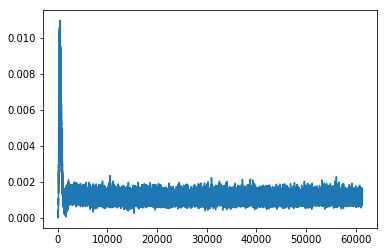

In [30]:
import matplotlib.pyplot as plt 

plt.plot(gen_losses)
plt.show()

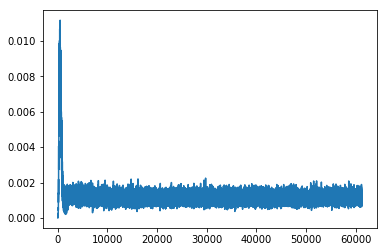

In [31]:
plt.plot(disc_losses)
plt.show()

In [124]:
condition = torch.from_numpy(negative_feedback).float().cuda()
noise = torch.randn(condition.shape[0], nz).cuda()
e_mask = torch.Tensor(train_1m == 0).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [125]:
fake_bin = (fake > 0.7).cpu().numpy()

In [126]:
fake_bin.sum()

28016

In [127]:
fake = fake_bin*fake.detach().cpu().numpy()

In [130]:
# # augmented_train_100k = train_100k + to_augment_negative
# augmented_train_100k = train_100k + fake_bin * np.random.choice(np.arange(1,4), train_100k.shape, p=p_probs)
# augmented_train_100k = train_100k + fake_bin * np.random.choice(np.arange(1, 3), train_100k.shape)
# augmented_train_100k = train_100k + to_augment_negative*3

augmented_train_1m = train_1m + fake*1.5

# augmented_train_1m = train_1m + fake_bin

In [131]:
get_sparsity(train_1m), get_sparsity(augmented_train_1m)

(4.021525859265269, 4.1466853464759135)

In [132]:
augmented_train_1m.shape, train_1m.shape, fake_bin.shape

((6040, 3706), (6040, 3706), (6040, 3706))

In [63]:
mf_sgd_1m = ExplicitMF(train_1m, 80, learning='sgd', user_fact_reg=0.01, item_fact_reg=0.01, verbose=True)
mf_sgd_1m.calculate_learning_curve(iter_array, test_1m, learning_rate=0.001)

Iteration: 1
Train rmse: 1.0038293531133295
Test rmse: 1.0032773115265594
Iteration: 2
Train rmse: 0.966426616435717
Test rmse: 0.9677640230278998
Iteration: 5
Train rmse: 0.9293167347440764
Test rmse: 0.933288833723408
Iteration: 10
Train rmse: 0.9121300688701184
Test rmse: 0.9180633613519102
Iteration: 15
Train rmse: 0.9057460765860372
Test rmse: 0.9128292990047026
Iteration: 20
Train rmse: 0.9025057839000985
Test rmse: 0.9104095062409306
Iteration: 30
	current iteration: 10
Train rmse: 0.8989979809078937
Test rmse: 0.9081672583046416
Iteration: 40
	current iteration: 10
Train rmse: 0.8954426867856865
Test rmse: 0.9060418410131977
Iteration: 50
	current iteration: 10
Train rmse: 0.8866598248027403
Test rmse: 0.900111488814514
Iteration: 70
	current iteration: 10
	current iteration: 20
Train rmse: 0.853434570814577
Test rmse: 0.8799677108605211
Iteration: 90
	current iteration: 10
	current iteration: 20
Train rmse: 0.811959509132734
Test rmse: 0.8619202577368515
Iteration: 120
	curren

KeyboardInterrupt: 

In [104]:
print('Best Test RMSE error original. SGD', min(mf_sgd_1m.test_mse))
print('Best Test RMSE error augmented. SGD', min(mf_aug_sgd_1m.test_mse))

Best Test RMSE error original. SGD 0.8473644733842984
Best Test RMSE error augmented. SGD 0.8472949447342715


In [133]:
mf_aug_als_1m = ExplicitMF(augmented_train_1m, 30, learning='als', user_fact_reg=0.01, item_fact_reg=0.01, verbose=True)
mf_aug_als_1m.calculate_learning_curve(iter_array, test_1m, learning_rate=0.001)

Iteration: 1
Train rmse: 2.8074672675515395
Test rmse: 2.967690642754709
Iteration: 2
Train rmse: 2.455049200593036
Test rmse: 2.6395143281345437
Iteration: 5
Train rmse: 2.4020434027192965
Test rmse: 2.5790411168187077
Iteration: 10
Train rmse: 2.39701581782206
Test rmse: 2.5715890437882787
Iteration: 15
Train rmse: 2.3963654600904953
Test rmse: 2.570994136357961
Iteration: 20
Train rmse: 2.3961692920816717
Test rmse: 2.5707909650227654
Iteration: 30
	current iteration: 10
Train rmse: 2.39595959806869
Test rmse: 2.570011874459095
Iteration: 40
	current iteration: 10
Train rmse: 2.395643333660818
Test rmse: 2.568914092037507
Iteration: 50
	current iteration: 10
Train rmse: 2.395330950381279
Test rmse: 2.568088673336633
Iteration: 70
	current iteration: 10
	current iteration: 20
Train rmse: 2.3950259190085097
Test rmse: 2.5674778492632706
Iteration: 90
	current iteration: 10
	current iteration: 20
Train rmse: 2.3949445969832808
Test rmse: 2.567367326036432
Iteration: 120
	current iterat

In [107]:
mf_als_1m = ExplicitMF(train_1m, 20, learning='als', user_fact_reg=0.01, item_fact_reg=0.01, verbose=True)
mf_als_1m.calculate_learning_curve(iter_array, test_1m, learning_rate=0.001)

Iteration: 1
Train rmse: 2.9409226818848047
Test rmse: 3.01906084238243
Iteration: 2
Train rmse: 2.5631961471324862
Test rmse: 2.6575483805662787
Iteration: 5
Train rmse: 2.511115498335531
Test rmse: 2.600358862801913
Iteration: 10
Train rmse: 2.5077018880189983
Test rmse: 2.597103702450954
Iteration: 15
Train rmse: 2.50736862836623
Test rmse: 2.596811007638724
Iteration: 20
Train rmse: 2.507309990026425
Test rmse: 2.596742974924067
Iteration: 30
	current iteration: 10
Train rmse: 2.5073046751123793
Test rmse: 2.596734366124964
Iteration: 40
	current iteration: 10
Train rmse: 2.5073118958444294
Test rmse: 2.5967430283722894
Iteration: 50
	current iteration: 10
Train rmse: 2.507315700987237
Test rmse: 2.5967468603139054
Iteration: 70
	current iteration: 10
	current iteration: 20
Train rmse: 2.50731818334991
Test rmse: 2.596747967225631
Iteration: 90
	current iteration: 10
	current iteration: 20
Train rmse: 2.5073189379408034
Test rmse: 2.596747773435539
Iteration: 120
	current iteration

Text(0, 0.5, 'test MSE error')

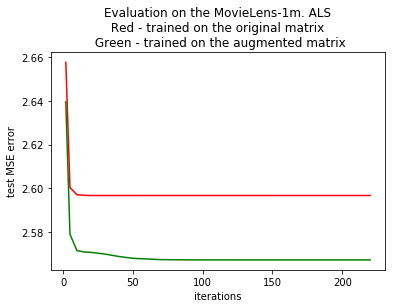

In [137]:
plt.plot(iter_array[1:], mf_als_1m.test_mse[1:], c='r')
plt.plot(iter_array[1:], mf_aug_als_1m.test_mse[1:], c='g')
plt.title('Evaluation on the MovieLens-1m. ALS\n Red - trained on the original matrix \n Green - trained on the augmented matrix')
plt.xlabel('iterations')
plt.ylabel('test MSE error')

In [134]:
print('Best Test RMSE error original. ALS', min(mf_als_1m.test_mse))
print('Best Test RMSE error augmented. ALS', min(mf_aug_als_1m.test_mse))

Best Test RMSE error original. ALS 2.596734366124964
Best Test RMSE error augmented. ALS 2.5673473065884402
